# Classify text with BERT


**Learning Objectives**

1. Load the IMDB dataset
2. Load a BERT model from TensorFlow Hub
3. Build your own model by combining BERT with a classifier
4. Train your own model, fine-tuning BERT as part of that
5. Save your model and use it to classify sentences




## Introduction 

This notebook contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.

### About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

 Each learning objective will correspond to a _#TODO_ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/text_classification/solutions/classify_text_with_bert.ipynb)

In [ ]:
# Use the chown command to change the ownership of repository to user.
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

This notebook uses TF2.x.
Please check your tensorflow version using the cell below.

In [ ]:
# Show the currently installed version of TensorFlow
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.3.0


## Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

    8192/84125825 [..............................] - ETA: 23:30

   24576/84125825 [..............................] - ETA: 15:41

   40960/84125825 [..............................] - ETA: 14:07

   73728/84125825 [..............................] - ETA: 10:27

  106496/84125825 [..............................] - ETA: 9:03 

  155648/84125825 [..............................] - ETA: 7:26

  204800/84125825 [..............................] - ETA: 6:35

  270336/84125825 [..............................] - ETA: 5:41

  335872/84125825 [..............................] - ETA: 5:09

  434176/84125825 [..............................] - ETA: 4:25

  548864/84125825 [..............................] - ETA: 3:50

  663552/84125825 [..............................] - ETA: 3:28

  811008/84125825 [..............................] - ETA: 3:04

  974848/84125825 [..............................] - ETA: 2:44

 1171456/84125825 [..............................] - ETA: 2:26

 1417216/84125825 [..............................] - ETA: 2:08

 1712128/84125825 [..............................] - ETA: 1:52

 2088960/84125825 [..............................] - ETA: 1:35

 2105344/84125825 [..............................] - ETA: 1:36

 2564096/84125825 [..............................] - ETA: 1:23

 3153920/84125825 [>.............................] - ETA: 1:10

 3874816/84125825 [>.............................] - ETA: 58s 

 3891200/84125825 [>.............................] - ETA: 59s

 4759552/84125825 [>.............................] - ETA: 49s

 4775936/84125825 [>.............................] - ETA: 50s

 5709824/84125825 [=>............................] - ETA: 42s

 5726208/84125825 [=>............................] - ETA: 43s

 6774784/84125825 [=>............................] - ETA: 37s

 6807552/84125825 [=>............................] - ETA: 37s

 8069120/84125825 [=>............................] - ETA: 31s

 8101888/84125825 [=>............................] - ETA: 32s

 9658368/84125825 [==>...........................] - ETA: 27s

 9691136/84125825 [==>...........................] - ETA: 27s

11624448/84125825 [===>..........................] - ETA: 22s

11657216/84125825 [===>..........................] - ETA: 23s

13770752/84125825 [===>..........................] - ETA: 19s

13819904/84125825 [===>..........................] - ETA: 19s

15998976/84125825 [====>.........................] - ETA: 16s

16048128/84125825 [====>.........................] - ETA: 17s

18636800/84125825 [=====>........................] - ETA: 14s

18685952/84125825 [=====>........................] - ETA: 14s

21356544/84125825 [======>.......................] - ETA: 12s

21618688/84125825 [======>.......................] - ETA: 12s

23650304/84125825 [=======>......................] - ETA: 11s

24731648/84125825 [=======>......................] - ETA: 10s

26664960/84125825 [========>.....................] - ETA: 9s 

27828224/84125825 [========>.....................] - ETA: 9s

28991488/84125825 [=========>....................] - ETA: 8s

30941184/84125825 [==========>...................] - ETA: 8s

31825920/84125825 [==========>...................] - ETA: 7s

34054144/84125825 [===========>..................] - ETA: 7s

34971648/84125825 [===========>..................] - ETA: 6s

37019648/84125825 [============>.................] - ETA: 6s

38084608/84125825 [============>.................] - ETA: 6s

40132608/84125825 [=============>................] - ETA: 5s

41213952/84125825 [=============>................] - ETA: 5s

43261952/84125825 [==============>...............] - ETA: 4s

44163072/84125825 [==============>...............] - ETA: 4s

46407680/84125825 [===============>..............] - ETA: 4s

47308800/84125825 [===============>..............] - ETA: 4s

49537024/84125825 [================>.............] - ETA: 3s

50388992/84125825 [================>.............] - ETA: 3s

52289536/84125825 [=================>............] - ETA: 3s

53321728/84125825 [==================>...........] - ETA: 3s

55042048/84125825 [==================>...........] - ETA: 3s

56254464/84125825 [===================>..........] - ETA: 2s

57712640/84125825 [===================>..........] - ETA: 2s

59072512/84125825 [====================>.........] - ETA: 2s

60645376/84125825 [====================>.........] - ETA: 2s

62185472/84125825 [=====================>........] - ETA: 2s

63266816/84125825 [=====================>........] - ETA: 2s

65069056/84125825 [======================>.......] - ETA: 1s

66248704/84125825 [======================>.......] - ETA: 1s

68214784/84125825 [=======================>......] - ETA: 1s

69378048/84125825 [=======================>......] - ETA: 1s

71360512/84125825 [========================>.....] - ETA: 1s

72212480/84125825 [========================>.....] - ETA: 1s

74293248/84125825 [=========================>....] - ETA: 0s

75358208/84125825 [=========================>....] - ETA: 0s

77324288/84125825 [==========================>...] - ETA: 0s

78290944/84125825 [==========================>...] - ETA: 0s

80224256/84125825 [===========================>..] - ETA: 0s

81436672/84125825 [============================>.] - ETA: 0s

83353600/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 7s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yeld even better accuracy but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.9928097  -0.18611881  0.36673862  0.15233737  0.6550447
  0.9681153  -0.9486272   0.00216161 -0.9877732   0.06842697 -0.9763058 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946346  0.34321272  0.33231515 ...  0.21300808  0.71020764
  -0.05771098]
 [-0.28742087  0.31980985 -0.23018607 ...  0.58455014 -0.21329728
   0.72692114]
 [-0.6615697   0.6887685  -0.87432986 ...  0.10877222 -0.2617324
   0.4785539 ]
 ...
 [-0.22561133 -0.2892562  -0.07064445 ...  0.47565985  0.83277136
   0.40025374]
 [-0.29824236 -0.27473187 -0.05450562 ...  0.48849723  1.0955356
   0.1816333 ]
 [-0.4437813   0.00930756  0.07223685 ...  0.17290069  1.1833248
   0.07897997]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can use just follow the model's url for documentation. Here specifically you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.3188841]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

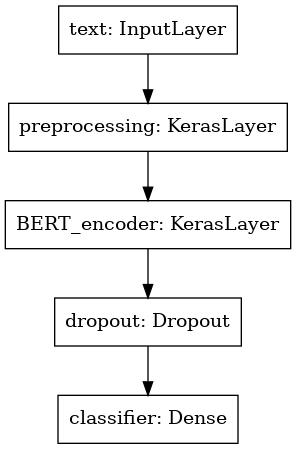

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


  1/625 [..............................] - ETA: 1:01:06 - loss: 0.7040 - binary_accuracy: 0.6875

  2/625 [..............................] - ETA: 1:19 - loss: 0.6952 - binary_accuracy: 0.6328   

  3/625 [..............................] - ETA: 1:17 - loss: 0.6991 - binary_accuracy: 0.6059

  4/625 [..............................] - ETA: 1:16 - loss: 0.7048 - binary_accuracy: 0.5951

  5/625 [..............................] - ETA: 1:15 - loss: 0.7060 - binary_accuracy: 0.5873

  6/625 [..............................] - ETA: 1:15 - loss: 0.7058 - binary_accuracy: 0.5832

  7/625 [..............................] - ETA: 1:14 - loss: 0.7055 - binary_accuracy: 0.5821

  8/625 [..............................] - ETA: 1:13 - loss: 0.7062 - binary_accuracy: 0.5831

  9/625 [..............................] - ETA: 1:13 - loss: 0.7062 - binary_accuracy: 0.5835

 10/625 [..............................] - ETA: 1:13 - loss: 0.7071 - binary_accuracy: 0.5811

 11/625 [..............................] - ETA: 1:13 - loss: 0.7077 - binary_accuracy: 0.5786

 12/625 [..............................] - ETA: 1:13 - loss: 0.7085 - binary_accuracy: 0.5751

 13/625 [..............................] - ETA: 1:13 - loss: 0.7094 - binary_accuracy: 0.5719

 14/625 [..............................] - ETA: 1:12 - loss: 0.7102 - binary_accuracy: 0.5693

 15/625 [..............................] - ETA: 1:12 - loss: 0.7109 - binary_accuracy: 0.5669

 16/625 [..............................] - ETA: 1:12 - loss: 0.7111 - binary_accuracy: 0.5656

 17/625 [..............................] - ETA: 1:11 - loss: 0.7115 - binary_accuracy: 0.5638

 18/625 [..............................] - ETA: 1:11 - loss: 0.7119 - binary_accuracy: 0.5622

 19/625 [..............................] - ETA: 1:11 - loss: 0.7121 - binary_accuracy: 0.5607

 20/625 [..............................] - ETA: 1:11 - loss: 0.7124 - binary_accuracy: 0.5591

 21/625 [>.............................] - ETA: 1:11 - loss: 0.7125 - binary_accuracy: 0.5575

 22/625 [>.............................] - ETA: 1:11 - loss: 0.7125 - binary_accuracy: 0.5560

 23/625 [>.............................] - ETA: 1:10 - loss: 0.7126 - binary_accuracy: 0.5546

 24/625 [>.............................] - ETA: 1:10 - loss: 0.7126 - binary_accuracy: 0.5536

 25/625 [>.............................] - ETA: 1:10 - loss: 0.7125 - binary_accuracy: 0.5526

 26/625 [>.............................] - ETA: 1:10 - loss: 0.7125 - binary_accuracy: 0.5515

 27/625 [>.............................] - ETA: 1:10 - loss: 0.7125 - binary_accuracy: 0.5502

 28/625 [>.............................] - ETA: 1:10 - loss: 0.7125 - binary_accuracy: 0.5493

 29/625 [>.............................] - ETA: 1:09 - loss: 0.7126 - binary_accuracy: 0.5482

 30/625 [>.............................] - ETA: 1:09 - loss: 0.7127 - binary_accuracy: 0.5471

 31/625 [>.............................] - ETA: 1:09 - loss: 0.7128 - binary_accuracy: 0.5462

 32/625 [>.............................] - ETA: 1:09 - loss: 0.7128 - binary_accuracy: 0.5454

 33/625 [>.............................] - ETA: 1:09 - loss: 0.7128 - binary_accuracy: 0.5446

 34/625 [>.............................] - ETA: 1:09 - loss: 0.7129 - binary_accuracy: 0.5438

 35/625 [>.............................] - ETA: 1:09 - loss: 0.7129 - binary_accuracy: 0.5431

 36/625 [>.............................] - ETA: 1:09 - loss: 0.7128 - binary_accuracy: 0.5425

 37/625 [>.............................] - ETA: 1:08 - loss: 0.7126 - binary_accuracy: 0.5420

 38/625 [>.............................] - ETA: 1:08 - loss: 0.7125 - binary_accuracy: 0.5415

 39/625 [>.............................] - ETA: 1:08 - loss: 0.7123 - binary_accuracy: 0.5411

 40/625 [>.............................] - ETA: 1:08 - loss: 0.7120 - binary_accuracy: 0.5407

 41/625 [>.............................] - ETA: 1:08 - loss: 0.7118 - binary_accuracy: 0.5404

 42/625 [=>............................] - ETA: 1:08 - loss: 0.7115 - binary_accuracy: 0.5401

 43/625 [=>............................] - ETA: 1:08 - loss: 0.7113 - binary_accuracy: 0.5400

 44/625 [=>............................] - ETA: 1:07 - loss: 0.7110 - binary_accuracy: 0.5398

 45/625 [=>............................] - ETA: 1:07 - loss: 0.7108 - binary_accuracy: 0.5396

 46/625 [=>............................] - ETA: 1:07 - loss: 0.7105 - binary_accuracy: 0.5395

 47/625 [=>............................] - ETA: 1:07 - loss: 0.7102 - binary_accuracy: 0.5394

 48/625 [=>............................] - ETA: 1:07 - loss: 0.7099 - binary_accuracy: 0.5394

 49/625 [=>............................] - ETA: 1:07 - loss: 0.7096 - binary_accuracy: 0.5394

 50/625 [=>............................] - ETA: 1:07 - loss: 0.7093 - binary_accuracy: 0.5394

 51/625 [=>............................] - ETA: 1:06 - loss: 0.7090 - binary_accuracy: 0.5394

 52/625 [=>............................] - ETA: 1:06 - loss: 0.7087 - binary_accuracy: 0.5394

 53/625 [=>............................] - ETA: 1:06 - loss: 0.7084 - binary_accuracy: 0.5394

 54/625 [=>............................] - ETA: 1:06 - loss: 0.7081 - binary_accuracy: 0.5394

 55/625 [=>............................] - ETA: 1:06 - loss: 0.7077 - binary_accuracy: 0.5394

 56/625 [=>............................] - ETA: 1:06 - loss: 0.7074 - binary_accuracy: 0.5394

 57/625 [=>............................] - ETA: 1:06 - loss: 0.7071 - binary_accuracy: 0.5394

 58/625 [=>............................] - ETA: 1:06 - loss: 0.7068 - binary_accuracy: 0.5393

 59/625 [=>............................] - ETA: 1:05 - loss: 0.7065 - binary_accuracy: 0.5393

 60/625 [=>............................] - ETA: 1:05 - loss: 0.7062 - binary_accuracy: 0.5394

 61/625 [=>............................] - ETA: 1:05 - loss: 0.7059 - binary_accuracy: 0.5395

 62/625 [=>............................] - ETA: 1:05 - loss: 0.7056 - binary_accuracy: 0.5396

 63/625 [==>...........................] - ETA: 1:05 - loss: 0.7052 - binary_accuracy: 0.5397

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.7049 - binary_accuracy: 0.5398

 65/625 [==>...........................] - ETA: 1:05 - loss: 0.7046 - binary_accuracy: 0.5399

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.7043 - binary_accuracy: 0.5401

 67/625 [==>...........................] - ETA: 1:04 - loss: 0.7040 - binary_accuracy: 0.5402

 68/625 [==>...........................] - ETA: 1:04 - loss: 0.7037 - binary_accuracy: 0.5403

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.7034 - binary_accuracy: 0.5405

 70/625 [==>...........................] - ETA: 1:04 - loss: 0.7031 - binary_accuracy: 0.5406

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.7028 - binary_accuracy: 0.5408

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.7025 - binary_accuracy: 0.5410

 73/625 [==>...........................] - ETA: 1:04 - loss: 0.7022 - binary_accuracy: 0.5411

 74/625 [==>...........................] - ETA: 1:04 - loss: 0.7019 - binary_accuracy: 0.5413

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.7016 - binary_accuracy: 0.5414

 76/625 [==>...........................] - ETA: 1:03 - loss: 0.7013 - binary_accuracy: 0.5416

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.7010 - binary_accuracy: 0.5417

 78/625 [==>...........................] - ETA: 1:03 - loss: 0.7007 - binary_accuracy: 0.5419

 79/625 [==>...........................] - ETA: 1:03 - loss: 0.7004 - binary_accuracy: 0.5421

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.7001 - binary_accuracy: 0.5423

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.6997 - binary_accuracy: 0.5425

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.6994 - binary_accuracy: 0.5427

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.6991 - binary_accuracy: 0.5429

 84/625 [===>..........................] - ETA: 1:02 - loss: 0.6988 - binary_accuracy: 0.5432

 85/625 [===>..........................] - ETA: 1:02 - loss: 0.6984 - binary_accuracy: 0.5434

 86/625 [===>..........................] - ETA: 1:02 - loss: 0.6981 - binary_accuracy: 0.5436

 87/625 [===>..........................] - ETA: 1:02 - loss: 0.6978 - binary_accuracy: 0.5439

 88/625 [===>..........................] - ETA: 1:02 - loss: 0.6975 - binary_accuracy: 0.5441

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.6971 - binary_accuracy: 0.5444

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.6968 - binary_accuracy: 0.5446

 91/625 [===>..........................] - ETA: 1:01 - loss: 0.6965 - binary_accuracy: 0.5448

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.6962 - binary_accuracy: 0.5450

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.6959 - binary_accuracy: 0.5453

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.6956 - binary_accuracy: 0.5455

 95/625 [===>..........................] - ETA: 1:01 - loss: 0.6953 - binary_accuracy: 0.5457

 96/625 [===>..........................] - ETA: 1:01 - loss: 0.6951 - binary_accuracy: 0.5459

 97/625 [===>..........................] - ETA: 1:01 - loss: 0.6948 - binary_accuracy: 0.5462

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.6945 - binary_accuracy: 0.5464

 99/625 [===>..........................] - ETA: 1:00 - loss: 0.6942 - binary_accuracy: 0.5466

100/625 [===>..........................] - ETA: 1:00 - loss: 0.6939 - binary_accuracy: 0.5469

101/625 [===>..........................] - ETA: 1:00 - loss: 0.6936 - binary_accuracy: 0.5471

102/625 [===>..........................] - ETA: 1:00 - loss: 0.6933 - binary_accuracy: 0.5474

103/625 [===>..........................] - ETA: 1:00 - loss: 0.6930 - binary_accuracy: 0.5477

104/625 [===>..........................] - ETA: 1:00 - loss: 0.6927 - binary_accuracy: 0.5479

105/625 [====>.........................] - ETA: 1:00 - loss: 0.6924 - binary_accuracy: 0.5482

106/625 [====>.........................] - ETA: 1:00 - loss: 0.6921 - binary_accuracy: 0.5484

107/625 [====>.........................] - ETA: 59s - loss: 0.6918 - binary_accuracy: 0.5487 

108/625 [====>.........................] - ETA: 59s - loss: 0.6915 - binary_accuracy: 0.5490

109/625 [====>.........................] - ETA: 59s - loss: 0.6912 - binary_accuracy: 0.5492

110/625 [====>.........................] - ETA: 59s - loss: 0.6909 - binary_accuracy: 0.5495

111/625 [====>.........................] - ETA: 59s - loss: 0.6906 - binary_accuracy: 0.5497

112/625 [====>.........................] - ETA: 59s - loss: 0.6903 - binary_accuracy: 0.5500

113/625 [====>.........................] - ETA: 59s - loss: 0.6900 - binary_accuracy: 0.5502

114/625 [====>.........................] - ETA: 59s - loss: 0.6897 - binary_accuracy: 0.5505

115/625 [====>.........................] - ETA: 59s - loss: 0.6894 - binary_accuracy: 0.5507

116/625 [====>.........................] - ETA: 58s - loss: 0.6891 - binary_accuracy: 0.5510

117/625 [====>.........................] - ETA: 58s - loss: 0.6888 - binary_accuracy: 0.5512

118/625 [====>.........................] - ETA: 58s - loss: 0.6885 - binary_accuracy: 0.5515

119/625 [====>.........................] - ETA: 58s - loss: 0.6882 - binary_accuracy: 0.5517

120/625 [====>.........................] - ETA: 58s - loss: 0.6880 - binary_accuracy: 0.5520

121/625 [====>.........................] - ETA: 58s - loss: 0.6877 - binary_accuracy: 0.5522

122/625 [====>.........................] - ETA: 58s - loss: 0.6874 - binary_accuracy: 0.5524

123/625 [====>.........................] - ETA: 58s - loss: 0.6871 - binary_accuracy: 0.5527

124/625 [====>.........................] - ETA: 58s - loss: 0.6868 - binary_accuracy: 0.5529

125/625 [=====>........................] - ETA: 57s - loss: 0.6865 - binary_accuracy: 0.5532

126/625 [=====>........................] - ETA: 57s - loss: 0.6863 - binary_accuracy: 0.5534

127/625 [=====>........................] - ETA: 57s - loss: 0.6860 - binary_accuracy: 0.5537

128/625 [=====>........................] - ETA: 57s - loss: 0.6857 - binary_accuracy: 0.5540

129/625 [=====>........................] - ETA: 57s - loss: 0.6854 - binary_accuracy: 0.5543

130/625 [=====>........................] - ETA: 57s - loss: 0.6851 - binary_accuracy: 0.5545

131/625 [=====>........................] - ETA: 57s - loss: 0.6848 - binary_accuracy: 0.5548

132/625 [=====>........................] - ETA: 57s - loss: 0.6845 - binary_accuracy: 0.5551

133/625 [=====>........................] - ETA: 56s - loss: 0.6843 - binary_accuracy: 0.5554

134/625 [=====>........................] - ETA: 56s - loss: 0.6840 - binary_accuracy: 0.5557

135/625 [=====>........................] - ETA: 56s - loss: 0.6837 - binary_accuracy: 0.5560

136/625 [=====>........................] - ETA: 56s - loss: 0.6834 - binary_accuracy: 0.5562

137/625 [=====>........................] - ETA: 56s - loss: 0.6831 - binary_accuracy: 0.5565

138/625 [=====>........................] - ETA: 56s - loss: 0.6828 - binary_accuracy: 0.5568

139/625 [=====>........................] - ETA: 56s - loss: 0.6825 - binary_accuracy: 0.5571

140/625 [=====>........................] - ETA: 56s - loss: 0.6822 - binary_accuracy: 0.5574

141/625 [=====>........................] - ETA: 56s - loss: 0.6820 - binary_accuracy: 0.5577

142/625 [=====>........................] - ETA: 55s - loss: 0.6817 - binary_accuracy: 0.5579

143/625 [=====>........................] - ETA: 55s - loss: 0.6814 - binary_accuracy: 0.5582

144/625 [=====>........................] - ETA: 55s - loss: 0.6811 - binary_accuracy: 0.5585

145/625 [=====>........................] - ETA: 55s - loss: 0.6808 - binary_accuracy: 0.5588

146/625 [======>.......................] - ETA: 55s - loss: 0.6805 - binary_accuracy: 0.5591

147/625 [======>.......................] - ETA: 55s - loss: 0.6802 - binary_accuracy: 0.5593

148/625 [======>.......................] - ETA: 55s - loss: 0.6799 - binary_accuracy: 0.5596

149/625 [======>.......................] - ETA: 55s - loss: 0.6796 - binary_accuracy: 0.5599

150/625 [======>.......................] - ETA: 55s - loss: 0.6794 - binary_accuracy: 0.5602

151/625 [======>.......................] - ETA: 54s - loss: 0.6791 - binary_accuracy: 0.5605

152/625 [======>.......................] - ETA: 54s - loss: 0.6788 - binary_accuracy: 0.5608

153/625 [======>.......................] - ETA: 54s - loss: 0.6785 - binary_accuracy: 0.5611

154/625 [======>.......................] - ETA: 54s - loss: 0.6782 - binary_accuracy: 0.5613

155/625 [======>.......................] - ETA: 54s - loss: 0.6779 - binary_accuracy: 0.5616

156/625 [======>.......................] - ETA: 54s - loss: 0.6776 - binary_accuracy: 0.5619

157/625 [======>.......................] - ETA: 54s - loss: 0.6774 - binary_accuracy: 0.5622

158/625 [======>.......................] - ETA: 54s - loss: 0.6771 - binary_accuracy: 0.5625

159/625 [======>.......................] - ETA: 53s - loss: 0.6768 - binary_accuracy: 0.5628

160/625 [======>.......................] - ETA: 53s - loss: 0.6765 - binary_accuracy: 0.5631

161/625 [======>.......................] - ETA: 53s - loss: 0.6762 - binary_accuracy: 0.5634

162/625 [======>.......................] - ETA: 53s - loss: 0.6759 - binary_accuracy: 0.5637

163/625 [======>.......................] - ETA: 53s - loss: 0.6756 - binary_accuracy: 0.5640

164/625 [======>.......................] - ETA: 53s - loss: 0.6753 - binary_accuracy: 0.5643

165/625 [======>.......................] - ETA: 53s - loss: 0.6750 - binary_accuracy: 0.5647

166/625 [======>.......................] - ETA: 53s - loss: 0.6747 - binary_accuracy: 0.5650

167/625 [=======>......................] - ETA: 53s - loss: 0.6744 - binary_accuracy: 0.5653

168/625 [=======>......................] - ETA: 52s - loss: 0.6741 - binary_accuracy: 0.5656

169/625 [=======>......................] - ETA: 52s - loss: 0.6738 - binary_accuracy: 0.5659

170/625 [=======>......................] - ETA: 52s - loss: 0.6735 - binary_accuracy: 0.5662

171/625 [=======>......................] - ETA: 52s - loss: 0.6732 - binary_accuracy: 0.5665

172/625 [=======>......................] - ETA: 52s - loss: 0.6729 - binary_accuracy: 0.5668

173/625 [=======>......................] - ETA: 52s - loss: 0.6726 - binary_accuracy: 0.5671

174/625 [=======>......................] - ETA: 52s - loss: 0.6723 - binary_accuracy: 0.5674

175/625 [=======>......................] - ETA: 52s - loss: 0.6720 - binary_accuracy: 0.5678

176/625 [=======>......................] - ETA: 52s - loss: 0.6717 - binary_accuracy: 0.5681

177/625 [=======>......................] - ETA: 51s - loss: 0.6714 - binary_accuracy: 0.5684

178/625 [=======>......................] - ETA: 51s - loss: 0.6711 - binary_accuracy: 0.5687

179/625 [=======>......................] - ETA: 51s - loss: 0.6708 - binary_accuracy: 0.5690

180/625 [=======>......................] - ETA: 51s - loss: 0.6704 - binary_accuracy: 0.5693

181/625 [=======>......................] - ETA: 51s - loss: 0.6701 - binary_accuracy: 0.5696

182/625 [=======>......................] - ETA: 51s - loss: 0.6698 - binary_accuracy: 0.5700

183/625 [=======>......................] - ETA: 51s - loss: 0.6695 - binary_accuracy: 0.5703

184/625 [=======>......................] - ETA: 51s - loss: 0.6692 - binary_accuracy: 0.5706

185/625 [=======>......................] - ETA: 51s - loss: 0.6689 - binary_accuracy: 0.5709

186/625 [=======>......................] - ETA: 50s - loss: 0.6686 - binary_accuracy: 0.5712

187/625 [=======>......................] - ETA: 50s - loss: 0.6683 - binary_accuracy: 0.5715

188/625 [========>.....................] - ETA: 50s - loss: 0.6680 - binary_accuracy: 0.5718

189/625 [========>.....................] - ETA: 50s - loss: 0.6677 - binary_accuracy: 0.5721

190/625 [========>.....................] - ETA: 50s - loss: 0.6673 - binary_accuracy: 0.5725

191/625 [========>.....................] - ETA: 50s - loss: 0.6670 - binary_accuracy: 0.5728

192/625 [========>.....................] - ETA: 50s - loss: 0.6667 - binary_accuracy: 0.5731

193/625 [========>.....................] - ETA: 50s - loss: 0.6664 - binary_accuracy: 0.5734

194/625 [========>.....................] - ETA: 50s - loss: 0.6661 - binary_accuracy: 0.5737

195/625 [========>.....................] - ETA: 49s - loss: 0.6657 - binary_accuracy: 0.5741

196/625 [========>.....................] - ETA: 49s - loss: 0.6654 - binary_accuracy: 0.5744

197/625 [========>.....................] - ETA: 49s - loss: 0.6651 - binary_accuracy: 0.5747

198/625 [========>.....................] - ETA: 49s - loss: 0.6648 - binary_accuracy: 0.5750

199/625 [========>.....................] - ETA: 49s - loss: 0.6645 - binary_accuracy: 0.5753

200/625 [========>.....................] - ETA: 49s - loss: 0.6642 - binary_accuracy: 0.5756

201/625 [========>.....................] - ETA: 49s - loss: 0.6639 - binary_accuracy: 0.5759

202/625 [========>.....................] - ETA: 49s - loss: 0.6636 - binary_accuracy: 0.5763

203/625 [========>.....................] - ETA: 49s - loss: 0.6633 - binary_accuracy: 0.5766

204/625 [========>.....................] - ETA: 48s - loss: 0.6630 - binary_accuracy: 0.5769

205/625 [========>.....................] - ETA: 48s - loss: 0.6626 - binary_accuracy: 0.5772

206/625 [========>.....................] - ETA: 48s - loss: 0.6623 - binary_accuracy: 0.5775

207/625 [========>.....................] - ETA: 48s - loss: 0.6620 - binary_accuracy: 0.5778

208/625 [========>.....................] - ETA: 48s - loss: 0.6617 - binary_accuracy: 0.5781

209/625 [=========>....................] - ETA: 48s - loss: 0.6614 - binary_accuracy: 0.5784

210/625 [=========>....................] - ETA: 48s - loss: 0.6611 - binary_accuracy: 0.5787

211/625 [=========>....................] - ETA: 48s - loss: 0.6608 - binary_accuracy: 0.5790

212/625 [=========>....................] - ETA: 48s - loss: 0.6605 - binary_accuracy: 0.5793

213/625 [=========>....................] - ETA: 47s - loss: 0.6602 - binary_accuracy: 0.5796

214/625 [=========>....................] - ETA: 47s - loss: 0.6599 - binary_accuracy: 0.5800

215/625 [=========>....................] - ETA: 47s - loss: 0.6596 - binary_accuracy: 0.5803

216/625 [=========>....................] - ETA: 47s - loss: 0.6593 - binary_accuracy: 0.5806

217/625 [=========>....................] - ETA: 47s - loss: 0.6590 - binary_accuracy: 0.5809

218/625 [=========>....................] - ETA: 47s - loss: 0.6587 - binary_accuracy: 0.5812

219/625 [=========>....................] - ETA: 47s - loss: 0.6584 - binary_accuracy: 0.5815

220/625 [=========>....................] - ETA: 47s - loss: 0.6581 - binary_accuracy: 0.5818

221/625 [=========>....................] - ETA: 46s - loss: 0.6578 - binary_accuracy: 0.5821

222/625 [=========>....................] - ETA: 46s - loss: 0.6575 - binary_accuracy: 0.5824

223/625 [=========>....................] - ETA: 46s - loss: 0.6572 - binary_accuracy: 0.5827

224/625 [=========>....................] - ETA: 46s - loss: 0.6569 - binary_accuracy: 0.5830

225/625 [=========>....................] - ETA: 46s - loss: 0.6566 - binary_accuracy: 0.5833

226/625 [=========>....................] - ETA: 46s - loss: 0.6563 - binary_accuracy: 0.5836

227/625 [=========>....................] - ETA: 46s - loss: 0.6560 - binary_accuracy: 0.5839

228/625 [=========>....................] - ETA: 46s - loss: 0.6557 - binary_accuracy: 0.5842

229/625 [=========>....................] - ETA: 46s - loss: 0.6554 - binary_accuracy: 0.5845

230/625 [==========>...................] - ETA: 45s - loss: 0.6551 - binary_accuracy: 0.5848

231/625 [==========>...................] - ETA: 45s - loss: 0.6547 - binary_accuracy: 0.5851

232/625 [==========>...................] - ETA: 45s - loss: 0.6544 - binary_accuracy: 0.5854

233/625 [==========>...................] - ETA: 45s - loss: 0.6541 - binary_accuracy: 0.5857

234/625 [==========>...................] - ETA: 45s - loss: 0.6538 - binary_accuracy: 0.5860

235/625 [==========>...................] - ETA: 45s - loss: 0.6535 - binary_accuracy: 0.5863

236/625 [==========>...................] - ETA: 45s - loss: 0.6532 - binary_accuracy: 0.5866

237/625 [==========>...................] - ETA: 45s - loss: 0.6529 - binary_accuracy: 0.5869

238/625 [==========>...................] - ETA: 45s - loss: 0.6526 - binary_accuracy: 0.5872

239/625 [==========>...................] - ETA: 44s - loss: 0.6523 - binary_accuracy: 0.5875

240/625 [==========>...................] - ETA: 44s - loss: 0.6520 - binary_accuracy: 0.5878

241/625 [==========>...................] - ETA: 44s - loss: 0.6517 - binary_accuracy: 0.5881

242/625 [==========>...................] - ETA: 44s - loss: 0.6514 - binary_accuracy: 0.5884

243/625 [==========>...................] - ETA: 44s - loss: 0.6511 - binary_accuracy: 0.5887

244/625 [==========>...................] - ETA: 44s - loss: 0.6508 - binary_accuracy: 0.5890

245/625 [==========>...................] - ETA: 44s - loss: 0.6505 - binary_accuracy: 0.5893

246/625 [==========>...................] - ETA: 44s - loss: 0.6502 - binary_accuracy: 0.5896

247/625 [==========>...................] - ETA: 43s - loss: 0.6499 - binary_accuracy: 0.5899

248/625 [==========>...................] - ETA: 43s - loss: 0.6496 - binary_accuracy: 0.5902

249/625 [==========>...................] - ETA: 43s - loss: 0.6493 - binary_accuracy: 0.5905

250/625 [===========>..................] - ETA: 43s - loss: 0.6490 - binary_accuracy: 0.5908

251/625 [===========>..................] - ETA: 43s - loss: 0.6487 - binary_accuracy: 0.5911

252/625 [===========>..................] - ETA: 43s - loss: 0.6484 - binary_accuracy: 0.5914

253/625 [===========>..................] - ETA: 43s - loss: 0.6481 - binary_accuracy: 0.5917

254/625 [===========>..................] - ETA: 43s - loss: 0.6477 - binary_accuracy: 0.5920

255/625 [===========>..................] - ETA: 43s - loss: 0.6474 - binary_accuracy: 0.5923

256/625 [===========>..................] - ETA: 42s - loss: 0.6471 - binary_accuracy: 0.5926

257/625 [===========>..................] - ETA: 42s - loss: 0.6468 - binary_accuracy: 0.5929

258/625 [===========>..................] - ETA: 42s - loss: 0.6465 - binary_accuracy: 0.5932

259/625 [===========>..................] - ETA: 42s - loss: 0.6462 - binary_accuracy: 0.5935

260/625 [===========>..................] - ETA: 42s - loss: 0.6459 - binary_accuracy: 0.5938

261/625 [===========>..................] - ETA: 42s - loss: 0.6456 - binary_accuracy: 0.5941

262/625 [===========>..................] - ETA: 42s - loss: 0.6453 - binary_accuracy: 0.5943

263/625 [===========>..................] - ETA: 42s - loss: 0.6450 - binary_accuracy: 0.5946

264/625 [===========>..................] - ETA: 41s - loss: 0.6447 - binary_accuracy: 0.5949

265/625 [===========>..................] - ETA: 41s - loss: 0.6444 - binary_accuracy: 0.5952

266/625 [===========>..................] - ETA: 41s - loss: 0.6441 - binary_accuracy: 0.5955

267/625 [===========>..................] - ETA: 41s - loss: 0.6438 - binary_accuracy: 0.5958

268/625 [===========>..................] - ETA: 41s - loss: 0.6435 - binary_accuracy: 0.5961

269/625 [===========>..................] - ETA: 41s - loss: 0.6432 - binary_accuracy: 0.5964

270/625 [===========>..................] - ETA: 41s - loss: 0.6429 - binary_accuracy: 0.5967

271/625 [============>.................] - ETA: 41s - loss: 0.6426 - binary_accuracy: 0.5970

272/625 [============>.................] - ETA: 41s - loss: 0.6423 - binary_accuracy: 0.5973

273/625 [============>.................] - ETA: 40s - loss: 0.6420 - binary_accuracy: 0.5976

274/625 [============>.................] - ETA: 40s - loss: 0.6418 - binary_accuracy: 0.5978

275/625 [============>.................] - ETA: 40s - loss: 0.6415 - binary_accuracy: 0.5981

276/625 [============>.................] - ETA: 40s - loss: 0.6412 - binary_accuracy: 0.5984

277/625 [============>.................] - ETA: 40s - loss: 0.6409 - binary_accuracy: 0.5987

278/625 [============>.................] - ETA: 40s - loss: 0.6406 - binary_accuracy: 0.5990

279/625 [============>.................] - ETA: 40s - loss: 0.6403 - binary_accuracy: 0.5993

280/625 [============>.................] - ETA: 40s - loss: 0.6400 - binary_accuracy: 0.5996

281/625 [============>.................] - ETA: 39s - loss: 0.6397 - binary_accuracy: 0.5999

282/625 [============>.................] - ETA: 39s - loss: 0.6394 - binary_accuracy: 0.6001

283/625 [============>.................] - ETA: 39s - loss: 0.6391 - binary_accuracy: 0.6004

284/625 [============>.................] - ETA: 39s - loss: 0.6388 - binary_accuracy: 0.6007

285/625 [============>.................] - ETA: 39s - loss: 0.6385 - binary_accuracy: 0.6010

286/625 [============>.................] - ETA: 39s - loss: 0.6382 - binary_accuracy: 0.6013

287/625 [============>.................] - ETA: 39s - loss: 0.6379 - binary_accuracy: 0.6016

288/625 [============>.................] - ETA: 39s - loss: 0.6377 - binary_accuracy: 0.6018

289/625 [============>.................] - ETA: 39s - loss: 0.6374 - binary_accuracy: 0.6021

290/625 [============>.................] - ETA: 38s - loss: 0.6371 - binary_accuracy: 0.6024

291/625 [============>.................] - ETA: 38s - loss: 0.6368 - binary_accuracy: 0.6027

292/625 [=============>................] - ETA: 38s - loss: 0.6365 - binary_accuracy: 0.6030

293/625 [=============>................] - ETA: 38s - loss: 0.6362 - binary_accuracy: 0.6032

294/625 [=============>................] - ETA: 38s - loss: 0.6360 - binary_accuracy: 0.6035

295/625 [=============>................] - ETA: 38s - loss: 0.6357 - binary_accuracy: 0.6038

296/625 [=============>................] - ETA: 38s - loss: 0.6354 - binary_accuracy: 0.6041

297/625 [=============>................] - ETA: 38s - loss: 0.6351 - binary_accuracy: 0.6043

298/625 [=============>................] - ETA: 38s - loss: 0.6348 - binary_accuracy: 0.6046

299/625 [=============>................] - ETA: 37s - loss: 0.6346 - binary_accuracy: 0.6049

300/625 [=============>................] - ETA: 37s - loss: 0.6343 - binary_accuracy: 0.6052

301/625 [=============>................] - ETA: 37s - loss: 0.6340 - binary_accuracy: 0.6054

302/625 [=============>................] - ETA: 37s - loss: 0.6337 - binary_accuracy: 0.6057

303/625 [=============>................] - ETA: 37s - loss: 0.6335 - binary_accuracy: 0.6060

304/625 [=============>................] - ETA: 37s - loss: 0.6332 - binary_accuracy: 0.6063

305/625 [=============>................] - ETA: 37s - loss: 0.6329 - binary_accuracy: 0.6065

306/625 [=============>................] - ETA: 37s - loss: 0.6326 - binary_accuracy: 0.6068

307/625 [=============>................] - ETA: 36s - loss: 0.6324 - binary_accuracy: 0.6071

308/625 [=============>................] - ETA: 36s - loss: 0.6321 - binary_accuracy: 0.6073

309/625 [=============>................] - ETA: 36s - loss: 0.6318 - binary_accuracy: 0.6076

310/625 [=============>................] - ETA: 36s - loss: 0.6316 - binary_accuracy: 0.6079

311/625 [=============>................] - ETA: 36s - loss: 0.6313 - binary_accuracy: 0.6081

312/625 [=============>................] - ETA: 36s - loss: 0.6310 - binary_accuracy: 0.6084

313/625 [==============>...............] - ETA: 36s - loss: 0.6308 - binary_accuracy: 0.6086

314/625 [==============>...............] - ETA: 36s - loss: 0.6305 - binary_accuracy: 0.6089

315/625 [==============>...............] - ETA: 36s - loss: 0.6302 - binary_accuracy: 0.6092

316/625 [==============>...............] - ETA: 35s - loss: 0.6300 - binary_accuracy: 0.6094

317/625 [==============>...............] - ETA: 35s - loss: 0.6297 - binary_accuracy: 0.6097

318/625 [==============>...............] - ETA: 35s - loss: 0.6294 - binary_accuracy: 0.6100

319/625 [==============>...............] - ETA: 35s - loss: 0.6292 - binary_accuracy: 0.6102

320/625 [==============>...............] - ETA: 35s - loss: 0.6289 - binary_accuracy: 0.6105

321/625 [==============>...............] - ETA: 35s - loss: 0.6286 - binary_accuracy: 0.6107

322/625 [==============>...............] - ETA: 35s - loss: 0.6284 - binary_accuracy: 0.6110

323/625 [==============>...............] - ETA: 35s - loss: 0.6281 - binary_accuracy: 0.6113

324/625 [==============>...............] - ETA: 34s - loss: 0.6279 - binary_accuracy: 0.6115

325/625 [==============>...............] - ETA: 34s - loss: 0.6276 - binary_accuracy: 0.6118

326/625 [==============>...............] - ETA: 34s - loss: 0.6273 - binary_accuracy: 0.6120

327/625 [==============>...............] - ETA: 34s - loss: 0.6271 - binary_accuracy: 0.6123

328/625 [==============>...............] - ETA: 34s - loss: 0.6268 - binary_accuracy: 0.6126

329/625 [==============>...............] - ETA: 34s - loss: 0.6266 - binary_accuracy: 0.6128

330/625 [==============>...............] - ETA: 34s - loss: 0.6263 - binary_accuracy: 0.6131

331/625 [==============>...............] - ETA: 34s - loss: 0.6260 - binary_accuracy: 0.6133

332/625 [==============>...............] - ETA: 34s - loss: 0.6258 - binary_accuracy: 0.6136

333/625 [==============>...............] - ETA: 33s - loss: 0.6255 - binary_accuracy: 0.6138

334/625 [===============>..............] - ETA: 33s - loss: 0.6253 - binary_accuracy: 0.6141

335/625 [===============>..............] - ETA: 33s - loss: 0.6250 - binary_accuracy: 0.6143

336/625 [===============>..............] - ETA: 33s - loss: 0.6248 - binary_accuracy: 0.6146

337/625 [===============>..............] - ETA: 33s - loss: 0.6245 - binary_accuracy: 0.6148

338/625 [===============>..............] - ETA: 33s - loss: 0.6243 - binary_accuracy: 0.6150

339/625 [===============>..............] - ETA: 33s - loss: 0.6240 - binary_accuracy: 0.6153

340/625 [===============>..............] - ETA: 33s - loss: 0.6238 - binary_accuracy: 0.6155

341/625 [===============>..............] - ETA: 33s - loss: 0.6236 - binary_accuracy: 0.6158

342/625 [===============>..............] - ETA: 32s - loss: 0.6233 - binary_accuracy: 0.6160

343/625 [===============>..............] - ETA: 32s - loss: 0.6231 - binary_accuracy: 0.6163

344/625 [===============>..............] - ETA: 32s - loss: 0.6228 - binary_accuracy: 0.6165

345/625 [===============>..............] - ETA: 32s - loss: 0.6226 - binary_accuracy: 0.6167

346/625 [===============>..............] - ETA: 32s - loss: 0.6223 - binary_accuracy: 0.6170

347/625 [===============>..............] - ETA: 32s - loss: 0.6221 - binary_accuracy: 0.6172

348/625 [===============>..............] - ETA: 32s - loss: 0.6219 - binary_accuracy: 0.6174

349/625 [===============>..............] - ETA: 32s - loss: 0.6216 - binary_accuracy: 0.6177

350/625 [===============>..............] - ETA: 32s - loss: 0.6214 - binary_accuracy: 0.6179

351/625 [===============>..............] - ETA: 31s - loss: 0.6211 - binary_accuracy: 0.6182

352/625 [===============>..............] - ETA: 31s - loss: 0.6209 - binary_accuracy: 0.6184

353/625 [===============>..............] - ETA: 31s - loss: 0.6207 - binary_accuracy: 0.6186

354/625 [===============>..............] - ETA: 31s - loss: 0.6204 - binary_accuracy: 0.6189

355/625 [================>.............] - ETA: 31s - loss: 0.6202 - binary_accuracy: 0.6191

356/625 [================>.............] - ETA: 31s - loss: 0.6200 - binary_accuracy: 0.6193

357/625 [================>.............] - ETA: 31s - loss: 0.6197 - binary_accuracy: 0.6196

358/625 [================>.............] - ETA: 31s - loss: 0.6195 - binary_accuracy: 0.6198

359/625 [================>.............] - ETA: 30s - loss: 0.6193 - binary_accuracy: 0.6200

360/625 [================>.............] - ETA: 30s - loss: 0.6190 - binary_accuracy: 0.6203

361/625 [================>.............] - ETA: 30s - loss: 0.6188 - binary_accuracy: 0.6205

362/625 [================>.............] - ETA: 30s - loss: 0.6186 - binary_accuracy: 0.6207

363/625 [================>.............] - ETA: 30s - loss: 0.6183 - binary_accuracy: 0.6210

364/625 [================>.............] - ETA: 30s - loss: 0.6181 - binary_accuracy: 0.6212

365/625 [================>.............] - ETA: 30s - loss: 0.6179 - binary_accuracy: 0.6214

366/625 [================>.............] - ETA: 30s - loss: 0.6176 - binary_accuracy: 0.6216

367/625 [================>.............] - ETA: 30s - loss: 0.6174 - binary_accuracy: 0.6219

368/625 [================>.............] - ETA: 29s - loss: 0.6172 - binary_accuracy: 0.6221

369/625 [================>.............] - ETA: 29s - loss: 0.6169 - binary_accuracy: 0.6223

370/625 [================>.............] - ETA: 29s - loss: 0.6167 - binary_accuracy: 0.6226

371/625 [================>.............] - ETA: 29s - loss: 0.6164 - binary_accuracy: 0.6228

372/625 [================>.............] - ETA: 29s - loss: 0.6162 - binary_accuracy: 0.6230

373/625 [================>.............] - ETA: 29s - loss: 0.6160 - binary_accuracy: 0.6232

374/625 [================>.............] - ETA: 29s - loss: 0.6157 - binary_accuracy: 0.6235

375/625 [=================>............] - ETA: 29s - loss: 0.6155 - binary_accuracy: 0.6237

376/625 [=================>............] - ETA: 28s - loss: 0.6153 - binary_accuracy: 0.6239

377/625 [=================>............] - ETA: 28s - loss: 0.6150 - binary_accuracy: 0.6241

378/625 [=================>............] - ETA: 28s - loss: 0.6148 - binary_accuracy: 0.6244

379/625 [=================>............] - ETA: 28s - loss: 0.6146 - binary_accuracy: 0.6246

380/625 [=================>............] - ETA: 28s - loss: 0.6143 - binary_accuracy: 0.6248

381/625 [=================>............] - ETA: 28s - loss: 0.6141 - binary_accuracy: 0.6250

382/625 [=================>............] - ETA: 28s - loss: 0.6139 - binary_accuracy: 0.6253

383/625 [=================>............] - ETA: 28s - loss: 0.6137 - binary_accuracy: 0.6255

384/625 [=================>............] - ETA: 28s - loss: 0.6134 - binary_accuracy: 0.6257

385/625 [=================>............] - ETA: 27s - loss: 0.6132 - binary_accuracy: 0.6259

386/625 [=================>............] - ETA: 27s - loss: 0.6130 - binary_accuracy: 0.6262

387/625 [=================>............] - ETA: 27s - loss: 0.6127 - binary_accuracy: 0.6264

388/625 [=================>............] - ETA: 27s - loss: 0.6125 - binary_accuracy: 0.6266

389/625 [=================>............] - ETA: 27s - loss: 0.6123 - binary_accuracy: 0.6268

390/625 [=================>............] - ETA: 27s - loss: 0.6121 - binary_accuracy: 0.6270

391/625 [=================>............] - ETA: 27s - loss: 0.6118 - binary_accuracy: 0.6273

392/625 [=================>............] - ETA: 27s - loss: 0.6116 - binary_accuracy: 0.6275

393/625 [=================>............] - ETA: 27s - loss: 0.6114 - binary_accuracy: 0.6277

394/625 [=================>............] - ETA: 26s - loss: 0.6111 - binary_accuracy: 0.6279

395/625 [=================>............] - ETA: 26s - loss: 0.6109 - binary_accuracy: 0.6281

396/625 [==================>...........] - ETA: 26s - loss: 0.6107 - binary_accuracy: 0.6284

397/625 [==================>...........] - ETA: 26s - loss: 0.6105 - binary_accuracy: 0.6286

398/625 [==================>...........] - ETA: 26s - loss: 0.6102 - binary_accuracy: 0.6288

399/625 [==================>...........] - ETA: 26s - loss: 0.6100 - binary_accuracy: 0.6290

400/625 [==================>...........] - ETA: 26s - loss: 0.6098 - binary_accuracy: 0.6292

401/625 [==================>...........] - ETA: 26s - loss: 0.6096 - binary_accuracy: 0.6294

402/625 [==================>...........] - ETA: 25s - loss: 0.6093 - binary_accuracy: 0.6297

403/625 [==================>...........] - ETA: 25s - loss: 0.6091 - binary_accuracy: 0.6299

404/625 [==================>...........] - ETA: 25s - loss: 0.6089 - binary_accuracy: 0.6301

405/625 [==================>...........] - ETA: 25s - loss: 0.6087 - binary_accuracy: 0.6303

406/625 [==================>...........] - ETA: 25s - loss: 0.6084 - binary_accuracy: 0.6305

407/625 [==================>...........] - ETA: 25s - loss: 0.6082 - binary_accuracy: 0.6307

408/625 [==================>...........] - ETA: 25s - loss: 0.6080 - binary_accuracy: 0.6309

409/625 [==================>...........] - ETA: 25s - loss: 0.6078 - binary_accuracy: 0.6311

410/625 [==================>...........] - ETA: 25s - loss: 0.6076 - binary_accuracy: 0.6314

411/625 [==================>...........] - ETA: 24s - loss: 0.6073 - binary_accuracy: 0.6316

412/625 [==================>...........] - ETA: 24s - loss: 0.6071 - binary_accuracy: 0.6318

413/625 [==================>...........] - ETA: 24s - loss: 0.6069 - binary_accuracy: 0.6320

414/625 [==================>...........] - ETA: 24s - loss: 0.6067 - binary_accuracy: 0.6322

415/625 [==================>...........] - ETA: 24s - loss: 0.6065 - binary_accuracy: 0.6324

416/625 [==================>...........] - ETA: 24s - loss: 0.6063 - binary_accuracy: 0.6326

417/625 [===================>..........] - ETA: 24s - loss: 0.6060 - binary_accuracy: 0.6328

418/625 [===================>..........] - ETA: 24s - loss: 0.6058 - binary_accuracy: 0.6330

419/625 [===================>..........] - ETA: 23s - loss: 0.6056 - binary_accuracy: 0.6332

420/625 [===================>..........] - ETA: 23s - loss: 0.6054 - binary_accuracy: 0.6334

421/625 [===================>..........] - ETA: 23s - loss: 0.6052 - binary_accuracy: 0.6336

422/625 [===================>..........] - ETA: 23s - loss: 0.6050 - binary_accuracy: 0.6338

423/625 [===================>..........] - ETA: 23s - loss: 0.6048 - binary_accuracy: 0.6340

424/625 [===================>..........] - ETA: 23s - loss: 0.6046 - binary_accuracy: 0.6342

425/625 [===================>..........] - ETA: 23s - loss: 0.6043 - binary_accuracy: 0.6344

426/625 [===================>..........] - ETA: 23s - loss: 0.6041 - binary_accuracy: 0.6347

427/625 [===================>..........] - ETA: 23s - loss: 0.6039 - binary_accuracy: 0.6349

428/625 [===================>..........] - ETA: 22s - loss: 0.6037 - binary_accuracy: 0.6351

429/625 [===================>..........] - ETA: 22s - loss: 0.6035 - binary_accuracy: 0.6353

430/625 [===================>..........] - ETA: 22s - loss: 0.6033 - binary_accuracy: 0.6355

431/625 [===================>..........] - ETA: 22s - loss: 0.6031 - binary_accuracy: 0.6357

432/625 [===================>..........] - ETA: 22s - loss: 0.6029 - binary_accuracy: 0.6359

433/625 [===================>..........] - ETA: 22s - loss: 0.6027 - binary_accuracy: 0.6361

434/625 [===================>..........] - ETA: 22s - loss: 0.6024 - binary_accuracy: 0.6363

435/625 [===================>..........] - ETA: 22s - loss: 0.6022 - binary_accuracy: 0.6365

436/625 [===================>..........] - ETA: 21s - loss: 0.6020 - binary_accuracy: 0.6367

437/625 [===================>..........] - ETA: 21s - loss: 0.6018 - binary_accuracy: 0.6368

438/625 [====================>.........] - ETA: 21s - loss: 0.6016 - binary_accuracy: 0.6370

439/625 [====================>.........] - ETA: 21s - loss: 0.6014 - binary_accuracy: 0.6372

440/625 [====================>.........] - ETA: 21s - loss: 0.6012 - binary_accuracy: 0.6374

441/625 [====================>.........] - ETA: 21s - loss: 0.6010 - binary_accuracy: 0.6376

442/625 [====================>.........] - ETA: 21s - loss: 0.6008 - binary_accuracy: 0.6378

443/625 [====================>.........] - ETA: 21s - loss: 0.6006 - binary_accuracy: 0.6380

444/625 [====================>.........] - ETA: 21s - loss: 0.6004 - binary_accuracy: 0.6382

445/625 [====================>.........] - ETA: 20s - loss: 0.6002 - binary_accuracy: 0.6384

446/625 [====================>.........] - ETA: 20s - loss: 0.6000 - binary_accuracy: 0.6386

447/625 [====================>.........] - ETA: 20s - loss: 0.5998 - binary_accuracy: 0.6388

448/625 [====================>.........] - ETA: 20s - loss: 0.5996 - binary_accuracy: 0.6390

449/625 [====================>.........] - ETA: 20s - loss: 0.5994 - binary_accuracy: 0.6392

450/625 [====================>.........] - ETA: 20s - loss: 0.5991 - binary_accuracy: 0.6394

451/625 [====================>.........] - ETA: 20s - loss: 0.5989 - binary_accuracy: 0.6396

452/625 [====================>.........] - ETA: 20s - loss: 0.5987 - binary_accuracy: 0.6398

453/625 [====================>.........] - ETA: 20s - loss: 0.5985 - binary_accuracy: 0.6400

454/625 [====================>.........] - ETA: 19s - loss: 0.5983 - binary_accuracy: 0.6402

455/625 [====================>.........] - ETA: 19s - loss: 0.5981 - binary_accuracy: 0.6404

456/625 [====================>.........] - ETA: 19s - loss: 0.5979 - binary_accuracy: 0.6405

457/625 [====================>.........] - ETA: 19s - loss: 0.5977 - binary_accuracy: 0.6407

458/625 [====================>.........] - ETA: 19s - loss: 0.5975 - binary_accuracy: 0.6409

459/625 [=====================>........] - ETA: 19s - loss: 0.5973 - binary_accuracy: 0.6411

460/625 [=====================>........] - ETA: 19s - loss: 0.5971 - binary_accuracy: 0.6413

461/625 [=====================>........] - ETA: 19s - loss: 0.5969 - binary_accuracy: 0.6415

462/625 [=====================>........] - ETA: 19s - loss: 0.5967 - binary_accuracy: 0.6417

463/625 [=====================>........] - ETA: 18s - loss: 0.5965 - binary_accuracy: 0.6419

464/625 [=====================>........] - ETA: 18s - loss: 0.5963 - binary_accuracy: 0.6421

465/625 [=====================>........] - ETA: 18s - loss: 0.5961 - binary_accuracy: 0.6423

466/625 [=====================>........] - ETA: 18s - loss: 0.5959 - binary_accuracy: 0.6424

467/625 [=====================>........] - ETA: 18s - loss: 0.5957 - binary_accuracy: 0.6426

468/625 [=====================>........] - ETA: 18s - loss: 0.5955 - binary_accuracy: 0.6428

469/625 [=====================>........] - ETA: 18s - loss: 0.5953 - binary_accuracy: 0.6430

470/625 [=====================>........] - ETA: 18s - loss: 0.5951 - binary_accuracy: 0.6432

471/625 [=====================>........] - ETA: 17s - loss: 0.5949 - binary_accuracy: 0.6434

472/625 [=====================>........] - ETA: 17s - loss: 0.5947 - binary_accuracy: 0.6436

473/625 [=====================>........] - ETA: 17s - loss: 0.5945 - binary_accuracy: 0.6437

474/625 [=====================>........] - ETA: 17s - loss: 0.5943 - binary_accuracy: 0.6439

475/625 [=====================>........] - ETA: 17s - loss: 0.5941 - binary_accuracy: 0.6441

476/625 [=====================>........] - ETA: 17s - loss: 0.5939 - binary_accuracy: 0.6443

477/625 [=====================>........] - ETA: 17s - loss: 0.5937 - binary_accuracy: 0.6445

478/625 [=====================>........] - ETA: 17s - loss: 0.5935 - binary_accuracy: 0.6447

479/625 [=====================>........] - ETA: 17s - loss: 0.5934 - binary_accuracy: 0.6448

480/625 [======================>.......] - ETA: 16s - loss: 0.5932 - binary_accuracy: 0.6450

481/625 [======================>.......] - ETA: 16s - loss: 0.5930 - binary_accuracy: 0.6452

482/625 [======================>.......] - ETA: 16s - loss: 0.5928 - binary_accuracy: 0.6454

483/625 [======================>.......] - ETA: 16s - loss: 0.5926 - binary_accuracy: 0.6456

484/625 [======================>.......] - ETA: 16s - loss: 0.5924 - binary_accuracy: 0.6457

485/625 [======================>.......] - ETA: 16s - loss: 0.5922 - binary_accuracy: 0.6459

486/625 [======================>.......] - ETA: 16s - loss: 0.5920 - binary_accuracy: 0.6461

487/625 [======================>.......] - ETA: 16s - loss: 0.5918 - binary_accuracy: 0.6463

488/625 [======================>.......] - ETA: 15s - loss: 0.5916 - binary_accuracy: 0.6465

489/625 [======================>.......] - ETA: 15s - loss: 0.5914 - binary_accuracy: 0.6466

490/625 [======================>.......] - ETA: 15s - loss: 0.5912 - binary_accuracy: 0.6468

491/625 [======================>.......] - ETA: 15s - loss: 0.5910 - binary_accuracy: 0.6470

492/625 [======================>.......] - ETA: 15s - loss: 0.5908 - binary_accuracy: 0.6472

493/625 [======================>.......] - ETA: 15s - loss: 0.5907 - binary_accuracy: 0.6474

494/625 [======================>.......] - ETA: 15s - loss: 0.5905 - binary_accuracy: 0.6475

495/625 [======================>.......] - ETA: 15s - loss: 0.5903 - binary_accuracy: 0.6477

496/625 [======================>.......] - ETA: 15s - loss: 0.5901 - binary_accuracy: 0.6479

497/625 [======================>.......] - ETA: 14s - loss: 0.5899 - binary_accuracy: 0.6481

498/625 [======================>.......] - ETA: 14s - loss: 0.5897 - binary_accuracy: 0.6482

499/625 [======================>.......] - ETA: 14s - loss: 0.5895 - binary_accuracy: 0.6484

500/625 [=======================>......] - ETA: 14s - loss: 0.5893 - binary_accuracy: 0.6486

501/625 [=======================>......] - ETA: 14s - loss: 0.5891 - binary_accuracy: 0.6488

502/625 [=======================>......] - ETA: 14s - loss: 0.5889 - binary_accuracy: 0.6489

503/625 [=======================>......] - ETA: 14s - loss: 0.5887 - binary_accuracy: 0.6491

504/625 [=======================>......] - ETA: 14s - loss: 0.5886 - binary_accuracy: 0.6493

505/625 [=======================>......] - ETA: 14s - loss: 0.5884 - binary_accuracy: 0.6495

506/625 [=======================>......] - ETA: 13s - loss: 0.5882 - binary_accuracy: 0.6496

507/625 [=======================>......] - ETA: 13s - loss: 0.5880 - binary_accuracy: 0.6498

508/625 [=======================>......] - ETA: 13s - loss: 0.5878 - binary_accuracy: 0.6500

509/625 [=======================>......] - ETA: 13s - loss: 0.5876 - binary_accuracy: 0.6502

510/625 [=======================>......] - ETA: 13s - loss: 0.5874 - binary_accuracy: 0.6503

511/625 [=======================>......] - ETA: 13s - loss: 0.5873 - binary_accuracy: 0.6505

512/625 [=======================>......] - ETA: 13s - loss: 0.5871 - binary_accuracy: 0.6507

513/625 [=======================>......] - ETA: 13s - loss: 0.5869 - binary_accuracy: 0.6508

514/625 [=======================>......] - ETA: 12s - loss: 0.5867 - binary_accuracy: 0.6510

515/625 [=======================>......] - ETA: 12s - loss: 0.5865 - binary_accuracy: 0.6512

516/625 [=======================>......] - ETA: 12s - loss: 0.5863 - binary_accuracy: 0.6513

517/625 [=======================>......] - ETA: 12s - loss: 0.5862 - binary_accuracy: 0.6515

518/625 [=======================>......] - ETA: 12s - loss: 0.5860 - binary_accuracy: 0.6517

519/625 [=======================>......] - ETA: 12s - loss: 0.5858 - binary_accuracy: 0.6518

520/625 [=======================>......] - ETA: 12s - loss: 0.5856 - binary_accuracy: 0.6520

521/625 [========================>.....] - ETA: 12s - loss: 0.5854 - binary_accuracy: 0.6522

522/625 [========================>.....] - ETA: 12s - loss: 0.5853 - binary_accuracy: 0.6523

523/625 [========================>.....] - ETA: 11s - loss: 0.5851 - binary_accuracy: 0.6525

524/625 [========================>.....] - ETA: 11s - loss: 0.5849 - binary_accuracy: 0.6527

525/625 [========================>.....] - ETA: 11s - loss: 0.5847 - binary_accuracy: 0.6528

526/625 [========================>.....] - ETA: 11s - loss: 0.5846 - binary_accuracy: 0.6530

527/625 [========================>.....] - ETA: 11s - loss: 0.5844 - binary_accuracy: 0.6532

528/625 [========================>.....] - ETA: 11s - loss: 0.5842 - binary_accuracy: 0.6533

529/625 [========================>.....] - ETA: 11s - loss: 0.5840 - binary_accuracy: 0.6535

530/625 [========================>.....] - ETA: 11s - loss: 0.5839 - binary_accuracy: 0.6537

531/625 [========================>.....] - ETA: 11s - loss: 0.5837 - binary_accuracy: 0.6538

532/625 [========================>.....] - ETA: 10s - loss: 0.5835 - binary_accuracy: 0.6540

533/625 [========================>.....] - ETA: 10s - loss: 0.5833 - binary_accuracy: 0.6541

534/625 [========================>.....] - ETA: 10s - loss: 0.5832 - binary_accuracy: 0.6543

535/625 [========================>.....] - ETA: 10s - loss: 0.5830 - binary_accuracy: 0.6544

536/625 [========================>.....] - ETA: 10s - loss: 0.5828 - binary_accuracy: 0.6546

537/625 [========================>.....] - ETA: 10s - loss: 0.5827 - binary_accuracy: 0.6548

538/625 [========================>.....] - ETA: 10s - loss: 0.5825 - binary_accuracy: 0.6549

539/625 [========================>.....] - ETA: 10s - loss: 0.5823 - binary_accuracy: 0.6551

540/625 [========================>.....] - ETA: 9s - loss: 0.5822 - binary_accuracy: 0.6552 

541/625 [========================>.....] - ETA: 9s - loss: 0.5820 - binary_accuracy: 0.6554

542/625 [=========================>....] - ETA: 9s - loss: 0.5818 - binary_accuracy: 0.6556

543/625 [=========================>....] - ETA: 9s - loss: 0.5816 - binary_accuracy: 0.6557

544/625 [=========================>....] - ETA: 9s - loss: 0.5815 - binary_accuracy: 0.6559

545/625 [=========================>....] - ETA: 9s - loss: 0.5813 - binary_accuracy: 0.6560

546/625 [=========================>....] - ETA: 9s - loss: 0.5811 - binary_accuracy: 0.6562

547/625 [=========================>....] - ETA: 9s - loss: 0.5810 - binary_accuracy: 0.6563

548/625 [=========================>....] - ETA: 9s - loss: 0.5808 - binary_accuracy: 0.6565

549/625 [=========================>....] - ETA: 8s - loss: 0.5806 - binary_accuracy: 0.6566

550/625 [=========================>....] - ETA: 8s - loss: 0.5805 - binary_accuracy: 0.6568

551/625 [=========================>....] - ETA: 8s - loss: 0.5803 - binary_accuracy: 0.6569

552/625 [=========================>....] - ETA: 8s - loss: 0.5802 - binary_accuracy: 0.6571

553/625 [=========================>....] - ETA: 8s - loss: 0.5800 - binary_accuracy: 0.6572

554/625 [=========================>....] - ETA: 8s - loss: 0.5798 - binary_accuracy: 0.6574

555/625 [=========================>....] - ETA: 8s - loss: 0.5797 - binary_accuracy: 0.6576

556/625 [=========================>....] - ETA: 8s - loss: 0.5795 - binary_accuracy: 0.6577

557/625 [=========================>....] - ETA: 7s - loss: 0.5793 - binary_accuracy: 0.6579

558/625 [=========================>....] - ETA: 7s - loss: 0.5792 - binary_accuracy: 0.6580

559/625 [=========================>....] - ETA: 7s - loss: 0.5790 - binary_accuracy: 0.6582

560/625 [=========================>....] - ETA: 7s - loss: 0.5788 - binary_accuracy: 0.6583

561/625 [=========================>....] - ETA: 7s - loss: 0.5787 - binary_accuracy: 0.6585

562/625 [=========================>....] - ETA: 7s - loss: 0.5785 - binary_accuracy: 0.6586

563/625 [==========================>...] - ETA: 7s - loss: 0.5784 - binary_accuracy: 0.6588

564/625 [==========================>...] - ETA: 7s - loss: 0.5782 - binary_accuracy: 0.6589

565/625 [==========================>...] - ETA: 7s - loss: 0.5780 - binary_accuracy: 0.6591

566/625 [==========================>...] - ETA: 6s - loss: 0.5779 - binary_accuracy: 0.6592

567/625 [==========================>...] - ETA: 6s - loss: 0.5777 - binary_accuracy: 0.6593

568/625 [==========================>...] - ETA: 6s - loss: 0.5776 - binary_accuracy: 0.6595

569/625 [==========================>...] - ETA: 6s - loss: 0.5774 - binary_accuracy: 0.6596

570/625 [==========================>...] - ETA: 6s - loss: 0.5772 - binary_accuracy: 0.6598

571/625 [==========================>...] - ETA: 6s - loss: 0.5771 - binary_accuracy: 0.6599

572/625 [==========================>...] - ETA: 6s - loss: 0.5769 - binary_accuracy: 0.6601

573/625 [==========================>...] - ETA: 6s - loss: 0.5768 - binary_accuracy: 0.6602

574/625 [==========================>...] - ETA: 5s - loss: 0.5766 - binary_accuracy: 0.6604

575/625 [==========================>...] - ETA: 5s - loss: 0.5765 - binary_accuracy: 0.6605

576/625 [==========================>...] - ETA: 5s - loss: 0.5763 - binary_accuracy: 0.6607

577/625 [==========================>...] - ETA: 5s - loss: 0.5761 - binary_accuracy: 0.6608

578/625 [==========================>...] - ETA: 5s - loss: 0.5760 - binary_accuracy: 0.6609

579/625 [==========================>...] - ETA: 5s - loss: 0.5758 - binary_accuracy: 0.6611

580/625 [==========================>...] - ETA: 5s - loss: 0.5757 - binary_accuracy: 0.6612

581/625 [==========================>...] - ETA: 5s - loss: 0.5755 - binary_accuracy: 0.6614

582/625 [==========================>...] - ETA: 5s - loss: 0.5754 - binary_accuracy: 0.6615

583/625 [==========================>...] - ETA: 4s - loss: 0.5752 - binary_accuracy: 0.6617

584/625 [===========================>..] - ETA: 4s - loss: 0.5751 - binary_accuracy: 0.6618

585/625 [===========================>..] - ETA: 4s - loss: 0.5749 - binary_accuracy: 0.6619

586/625 [===========================>..] - ETA: 4s - loss: 0.5748 - binary_accuracy: 0.6621

587/625 [===========================>..] - ETA: 4s - loss: 0.5746 - binary_accuracy: 0.6622

588/625 [===========================>..] - ETA: 4s - loss: 0.5745 - binary_accuracy: 0.6624

589/625 [===========================>..] - ETA: 4s - loss: 0.5743 - binary_accuracy: 0.6625

590/625 [===========================>..] - ETA: 4s - loss: 0.5742 - binary_accuracy: 0.6626

591/625 [===========================>..] - ETA: 3s - loss: 0.5740 - binary_accuracy: 0.6628

592/625 [===========================>..] - ETA: 3s - loss: 0.5739 - binary_accuracy: 0.6629

593/625 [===========================>..] - ETA: 3s - loss: 0.5737 - binary_accuracy: 0.6630

594/625 [===========================>..] - ETA: 3s - loss: 0.5736 - binary_accuracy: 0.6632

595/625 [===========================>..] - ETA: 3s - loss: 0.5734 - binary_accuracy: 0.6633

596/625 [===========================>..] - ETA: 3s - loss: 0.5733 - binary_accuracy: 0.6635

597/625 [===========================>..] - ETA: 3s - loss: 0.5731 - binary_accuracy: 0.6636

598/625 [===========================>..] - ETA: 3s - loss: 0.5730 - binary_accuracy: 0.6637

599/625 [===========================>..] - ETA: 3s - loss: 0.5728 - binary_accuracy: 0.6639

600/625 [===========================>..] - ETA: 2s - loss: 0.5727 - binary_accuracy: 0.6640

601/625 [===========================>..] - ETA: 2s - loss: 0.5725 - binary_accuracy: 0.6641

602/625 [===========================>..] - ETA: 2s - loss: 0.5724 - binary_accuracy: 0.6643

603/625 [===========================>..] - ETA: 2s - loss: 0.5722 - binary_accuracy: 0.6644

604/625 [===========================>..] - ETA: 2s - loss: 0.5721 - binary_accuracy: 0.6646

605/625 [============================>.] - ETA: 2s - loss: 0.5719 - binary_accuracy: 0.6647

606/625 [============================>.] - ETA: 2s - loss: 0.5718 - binary_accuracy: 0.6648

607/625 [============================>.] - ETA: 2s - loss: 0.5716 - binary_accuracy: 0.6650

608/625 [============================>.] - ETA: 1s - loss: 0.5715 - binary_accuracy: 0.6651

609/625 [============================>.] - ETA: 1s - loss: 0.5713 - binary_accuracy: 0.6652

610/625 [============================>.] - ETA: 1s - loss: 0.5712 - binary_accuracy: 0.6654

611/625 [============================>.] - ETA: 1s - loss: 0.5710 - binary_accuracy: 0.6655

612/625 [============================>.] - ETA: 1s - loss: 0.5709 - binary_accuracy: 0.6656

613/625 [============================>.] - ETA: 1s - loss: 0.5707 - binary_accuracy: 0.6658

614/625 [============================>.] - ETA: 1s - loss: 0.5706 - binary_accuracy: 0.6659

615/625 [============================>.] - ETA: 1s - loss: 0.5704 - binary_accuracy: 0.6660

616/625 [============================>.] - ETA: 1s - loss: 0.5703 - binary_accuracy: 0.6662

617/625 [============================>.] - ETA: 0s - loss: 0.5701 - binary_accuracy: 0.6663

618/625 [============================>.] - ETA: 0s - loss: 0.5700 - binary_accuracy: 0.6664

619/625 [============================>.] - ETA: 0s - loss: 0.5699 - binary_accuracy: 0.6666

620/625 [============================>.] - ETA: 0s - loss: 0.5697 - binary_accuracy: 0.6667

621/625 [============================>.] - ETA: 0s - loss: 0.5696 - binary_accuracy: 0.6668

622/625 [============================>.] - ETA: 0s - loss: 0.5694 - binary_accuracy: 0.6670

623/625 [============================>.] - ETA: 0s - loss: 0.5693 - binary_accuracy: 0.6671

624/625 [============================>.] - ETA: 0s - loss: 0.5691 - binary_accuracy: 0.6672

625/625 [==============================] - ETA: 0s - loss: 0.5690 - binary_accuracy: 0.6674

625/625 [==============================] - 92s 137ms/step - loss: 0.5688 - binary_accuracy: 0.6675 - val_loss: 0.3916 - val_binary_accuracy: 0.8320


Epoch 2/5
  1/625 [..............................] - ETA: 1:17 - loss: 0.6753 - binary_accuracy: 0.7812

  2/625 [..............................] - ETA: 1:15 - loss: 0.6191 - binary_accuracy: 0.7891

  3/625 [..............................] - ETA: 1:13 - loss: 0.5804 - binary_accuracy: 0.7934

  4/625 [..............................] - ETA: 1:13 - loss: 0.5455 - binary_accuracy: 0.8021

  5/625 [..............................] - ETA: 1:13 - loss: 0.5203 - binary_accuracy: 0.8079

  6/625 [..............................] - ETA: 1:13 - loss: 0.5040 - binary_accuracy: 0.8113

  7/625 [..............................] - ETA: 1:12 - loss: 0.4902 - binary_accuracy: 0.8134

  8/625 [..............................] - ETA: 1:11 - loss: 0.4812 - binary_accuracy: 0.8128

  9/625 [..............................] - ETA: 1:11 - loss: 0.4749 - binary_accuracy: 0.8116

 10/625 [..............................] - ETA: 1:11 - loss: 0.4709 - binary_accuracy: 0.8098

 11/625 [..............................] - ETA: 1:11 - loss: 0.4683 - binary_accuracy: 0.8075

 12/625 [..............................] - ETA: 1:11 - loss: 0.4653 - binary_accuracy: 0.8064

 13/625 [..............................] - ETA: 1:10 - loss: 0.4630 - binary_accuracy: 0.8052

 14/625 [..............................] - ETA: 1:11 - loss: 0.4606 - binary_accuracy: 0.8043

 15/625 [..............................] - ETA: 1:10 - loss: 0.4581 - binary_accuracy: 0.8037

 16/625 [..............................] - ETA: 1:10 - loss: 0.4561 - binary_accuracy: 0.8032

 17/625 [..............................] - ETA: 1:10 - loss: 0.4541 - binary_accuracy: 0.8026

 18/625 [..............................] - ETA: 1:10 - loss: 0.4524 - binary_accuracy: 0.8021

 19/625 [..............................] - ETA: 1:10 - loss: 0.4513 - binary_accuracy: 0.8015

 20/625 [..............................] - ETA: 1:09 - loss: 0.4501 - binary_accuracy: 0.8011

 21/625 [>.............................] - ETA: 1:09 - loss: 0.4489 - binary_accuracy: 0.8009

 22/625 [>.............................] - ETA: 1:09 - loss: 0.4481 - binary_accuracy: 0.8004

 23/625 [>.............................] - ETA: 1:09 - loss: 0.4471 - binary_accuracy: 0.8001

 24/625 [>.............................] - ETA: 1:09 - loss: 0.4456 - binary_accuracy: 0.8000

 25/625 [>.............................] - ETA: 1:09 - loss: 0.4442 - binary_accuracy: 0.7999

 26/625 [>.............................] - ETA: 1:09 - loss: 0.4432 - binary_accuracy: 0.7996

 27/625 [>.............................] - ETA: 1:08 - loss: 0.4422 - binary_accuracy: 0.7993

 28/625 [>.............................] - ETA: 1:08 - loss: 0.4411 - binary_accuracy: 0.7992

 29/625 [>.............................] - ETA: 1:08 - loss: 0.4399 - binary_accuracy: 0.7991

 30/625 [>.............................] - ETA: 1:08 - loss: 0.4388 - binary_accuracy: 0.7991

 31/625 [>.............................] - ETA: 1:08 - loss: 0.4376 - binary_accuracy: 0.7991

 32/625 [>.............................] - ETA: 1:08 - loss: 0.4364 - binary_accuracy: 0.7993

 33/625 [>.............................] - ETA: 1:08 - loss: 0.4352 - binary_accuracy: 0.7996

 34/625 [>.............................] - ETA: 1:08 - loss: 0.4340 - binary_accuracy: 0.7999

 35/625 [>.............................] - ETA: 1:08 - loss: 0.4330 - binary_accuracy: 0.8001

 36/625 [>.............................] - ETA: 1:07 - loss: 0.4320 - binary_accuracy: 0.8004

 37/625 [>.............................] - ETA: 1:07 - loss: 0.4310 - binary_accuracy: 0.8006

 38/625 [>.............................] - ETA: 1:07 - loss: 0.4300 - binary_accuracy: 0.8008

 39/625 [>.............................] - ETA: 1:07 - loss: 0.4290 - binary_accuracy: 0.8010

 40/625 [>.............................] - ETA: 1:07 - loss: 0.4281 - binary_accuracy: 0.8013

 41/625 [>.............................] - ETA: 1:07 - loss: 0.4271 - binary_accuracy: 0.8016

 42/625 [=>............................] - ETA: 1:07 - loss: 0.4261 - binary_accuracy: 0.8019

 43/625 [=>............................] - ETA: 1:07 - loss: 0.4253 - binary_accuracy: 0.8021

 44/625 [=>............................] - ETA: 1:07 - loss: 0.4245 - binary_accuracy: 0.8023

 45/625 [=>............................] - ETA: 1:06 - loss: 0.4238 - binary_accuracy: 0.8025

 46/625 [=>............................] - ETA: 1:06 - loss: 0.4230 - binary_accuracy: 0.8028

 47/625 [=>............................] - ETA: 1:06 - loss: 0.4222 - binary_accuracy: 0.8031

 48/625 [=>............................] - ETA: 1:06 - loss: 0.4215 - binary_accuracy: 0.8033

 49/625 [=>............................] - ETA: 1:06 - loss: 0.4207 - binary_accuracy: 0.8036

 50/625 [=>............................] - ETA: 1:06 - loss: 0.4200 - binary_accuracy: 0.8039

 51/625 [=>............................] - ETA: 1:06 - loss: 0.4194 - binary_accuracy: 0.8041

 52/625 [=>............................] - ETA: 1:06 - loss: 0.4187 - binary_accuracy: 0.8043

 53/625 [=>............................] - ETA: 1:06 - loss: 0.4181 - binary_accuracy: 0.8045

 54/625 [=>............................] - ETA: 1:05 - loss: 0.4175 - binary_accuracy: 0.8047

 55/625 [=>............................] - ETA: 1:05 - loss: 0.4169 - binary_accuracy: 0.8049

 56/625 [=>............................] - ETA: 1:05 - loss: 0.4164 - binary_accuracy: 0.8051

 57/625 [=>............................] - ETA: 1:05 - loss: 0.4159 - binary_accuracy: 0.8052

 58/625 [=>............................] - ETA: 1:05 - loss: 0.4153 - binary_accuracy: 0.8054

 59/625 [=>............................] - ETA: 1:05 - loss: 0.4149 - binary_accuracy: 0.8055

 60/625 [=>............................] - ETA: 1:05 - loss: 0.4144 - binary_accuracy: 0.8056

 61/625 [=>............................] - ETA: 1:05 - loss: 0.4140 - binary_accuracy: 0.8058

 62/625 [=>............................] - ETA: 1:04 - loss: 0.4136 - binary_accuracy: 0.8059

 63/625 [==>...........................] - ETA: 1:04 - loss: 0.4131 - binary_accuracy: 0.8060

 64/625 [==>...........................] - ETA: 1:04 - loss: 0.4127 - binary_accuracy: 0.8061

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.4123 - binary_accuracy: 0.8062

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.4120 - binary_accuracy: 0.8063

 67/625 [==>...........................] - ETA: 1:04 - loss: 0.4117 - binary_accuracy: 0.8064

 68/625 [==>...........................] - ETA: 1:04 - loss: 0.4113 - binary_accuracy: 0.8065

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.4110 - binary_accuracy: 0.8066

 70/625 [==>...........................] - ETA: 1:04 - loss: 0.4107 - binary_accuracy: 0.8067

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.4104 - binary_accuracy: 0.8068

 72/625 [==>...........................] - ETA: 1:03 - loss: 0.4101 - binary_accuracy: 0.8069

 73/625 [==>...........................] - ETA: 1:03 - loss: 0.4098 - binary_accuracy: 0.8070

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.4095 - binary_accuracy: 0.8071

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.4092 - binary_accuracy: 0.8072

 76/625 [==>...........................] - ETA: 1:03 - loss: 0.4089 - binary_accuracy: 0.8073

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.4086 - binary_accuracy: 0.8075

 78/625 [==>...........................] - ETA: 1:03 - loss: 0.4083 - binary_accuracy: 0.8076

 79/625 [==>...........................] - ETA: 1:03 - loss: 0.4081 - binary_accuracy: 0.8077

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.4078 - binary_accuracy: 0.8078

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.4075 - binary_accuracy: 0.8079

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.4072 - binary_accuracy: 0.8081

 83/625 [==>...........................] - ETA: 1:02 - loss: 0.4069 - binary_accuracy: 0.8082

 84/625 [===>..........................] - ETA: 1:02 - loss: 0.4067 - binary_accuracy: 0.8083

 85/625 [===>..........................] - ETA: 1:02 - loss: 0.4064 - binary_accuracy: 0.8085

 86/625 [===>..........................] - ETA: 1:02 - loss: 0.4061 - binary_accuracy: 0.8086

 87/625 [===>..........................] - ETA: 1:02 - loss: 0.4058 - binary_accuracy: 0.8087

 88/625 [===>..........................] - ETA: 1:02 - loss: 0.4056 - binary_accuracy: 0.8088

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.4053 - binary_accuracy: 0.8089

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.4051 - binary_accuracy: 0.8090

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.4049 - binary_accuracy: 0.8091

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.4047 - binary_accuracy: 0.8092

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.4045 - binary_accuracy: 0.8092

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.4043 - binary_accuracy: 0.8093

 95/625 [===>..........................] - ETA: 1:01 - loss: 0.4042 - binary_accuracy: 0.8094

 96/625 [===>..........................] - ETA: 1:01 - loss: 0.4040 - binary_accuracy: 0.8095

 97/625 [===>..........................] - ETA: 1:01 - loss: 0.4038 - binary_accuracy: 0.8095

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.4037 - binary_accuracy: 0.8096

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.4035 - binary_accuracy: 0.8097

100/625 [===>..........................] - ETA: 1:00 - loss: 0.4033 - binary_accuracy: 0.8098

101/625 [===>..........................] - ETA: 1:00 - loss: 0.4031 - binary_accuracy: 0.8099

102/625 [===>..........................] - ETA: 1:00 - loss: 0.4030 - binary_accuracy: 0.8099

103/625 [===>..........................] - ETA: 1:00 - loss: 0.4028 - binary_accuracy: 0.8100

104/625 [===>..........................] - ETA: 1:00 - loss: 0.4026 - binary_accuracy: 0.8101

105/625 [====>.........................] - ETA: 1:00 - loss: 0.4024 - binary_accuracy: 0.8102

106/625 [====>.........................] - ETA: 1:00 - loss: 0.4022 - binary_accuracy: 0.8102

107/625 [====>.........................] - ETA: 1:00 - loss: 0.4021 - binary_accuracy: 0.8103

108/625 [====>.........................] - ETA: 1:00 - loss: 0.4019 - binary_accuracy: 0.8104

109/625 [====>.........................] - ETA: 59s - loss: 0.4017 - binary_accuracy: 0.8105 

110/625 [====>.........................] - ETA: 59s - loss: 0.4015 - binary_accuracy: 0.8106

111/625 [====>.........................] - ETA: 59s - loss: 0.4013 - binary_accuracy: 0.8106

112/625 [====>.........................] - ETA: 59s - loss: 0.4012 - binary_accuracy: 0.8107

113/625 [====>.........................] - ETA: 59s - loss: 0.4010 - binary_accuracy: 0.8108

114/625 [====>.........................] - ETA: 59s - loss: 0.4008 - binary_accuracy: 0.8109

115/625 [====>.........................] - ETA: 59s - loss: 0.4006 - binary_accuracy: 0.8110

116/625 [====>.........................] - ETA: 59s - loss: 0.4005 - binary_accuracy: 0.8111

117/625 [====>.........................] - ETA: 58s - loss: 0.4003 - binary_accuracy: 0.8112

118/625 [====>.........................] - ETA: 58s - loss: 0.4002 - binary_accuracy: 0.8112

119/625 [====>.........................] - ETA: 58s - loss: 0.4000 - binary_accuracy: 0.8113

120/625 [====>.........................] - ETA: 58s - loss: 0.3998 - binary_accuracy: 0.8114

121/625 [====>.........................] - ETA: 58s - loss: 0.3997 - binary_accuracy: 0.8115

122/625 [====>.........................] - ETA: 58s - loss: 0.3996 - binary_accuracy: 0.8115

123/625 [====>.........................] - ETA: 58s - loss: 0.3994 - binary_accuracy: 0.8116

124/625 [====>.........................] - ETA: 58s - loss: 0.3993 - binary_accuracy: 0.8117

125/625 [=====>........................] - ETA: 58s - loss: 0.3991 - binary_accuracy: 0.8118

126/625 [=====>........................] - ETA: 57s - loss: 0.3990 - binary_accuracy: 0.8118

127/625 [=====>........................] - ETA: 57s - loss: 0.3988 - binary_accuracy: 0.8119

128/625 [=====>........................] - ETA: 57s - loss: 0.3986 - binary_accuracy: 0.8120

129/625 [=====>........................] - ETA: 57s - loss: 0.3985 - binary_accuracy: 0.8121

130/625 [=====>........................] - ETA: 57s - loss: 0.3983 - binary_accuracy: 0.8121

131/625 [=====>........................] - ETA: 57s - loss: 0.3981 - binary_accuracy: 0.8122

132/625 [=====>........................] - ETA: 57s - loss: 0.3980 - binary_accuracy: 0.8123

133/625 [=====>........................] - ETA: 57s - loss: 0.3978 - binary_accuracy: 0.8124

134/625 [=====>........................] - ETA: 56s - loss: 0.3976 - binary_accuracy: 0.8124

135/625 [=====>........................] - ETA: 56s - loss: 0.3975 - binary_accuracy: 0.8125

136/625 [=====>........................] - ETA: 56s - loss: 0.3973 - binary_accuracy: 0.8126

137/625 [=====>........................] - ETA: 56s - loss: 0.3971 - binary_accuracy: 0.8127

138/625 [=====>........................] - ETA: 56s - loss: 0.3969 - binary_accuracy: 0.8128

139/625 [=====>........................] - ETA: 56s - loss: 0.3968 - binary_accuracy: 0.8129

140/625 [=====>........................] - ETA: 56s - loss: 0.3966 - binary_accuracy: 0.8130

141/625 [=====>........................] - ETA: 56s - loss: 0.3964 - binary_accuracy: 0.8130

142/625 [=====>........................] - ETA: 56s - loss: 0.3962 - binary_accuracy: 0.8131

143/625 [=====>........................] - ETA: 55s - loss: 0.3960 - binary_accuracy: 0.8132

144/625 [=====>........................] - ETA: 55s - loss: 0.3959 - binary_accuracy: 0.8133

145/625 [=====>........................] - ETA: 55s - loss: 0.3957 - binary_accuracy: 0.8134

146/625 [======>.......................] - ETA: 55s - loss: 0.3955 - binary_accuracy: 0.8135

147/625 [======>.......................] - ETA: 55s - loss: 0.3954 - binary_accuracy: 0.8135

148/625 [======>.......................] - ETA: 55s - loss: 0.3952 - binary_accuracy: 0.8136

149/625 [======>.......................] - ETA: 55s - loss: 0.3951 - binary_accuracy: 0.8137

150/625 [======>.......................] - ETA: 55s - loss: 0.3949 - binary_accuracy: 0.8138

151/625 [======>.......................] - ETA: 55s - loss: 0.3947 - binary_accuracy: 0.8138

152/625 [======>.......................] - ETA: 54s - loss: 0.3946 - binary_accuracy: 0.8139

153/625 [======>.......................] - ETA: 54s - loss: 0.3944 - binary_accuracy: 0.8140

154/625 [======>.......................] - ETA: 54s - loss: 0.3943 - binary_accuracy: 0.8141

155/625 [======>.......................] - ETA: 54s - loss: 0.3941 - binary_accuracy: 0.8142

156/625 [======>.......................] - ETA: 54s - loss: 0.3940 - binary_accuracy: 0.8142

157/625 [======>.......................] - ETA: 54s - loss: 0.3938 - binary_accuracy: 0.8143

158/625 [======>.......................] - ETA: 54s - loss: 0.3937 - binary_accuracy: 0.8144

159/625 [======>.......................] - ETA: 54s - loss: 0.3935 - binary_accuracy: 0.8145

160/625 [======>.......................] - ETA: 53s - loss: 0.3934 - binary_accuracy: 0.8145

161/625 [======>.......................] - ETA: 53s - loss: 0.3932 - binary_accuracy: 0.8146

162/625 [======>.......................] - ETA: 53s - loss: 0.3931 - binary_accuracy: 0.8147

163/625 [======>.......................] - ETA: 53s - loss: 0.3929 - binary_accuracy: 0.8148

164/625 [======>.......................] - ETA: 53s - loss: 0.3928 - binary_accuracy: 0.8149

165/625 [======>.......................] - ETA: 53s - loss: 0.3926 - binary_accuracy: 0.8149

166/625 [======>.......................] - ETA: 53s - loss: 0.3925 - binary_accuracy: 0.8150

167/625 [=======>......................] - ETA: 53s - loss: 0.3923 - binary_accuracy: 0.8151

168/625 [=======>......................] - ETA: 53s - loss: 0.3922 - binary_accuracy: 0.8152

169/625 [=======>......................] - ETA: 52s - loss: 0.3920 - binary_accuracy: 0.8153

170/625 [=======>......................] - ETA: 52s - loss: 0.3919 - binary_accuracy: 0.8153

171/625 [=======>......................] - ETA: 52s - loss: 0.3917 - binary_accuracy: 0.8154

172/625 [=======>......................] - ETA: 52s - loss: 0.3916 - binary_accuracy: 0.8155

173/625 [=======>......................] - ETA: 52s - loss: 0.3914 - binary_accuracy: 0.8156

174/625 [=======>......................] - ETA: 52s - loss: 0.3913 - binary_accuracy: 0.8156

175/625 [=======>......................] - ETA: 52s - loss: 0.3911 - binary_accuracy: 0.8157

176/625 [=======>......................] - ETA: 52s - loss: 0.3910 - binary_accuracy: 0.8158

177/625 [=======>......................] - ETA: 51s - loss: 0.3908 - binary_accuracy: 0.8159

178/625 [=======>......................] - ETA: 51s - loss: 0.3907 - binary_accuracy: 0.8160

179/625 [=======>......................] - ETA: 51s - loss: 0.3905 - binary_accuracy: 0.8160

180/625 [=======>......................] - ETA: 51s - loss: 0.3904 - binary_accuracy: 0.8161

181/625 [=======>......................] - ETA: 51s - loss: 0.3903 - binary_accuracy: 0.8162

182/625 [=======>......................] - ETA: 51s - loss: 0.3901 - binary_accuracy: 0.8162

183/625 [=======>......................] - ETA: 51s - loss: 0.3900 - binary_accuracy: 0.8163

184/625 [=======>......................] - ETA: 51s - loss: 0.3899 - binary_accuracy: 0.8164

185/625 [=======>......................] - ETA: 51s - loss: 0.3897 - binary_accuracy: 0.8164

186/625 [=======>......................] - ETA: 50s - loss: 0.3896 - binary_accuracy: 0.8165

187/625 [=======>......................] - ETA: 50s - loss: 0.3895 - binary_accuracy: 0.8166

188/625 [========>.....................] - ETA: 50s - loss: 0.3893 - binary_accuracy: 0.8167

189/625 [========>.....................] - ETA: 50s - loss: 0.3892 - binary_accuracy: 0.8167

190/625 [========>.....................] - ETA: 50s - loss: 0.3891 - binary_accuracy: 0.8168

191/625 [========>.....................] - ETA: 50s - loss: 0.3890 - binary_accuracy: 0.8169

192/625 [========>.....................] - ETA: 50s - loss: 0.3888 - binary_accuracy: 0.8169

193/625 [========>.....................] - ETA: 50s - loss: 0.3887 - binary_accuracy: 0.8170

194/625 [========>.....................] - ETA: 50s - loss: 0.3886 - binary_accuracy: 0.8171

195/625 [========>.....................] - ETA: 49s - loss: 0.3885 - binary_accuracy: 0.8171

196/625 [========>.....................] - ETA: 49s - loss: 0.3884 - binary_accuracy: 0.8172

197/625 [========>.....................] - ETA: 49s - loss: 0.3883 - binary_accuracy: 0.8173

198/625 [========>.....................] - ETA: 49s - loss: 0.3882 - binary_accuracy: 0.8173

199/625 [========>.....................] - ETA: 49s - loss: 0.3881 - binary_accuracy: 0.8174

200/625 [========>.....................] - ETA: 49s - loss: 0.3880 - binary_accuracy: 0.8174

201/625 [========>.....................] - ETA: 49s - loss: 0.3880 - binary_accuracy: 0.8175

202/625 [========>.....................] - ETA: 49s - loss: 0.3879 - binary_accuracy: 0.8176

203/625 [========>.....................] - ETA: 48s - loss: 0.3878 - binary_accuracy: 0.8176

204/625 [========>.....................] - ETA: 48s - loss: 0.3877 - binary_accuracy: 0.8177

205/625 [========>.....................] - ETA: 48s - loss: 0.3876 - binary_accuracy: 0.8177

206/625 [========>.....................] - ETA: 48s - loss: 0.3875 - binary_accuracy: 0.8178

207/625 [========>.....................] - ETA: 48s - loss: 0.3874 - binary_accuracy: 0.8178

208/625 [========>.....................] - ETA: 48s - loss: 0.3873 - binary_accuracy: 0.8179

209/625 [=========>....................] - ETA: 48s - loss: 0.3872 - binary_accuracy: 0.8179

210/625 [=========>....................] - ETA: 48s - loss: 0.3872 - binary_accuracy: 0.8180

211/625 [=========>....................] - ETA: 48s - loss: 0.3871 - binary_accuracy: 0.8180

212/625 [=========>....................] - ETA: 47s - loss: 0.3870 - binary_accuracy: 0.8181

213/625 [=========>....................] - ETA: 47s - loss: 0.3869 - binary_accuracy: 0.8181

214/625 [=========>....................] - ETA: 47s - loss: 0.3869 - binary_accuracy: 0.8182

215/625 [=========>....................] - ETA: 47s - loss: 0.3868 - binary_accuracy: 0.8182

216/625 [=========>....................] - ETA: 47s - loss: 0.3867 - binary_accuracy: 0.8183

217/625 [=========>....................] - ETA: 47s - loss: 0.3866 - binary_accuracy: 0.8184

218/625 [=========>....................] - ETA: 47s - loss: 0.3866 - binary_accuracy: 0.8184

219/625 [=========>....................] - ETA: 47s - loss: 0.3865 - binary_accuracy: 0.8185

220/625 [=========>....................] - ETA: 47s - loss: 0.3864 - binary_accuracy: 0.8185

221/625 [=========>....................] - ETA: 46s - loss: 0.3863 - binary_accuracy: 0.8186

222/625 [=========>....................] - ETA: 46s - loss: 0.3862 - binary_accuracy: 0.8186

223/625 [=========>....................] - ETA: 46s - loss: 0.3862 - binary_accuracy: 0.8187

224/625 [=========>....................] - ETA: 46s - loss: 0.3861 - binary_accuracy: 0.8187

225/625 [=========>....................] - ETA: 46s - loss: 0.3860 - binary_accuracy: 0.8188

226/625 [=========>....................] - ETA: 46s - loss: 0.3860 - binary_accuracy: 0.8188

227/625 [=========>....................] - ETA: 46s - loss: 0.3859 - binary_accuracy: 0.8189

228/625 [=========>....................] - ETA: 46s - loss: 0.3858 - binary_accuracy: 0.8189

229/625 [=========>....................] - ETA: 45s - loss: 0.3857 - binary_accuracy: 0.8190

230/625 [==========>...................] - ETA: 45s - loss: 0.3857 - binary_accuracy: 0.8190

231/625 [==========>...................] - ETA: 45s - loss: 0.3856 - binary_accuracy: 0.8191

232/625 [==========>...................] - ETA: 45s - loss: 0.3855 - binary_accuracy: 0.8191

233/625 [==========>...................] - ETA: 45s - loss: 0.3854 - binary_accuracy: 0.8192

234/625 [==========>...................] - ETA: 45s - loss: 0.3853 - binary_accuracy: 0.8192

235/625 [==========>...................] - ETA: 45s - loss: 0.3853 - binary_accuracy: 0.8193

236/625 [==========>...................] - ETA: 45s - loss: 0.3852 - binary_accuracy: 0.8193

237/625 [==========>...................] - ETA: 44s - loss: 0.3851 - binary_accuracy: 0.8194

238/625 [==========>...................] - ETA: 44s - loss: 0.3850 - binary_accuracy: 0.8194

239/625 [==========>...................] - ETA: 44s - loss: 0.3849 - binary_accuracy: 0.8195

240/625 [==========>...................] - ETA: 44s - loss: 0.3849 - binary_accuracy: 0.8195

241/625 [==========>...................] - ETA: 44s - loss: 0.3848 - binary_accuracy: 0.8196

242/625 [==========>...................] - ETA: 44s - loss: 0.3847 - binary_accuracy: 0.8196

243/625 [==========>...................] - ETA: 44s - loss: 0.3846 - binary_accuracy: 0.8197

244/625 [==========>...................] - ETA: 44s - loss: 0.3845 - binary_accuracy: 0.8197

245/625 [==========>...................] - ETA: 44s - loss: 0.3845 - binary_accuracy: 0.8198

246/625 [==========>...................] - ETA: 43s - loss: 0.3844 - binary_accuracy: 0.8198

247/625 [==========>...................] - ETA: 43s - loss: 0.3843 - binary_accuracy: 0.8199

248/625 [==========>...................] - ETA: 43s - loss: 0.3842 - binary_accuracy: 0.8199

249/625 [==========>...................] - ETA: 43s - loss: 0.3841 - binary_accuracy: 0.8200

250/625 [===========>..................] - ETA: 43s - loss: 0.3840 - binary_accuracy: 0.8200

251/625 [===========>..................] - ETA: 43s - loss: 0.3840 - binary_accuracy: 0.8201

252/625 [===========>..................] - ETA: 43s - loss: 0.3839 - binary_accuracy: 0.8201

253/625 [===========>..................] - ETA: 43s - loss: 0.3838 - binary_accuracy: 0.8202

254/625 [===========>..................] - ETA: 43s - loss: 0.3837 - binary_accuracy: 0.8203

255/625 [===========>..................] - ETA: 42s - loss: 0.3836 - binary_accuracy: 0.8203

256/625 [===========>..................] - ETA: 42s - loss: 0.3835 - binary_accuracy: 0.8204

257/625 [===========>..................] - ETA: 42s - loss: 0.3835 - binary_accuracy: 0.8204

258/625 [===========>..................] - ETA: 42s - loss: 0.3834 - binary_accuracy: 0.8205

259/625 [===========>..................] - ETA: 42s - loss: 0.3833 - binary_accuracy: 0.8205

260/625 [===========>..................] - ETA: 42s - loss: 0.3832 - binary_accuracy: 0.8206

261/625 [===========>..................] - ETA: 42s - loss: 0.3832 - binary_accuracy: 0.8206

262/625 [===========>..................] - ETA: 42s - loss: 0.3831 - binary_accuracy: 0.8207

263/625 [===========>..................] - ETA: 42s - loss: 0.3830 - binary_accuracy: 0.8207

264/625 [===========>..................] - ETA: 41s - loss: 0.3829 - binary_accuracy: 0.8208

265/625 [===========>..................] - ETA: 41s - loss: 0.3829 - binary_accuracy: 0.8208

266/625 [===========>..................] - ETA: 41s - loss: 0.3828 - binary_accuracy: 0.8209

267/625 [===========>..................] - ETA: 41s - loss: 0.3827 - binary_accuracy: 0.8209

268/625 [===========>..................] - ETA: 41s - loss: 0.3826 - binary_accuracy: 0.8210

269/625 [===========>..................] - ETA: 41s - loss: 0.3825 - binary_accuracy: 0.8210

270/625 [===========>..................] - ETA: 41s - loss: 0.3824 - binary_accuracy: 0.8211

271/625 [============>.................] - ETA: 41s - loss: 0.3824 - binary_accuracy: 0.8211

272/625 [============>.................] - ETA: 41s - loss: 0.3823 - binary_accuracy: 0.8212

273/625 [============>.................] - ETA: 40s - loss: 0.3822 - binary_accuracy: 0.8213

274/625 [============>.................] - ETA: 40s - loss: 0.3821 - binary_accuracy: 0.8213

275/625 [============>.................] - ETA: 40s - loss: 0.3821 - binary_accuracy: 0.8214

276/625 [============>.................] - ETA: 40s - loss: 0.3820 - binary_accuracy: 0.8214

277/625 [============>.................] - ETA: 40s - loss: 0.3819 - binary_accuracy: 0.8215

278/625 [============>.................] - ETA: 40s - loss: 0.3818 - binary_accuracy: 0.8215

279/625 [============>.................] - ETA: 40s - loss: 0.3817 - binary_accuracy: 0.8216

280/625 [============>.................] - ETA: 40s - loss: 0.3817 - binary_accuracy: 0.8216

281/625 [============>.................] - ETA: 39s - loss: 0.3816 - binary_accuracy: 0.8217

282/625 [============>.................] - ETA: 39s - loss: 0.3815 - binary_accuracy: 0.8217

283/625 [============>.................] - ETA: 39s - loss: 0.3814 - binary_accuracy: 0.8218

284/625 [============>.................] - ETA: 39s - loss: 0.3814 - binary_accuracy: 0.8218

285/625 [============>.................] - ETA: 39s - loss: 0.3813 - binary_accuracy: 0.8219

286/625 [============>.................] - ETA: 39s - loss: 0.3812 - binary_accuracy: 0.8219

287/625 [============>.................] - ETA: 39s - loss: 0.3811 - binary_accuracy: 0.8220

288/625 [============>.................] - ETA: 39s - loss: 0.3811 - binary_accuracy: 0.8220

289/625 [============>.................] - ETA: 39s - loss: 0.3810 - binary_accuracy: 0.8221

290/625 [============>.................] - ETA: 38s - loss: 0.3809 - binary_accuracy: 0.8221

291/625 [============>.................] - ETA: 38s - loss: 0.3809 - binary_accuracy: 0.8222

292/625 [=============>................] - ETA: 38s - loss: 0.3808 - binary_accuracy: 0.8222

293/625 [=============>................] - ETA: 38s - loss: 0.3807 - binary_accuracy: 0.8223

294/625 [=============>................] - ETA: 38s - loss: 0.3806 - binary_accuracy: 0.8223

295/625 [=============>................] - ETA: 38s - loss: 0.3806 - binary_accuracy: 0.8224

296/625 [=============>................] - ETA: 38s - loss: 0.3805 - binary_accuracy: 0.8224

297/625 [=============>................] - ETA: 38s - loss: 0.3804 - binary_accuracy: 0.8225

298/625 [=============>................] - ETA: 38s - loss: 0.3803 - binary_accuracy: 0.8225

299/625 [=============>................] - ETA: 37s - loss: 0.3803 - binary_accuracy: 0.8226

300/625 [=============>................] - ETA: 37s - loss: 0.3802 - binary_accuracy: 0.8226

301/625 [=============>................] - ETA: 37s - loss: 0.3801 - binary_accuracy: 0.8227

302/625 [=============>................] - ETA: 37s - loss: 0.3800 - binary_accuracy: 0.8227

303/625 [=============>................] - ETA: 37s - loss: 0.3800 - binary_accuracy: 0.8228

304/625 [=============>................] - ETA: 37s - loss: 0.3799 - binary_accuracy: 0.8228

305/625 [=============>................] - ETA: 37s - loss: 0.3798 - binary_accuracy: 0.8229

306/625 [=============>................] - ETA: 37s - loss: 0.3797 - binary_accuracy: 0.8229

307/625 [=============>................] - ETA: 36s - loss: 0.3797 - binary_accuracy: 0.8230

308/625 [=============>................] - ETA: 36s - loss: 0.3796 - binary_accuracy: 0.8230

309/625 [=============>................] - ETA: 36s - loss: 0.3795 - binary_accuracy: 0.8230

310/625 [=============>................] - ETA: 36s - loss: 0.3794 - binary_accuracy: 0.8231

311/625 [=============>................] - ETA: 36s - loss: 0.3794 - binary_accuracy: 0.8231

312/625 [=============>................] - ETA: 36s - loss: 0.3793 - binary_accuracy: 0.8232

313/625 [==============>...............] - ETA: 36s - loss: 0.3792 - binary_accuracy: 0.8232

314/625 [==============>...............] - ETA: 36s - loss: 0.3791 - binary_accuracy: 0.8233

315/625 [==============>...............] - ETA: 36s - loss: 0.3791 - binary_accuracy: 0.8233

316/625 [==============>...............] - ETA: 35s - loss: 0.3790 - binary_accuracy: 0.8234

317/625 [==============>...............] - ETA: 35s - loss: 0.3789 - binary_accuracy: 0.8234

318/625 [==============>...............] - ETA: 35s - loss: 0.3788 - binary_accuracy: 0.8235

319/625 [==============>...............] - ETA: 35s - loss: 0.3788 - binary_accuracy: 0.8235

320/625 [==============>...............] - ETA: 35s - loss: 0.3787 - binary_accuracy: 0.8236

321/625 [==============>...............] - ETA: 35s - loss: 0.3786 - binary_accuracy: 0.8236

322/625 [==============>...............] - ETA: 35s - loss: 0.3785 - binary_accuracy: 0.8237

323/625 [==============>...............] - ETA: 35s - loss: 0.3785 - binary_accuracy: 0.8237

324/625 [==============>...............] - ETA: 34s - loss: 0.3784 - binary_accuracy: 0.8238

325/625 [==============>...............] - ETA: 34s - loss: 0.3783 - binary_accuracy: 0.8238

326/625 [==============>...............] - ETA: 34s - loss: 0.3782 - binary_accuracy: 0.8239

327/625 [==============>...............] - ETA: 34s - loss: 0.3782 - binary_accuracy: 0.8239

328/625 [==============>...............] - ETA: 34s - loss: 0.3781 - binary_accuracy: 0.8240

329/625 [==============>...............] - ETA: 34s - loss: 0.3780 - binary_accuracy: 0.8240

330/625 [==============>...............] - ETA: 34s - loss: 0.3779 - binary_accuracy: 0.8241

331/625 [==============>...............] - ETA: 34s - loss: 0.3779 - binary_accuracy: 0.8241

332/625 [==============>...............] - ETA: 34s - loss: 0.3778 - binary_accuracy: 0.8242

333/625 [==============>...............] - ETA: 33s - loss: 0.3777 - binary_accuracy: 0.8242

334/625 [===============>..............] - ETA: 33s - loss: 0.3777 - binary_accuracy: 0.8243

335/625 [===============>..............] - ETA: 33s - loss: 0.3776 - binary_accuracy: 0.8243

336/625 [===============>..............] - ETA: 33s - loss: 0.3775 - binary_accuracy: 0.8244

337/625 [===============>..............] - ETA: 33s - loss: 0.3774 - binary_accuracy: 0.8244

338/625 [===============>..............] - ETA: 33s - loss: 0.3774 - binary_accuracy: 0.8244

339/625 [===============>..............] - ETA: 33s - loss: 0.3773 - binary_accuracy: 0.8245

340/625 [===============>..............] - ETA: 33s - loss: 0.3773 - binary_accuracy: 0.8245

341/625 [===============>..............] - ETA: 33s - loss: 0.3772 - binary_accuracy: 0.8246

342/625 [===============>..............] - ETA: 32s - loss: 0.3771 - binary_accuracy: 0.8246

343/625 [===============>..............] - ETA: 32s - loss: 0.3771 - binary_accuracy: 0.8247

344/625 [===============>..............] - ETA: 32s - loss: 0.3770 - binary_accuracy: 0.8247

345/625 [===============>..............] - ETA: 32s - loss: 0.3769 - binary_accuracy: 0.8247

346/625 [===============>..............] - ETA: 32s - loss: 0.3769 - binary_accuracy: 0.8248

347/625 [===============>..............] - ETA: 32s - loss: 0.3768 - binary_accuracy: 0.8248

348/625 [===============>..............] - ETA: 32s - loss: 0.3767 - binary_accuracy: 0.8249

349/625 [===============>..............] - ETA: 32s - loss: 0.3767 - binary_accuracy: 0.8249

350/625 [===============>..............] - ETA: 31s - loss: 0.3766 - binary_accuracy: 0.8250

351/625 [===============>..............] - ETA: 31s - loss: 0.3765 - binary_accuracy: 0.8250

352/625 [===============>..............] - ETA: 31s - loss: 0.3765 - binary_accuracy: 0.8250

353/625 [===============>..............] - ETA: 31s - loss: 0.3764 - binary_accuracy: 0.8251

354/625 [===============>..............] - ETA: 31s - loss: 0.3764 - binary_accuracy: 0.8251

355/625 [================>.............] - ETA: 31s - loss: 0.3763 - binary_accuracy: 0.8252

356/625 [================>.............] - ETA: 31s - loss: 0.3762 - binary_accuracy: 0.8252

357/625 [================>.............] - ETA: 31s - loss: 0.3762 - binary_accuracy: 0.8252

358/625 [================>.............] - ETA: 31s - loss: 0.3761 - binary_accuracy: 0.8253

359/625 [================>.............] - ETA: 30s - loss: 0.3760 - binary_accuracy: 0.8253

360/625 [================>.............] - ETA: 30s - loss: 0.3760 - binary_accuracy: 0.8254

361/625 [================>.............] - ETA: 30s - loss: 0.3759 - binary_accuracy: 0.8254

362/625 [================>.............] - ETA: 30s - loss: 0.3758 - binary_accuracy: 0.8255

363/625 [================>.............] - ETA: 30s - loss: 0.3758 - binary_accuracy: 0.8255

364/625 [================>.............] - ETA: 30s - loss: 0.3757 - binary_accuracy: 0.8255

365/625 [================>.............] - ETA: 30s - loss: 0.3756 - binary_accuracy: 0.8256

366/625 [================>.............] - ETA: 30s - loss: 0.3756 - binary_accuracy: 0.8256

367/625 [================>.............] - ETA: 29s - loss: 0.3755 - binary_accuracy: 0.8257

368/625 [================>.............] - ETA: 29s - loss: 0.3754 - binary_accuracy: 0.8257

369/625 [================>.............] - ETA: 29s - loss: 0.3754 - binary_accuracy: 0.8257

370/625 [================>.............] - ETA: 29s - loss: 0.3753 - binary_accuracy: 0.8258

371/625 [================>.............] - ETA: 29s - loss: 0.3752 - binary_accuracy: 0.8258

372/625 [================>.............] - ETA: 29s - loss: 0.3752 - binary_accuracy: 0.8259

373/625 [================>.............] - ETA: 29s - loss: 0.3751 - binary_accuracy: 0.8259

374/625 [================>.............] - ETA: 29s - loss: 0.3750 - binary_accuracy: 0.8259

375/625 [=================>............] - ETA: 29s - loss: 0.3750 - binary_accuracy: 0.8260

376/625 [=================>............] - ETA: 28s - loss: 0.3749 - binary_accuracy: 0.8260

377/625 [=================>............] - ETA: 28s - loss: 0.3748 - binary_accuracy: 0.8261

378/625 [=================>............] - ETA: 28s - loss: 0.3747 - binary_accuracy: 0.8261

379/625 [=================>............] - ETA: 28s - loss: 0.3747 - binary_accuracy: 0.8262

380/625 [=================>............] - ETA: 28s - loss: 0.3746 - binary_accuracy: 0.8262

381/625 [=================>............] - ETA: 28s - loss: 0.3745 - binary_accuracy: 0.8262

382/625 [=================>............] - ETA: 28s - loss: 0.3745 - binary_accuracy: 0.8263

383/625 [=================>............] - ETA: 28s - loss: 0.3744 - binary_accuracy: 0.8263

384/625 [=================>............] - ETA: 27s - loss: 0.3743 - binary_accuracy: 0.8264

385/625 [=================>............] - ETA: 27s - loss: 0.3743 - binary_accuracy: 0.8264

386/625 [=================>............] - ETA: 27s - loss: 0.3742 - binary_accuracy: 0.8264

387/625 [=================>............] - ETA: 27s - loss: 0.3741 - binary_accuracy: 0.8265

388/625 [=================>............] - ETA: 27s - loss: 0.3740 - binary_accuracy: 0.8265

389/625 [=================>............] - ETA: 27s - loss: 0.3740 - binary_accuracy: 0.8266

390/625 [=================>............] - ETA: 27s - loss: 0.3739 - binary_accuracy: 0.8266

391/625 [=================>............] - ETA: 27s - loss: 0.3738 - binary_accuracy: 0.8267

392/625 [=================>............] - ETA: 27s - loss: 0.3738 - binary_accuracy: 0.8267

393/625 [=================>............] - ETA: 26s - loss: 0.3737 - binary_accuracy: 0.8267

394/625 [=================>............] - ETA: 26s - loss: 0.3736 - binary_accuracy: 0.8268

395/625 [=================>............] - ETA: 26s - loss: 0.3735 - binary_accuracy: 0.8268

396/625 [==================>...........] - ETA: 26s - loss: 0.3735 - binary_accuracy: 0.8269

397/625 [==================>...........] - ETA: 26s - loss: 0.3734 - binary_accuracy: 0.8269

398/625 [==================>...........] - ETA: 26s - loss: 0.3733 - binary_accuracy: 0.8269

399/625 [==================>...........] - ETA: 26s - loss: 0.3733 - binary_accuracy: 0.8270

400/625 [==================>...........] - ETA: 26s - loss: 0.3732 - binary_accuracy: 0.8270

401/625 [==================>...........] - ETA: 26s - loss: 0.3731 - binary_accuracy: 0.8271

402/625 [==================>...........] - ETA: 25s - loss: 0.3731 - binary_accuracy: 0.8271

403/625 [==================>...........] - ETA: 25s - loss: 0.3730 - binary_accuracy: 0.8271

404/625 [==================>...........] - ETA: 25s - loss: 0.3729 - binary_accuracy: 0.8272

405/625 [==================>...........] - ETA: 25s - loss: 0.3729 - binary_accuracy: 0.8272

406/625 [==================>...........] - ETA: 25s - loss: 0.3728 - binary_accuracy: 0.8273

407/625 [==================>...........] - ETA: 25s - loss: 0.3727 - binary_accuracy: 0.8273

408/625 [==================>...........] - ETA: 25s - loss: 0.3727 - binary_accuracy: 0.8273

409/625 [==================>...........] - ETA: 25s - loss: 0.3726 - binary_accuracy: 0.8274

410/625 [==================>...........] - ETA: 24s - loss: 0.3725 - binary_accuracy: 0.8274

411/625 [==================>...........] - ETA: 24s - loss: 0.3725 - binary_accuracy: 0.8275

412/625 [==================>...........] - ETA: 24s - loss: 0.3724 - binary_accuracy: 0.8275

413/625 [==================>...........] - ETA: 24s - loss: 0.3723 - binary_accuracy: 0.8275

414/625 [==================>...........] - ETA: 24s - loss: 0.3723 - binary_accuracy: 0.8276

415/625 [==================>...........] - ETA: 24s - loss: 0.3722 - binary_accuracy: 0.8276

416/625 [==================>...........] - ETA: 24s - loss: 0.3721 - binary_accuracy: 0.8277

417/625 [===================>..........] - ETA: 24s - loss: 0.3721 - binary_accuracy: 0.8277

418/625 [===================>..........] - ETA: 24s - loss: 0.3720 - binary_accuracy: 0.8277

419/625 [===================>..........] - ETA: 23s - loss: 0.3719 - binary_accuracy: 0.8278

420/625 [===================>..........] - ETA: 23s - loss: 0.3719 - binary_accuracy: 0.8278

421/625 [===================>..........] - ETA: 23s - loss: 0.3718 - binary_accuracy: 0.8278

422/625 [===================>..........] - ETA: 23s - loss: 0.3717 - binary_accuracy: 0.8279

423/625 [===================>..........] - ETA: 23s - loss: 0.3717 - binary_accuracy: 0.8279

424/625 [===================>..........] - ETA: 23s - loss: 0.3716 - binary_accuracy: 0.8280

425/625 [===================>..........] - ETA: 23s - loss: 0.3715 - binary_accuracy: 0.8280

426/625 [===================>..........] - ETA: 23s - loss: 0.3715 - binary_accuracy: 0.8280

427/625 [===================>..........] - ETA: 22s - loss: 0.3714 - binary_accuracy: 0.8281

428/625 [===================>..........] - ETA: 22s - loss: 0.3714 - binary_accuracy: 0.8281

429/625 [===================>..........] - ETA: 22s - loss: 0.3713 - binary_accuracy: 0.8281

430/625 [===================>..........] - ETA: 22s - loss: 0.3712 - binary_accuracy: 0.8282

431/625 [===================>..........] - ETA: 22s - loss: 0.3712 - binary_accuracy: 0.8282

432/625 [===================>..........] - ETA: 22s - loss: 0.3711 - binary_accuracy: 0.8283

433/625 [===================>..........] - ETA: 22s - loss: 0.3710 - binary_accuracy: 0.8283

434/625 [===================>..........] - ETA: 22s - loss: 0.3710 - binary_accuracy: 0.8283

435/625 [===================>..........] - ETA: 22s - loss: 0.3709 - binary_accuracy: 0.8284

436/625 [===================>..........] - ETA: 21s - loss: 0.3708 - binary_accuracy: 0.8284

437/625 [===================>..........] - ETA: 21s - loss: 0.3708 - binary_accuracy: 0.8285

438/625 [====================>.........] - ETA: 21s - loss: 0.3707 - binary_accuracy: 0.8285

439/625 [====================>.........] - ETA: 21s - loss: 0.3706 - binary_accuracy: 0.8285

440/625 [====================>.........] - ETA: 21s - loss: 0.3706 - binary_accuracy: 0.8286

441/625 [====================>.........] - ETA: 21s - loss: 0.3705 - binary_accuracy: 0.8286

442/625 [====================>.........] - ETA: 21s - loss: 0.3704 - binary_accuracy: 0.8286

443/625 [====================>.........] - ETA: 21s - loss: 0.3704 - binary_accuracy: 0.8287

444/625 [====================>.........] - ETA: 21s - loss: 0.3703 - binary_accuracy: 0.8287

445/625 [====================>.........] - ETA: 20s - loss: 0.3702 - binary_accuracy: 0.8288

446/625 [====================>.........] - ETA: 20s - loss: 0.3702 - binary_accuracy: 0.8288

447/625 [====================>.........] - ETA: 20s - loss: 0.3701 - binary_accuracy: 0.8288

448/625 [====================>.........] - ETA: 20s - loss: 0.3700 - binary_accuracy: 0.8289

449/625 [====================>.........] - ETA: 20s - loss: 0.3700 - binary_accuracy: 0.8289

450/625 [====================>.........] - ETA: 20s - loss: 0.3699 - binary_accuracy: 0.8289

451/625 [====================>.........] - ETA: 20s - loss: 0.3698 - binary_accuracy: 0.8290

452/625 [====================>.........] - ETA: 20s - loss: 0.3698 - binary_accuracy: 0.8290

453/625 [====================>.........] - ETA: 19s - loss: 0.3697 - binary_accuracy: 0.8291

454/625 [====================>.........] - ETA: 19s - loss: 0.3696 - binary_accuracy: 0.8291

455/625 [====================>.........] - ETA: 19s - loss: 0.3696 - binary_accuracy: 0.8291

456/625 [====================>.........] - ETA: 19s - loss: 0.3695 - binary_accuracy: 0.8292

457/625 [====================>.........] - ETA: 19s - loss: 0.3694 - binary_accuracy: 0.8292

458/625 [====================>.........] - ETA: 19s - loss: 0.3694 - binary_accuracy: 0.8293

459/625 [=====================>........] - ETA: 19s - loss: 0.3693 - binary_accuracy: 0.8293

460/625 [=====================>........] - ETA: 19s - loss: 0.3692 - binary_accuracy: 0.8293

461/625 [=====================>........] - ETA: 19s - loss: 0.3692 - binary_accuracy: 0.8294

462/625 [=====================>........] - ETA: 18s - loss: 0.3691 - binary_accuracy: 0.8294

463/625 [=====================>........] - ETA: 18s - loss: 0.3690 - binary_accuracy: 0.8294

464/625 [=====================>........] - ETA: 18s - loss: 0.3690 - binary_accuracy: 0.8295

465/625 [=====================>........] - ETA: 18s - loss: 0.3689 - binary_accuracy: 0.8295

466/625 [=====================>........] - ETA: 18s - loss: 0.3688 - binary_accuracy: 0.8296

467/625 [=====================>........] - ETA: 18s - loss: 0.3688 - binary_accuracy: 0.8296

468/625 [=====================>........] - ETA: 18s - loss: 0.3687 - binary_accuracy: 0.8296

469/625 [=====================>........] - ETA: 18s - loss: 0.3686 - binary_accuracy: 0.8297

470/625 [=====================>........] - ETA: 17s - loss: 0.3686 - binary_accuracy: 0.8297

471/625 [=====================>........] - ETA: 17s - loss: 0.3685 - binary_accuracy: 0.8297

472/625 [=====================>........] - ETA: 17s - loss: 0.3684 - binary_accuracy: 0.8298

473/625 [=====================>........] - ETA: 17s - loss: 0.3684 - binary_accuracy: 0.8298

474/625 [=====================>........] - ETA: 17s - loss: 0.3683 - binary_accuracy: 0.8299

475/625 [=====================>........] - ETA: 17s - loss: 0.3682 - binary_accuracy: 0.8299

476/625 [=====================>........] - ETA: 17s - loss: 0.3682 - binary_accuracy: 0.8299

477/625 [=====================>........] - ETA: 17s - loss: 0.3681 - binary_accuracy: 0.8300

478/625 [=====================>........] - ETA: 17s - loss: 0.3680 - binary_accuracy: 0.8300

479/625 [=====================>........] - ETA: 16s - loss: 0.3680 - binary_accuracy: 0.8300

480/625 [======================>.......] - ETA: 16s - loss: 0.3679 - binary_accuracy: 0.8301

481/625 [======================>.......] - ETA: 16s - loss: 0.3678 - binary_accuracy: 0.8301

482/625 [======================>.......] - ETA: 16s - loss: 0.3678 - binary_accuracy: 0.8302

483/625 [======================>.......] - ETA: 16s - loss: 0.3677 - binary_accuracy: 0.8302

484/625 [======================>.......] - ETA: 16s - loss: 0.3677 - binary_accuracy: 0.8302

485/625 [======================>.......] - ETA: 16s - loss: 0.3676 - binary_accuracy: 0.8303

486/625 [======================>.......] - ETA: 16s - loss: 0.3675 - binary_accuracy: 0.8303

487/625 [======================>.......] - ETA: 16s - loss: 0.3675 - binary_accuracy: 0.8303

488/625 [======================>.......] - ETA: 15s - loss: 0.3674 - binary_accuracy: 0.8304

489/625 [======================>.......] - ETA: 15s - loss: 0.3673 - binary_accuracy: 0.8304

490/625 [======================>.......] - ETA: 15s - loss: 0.3673 - binary_accuracy: 0.8304

491/625 [======================>.......] - ETA: 15s - loss: 0.3672 - binary_accuracy: 0.8305

492/625 [======================>.......] - ETA: 15s - loss: 0.3671 - binary_accuracy: 0.8305

493/625 [======================>.......] - ETA: 15s - loss: 0.3671 - binary_accuracy: 0.8306

494/625 [======================>.......] - ETA: 15s - loss: 0.3670 - binary_accuracy: 0.8306

495/625 [======================>.......] - ETA: 15s - loss: 0.3669 - binary_accuracy: 0.8306

496/625 [======================>.......] - ETA: 14s - loss: 0.3669 - binary_accuracy: 0.8307

497/625 [======================>.......] - ETA: 14s - loss: 0.3668 - binary_accuracy: 0.8307

498/625 [======================>.......] - ETA: 14s - loss: 0.3667 - binary_accuracy: 0.8307

499/625 [======================>.......] - ETA: 14s - loss: 0.3667 - binary_accuracy: 0.8308

500/625 [=======================>......] - ETA: 14s - loss: 0.3666 - binary_accuracy: 0.8308

501/625 [=======================>......] - ETA: 14s - loss: 0.3665 - binary_accuracy: 0.8309

502/625 [=======================>......] - ETA: 14s - loss: 0.3665 - binary_accuracy: 0.8309

503/625 [=======================>......] - ETA: 14s - loss: 0.3664 - binary_accuracy: 0.8309

504/625 [=======================>......] - ETA: 14s - loss: 0.3663 - binary_accuracy: 0.8310

505/625 [=======================>......] - ETA: 13s - loss: 0.3663 - binary_accuracy: 0.8310

506/625 [=======================>......] - ETA: 13s - loss: 0.3662 - binary_accuracy: 0.8310

507/625 [=======================>......] - ETA: 13s - loss: 0.3661 - binary_accuracy: 0.8311

508/625 [=======================>......] - ETA: 13s - loss: 0.3661 - binary_accuracy: 0.8311

509/625 [=======================>......] - ETA: 13s - loss: 0.3660 - binary_accuracy: 0.8311

510/625 [=======================>......] - ETA: 13s - loss: 0.3660 - binary_accuracy: 0.8312

511/625 [=======================>......] - ETA: 13s - loss: 0.3659 - binary_accuracy: 0.8312

512/625 [=======================>......] - ETA: 13s - loss: 0.3658 - binary_accuracy: 0.8312

513/625 [=======================>......] - ETA: 12s - loss: 0.3658 - binary_accuracy: 0.8313

514/625 [=======================>......] - ETA: 12s - loss: 0.3657 - binary_accuracy: 0.8313

515/625 [=======================>......] - ETA: 12s - loss: 0.3656 - binary_accuracy: 0.8314

516/625 [=======================>......] - ETA: 12s - loss: 0.3656 - binary_accuracy: 0.8314

517/625 [=======================>......] - ETA: 12s - loss: 0.3655 - binary_accuracy: 0.8314

518/625 [=======================>......] - ETA: 12s - loss: 0.3654 - binary_accuracy: 0.8315

519/625 [=======================>......] - ETA: 12s - loss: 0.3654 - binary_accuracy: 0.8315

520/625 [=======================>......] - ETA: 12s - loss: 0.3653 - binary_accuracy: 0.8315

521/625 [========================>.....] - ETA: 12s - loss: 0.3653 - binary_accuracy: 0.8316

522/625 [========================>.....] - ETA: 11s - loss: 0.3652 - binary_accuracy: 0.8316

523/625 [========================>.....] - ETA: 11s - loss: 0.3651 - binary_accuracy: 0.8316

524/625 [========================>.....] - ETA: 11s - loss: 0.3651 - binary_accuracy: 0.8317

525/625 [========================>.....] - ETA: 11s - loss: 0.3650 - binary_accuracy: 0.8317

526/625 [========================>.....] - ETA: 11s - loss: 0.3649 - binary_accuracy: 0.8317

527/625 [========================>.....] - ETA: 11s - loss: 0.3649 - binary_accuracy: 0.8318

528/625 [========================>.....] - ETA: 11s - loss: 0.3648 - binary_accuracy: 0.8318

529/625 [========================>.....] - ETA: 11s - loss: 0.3648 - binary_accuracy: 0.8318

530/625 [========================>.....] - ETA: 11s - loss: 0.3647 - binary_accuracy: 0.8319

531/625 [========================>.....] - ETA: 10s - loss: 0.3646 - binary_accuracy: 0.8319

532/625 [========================>.....] - ETA: 10s - loss: 0.3646 - binary_accuracy: 0.8319

533/625 [========================>.....] - ETA: 10s - loss: 0.3645 - binary_accuracy: 0.8320

534/625 [========================>.....] - ETA: 10s - loss: 0.3645 - binary_accuracy: 0.8320

535/625 [========================>.....] - ETA: 10s - loss: 0.3644 - binary_accuracy: 0.8320

536/625 [========================>.....] - ETA: 10s - loss: 0.3643 - binary_accuracy: 0.8321

537/625 [========================>.....] - ETA: 10s - loss: 0.3643 - binary_accuracy: 0.8321

538/625 [========================>.....] - ETA: 10s - loss: 0.3642 - binary_accuracy: 0.8321

539/625 [========================>.....] - ETA: 9s - loss: 0.3642 - binary_accuracy: 0.8322 

540/625 [========================>.....] - ETA: 9s - loss: 0.3641 - binary_accuracy: 0.8322

541/625 [========================>.....] - ETA: 9s - loss: 0.3641 - binary_accuracy: 0.8322

542/625 [=========================>....] - ETA: 9s - loss: 0.3640 - binary_accuracy: 0.8323

543/625 [=========================>....] - ETA: 9s - loss: 0.3639 - binary_accuracy: 0.8323

544/625 [=========================>....] - ETA: 9s - loss: 0.3639 - binary_accuracy: 0.8323

545/625 [=========================>....] - ETA: 9s - loss: 0.3638 - binary_accuracy: 0.8324

546/625 [=========================>....] - ETA: 9s - loss: 0.3638 - binary_accuracy: 0.8324

547/625 [=========================>....] - ETA: 9s - loss: 0.3637 - binary_accuracy: 0.8324

548/625 [=========================>....] - ETA: 8s - loss: 0.3637 - binary_accuracy: 0.8325

549/625 [=========================>....] - ETA: 8s - loss: 0.3636 - binary_accuracy: 0.8325

550/625 [=========================>....] - ETA: 8s - loss: 0.3635 - binary_accuracy: 0.8325

551/625 [=========================>....] - ETA: 8s - loss: 0.3635 - binary_accuracy: 0.8326

552/625 [=========================>....] - ETA: 8s - loss: 0.3634 - binary_accuracy: 0.8326

553/625 [=========================>....] - ETA: 8s - loss: 0.3634 - binary_accuracy: 0.8326

554/625 [=========================>....] - ETA: 8s - loss: 0.3633 - binary_accuracy: 0.8327

555/625 [=========================>....] - ETA: 8s - loss: 0.3633 - binary_accuracy: 0.8327

556/625 [=========================>....] - ETA: 8s - loss: 0.3632 - binary_accuracy: 0.8327

557/625 [=========================>....] - ETA: 7s - loss: 0.3632 - binary_accuracy: 0.8327

558/625 [=========================>....] - ETA: 7s - loss: 0.3631 - binary_accuracy: 0.8328

559/625 [=========================>....] - ETA: 7s - loss: 0.3630 - binary_accuracy: 0.8328

560/625 [=========================>....] - ETA: 7s - loss: 0.3630 - binary_accuracy: 0.8328

561/625 [=========================>....] - ETA: 7s - loss: 0.3629 - binary_accuracy: 0.8329

562/625 [=========================>....] - ETA: 7s - loss: 0.3629 - binary_accuracy: 0.8329

563/625 [==========================>...] - ETA: 7s - loss: 0.3628 - binary_accuracy: 0.8329

564/625 [==========================>...] - ETA: 7s - loss: 0.3628 - binary_accuracy: 0.8330

565/625 [==========================>...] - ETA: 6s - loss: 0.3627 - binary_accuracy: 0.8330

566/625 [==========================>...] - ETA: 6s - loss: 0.3627 - binary_accuracy: 0.8330

567/625 [==========================>...] - ETA: 6s - loss: 0.3626 - binary_accuracy: 0.8331

568/625 [==========================>...] - ETA: 6s - loss: 0.3626 - binary_accuracy: 0.8331

569/625 [==========================>...] - ETA: 6s - loss: 0.3625 - binary_accuracy: 0.8331

570/625 [==========================>...] - ETA: 6s - loss: 0.3625 - binary_accuracy: 0.8331

571/625 [==========================>...] - ETA: 6s - loss: 0.3624 - binary_accuracy: 0.8332

572/625 [==========================>...] - ETA: 6s - loss: 0.3623 - binary_accuracy: 0.8332

573/625 [==========================>...] - ETA: 6s - loss: 0.3623 - binary_accuracy: 0.8332

574/625 [==========================>...] - ETA: 5s - loss: 0.3622 - binary_accuracy: 0.8333

575/625 [==========================>...] - ETA: 5s - loss: 0.3622 - binary_accuracy: 0.8333

576/625 [==========================>...] - ETA: 5s - loss: 0.3621 - binary_accuracy: 0.8333

577/625 [==========================>...] - ETA: 5s - loss: 0.3621 - binary_accuracy: 0.8334

578/625 [==========================>...] - ETA: 5s - loss: 0.3620 - binary_accuracy: 0.8334

579/625 [==========================>...] - ETA: 5s - loss: 0.3620 - binary_accuracy: 0.8334

580/625 [==========================>...] - ETA: 5s - loss: 0.3619 - binary_accuracy: 0.8334

581/625 [==========================>...] - ETA: 5s - loss: 0.3619 - binary_accuracy: 0.8335

582/625 [==========================>...] - ETA: 4s - loss: 0.3618 - binary_accuracy: 0.8335

583/625 [==========================>...] - ETA: 4s - loss: 0.3618 - binary_accuracy: 0.8335

584/625 [===========================>..] - ETA: 4s - loss: 0.3617 - binary_accuracy: 0.8335

585/625 [===========================>..] - ETA: 4s - loss: 0.3617 - binary_accuracy: 0.8336

586/625 [===========================>..] - ETA: 4s - loss: 0.3616 - binary_accuracy: 0.8336

587/625 [===========================>..] - ETA: 4s - loss: 0.3616 - binary_accuracy: 0.8336

588/625 [===========================>..] - ETA: 4s - loss: 0.3615 - binary_accuracy: 0.8337

589/625 [===========================>..] - ETA: 4s - loss: 0.3615 - binary_accuracy: 0.8337

590/625 [===========================>..] - ETA: 4s - loss: 0.3614 - binary_accuracy: 0.8337

591/625 [===========================>..] - ETA: 3s - loss: 0.3614 - binary_accuracy: 0.8337

592/625 [===========================>..] - ETA: 3s - loss: 0.3613 - binary_accuracy: 0.8338

593/625 [===========================>..] - ETA: 3s - loss: 0.3613 - binary_accuracy: 0.8338

594/625 [===========================>..] - ETA: 3s - loss: 0.3612 - binary_accuracy: 0.8338

595/625 [===========================>..] - ETA: 3s - loss: 0.3612 - binary_accuracy: 0.8339

596/625 [===========================>..] - ETA: 3s - loss: 0.3611 - binary_accuracy: 0.8339

597/625 [===========================>..] - ETA: 3s - loss: 0.3611 - binary_accuracy: 0.8339

598/625 [===========================>..] - ETA: 3s - loss: 0.3610 - binary_accuracy: 0.8339

599/625 [===========================>..] - ETA: 3s - loss: 0.3610 - binary_accuracy: 0.8340

600/625 [===========================>..] - ETA: 2s - loss: 0.3609 - binary_accuracy: 0.8340

601/625 [===========================>..] - ETA: 2s - loss: 0.3609 - binary_accuracy: 0.8340

602/625 [===========================>..] - ETA: 2s - loss: 0.3608 - binary_accuracy: 0.8341

603/625 [===========================>..] - ETA: 2s - loss: 0.3608 - binary_accuracy: 0.8341

604/625 [===========================>..] - ETA: 2s - loss: 0.3607 - binary_accuracy: 0.8341

605/625 [============================>.] - ETA: 2s - loss: 0.3607 - binary_accuracy: 0.8341

606/625 [============================>.] - ETA: 2s - loss: 0.3606 - binary_accuracy: 0.8342

607/625 [============================>.] - ETA: 2s - loss: 0.3606 - binary_accuracy: 0.8342

608/625 [============================>.] - ETA: 1s - loss: 0.3606 - binary_accuracy: 0.8342

609/625 [============================>.] - ETA: 1s - loss: 0.3605 - binary_accuracy: 0.8343

610/625 [============================>.] - ETA: 1s - loss: 0.3605 - binary_accuracy: 0.8343

611/625 [============================>.] - ETA: 1s - loss: 0.3604 - binary_accuracy: 0.8343

612/625 [============================>.] - ETA: 1s - loss: 0.3604 - binary_accuracy: 0.8343

613/625 [============================>.] - ETA: 1s - loss: 0.3603 - binary_accuracy: 0.8344

614/625 [============================>.] - ETA: 1s - loss: 0.3603 - binary_accuracy: 0.8344

615/625 [============================>.] - ETA: 1s - loss: 0.3602 - binary_accuracy: 0.8344

616/625 [============================>.] - ETA: 1s - loss: 0.3602 - binary_accuracy: 0.8344

617/625 [============================>.] - ETA: 0s - loss: 0.3601 - binary_accuracy: 0.8345

618/625 [============================>.] - ETA: 0s - loss: 0.3601 - binary_accuracy: 0.8345

619/625 [============================>.] - ETA: 0s - loss: 0.3600 - binary_accuracy: 0.8345

620/625 [============================>.] - ETA: 0s - loss: 0.3600 - binary_accuracy: 0.8346

621/625 [============================>.] - ETA: 0s - loss: 0.3599 - binary_accuracy: 0.8346

622/625 [============================>.] - ETA: 0s - loss: 0.3599 - binary_accuracy: 0.8346

623/625 [============================>.] - ETA: 0s - loss: 0.3598 - binary_accuracy: 0.8346

624/625 [============================>.] - ETA: 0s - loss: 0.3598 - binary_accuracy: 0.8347

625/625 [==============================] - ETA: 0s - loss: 0.3597 - binary_accuracy: 0.8347

625/625 [==============================] - 84s 135ms/step - loss: 0.3597 - binary_accuracy: 0.8347 - val_loss: 0.3796 - val_binary_accuracy: 0.8418


Epoch 3/5
  1/625 [..............................] - ETA: 1:15 - loss: 0.4625 - binary_accuracy: 0.7812

  2/625 [..............................] - ETA: 1:17 - loss: 0.4305 - binary_accuracy: 0.8125

  3/625 [..............................] - ETA: 1:16 - loss: 0.4133 - binary_accuracy: 0.8299

  4/625 [..............................] - ETA: 1:13 - loss: 0.3886 - binary_accuracy: 0.8451

  5/625 [..............................] - ETA: 1:13 - loss: 0.3659 - binary_accuracy: 0.8573

  6/625 [..............................] - ETA: 1:13 - loss: 0.3518 - binary_accuracy: 0.8655

  7/625 [..............................] - ETA: 1:13 - loss: 0.3402 - binary_accuracy: 0.8713

  8/625 [..............................] - ETA: 1:12 - loss: 0.3338 - binary_accuracy: 0.8742

  9/625 [..............................] - ETA: 1:12 - loss: 0.3308 - binary_accuracy: 0.8750

 10/625 [..............................] - ETA: 1:12 - loss: 0.3300 - binary_accuracy: 0.8757

 11/625 [..............................] - ETA: 1:12 - loss: 0.3300 - binary_accuracy: 0.8759

 12/625 [..............................] - ETA: 1:11 - loss: 0.3290 - binary_accuracy: 0.8764

 13/625 [..............................] - ETA: 1:11 - loss: 0.3280 - binary_accuracy: 0.8769

 14/625 [..............................] - ETA: 1:11 - loss: 0.3267 - binary_accuracy: 0.8772

 15/625 [..............................] - ETA: 1:11 - loss: 0.3256 - binary_accuracy: 0.8769

 16/625 [..............................] - ETA: 1:10 - loss: 0.3246 - binary_accuracy: 0.8769

 17/625 [..............................] - ETA: 1:10 - loss: 0.3232 - binary_accuracy: 0.8773

 18/625 [..............................] - ETA: 1:10 - loss: 0.3222 - binary_accuracy: 0.8773

 19/625 [..............................] - ETA: 1:10 - loss: 0.3223 - binary_accuracy: 0.8771

 20/625 [..............................] - ETA: 1:09 - loss: 0.3221 - binary_accuracy: 0.8771

 21/625 [>.............................] - ETA: 1:09 - loss: 0.3217 - binary_accuracy: 0.8771

 22/625 [>.............................] - ETA: 1:09 - loss: 0.3214 - binary_accuracy: 0.8767

 23/625 [>.............................] - ETA: 1:09 - loss: 0.3210 - binary_accuracy: 0.8765

 24/625 [>.............................] - ETA: 1:09 - loss: 0.3203 - binary_accuracy: 0.8765

 25/625 [>.............................] - ETA: 1:09 - loss: 0.3195 - binary_accuracy: 0.8764

 26/625 [>.............................] - ETA: 1:09 - loss: 0.3193 - binary_accuracy: 0.8762

 27/625 [>.............................] - ETA: 1:09 - loss: 0.3189 - binary_accuracy: 0.8760

 28/625 [>.............................] - ETA: 1:08 - loss: 0.3185 - binary_accuracy: 0.8760

 29/625 [>.............................] - ETA: 1:08 - loss: 0.3179 - binary_accuracy: 0.8759

 30/625 [>.............................] - ETA: 1:08 - loss: 0.3174 - binary_accuracy: 0.8759

 31/625 [>.............................] - ETA: 1:08 - loss: 0.3169 - binary_accuracy: 0.8759

 32/625 [>.............................] - ETA: 1:08 - loss: 0.3165 - binary_accuracy: 0.8759

 33/625 [>.............................] - ETA: 1:08 - loss: 0.3160 - binary_accuracy: 0.8759

 34/625 [>.............................] - ETA: 1:08 - loss: 0.3155 - binary_accuracy: 0.8759

 35/625 [>.............................] - ETA: 1:08 - loss: 0.3152 - binary_accuracy: 0.8759

 36/625 [>.............................] - ETA: 1:08 - loss: 0.3147 - binary_accuracy: 0.8759

 37/625 [>.............................] - ETA: 1:07 - loss: 0.3143 - binary_accuracy: 0.8759

 38/625 [>.............................] - ETA: 1:07 - loss: 0.3139 - binary_accuracy: 0.8759

 39/625 [>.............................] - ETA: 1:07 - loss: 0.3135 - binary_accuracy: 0.8759

 40/625 [>.............................] - ETA: 1:07 - loss: 0.3131 - binary_accuracy: 0.8760

 41/625 [>.............................] - ETA: 1:07 - loss: 0.3127 - binary_accuracy: 0.8760

 42/625 [=>............................] - ETA: 1:07 - loss: 0.3123 - binary_accuracy: 0.8761

 43/625 [=>............................] - ETA: 1:07 - loss: 0.3120 - binary_accuracy: 0.8761

 44/625 [=>............................] - ETA: 1:07 - loss: 0.3117 - binary_accuracy: 0.8760

 45/625 [=>............................] - ETA: 1:07 - loss: 0.3114 - binary_accuracy: 0.8760

 46/625 [=>............................] - ETA: 1:07 - loss: 0.3111 - binary_accuracy: 0.8760

 47/625 [=>............................] - ETA: 1:06 - loss: 0.3108 - binary_accuracy: 0.8760

 48/625 [=>............................] - ETA: 1:06 - loss: 0.3105 - binary_accuracy: 0.8760

 49/625 [=>............................] - ETA: 1:06 - loss: 0.3102 - binary_accuracy: 0.8759

 50/625 [=>............................] - ETA: 1:06 - loss: 0.3099 - binary_accuracy: 0.8759

 51/625 [=>............................] - ETA: 1:06 - loss: 0.3096 - binary_accuracy: 0.8759

 52/625 [=>............................] - ETA: 1:06 - loss: 0.3093 - binary_accuracy: 0.8760

 53/625 [=>............................] - ETA: 1:06 - loss: 0.3091 - binary_accuracy: 0.8759

 54/625 [=>............................] - ETA: 1:06 - loss: 0.3088 - binary_accuracy: 0.8759

 55/625 [=>............................] - ETA: 1:06 - loss: 0.3086 - binary_accuracy: 0.8759

 56/625 [=>............................] - ETA: 1:06 - loss: 0.3083 - binary_accuracy: 0.8759

 57/625 [=>............................] - ETA: 1:05 - loss: 0.3081 - binary_accuracy: 0.8759

 58/625 [=>............................] - ETA: 1:05 - loss: 0.3078 - binary_accuracy: 0.8759

 59/625 [=>............................] - ETA: 1:05 - loss: 0.3075 - binary_accuracy: 0.8759

 60/625 [=>............................] - ETA: 1:05 - loss: 0.3073 - binary_accuracy: 0.8759

 61/625 [=>............................] - ETA: 1:05 - loss: 0.3070 - binary_accuracy: 0.8759

 62/625 [=>............................] - ETA: 1:05 - loss: 0.3068 - binary_accuracy: 0.8759

 63/625 [==>...........................] - ETA: 1:05 - loss: 0.3066 - binary_accuracy: 0.8759

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.3064 - binary_accuracy: 0.8759

 65/625 [==>...........................] - ETA: 1:04 - loss: 0.3062 - binary_accuracy: 0.8759

 66/625 [==>...........................] - ETA: 1:04 - loss: 0.3061 - binary_accuracy: 0.8759

 67/625 [==>...........................] - ETA: 1:04 - loss: 0.3060 - binary_accuracy: 0.8758

 68/625 [==>...........................] - ETA: 1:04 - loss: 0.3058 - binary_accuracy: 0.8758

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.3057 - binary_accuracy: 0.8757

 70/625 [==>...........................] - ETA: 1:04 - loss: 0.3056 - binary_accuracy: 0.8756

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.3055 - binary_accuracy: 0.8756

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.3054 - binary_accuracy: 0.8755

 73/625 [==>...........................] - ETA: 1:04 - loss: 0.3053 - binary_accuracy: 0.8754

 74/625 [==>...........................] - ETA: 1:03 - loss: 0.3051 - binary_accuracy: 0.8754

 75/625 [==>...........................] - ETA: 1:03 - loss: 0.3051 - binary_accuracy: 0.8753

 76/625 [==>...........................] - ETA: 1:03 - loss: 0.3050 - binary_accuracy: 0.8752

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.3049 - binary_accuracy: 0.8751

 78/625 [==>...........................] - ETA: 1:03 - loss: 0.3048 - binary_accuracy: 0.8750

 79/625 [==>...........................] - ETA: 1:03 - loss: 0.3047 - binary_accuracy: 0.8749

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.3046 - binary_accuracy: 0.8749

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.3045 - binary_accuracy: 0.8748

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.3043 - binary_accuracy: 0.8748

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.3042 - binary_accuracy: 0.8747

 84/625 [===>..........................] - ETA: 1:02 - loss: 0.3040 - binary_accuracy: 0.8747

 85/625 [===>..........................] - ETA: 1:02 - loss: 0.3039 - binary_accuracy: 0.8747

 86/625 [===>..........................] - ETA: 1:02 - loss: 0.3037 - binary_accuracy: 0.8747

 87/625 [===>..........................] - ETA: 1:02 - loss: 0.3036 - binary_accuracy: 0.8746

 88/625 [===>..........................] - ETA: 1:02 - loss: 0.3035 - binary_accuracy: 0.8746

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.3033 - binary_accuracy: 0.8746

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.3032 - binary_accuracy: 0.8746

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.3031 - binary_accuracy: 0.8745

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.3029 - binary_accuracy: 0.8745

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.3028 - binary_accuracy: 0.8745

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.3027 - binary_accuracy: 0.8745

 95/625 [===>..........................] - ETA: 1:01 - loss: 0.3026 - binary_accuracy: 0.8744

 96/625 [===>..........................] - ETA: 1:01 - loss: 0.3025 - binary_accuracy: 0.8744

 97/625 [===>..........................] - ETA: 1:01 - loss: 0.3024 - binary_accuracy: 0.8744

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.3023 - binary_accuracy: 0.8744

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.3021 - binary_accuracy: 0.8744

100/625 [===>..........................] - ETA: 1:01 - loss: 0.3020 - binary_accuracy: 0.8743

101/625 [===>..........................] - ETA: 1:00 - loss: 0.3019 - binary_accuracy: 0.8743

102/625 [===>..........................] - ETA: 1:00 - loss: 0.3018 - binary_accuracy: 0.8743

103/625 [===>..........................] - ETA: 1:00 - loss: 0.3017 - binary_accuracy: 0.8743

104/625 [===>..........................] - ETA: 1:00 - loss: 0.3016 - binary_accuracy: 0.8743

105/625 [====>.........................] - ETA: 1:00 - loss: 0.3015 - binary_accuracy: 0.8743

106/625 [====>.........................] - ETA: 1:00 - loss: 0.3013 - binary_accuracy: 0.8743

107/625 [====>.........................] - ETA: 1:00 - loss: 0.3012 - binary_accuracy: 0.8743

108/625 [====>.........................] - ETA: 1:00 - loss: 0.3011 - binary_accuracy: 0.8743

109/625 [====>.........................] - ETA: 1:00 - loss: 0.3010 - binary_accuracy: 0.8743

110/625 [====>.........................] - ETA: 59s - loss: 0.3009 - binary_accuracy: 0.8743 

111/625 [====>.........................] - ETA: 59s - loss: 0.3007 - binary_accuracy: 0.8743

112/625 [====>.........................] - ETA: 59s - loss: 0.3006 - binary_accuracy: 0.8743

113/625 [====>.........................] - ETA: 59s - loss: 0.3005 - binary_accuracy: 0.8743

114/625 [====>.........................] - ETA: 59s - loss: 0.3004 - binary_accuracy: 0.8743

115/625 [====>.........................] - ETA: 59s - loss: 0.3002 - binary_accuracy: 0.8743

116/625 [====>.........................] - ETA: 59s - loss: 0.3001 - binary_accuracy: 0.8744

117/625 [====>.........................] - ETA: 59s - loss: 0.3000 - binary_accuracy: 0.8744

118/625 [====>.........................] - ETA: 59s - loss: 0.2999 - binary_accuracy: 0.8744

119/625 [====>.........................] - ETA: 59s - loss: 0.2997 - binary_accuracy: 0.8744

120/625 [====>.........................] - ETA: 58s - loss: 0.2996 - binary_accuracy: 0.8744

121/625 [====>.........................] - ETA: 58s - loss: 0.2995 - binary_accuracy: 0.8744

122/625 [====>.........................] - ETA: 58s - loss: 0.2994 - binary_accuracy: 0.8744

123/625 [====>.........................] - ETA: 58s - loss: 0.2993 - binary_accuracy: 0.8744

124/625 [====>.........................] - ETA: 58s - loss: 0.2992 - binary_accuracy: 0.8744

125/625 [=====>........................] - ETA: 58s - loss: 0.2991 - binary_accuracy: 0.8744

126/625 [=====>........................] - ETA: 58s - loss: 0.2990 - binary_accuracy: 0.8744

127/625 [=====>........................] - ETA: 58s - loss: 0.2988 - binary_accuracy: 0.8744

128/625 [=====>........................] - ETA: 58s - loss: 0.2987 - binary_accuracy: 0.8745

129/625 [=====>........................] - ETA: 57s - loss: 0.2986 - binary_accuracy: 0.8745

130/625 [=====>........................] - ETA: 57s - loss: 0.2985 - binary_accuracy: 0.8745

131/625 [=====>........................] - ETA: 57s - loss: 0.2984 - binary_accuracy: 0.8745

132/625 [=====>........................] - ETA: 57s - loss: 0.2983 - binary_accuracy: 0.8745

133/625 [=====>........................] - ETA: 57s - loss: 0.2981 - binary_accuracy: 0.8746

134/625 [=====>........................] - ETA: 57s - loss: 0.2980 - binary_accuracy: 0.8746

135/625 [=====>........................] - ETA: 57s - loss: 0.2979 - binary_accuracy: 0.8746

136/625 [=====>........................] - ETA: 57s - loss: 0.2978 - binary_accuracy: 0.8746

137/625 [=====>........................] - ETA: 56s - loss: 0.2977 - binary_accuracy: 0.8747

138/625 [=====>........................] - ETA: 56s - loss: 0.2976 - binary_accuracy: 0.8747

139/625 [=====>........................] - ETA: 56s - loss: 0.2974 - binary_accuracy: 0.8747

140/625 [=====>........................] - ETA: 56s - loss: 0.2973 - binary_accuracy: 0.8747

141/625 [=====>........................] - ETA: 56s - loss: 0.2972 - binary_accuracy: 0.8748

142/625 [=====>........................] - ETA: 56s - loss: 0.2971 - binary_accuracy: 0.8748

143/625 [=====>........................] - ETA: 56s - loss: 0.2970 - binary_accuracy: 0.8748

144/625 [=====>........................] - ETA: 56s - loss: 0.2969 - binary_accuracy: 0.8748

145/625 [=====>........................] - ETA: 56s - loss: 0.2968 - binary_accuracy: 0.8748

146/625 [======>.......................] - ETA: 55s - loss: 0.2967 - binary_accuracy: 0.8748

147/625 [======>.......................] - ETA: 55s - loss: 0.2966 - binary_accuracy: 0.8749

148/625 [======>.......................] - ETA: 55s - loss: 0.2965 - binary_accuracy: 0.8749

149/625 [======>.......................] - ETA: 55s - loss: 0.2964 - binary_accuracy: 0.8749

150/625 [======>.......................] - ETA: 55s - loss: 0.2963 - binary_accuracy: 0.8749

151/625 [======>.......................] - ETA: 55s - loss: 0.2962 - binary_accuracy: 0.8749

152/625 [======>.......................] - ETA: 55s - loss: 0.2961 - binary_accuracy: 0.8749

153/625 [======>.......................] - ETA: 55s - loss: 0.2961 - binary_accuracy: 0.8749

154/625 [======>.......................] - ETA: 54s - loss: 0.2960 - binary_accuracy: 0.8750

155/625 [======>.......................] - ETA: 54s - loss: 0.2959 - binary_accuracy: 0.8750

156/625 [======>.......................] - ETA: 54s - loss: 0.2958 - binary_accuracy: 0.8750

157/625 [======>.......................] - ETA: 54s - loss: 0.2957 - binary_accuracy: 0.8750

158/625 [======>.......................] - ETA: 54s - loss: 0.2956 - binary_accuracy: 0.8750

159/625 [======>.......................] - ETA: 54s - loss: 0.2955 - binary_accuracy: 0.8750

160/625 [======>.......................] - ETA: 54s - loss: 0.2954 - binary_accuracy: 0.8751

161/625 [======>.......................] - ETA: 54s - loss: 0.2953 - binary_accuracy: 0.8751

162/625 [======>.......................] - ETA: 54s - loss: 0.2953 - binary_accuracy: 0.8751

163/625 [======>.......................] - ETA: 53s - loss: 0.2952 - binary_accuracy: 0.8751

164/625 [======>.......................] - ETA: 53s - loss: 0.2951 - binary_accuracy: 0.8751

165/625 [======>.......................] - ETA: 53s - loss: 0.2950 - binary_accuracy: 0.8752

166/625 [======>.......................] - ETA: 53s - loss: 0.2949 - binary_accuracy: 0.8752

167/625 [=======>......................] - ETA: 53s - loss: 0.2948 - binary_accuracy: 0.8752

168/625 [=======>......................] - ETA: 53s - loss: 0.2947 - binary_accuracy: 0.8752

169/625 [=======>......................] - ETA: 53s - loss: 0.2946 - binary_accuracy: 0.8752

170/625 [=======>......................] - ETA: 53s - loss: 0.2945 - binary_accuracy: 0.8752

171/625 [=======>......................] - ETA: 53s - loss: 0.2944 - binary_accuracy: 0.8753

172/625 [=======>......................] - ETA: 52s - loss: 0.2943 - binary_accuracy: 0.8753

173/625 [=======>......................] - ETA: 52s - loss: 0.2943 - binary_accuracy: 0.8753

174/625 [=======>......................] - ETA: 52s - loss: 0.2942 - binary_accuracy: 0.8753

175/625 [=======>......................] - ETA: 52s - loss: 0.2941 - binary_accuracy: 0.8753

176/625 [=======>......................] - ETA: 52s - loss: 0.2940 - binary_accuracy: 0.8753

177/625 [=======>......................] - ETA: 52s - loss: 0.2939 - binary_accuracy: 0.8754

178/625 [=======>......................] - ETA: 52s - loss: 0.2938 - binary_accuracy: 0.8754

179/625 [=======>......................] - ETA: 52s - loss: 0.2937 - binary_accuracy: 0.8754

180/625 [=======>......................] - ETA: 52s - loss: 0.2936 - binary_accuracy: 0.8754

181/625 [=======>......................] - ETA: 51s - loss: 0.2935 - binary_accuracy: 0.8754

182/625 [=======>......................] - ETA: 51s - loss: 0.2934 - binary_accuracy: 0.8755

183/625 [=======>......................] - ETA: 51s - loss: 0.2934 - binary_accuracy: 0.8755

184/625 [=======>......................] - ETA: 51s - loss: 0.2933 - binary_accuracy: 0.8755

185/625 [=======>......................] - ETA: 51s - loss: 0.2932 - binary_accuracy: 0.8755

186/625 [=======>......................] - ETA: 51s - loss: 0.2931 - binary_accuracy: 0.8755

187/625 [=======>......................] - ETA: 51s - loss: 0.2930 - binary_accuracy: 0.8756

188/625 [========>.....................] - ETA: 51s - loss: 0.2929 - binary_accuracy: 0.8756

189/625 [========>.....................] - ETA: 50s - loss: 0.2928 - binary_accuracy: 0.8756

190/625 [========>.....................] - ETA: 50s - loss: 0.2927 - binary_accuracy: 0.8756

191/625 [========>.....................] - ETA: 50s - loss: 0.2926 - binary_accuracy: 0.8757

192/625 [========>.....................] - ETA: 50s - loss: 0.2925 - binary_accuracy: 0.8757

193/625 [========>.....................] - ETA: 50s - loss: 0.2924 - binary_accuracy: 0.8757

194/625 [========>.....................] - ETA: 50s - loss: 0.2923 - binary_accuracy: 0.8757

195/625 [========>.....................] - ETA: 50s - loss: 0.2922 - binary_accuracy: 0.8758

196/625 [========>.....................] - ETA: 50s - loss: 0.2922 - binary_accuracy: 0.8758

197/625 [========>.....................] - ETA: 50s - loss: 0.2921 - binary_accuracy: 0.8758

198/625 [========>.....................] - ETA: 49s - loss: 0.2920 - binary_accuracy: 0.8758

199/625 [========>.....................] - ETA: 49s - loss: 0.2919 - binary_accuracy: 0.8759

200/625 [========>.....................] - ETA: 49s - loss: 0.2919 - binary_accuracy: 0.8759

201/625 [========>.....................] - ETA: 49s - loss: 0.2918 - binary_accuracy: 0.8759

202/625 [========>.....................] - ETA: 49s - loss: 0.2917 - binary_accuracy: 0.8759

203/625 [========>.....................] - ETA: 49s - loss: 0.2917 - binary_accuracy: 0.8760

204/625 [========>.....................] - ETA: 49s - loss: 0.2916 - binary_accuracy: 0.8760

205/625 [========>.....................] - ETA: 49s - loss: 0.2915 - binary_accuracy: 0.8760

206/625 [========>.....................] - ETA: 48s - loss: 0.2915 - binary_accuracy: 0.8760

207/625 [========>.....................] - ETA: 48s - loss: 0.2914 - binary_accuracy: 0.8760

208/625 [========>.....................] - ETA: 48s - loss: 0.2913 - binary_accuracy: 0.8760

209/625 [=========>....................] - ETA: 48s - loss: 0.2913 - binary_accuracy: 0.8761

210/625 [=========>....................] - ETA: 48s - loss: 0.2912 - binary_accuracy: 0.8761

211/625 [=========>....................] - ETA: 48s - loss: 0.2912 - binary_accuracy: 0.8761

212/625 [=========>....................] - ETA: 48s - loss: 0.2911 - binary_accuracy: 0.8761

213/625 [=========>....................] - ETA: 48s - loss: 0.2911 - binary_accuracy: 0.8761

214/625 [=========>....................] - ETA: 48s - loss: 0.2910 - binary_accuracy: 0.8762

215/625 [=========>....................] - ETA: 47s - loss: 0.2909 - binary_accuracy: 0.8762

216/625 [=========>....................] - ETA: 47s - loss: 0.2909 - binary_accuracy: 0.8762

217/625 [=========>....................] - ETA: 47s - loss: 0.2908 - binary_accuracy: 0.8762

218/625 [=========>....................] - ETA: 47s - loss: 0.2908 - binary_accuracy: 0.8762

219/625 [=========>....................] - ETA: 47s - loss: 0.2907 - binary_accuracy: 0.8763

220/625 [=========>....................] - ETA: 47s - loss: 0.2907 - binary_accuracy: 0.8763

221/625 [=========>....................] - ETA: 47s - loss: 0.2906 - binary_accuracy: 0.8763

222/625 [=========>....................] - ETA: 47s - loss: 0.2905 - binary_accuracy: 0.8763

223/625 [=========>....................] - ETA: 47s - loss: 0.2905 - binary_accuracy: 0.8763

224/625 [=========>....................] - ETA: 46s - loss: 0.2904 - binary_accuracy: 0.8764

225/625 [=========>....................] - ETA: 46s - loss: 0.2904 - binary_accuracy: 0.8764

226/625 [=========>....................] - ETA: 46s - loss: 0.2903 - binary_accuracy: 0.8764

227/625 [=========>....................] - ETA: 46s - loss: 0.2903 - binary_accuracy: 0.8764

228/625 [=========>....................] - ETA: 46s - loss: 0.2902 - binary_accuracy: 0.8764

229/625 [=========>....................] - ETA: 46s - loss: 0.2902 - binary_accuracy: 0.8764

230/625 [==========>...................] - ETA: 46s - loss: 0.2901 - binary_accuracy: 0.8765

231/625 [==========>...................] - ETA: 46s - loss: 0.2900 - binary_accuracy: 0.8765

232/625 [==========>...................] - ETA: 45s - loss: 0.2900 - binary_accuracy: 0.8765

233/625 [==========>...................] - ETA: 45s - loss: 0.2899 - binary_accuracy: 0.8765

234/625 [==========>...................] - ETA: 45s - loss: 0.2899 - binary_accuracy: 0.8766

235/625 [==========>...................] - ETA: 45s - loss: 0.2898 - binary_accuracy: 0.8766

236/625 [==========>...................] - ETA: 45s - loss: 0.2898 - binary_accuracy: 0.8766

237/625 [==========>...................] - ETA: 45s - loss: 0.2897 - binary_accuracy: 0.8766

238/625 [==========>...................] - ETA: 45s - loss: 0.2897 - binary_accuracy: 0.8766

239/625 [==========>...................] - ETA: 45s - loss: 0.2896 - binary_accuracy: 0.8767

240/625 [==========>...................] - ETA: 45s - loss: 0.2895 - binary_accuracy: 0.8767

241/625 [==========>...................] - ETA: 44s - loss: 0.2895 - binary_accuracy: 0.8767

242/625 [==========>...................] - ETA: 44s - loss: 0.2894 - binary_accuracy: 0.8767

243/625 [==========>...................] - ETA: 44s - loss: 0.2894 - binary_accuracy: 0.8768

244/625 [==========>...................] - ETA: 44s - loss: 0.2893 - binary_accuracy: 0.8768

245/625 [==========>...................] - ETA: 44s - loss: 0.2893 - binary_accuracy: 0.8768

246/625 [==========>...................] - ETA: 44s - loss: 0.2892 - binary_accuracy: 0.8768

247/625 [==========>...................] - ETA: 44s - loss: 0.2891 - binary_accuracy: 0.8768

248/625 [==========>...................] - ETA: 44s - loss: 0.2891 - binary_accuracy: 0.8769

249/625 [==========>...................] - ETA: 43s - loss: 0.2890 - binary_accuracy: 0.8769

250/625 [===========>..................] - ETA: 43s - loss: 0.2890 - binary_accuracy: 0.8769

251/625 [===========>..................] - ETA: 43s - loss: 0.2889 - binary_accuracy: 0.8769

252/625 [===========>..................] - ETA: 43s - loss: 0.2888 - binary_accuracy: 0.8769

253/625 [===========>..................] - ETA: 43s - loss: 0.2888 - binary_accuracy: 0.8769

254/625 [===========>..................] - ETA: 43s - loss: 0.2887 - binary_accuracy: 0.8770

255/625 [===========>..................] - ETA: 43s - loss: 0.2887 - binary_accuracy: 0.8770

256/625 [===========>..................] - ETA: 43s - loss: 0.2886 - binary_accuracy: 0.8770

257/625 [===========>..................] - ETA: 42s - loss: 0.2886 - binary_accuracy: 0.8770

258/625 [===========>..................] - ETA: 42s - loss: 0.2885 - binary_accuracy: 0.8770

259/625 [===========>..................] - ETA: 42s - loss: 0.2885 - binary_accuracy: 0.8771

260/625 [===========>..................] - ETA: 42s - loss: 0.2884 - binary_accuracy: 0.8771

261/625 [===========>..................] - ETA: 42s - loss: 0.2883 - binary_accuracy: 0.8771

262/625 [===========>..................] - ETA: 42s - loss: 0.2883 - binary_accuracy: 0.8771

263/625 [===========>..................] - ETA: 42s - loss: 0.2882 - binary_accuracy: 0.8771

264/625 [===========>..................] - ETA: 42s - loss: 0.2882 - binary_accuracy: 0.8771

265/625 [===========>..................] - ETA: 42s - loss: 0.2881 - binary_accuracy: 0.8772

266/625 [===========>..................] - ETA: 41s - loss: 0.2881 - binary_accuracy: 0.8772

267/625 [===========>..................] - ETA: 41s - loss: 0.2880 - binary_accuracy: 0.8772

268/625 [===========>..................] - ETA: 41s - loss: 0.2880 - binary_accuracy: 0.8772

269/625 [===========>..................] - ETA: 41s - loss: 0.2879 - binary_accuracy: 0.8772

270/625 [===========>..................] - ETA: 41s - loss: 0.2879 - binary_accuracy: 0.8773

271/625 [============>.................] - ETA: 41s - loss: 0.2878 - binary_accuracy: 0.8773

272/625 [============>.................] - ETA: 41s - loss: 0.2877 - binary_accuracy: 0.8773

273/625 [============>.................] - ETA: 41s - loss: 0.2877 - binary_accuracy: 0.8773

274/625 [============>.................] - ETA: 41s - loss: 0.2876 - binary_accuracy: 0.8774

275/625 [============>.................] - ETA: 40s - loss: 0.2876 - binary_accuracy: 0.8774

276/625 [============>.................] - ETA: 40s - loss: 0.2875 - binary_accuracy: 0.8774

277/625 [============>.................] - ETA: 40s - loss: 0.2875 - binary_accuracy: 0.8774

278/625 [============>.................] - ETA: 40s - loss: 0.2874 - binary_accuracy: 0.8774

279/625 [============>.................] - ETA: 40s - loss: 0.2874 - binary_accuracy: 0.8775

280/625 [============>.................] - ETA: 40s - loss: 0.2873 - binary_accuracy: 0.8775

281/625 [============>.................] - ETA: 40s - loss: 0.2873 - binary_accuracy: 0.8775

282/625 [============>.................] - ETA: 40s - loss: 0.2872 - binary_accuracy: 0.8775

283/625 [============>.................] - ETA: 39s - loss: 0.2872 - binary_accuracy: 0.8776

284/625 [============>.................] - ETA: 39s - loss: 0.2871 - binary_accuracy: 0.8776

285/625 [============>.................] - ETA: 39s - loss: 0.2871 - binary_accuracy: 0.8776

286/625 [============>.................] - ETA: 39s - loss: 0.2870 - binary_accuracy: 0.8776

287/625 [============>.................] - ETA: 39s - loss: 0.2870 - binary_accuracy: 0.8776

288/625 [============>.................] - ETA: 39s - loss: 0.2869 - binary_accuracy: 0.8777

289/625 [============>.................] - ETA: 39s - loss: 0.2869 - binary_accuracy: 0.8777

290/625 [============>.................] - ETA: 39s - loss: 0.2868 - binary_accuracy: 0.8777

291/625 [============>.................] - ETA: 39s - loss: 0.2868 - binary_accuracy: 0.8777

292/625 [=============>................] - ETA: 38s - loss: 0.2867 - binary_accuracy: 0.8777

293/625 [=============>................] - ETA: 38s - loss: 0.2866 - binary_accuracy: 0.8778

294/625 [=============>................] - ETA: 38s - loss: 0.2866 - binary_accuracy: 0.8778

295/625 [=============>................] - ETA: 38s - loss: 0.2865 - binary_accuracy: 0.8778

296/625 [=============>................] - ETA: 38s - loss: 0.2865 - binary_accuracy: 0.8778

297/625 [=============>................] - ETA: 38s - loss: 0.2864 - binary_accuracy: 0.8779

298/625 [=============>................] - ETA: 38s - loss: 0.2864 - binary_accuracy: 0.8779

299/625 [=============>................] - ETA: 38s - loss: 0.2863 - binary_accuracy: 0.8779

300/625 [=============>................] - ETA: 38s - loss: 0.2863 - binary_accuracy: 0.8779

301/625 [=============>................] - ETA: 37s - loss: 0.2862 - binary_accuracy: 0.8780

302/625 [=============>................] - ETA: 37s - loss: 0.2861 - binary_accuracy: 0.8780

303/625 [=============>................] - ETA: 37s - loss: 0.2861 - binary_accuracy: 0.8780

304/625 [=============>................] - ETA: 37s - loss: 0.2860 - binary_accuracy: 0.8780

305/625 [=============>................] - ETA: 37s - loss: 0.2860 - binary_accuracy: 0.8781

306/625 [=============>................] - ETA: 37s - loss: 0.2859 - binary_accuracy: 0.8781

307/625 [=============>................] - ETA: 37s - loss: 0.2859 - binary_accuracy: 0.8781

308/625 [=============>................] - ETA: 37s - loss: 0.2858 - binary_accuracy: 0.8781

309/625 [=============>................] - ETA: 37s - loss: 0.2858 - binary_accuracy: 0.8782

310/625 [=============>................] - ETA: 36s - loss: 0.2857 - binary_accuracy: 0.8782

311/625 [=============>................] - ETA: 36s - loss: 0.2857 - binary_accuracy: 0.8782

312/625 [=============>................] - ETA: 36s - loss: 0.2856 - binary_accuracy: 0.8782

313/625 [==============>...............] - ETA: 36s - loss: 0.2856 - binary_accuracy: 0.8783

314/625 [==============>...............] - ETA: 36s - loss: 0.2855 - binary_accuracy: 0.8783

315/625 [==============>...............] - ETA: 36s - loss: 0.2855 - binary_accuracy: 0.8783

316/625 [==============>...............] - ETA: 36s - loss: 0.2854 - binary_accuracy: 0.8783

317/625 [==============>...............] - ETA: 36s - loss: 0.2854 - binary_accuracy: 0.8784

318/625 [==============>...............] - ETA: 35s - loss: 0.2853 - binary_accuracy: 0.8784

319/625 [==============>...............] - ETA: 35s - loss: 0.2852 - binary_accuracy: 0.8784

320/625 [==============>...............] - ETA: 35s - loss: 0.2852 - binary_accuracy: 0.8784

321/625 [==============>...............] - ETA: 35s - loss: 0.2851 - binary_accuracy: 0.8785

322/625 [==============>...............] - ETA: 35s - loss: 0.2851 - binary_accuracy: 0.8785

323/625 [==============>...............] - ETA: 35s - loss: 0.2850 - binary_accuracy: 0.8785

324/625 [==============>...............] - ETA: 35s - loss: 0.2850 - binary_accuracy: 0.8785

325/625 [==============>...............] - ETA: 35s - loss: 0.2849 - binary_accuracy: 0.8786

326/625 [==============>...............] - ETA: 35s - loss: 0.2849 - binary_accuracy: 0.8786

327/625 [==============>...............] - ETA: 34s - loss: 0.2848 - binary_accuracy: 0.8786

328/625 [==============>...............] - ETA: 34s - loss: 0.2848 - binary_accuracy: 0.8786

329/625 [==============>...............] - ETA: 34s - loss: 0.2847 - binary_accuracy: 0.8787

330/625 [==============>...............] - ETA: 34s - loss: 0.2847 - binary_accuracy: 0.8787

331/625 [==============>...............] - ETA: 34s - loss: 0.2846 - binary_accuracy: 0.8787

332/625 [==============>...............] - ETA: 34s - loss: 0.2846 - binary_accuracy: 0.8787

333/625 [==============>...............] - ETA: 34s - loss: 0.2845 - binary_accuracy: 0.8787

334/625 [===============>..............] - ETA: 34s - loss: 0.2845 - binary_accuracy: 0.8788

335/625 [===============>..............] - ETA: 34s - loss: 0.2844 - binary_accuracy: 0.8788

336/625 [===============>..............] - ETA: 33s - loss: 0.2844 - binary_accuracy: 0.8788

337/625 [===============>..............] - ETA: 33s - loss: 0.2843 - binary_accuracy: 0.8788

338/625 [===============>..............] - ETA: 33s - loss: 0.2843 - binary_accuracy: 0.8789

339/625 [===============>..............] - ETA: 33s - loss: 0.2842 - binary_accuracy: 0.8789

340/625 [===============>..............] - ETA: 33s - loss: 0.2842 - binary_accuracy: 0.8789

341/625 [===============>..............] - ETA: 33s - loss: 0.2841 - binary_accuracy: 0.8789

342/625 [===============>..............] - ETA: 33s - loss: 0.2841 - binary_accuracy: 0.8789

343/625 [===============>..............] - ETA: 33s - loss: 0.2841 - binary_accuracy: 0.8790

344/625 [===============>..............] - ETA: 32s - loss: 0.2840 - binary_accuracy: 0.8790

345/625 [===============>..............] - ETA: 32s - loss: 0.2840 - binary_accuracy: 0.8790

346/625 [===============>..............] - ETA: 32s - loss: 0.2839 - binary_accuracy: 0.8790

347/625 [===============>..............] - ETA: 32s - loss: 0.2839 - binary_accuracy: 0.8790

348/625 [===============>..............] - ETA: 32s - loss: 0.2838 - binary_accuracy: 0.8791

349/625 [===============>..............] - ETA: 32s - loss: 0.2838 - binary_accuracy: 0.8791

350/625 [===============>..............] - ETA: 32s - loss: 0.2837 - binary_accuracy: 0.8791

351/625 [===============>..............] - ETA: 32s - loss: 0.2837 - binary_accuracy: 0.8791

352/625 [===============>..............] - ETA: 32s - loss: 0.2836 - binary_accuracy: 0.8791

353/625 [===============>..............] - ETA: 31s - loss: 0.2836 - binary_accuracy: 0.8792

354/625 [===============>..............] - ETA: 31s - loss: 0.2835 - binary_accuracy: 0.8792

355/625 [================>.............] - ETA: 31s - loss: 0.2835 - binary_accuracy: 0.8792

356/625 [================>.............] - ETA: 31s - loss: 0.2835 - binary_accuracy: 0.8792

357/625 [================>.............] - ETA: 31s - loss: 0.2834 - binary_accuracy: 0.8792

358/625 [================>.............] - ETA: 31s - loss: 0.2834 - binary_accuracy: 0.8793

359/625 [================>.............] - ETA: 31s - loss: 0.2833 - binary_accuracy: 0.8793

360/625 [================>.............] - ETA: 31s - loss: 0.2833 - binary_accuracy: 0.8793

361/625 [================>.............] - ETA: 31s - loss: 0.2832 - binary_accuracy: 0.8793

362/625 [================>.............] - ETA: 30s - loss: 0.2832 - binary_accuracy: 0.8793

363/625 [================>.............] - ETA: 30s - loss: 0.2831 - binary_accuracy: 0.8794

364/625 [================>.............] - ETA: 30s - loss: 0.2831 - binary_accuracy: 0.8794

365/625 [================>.............] - ETA: 30s - loss: 0.2830 - binary_accuracy: 0.8794

366/625 [================>.............] - ETA: 30s - loss: 0.2830 - binary_accuracy: 0.8794

367/625 [================>.............] - ETA: 30s - loss: 0.2829 - binary_accuracy: 0.8795

368/625 [================>.............] - ETA: 30s - loss: 0.2829 - binary_accuracy: 0.8795

369/625 [================>.............] - ETA: 30s - loss: 0.2828 - binary_accuracy: 0.8795

370/625 [================>.............] - ETA: 30s - loss: 0.2828 - binary_accuracy: 0.8795

371/625 [================>.............] - ETA: 29s - loss: 0.2827 - binary_accuracy: 0.8796

372/625 [================>.............] - ETA: 29s - loss: 0.2827 - binary_accuracy: 0.8796

373/625 [================>.............] - ETA: 29s - loss: 0.2826 - binary_accuracy: 0.8796

374/625 [================>.............] - ETA: 29s - loss: 0.2826 - binary_accuracy: 0.8796

375/625 [=================>............] - ETA: 29s - loss: 0.2825 - binary_accuracy: 0.8796

376/625 [=================>............] - ETA: 29s - loss: 0.2825 - binary_accuracy: 0.8797

377/625 [=================>............] - ETA: 29s - loss: 0.2824 - binary_accuracy: 0.8797

378/625 [=================>............] - ETA: 29s - loss: 0.2824 - binary_accuracy: 0.8797

379/625 [=================>............] - ETA: 28s - loss: 0.2823 - binary_accuracy: 0.8797

380/625 [=================>............] - ETA: 28s - loss: 0.2822 - binary_accuracy: 0.8798

381/625 [=================>............] - ETA: 28s - loss: 0.2822 - binary_accuracy: 0.8798

382/625 [=================>............] - ETA: 28s - loss: 0.2821 - binary_accuracy: 0.8798

383/625 [=================>............] - ETA: 28s - loss: 0.2821 - binary_accuracy: 0.8798

384/625 [=================>............] - ETA: 28s - loss: 0.2820 - binary_accuracy: 0.8799

385/625 [=================>............] - ETA: 28s - loss: 0.2820 - binary_accuracy: 0.8799

386/625 [=================>............] - ETA: 28s - loss: 0.2819 - binary_accuracy: 0.8799

387/625 [=================>............] - ETA: 28s - loss: 0.2819 - binary_accuracy: 0.8799

388/625 [=================>............] - ETA: 27s - loss: 0.2818 - binary_accuracy: 0.8800

389/625 [=================>............] - ETA: 27s - loss: 0.2818 - binary_accuracy: 0.8800

390/625 [=================>............] - ETA: 27s - loss: 0.2817 - binary_accuracy: 0.8800

391/625 [=================>............] - ETA: 27s - loss: 0.2816 - binary_accuracy: 0.8800

392/625 [=================>............] - ETA: 27s - loss: 0.2816 - binary_accuracy: 0.8801

393/625 [=================>............] - ETA: 27s - loss: 0.2815 - binary_accuracy: 0.8801

394/625 [=================>............] - ETA: 27s - loss: 0.2815 - binary_accuracy: 0.8801

395/625 [=================>............] - ETA: 27s - loss: 0.2814 - binary_accuracy: 0.8801

396/625 [==================>...........] - ETA: 26s - loss: 0.2814 - binary_accuracy: 0.8802

397/625 [==================>...........] - ETA: 26s - loss: 0.2813 - binary_accuracy: 0.8802

398/625 [==================>...........] - ETA: 26s - loss: 0.2813 - binary_accuracy: 0.8802

399/625 [==================>...........] - ETA: 26s - loss: 0.2812 - binary_accuracy: 0.8802

400/625 [==================>...........] - ETA: 26s - loss: 0.2811 - binary_accuracy: 0.8803

401/625 [==================>...........] - ETA: 26s - loss: 0.2811 - binary_accuracy: 0.8803

402/625 [==================>...........] - ETA: 26s - loss: 0.2810 - binary_accuracy: 0.8803

403/625 [==================>...........] - ETA: 26s - loss: 0.2810 - binary_accuracy: 0.8803

404/625 [==================>...........] - ETA: 26s - loss: 0.2809 - binary_accuracy: 0.8804

405/625 [==================>...........] - ETA: 25s - loss: 0.2809 - binary_accuracy: 0.8804

406/625 [==================>...........] - ETA: 25s - loss: 0.2808 - binary_accuracy: 0.8804

407/625 [==================>...........] - ETA: 25s - loss: 0.2808 - binary_accuracy: 0.8804

408/625 [==================>...........] - ETA: 25s - loss: 0.2807 - binary_accuracy: 0.8805

409/625 [==================>...........] - ETA: 25s - loss: 0.2807 - binary_accuracy: 0.8805

410/625 [==================>...........] - ETA: 25s - loss: 0.2806 - binary_accuracy: 0.8805

411/625 [==================>...........] - ETA: 25s - loss: 0.2806 - binary_accuracy: 0.8805

412/625 [==================>...........] - ETA: 25s - loss: 0.2805 - binary_accuracy: 0.8806

413/625 [==================>...........] - ETA: 25s - loss: 0.2805 - binary_accuracy: 0.8806

414/625 [==================>...........] - ETA: 24s - loss: 0.2804 - binary_accuracy: 0.8806

415/625 [==================>...........] - ETA: 24s - loss: 0.2804 - binary_accuracy: 0.8806

416/625 [==================>...........] - ETA: 24s - loss: 0.2803 - binary_accuracy: 0.8807

417/625 [===================>..........] - ETA: 24s - loss: 0.2803 - binary_accuracy: 0.8807

418/625 [===================>..........] - ETA: 24s - loss: 0.2802 - binary_accuracy: 0.8807

419/625 [===================>..........] - ETA: 24s - loss: 0.2802 - binary_accuracy: 0.8807

420/625 [===================>..........] - ETA: 24s - loss: 0.2801 - binary_accuracy: 0.8808

421/625 [===================>..........] - ETA: 24s - loss: 0.2801 - binary_accuracy: 0.8808

422/625 [===================>..........] - ETA: 23s - loss: 0.2800 - binary_accuracy: 0.8808

423/625 [===================>..........] - ETA: 23s - loss: 0.2800 - binary_accuracy: 0.8808

424/625 [===================>..........] - ETA: 23s - loss: 0.2799 - binary_accuracy: 0.8808

425/625 [===================>..........] - ETA: 23s - loss: 0.2799 - binary_accuracy: 0.8809

426/625 [===================>..........] - ETA: 23s - loss: 0.2798 - binary_accuracy: 0.8809

427/625 [===================>..........] - ETA: 23s - loss: 0.2797 - binary_accuracy: 0.8809

428/625 [===================>..........] - ETA: 23s - loss: 0.2797 - binary_accuracy: 0.8809

429/625 [===================>..........] - ETA: 23s - loss: 0.2796 - binary_accuracy: 0.8810

430/625 [===================>..........] - ETA: 23s - loss: 0.2796 - binary_accuracy: 0.8810

431/625 [===================>..........] - ETA: 22s - loss: 0.2795 - binary_accuracy: 0.8810

432/625 [===================>..........] - ETA: 22s - loss: 0.2795 - binary_accuracy: 0.8810

433/625 [===================>..........] - ETA: 22s - loss: 0.2794 - binary_accuracy: 0.8811

434/625 [===================>..........] - ETA: 22s - loss: 0.2794 - binary_accuracy: 0.8811

435/625 [===================>..........] - ETA: 22s - loss: 0.2793 - binary_accuracy: 0.8811

436/625 [===================>..........] - ETA: 22s - loss: 0.2793 - binary_accuracy: 0.8811

437/625 [===================>..........] - ETA: 22s - loss: 0.2792 - binary_accuracy: 0.8812

438/625 [====================>.........] - ETA: 22s - loss: 0.2792 - binary_accuracy: 0.8812

439/625 [====================>.........] - ETA: 21s - loss: 0.2791 - binary_accuracy: 0.8812

440/625 [====================>.........] - ETA: 21s - loss: 0.2791 - binary_accuracy: 0.8812

441/625 [====================>.........] - ETA: 21s - loss: 0.2790 - binary_accuracy: 0.8813

442/625 [====================>.........] - ETA: 21s - loss: 0.2790 - binary_accuracy: 0.8813

443/625 [====================>.........] - ETA: 21s - loss: 0.2789 - binary_accuracy: 0.8813

444/625 [====================>.........] - ETA: 21s - loss: 0.2789 - binary_accuracy: 0.8813

445/625 [====================>.........] - ETA: 21s - loss: 0.2788 - binary_accuracy: 0.8813

446/625 [====================>.........] - ETA: 21s - loss: 0.2787 - binary_accuracy: 0.8814

447/625 [====================>.........] - ETA: 21s - loss: 0.2787 - binary_accuracy: 0.8814

448/625 [====================>.........] - ETA: 20s - loss: 0.2786 - binary_accuracy: 0.8814

449/625 [====================>.........] - ETA: 20s - loss: 0.2786 - binary_accuracy: 0.8814

450/625 [====================>.........] - ETA: 20s - loss: 0.2785 - binary_accuracy: 0.8815

451/625 [====================>.........] - ETA: 20s - loss: 0.2785 - binary_accuracy: 0.8815

452/625 [====================>.........] - ETA: 20s - loss: 0.2784 - binary_accuracy: 0.8815

453/625 [====================>.........] - ETA: 20s - loss: 0.2784 - binary_accuracy: 0.8815

454/625 [====================>.........] - ETA: 20s - loss: 0.2783 - binary_accuracy: 0.8816

455/625 [====================>.........] - ETA: 20s - loss: 0.2783 - binary_accuracy: 0.8816

456/625 [====================>.........] - ETA: 19s - loss: 0.2782 - binary_accuracy: 0.8816

457/625 [====================>.........] - ETA: 19s - loss: 0.2782 - binary_accuracy: 0.8816

458/625 [====================>.........] - ETA: 19s - loss: 0.2781 - binary_accuracy: 0.8817

459/625 [=====================>........] - ETA: 19s - loss: 0.2781 - binary_accuracy: 0.8817

460/625 [=====================>........] - ETA: 19s - loss: 0.2780 - binary_accuracy: 0.8817

461/625 [=====================>........] - ETA: 19s - loss: 0.2779 - binary_accuracy: 0.8817

462/625 [=====================>........] - ETA: 19s - loss: 0.2779 - binary_accuracy: 0.8818

463/625 [=====================>........] - ETA: 19s - loss: 0.2778 - binary_accuracy: 0.8818

464/625 [=====================>........] - ETA: 18s - loss: 0.2778 - binary_accuracy: 0.8818

465/625 [=====================>........] - ETA: 18s - loss: 0.2777 - binary_accuracy: 0.8818

466/625 [=====================>........] - ETA: 18s - loss: 0.2777 - binary_accuracy: 0.8819

467/625 [=====================>........] - ETA: 18s - loss: 0.2776 - binary_accuracy: 0.8819

468/625 [=====================>........] - ETA: 18s - loss: 0.2776 - binary_accuracy: 0.8819

469/625 [=====================>........] - ETA: 18s - loss: 0.2775 - binary_accuracy: 0.8819

470/625 [=====================>........] - ETA: 18s - loss: 0.2775 - binary_accuracy: 0.8820

471/625 [=====================>........] - ETA: 18s - loss: 0.2774 - binary_accuracy: 0.8820

472/625 [=====================>........] - ETA: 18s - loss: 0.2774 - binary_accuracy: 0.8820

473/625 [=====================>........] - ETA: 17s - loss: 0.2773 - binary_accuracy: 0.8820

474/625 [=====================>........] - ETA: 17s - loss: 0.2773 - binary_accuracy: 0.8820

475/625 [=====================>........] - ETA: 17s - loss: 0.2772 - binary_accuracy: 0.8821

476/625 [=====================>........] - ETA: 17s - loss: 0.2772 - binary_accuracy: 0.8821

477/625 [=====================>........] - ETA: 17s - loss: 0.2771 - binary_accuracy: 0.8821

478/625 [=====================>........] - ETA: 17s - loss: 0.2771 - binary_accuracy: 0.8821

479/625 [=====================>........] - ETA: 17s - loss: 0.2770 - binary_accuracy: 0.8822

480/625 [======================>.......] - ETA: 17s - loss: 0.2770 - binary_accuracy: 0.8822

481/625 [======================>.......] - ETA: 16s - loss: 0.2769 - binary_accuracy: 0.8822

482/625 [======================>.......] - ETA: 16s - loss: 0.2769 - binary_accuracy: 0.8822

483/625 [======================>.......] - ETA: 16s - loss: 0.2769 - binary_accuracy: 0.8822

484/625 [======================>.......] - ETA: 16s - loss: 0.2768 - binary_accuracy: 0.8823

485/625 [======================>.......] - ETA: 16s - loss: 0.2768 - binary_accuracy: 0.8823

486/625 [======================>.......] - ETA: 16s - loss: 0.2767 - binary_accuracy: 0.8823

487/625 [======================>.......] - ETA: 16s - loss: 0.2767 - binary_accuracy: 0.8823

488/625 [======================>.......] - ETA: 16s - loss: 0.2766 - binary_accuracy: 0.8824

489/625 [======================>.......] - ETA: 16s - loss: 0.2766 - binary_accuracy: 0.8824

490/625 [======================>.......] - ETA: 15s - loss: 0.2765 - binary_accuracy: 0.8824

491/625 [======================>.......] - ETA: 15s - loss: 0.2765 - binary_accuracy: 0.8824

492/625 [======================>.......] - ETA: 15s - loss: 0.2764 - binary_accuracy: 0.8825

493/625 [======================>.......] - ETA: 15s - loss: 0.2764 - binary_accuracy: 0.8825

494/625 [======================>.......] - ETA: 15s - loss: 0.2763 - binary_accuracy: 0.8825

495/625 [======================>.......] - ETA: 15s - loss: 0.2763 - binary_accuracy: 0.8825

496/625 [======================>.......] - ETA: 15s - loss: 0.2762 - binary_accuracy: 0.8825

497/625 [======================>.......] - ETA: 15s - loss: 0.2762 - binary_accuracy: 0.8826

498/625 [======================>.......] - ETA: 14s - loss: 0.2761 - binary_accuracy: 0.8826

499/625 [======================>.......] - ETA: 14s - loss: 0.2761 - binary_accuracy: 0.8826

500/625 [=======================>......] - ETA: 14s - loss: 0.2760 - binary_accuracy: 0.8826

501/625 [=======================>......] - ETA: 14s - loss: 0.2760 - binary_accuracy: 0.8827

502/625 [=======================>......] - ETA: 14s - loss: 0.2759 - binary_accuracy: 0.8827

503/625 [=======================>......] - ETA: 14s - loss: 0.2759 - binary_accuracy: 0.8827

504/625 [=======================>......] - ETA: 14s - loss: 0.2758 - binary_accuracy: 0.8827

505/625 [=======================>......] - ETA: 14s - loss: 0.2758 - binary_accuracy: 0.8828

506/625 [=======================>......] - ETA: 14s - loss: 0.2758 - binary_accuracy: 0.8828

507/625 [=======================>......] - ETA: 13s - loss: 0.2757 - binary_accuracy: 0.8828

508/625 [=======================>......] - ETA: 13s - loss: 0.2757 - binary_accuracy: 0.8828

509/625 [=======================>......] - ETA: 13s - loss: 0.2756 - binary_accuracy: 0.8828

510/625 [=======================>......] - ETA: 13s - loss: 0.2756 - binary_accuracy: 0.8829

511/625 [=======================>......] - ETA: 13s - loss: 0.2755 - binary_accuracy: 0.8829

512/625 [=======================>......] - ETA: 13s - loss: 0.2755 - binary_accuracy: 0.8829

513/625 [=======================>......] - ETA: 13s - loss: 0.2754 - binary_accuracy: 0.8829

514/625 [=======================>......] - ETA: 13s - loss: 0.2754 - binary_accuracy: 0.8830

515/625 [=======================>......] - ETA: 12s - loss: 0.2753 - binary_accuracy: 0.8830

516/625 [=======================>......] - ETA: 12s - loss: 0.2753 - binary_accuracy: 0.8830

517/625 [=======================>......] - ETA: 12s - loss: 0.2752 - binary_accuracy: 0.8830

518/625 [=======================>......] - ETA: 12s - loss: 0.2752 - binary_accuracy: 0.8831

519/625 [=======================>......] - ETA: 12s - loss: 0.2751 - binary_accuracy: 0.8831

520/625 [=======================>......] - ETA: 12s - loss: 0.2751 - binary_accuracy: 0.8831

521/625 [========================>.....] - ETA: 12s - loss: 0.2750 - binary_accuracy: 0.8831

522/625 [========================>.....] - ETA: 12s - loss: 0.2750 - binary_accuracy: 0.8831

523/625 [========================>.....] - ETA: 12s - loss: 0.2749 - binary_accuracy: 0.8832

524/625 [========================>.....] - ETA: 11s - loss: 0.2749 - binary_accuracy: 0.8832

525/625 [========================>.....] - ETA: 11s - loss: 0.2748 - binary_accuracy: 0.8832

526/625 [========================>.....] - ETA: 11s - loss: 0.2748 - binary_accuracy: 0.8832

527/625 [========================>.....] - ETA: 11s - loss: 0.2747 - binary_accuracy: 0.8833

528/625 [========================>.....] - ETA: 11s - loss: 0.2747 - binary_accuracy: 0.8833

529/625 [========================>.....] - ETA: 11s - loss: 0.2747 - binary_accuracy: 0.8833

530/625 [========================>.....] - ETA: 11s - loss: 0.2746 - binary_accuracy: 0.8833

531/625 [========================>.....] - ETA: 11s - loss: 0.2746 - binary_accuracy: 0.8833

532/625 [========================>.....] - ETA: 10s - loss: 0.2745 - binary_accuracy: 0.8834

533/625 [========================>.....] - ETA: 10s - loss: 0.2745 - binary_accuracy: 0.8834

534/625 [========================>.....] - ETA: 10s - loss: 0.2744 - binary_accuracy: 0.8834

535/625 [========================>.....] - ETA: 10s - loss: 0.2744 - binary_accuracy: 0.8834

536/625 [========================>.....] - ETA: 10s - loss: 0.2743 - binary_accuracy: 0.8834

537/625 [========================>.....] - ETA: 10s - loss: 0.2743 - binary_accuracy: 0.8835

538/625 [========================>.....] - ETA: 10s - loss: 0.2743 - binary_accuracy: 0.8835

539/625 [========================>.....] - ETA: 10s - loss: 0.2742 - binary_accuracy: 0.8835

540/625 [========================>.....] - ETA: 10s - loss: 0.2742 - binary_accuracy: 0.8835

541/625 [========================>.....] - ETA: 9s - loss: 0.2741 - binary_accuracy: 0.8836 

542/625 [=========================>....] - ETA: 9s - loss: 0.2741 - binary_accuracy: 0.8836

543/625 [=========================>....] - ETA: 9s - loss: 0.2740 - binary_accuracy: 0.8836

544/625 [=========================>....] - ETA: 9s - loss: 0.2740 - binary_accuracy: 0.8836

545/625 [=========================>....] - ETA: 9s - loss: 0.2740 - binary_accuracy: 0.8836

546/625 [=========================>....] - ETA: 9s - loss: 0.2739 - binary_accuracy: 0.8837

547/625 [=========================>....] - ETA: 9s - loss: 0.2739 - binary_accuracy: 0.8837

548/625 [=========================>....] - ETA: 9s - loss: 0.2738 - binary_accuracy: 0.8837

549/625 [=========================>....] - ETA: 8s - loss: 0.2738 - binary_accuracy: 0.8837

550/625 [=========================>....] - ETA: 8s - loss: 0.2737 - binary_accuracy: 0.8837

551/625 [=========================>....] - ETA: 8s - loss: 0.2737 - binary_accuracy: 0.8838

552/625 [=========================>....] - ETA: 8s - loss: 0.2737 - binary_accuracy: 0.8838

553/625 [=========================>....] - ETA: 8s - loss: 0.2736 - binary_accuracy: 0.8838

554/625 [=========================>....] - ETA: 8s - loss: 0.2736 - binary_accuracy: 0.8838

555/625 [=========================>....] - ETA: 8s - loss: 0.2735 - binary_accuracy: 0.8838

556/625 [=========================>....] - ETA: 8s - loss: 0.2735 - binary_accuracy: 0.8839

557/625 [=========================>....] - ETA: 8s - loss: 0.2734 - binary_accuracy: 0.8839

558/625 [=========================>....] - ETA: 7s - loss: 0.2734 - binary_accuracy: 0.8839

559/625 [=========================>....] - ETA: 7s - loss: 0.2734 - binary_accuracy: 0.8839

560/625 [=========================>....] - ETA: 7s - loss: 0.2733 - binary_accuracy: 0.8839

561/625 [=========================>....] - ETA: 7s - loss: 0.2733 - binary_accuracy: 0.8840

562/625 [=========================>....] - ETA: 7s - loss: 0.2732 - binary_accuracy: 0.8840

563/625 [==========================>...] - ETA: 7s - loss: 0.2732 - binary_accuracy: 0.8840

564/625 [==========================>...] - ETA: 7s - loss: 0.2732 - binary_accuracy: 0.8840

565/625 [==========================>...] - ETA: 7s - loss: 0.2731 - binary_accuracy: 0.8840

566/625 [==========================>...] - ETA: 6s - loss: 0.2731 - binary_accuracy: 0.8841

567/625 [==========================>...] - ETA: 6s - loss: 0.2730 - binary_accuracy: 0.8841

568/625 [==========================>...] - ETA: 6s - loss: 0.2730 - binary_accuracy: 0.8841

569/625 [==========================>...] - ETA: 6s - loss: 0.2730 - binary_accuracy: 0.8841

570/625 [==========================>...] - ETA: 6s - loss: 0.2729 - binary_accuracy: 0.8841

571/625 [==========================>...] - ETA: 6s - loss: 0.2729 - binary_accuracy: 0.8842

572/625 [==========================>...] - ETA: 6s - loss: 0.2728 - binary_accuracy: 0.8842

573/625 [==========================>...] - ETA: 6s - loss: 0.2728 - binary_accuracy: 0.8842

574/625 [==========================>...] - ETA: 6s - loss: 0.2727 - binary_accuracy: 0.8842

575/625 [==========================>...] - ETA: 5s - loss: 0.2727 - binary_accuracy: 0.8842

576/625 [==========================>...] - ETA: 5s - loss: 0.2727 - binary_accuracy: 0.8843

577/625 [==========================>...] - ETA: 5s - loss: 0.2726 - binary_accuracy: 0.8843

578/625 [==========================>...] - ETA: 5s - loss: 0.2726 - binary_accuracy: 0.8843

579/625 [==========================>...] - ETA: 5s - loss: 0.2726 - binary_accuracy: 0.8843

580/625 [==========================>...] - ETA: 5s - loss: 0.2725 - binary_accuracy: 0.8843

581/625 [==========================>...] - ETA: 5s - loss: 0.2725 - binary_accuracy: 0.8844

582/625 [==========================>...] - ETA: 5s - loss: 0.2724 - binary_accuracy: 0.8844

583/625 [==========================>...] - ETA: 4s - loss: 0.2724 - binary_accuracy: 0.8844

584/625 [===========================>..] - ETA: 4s - loss: 0.2724 - binary_accuracy: 0.8844

585/625 [===========================>..] - ETA: 4s - loss: 0.2723 - binary_accuracy: 0.8844

586/625 [===========================>..] - ETA: 4s - loss: 0.2723 - binary_accuracy: 0.8844

587/625 [===========================>..] - ETA: 4s - loss: 0.2723 - binary_accuracy: 0.8845

588/625 [===========================>..] - ETA: 4s - loss: 0.2722 - binary_accuracy: 0.8845

589/625 [===========================>..] - ETA: 4s - loss: 0.2722 - binary_accuracy: 0.8845

590/625 [===========================>..] - ETA: 4s - loss: 0.2721 - binary_accuracy: 0.8845

591/625 [===========================>..] - ETA: 4s - loss: 0.2721 - binary_accuracy: 0.8845

592/625 [===========================>..] - ETA: 3s - loss: 0.2721 - binary_accuracy: 0.8846

593/625 [===========================>..] - ETA: 3s - loss: 0.2720 - binary_accuracy: 0.8846

594/625 [===========================>..] - ETA: 3s - loss: 0.2720 - binary_accuracy: 0.8846

595/625 [===========================>..] - ETA: 3s - loss: 0.2719 - binary_accuracy: 0.8846

596/625 [===========================>..] - ETA: 3s - loss: 0.2719 - binary_accuracy: 0.8846

597/625 [===========================>..] - ETA: 3s - loss: 0.2719 - binary_accuracy: 0.8846

598/625 [===========================>..] - ETA: 3s - loss: 0.2718 - binary_accuracy: 0.8847

599/625 [===========================>..] - ETA: 3s - loss: 0.2718 - binary_accuracy: 0.8847

600/625 [===========================>..] - ETA: 2s - loss: 0.2718 - binary_accuracy: 0.8847

601/625 [===========================>..] - ETA: 2s - loss: 0.2717 - binary_accuracy: 0.8847

602/625 [===========================>..] - ETA: 2s - loss: 0.2717 - binary_accuracy: 0.8847

603/625 [===========================>..] - ETA: 2s - loss: 0.2716 - binary_accuracy: 0.8848

604/625 [===========================>..] - ETA: 2s - loss: 0.2716 - binary_accuracy: 0.8848

605/625 [============================>.] - ETA: 2s - loss: 0.2716 - binary_accuracy: 0.8848

606/625 [============================>.] - ETA: 2s - loss: 0.2715 - binary_accuracy: 0.8848

607/625 [============================>.] - ETA: 2s - loss: 0.2715 - binary_accuracy: 0.8848

608/625 [============================>.] - ETA: 2s - loss: 0.2715 - binary_accuracy: 0.8848

609/625 [============================>.] - ETA: 1s - loss: 0.2714 - binary_accuracy: 0.8849

610/625 [============================>.] - ETA: 1s - loss: 0.2714 - binary_accuracy: 0.8849

611/625 [============================>.] - ETA: 1s - loss: 0.2714 - binary_accuracy: 0.8849

612/625 [============================>.] - ETA: 1s - loss: 0.2713 - binary_accuracy: 0.8849

613/625 [============================>.] - ETA: 1s - loss: 0.2713 - binary_accuracy: 0.8849

614/625 [============================>.] - ETA: 1s - loss: 0.2712 - binary_accuracy: 0.8849

615/625 [============================>.] - ETA: 1s - loss: 0.2712 - binary_accuracy: 0.8850

616/625 [============================>.] - ETA: 1s - loss: 0.2712 - binary_accuracy: 0.8850

617/625 [============================>.] - ETA: 0s - loss: 0.2711 - binary_accuracy: 0.8850

618/625 [============================>.] - ETA: 0s - loss: 0.2711 - binary_accuracy: 0.8850

619/625 [============================>.] - ETA: 0s - loss: 0.2711 - binary_accuracy: 0.8850

620/625 [============================>.] - ETA: 0s - loss: 0.2710 - binary_accuracy: 0.8850

621/625 [============================>.] - ETA: 0s - loss: 0.2710 - binary_accuracy: 0.8851

622/625 [============================>.] - ETA: 0s - loss: 0.2710 - binary_accuracy: 0.8851

623/625 [============================>.] - ETA: 0s - loss: 0.2709 - binary_accuracy: 0.8851

624/625 [============================>.] - ETA: 0s - loss: 0.2709 - binary_accuracy: 0.8851

625/625 [==============================] - ETA: 0s - loss: 0.2709 - binary_accuracy: 0.8851

625/625 [==============================] - 85s 137ms/step - loss: 0.2708 - binary_accuracy: 0.8851 - val_loss: 0.4096 - val_binary_accuracy: 0.8408


Epoch 4/5
  1/625 [..............................] - ETA: 1:18 - loss: 0.4116 - binary_accuracy: 0.8438

  2/625 [..............................] - ETA: 1:17 - loss: 0.3766 - binary_accuracy: 0.8516

  3/625 [..............................] - ETA: 1:15 - loss: 0.3528 - binary_accuracy: 0.8628

  4/625 [..............................] - ETA: 1:13 - loss: 0.3324 - binary_accuracy: 0.8717

  5/625 [..............................] - ETA: 1:13 - loss: 0.3157 - binary_accuracy: 0.8774

  6/625 [..............................] - ETA: 1:13 - loss: 0.3047 - binary_accuracy: 0.8813

  7/625 [..............................] - ETA: 1:13 - loss: 0.2972 - binary_accuracy: 0.8817

  8/625 [..............................] - ETA: 1:12 - loss: 0.2924 - binary_accuracy: 0.8814

  9/625 [..............................] - ETA: 1:12 - loss: 0.2898 - binary_accuracy: 0.8803

 10/625 [..............................] - ETA: 1:12 - loss: 0.2879 - binary_accuracy: 0.8791

 11/625 [..............................] - ETA: 1:12 - loss: 0.2870 - binary_accuracy: 0.8777

 12/625 [..............................] - ETA: 1:11 - loss: 0.2854 - binary_accuracy: 0.8768

 13/625 [..............................] - ETA: 1:11 - loss: 0.2839 - binary_accuracy: 0.8761

 14/625 [..............................] - ETA: 1:11 - loss: 0.2827 - binary_accuracy: 0.8754

 15/625 [..............................] - ETA: 1:11 - loss: 0.2810 - binary_accuracy: 0.8752

 16/625 [..............................] - ETA: 1:11 - loss: 0.2799 - binary_accuracy: 0.8750

 17/625 [..............................] - ETA: 1:11 - loss: 0.2786 - binary_accuracy: 0.8750

 18/625 [..............................] - ETA: 1:10 - loss: 0.2780 - binary_accuracy: 0.8747

 19/625 [..............................] - ETA: 1:11 - loss: 0.2782 - binary_accuracy: 0.8743

 20/625 [..............................] - ETA: 1:10 - loss: 0.2783 - binary_accuracy: 0.8741

 21/625 [>.............................] - ETA: 1:10 - loss: 0.2782 - binary_accuracy: 0.8740

 22/625 [>.............................] - ETA: 1:10 - loss: 0.2780 - binary_accuracy: 0.8740

 23/625 [>.............................] - ETA: 1:10 - loss: 0.2776 - binary_accuracy: 0.8743

 24/625 [>.............................] - ETA: 1:10 - loss: 0.2768 - binary_accuracy: 0.8747

 25/625 [>.............................] - ETA: 1:10 - loss: 0.2758 - binary_accuracy: 0.8752

 26/625 [>.............................] - ETA: 1:10 - loss: 0.2753 - binary_accuracy: 0.8755

 27/625 [>.............................] - ETA: 1:10 - loss: 0.2747 - binary_accuracy: 0.8759

 28/625 [>.............................] - ETA: 1:10 - loss: 0.2741 - binary_accuracy: 0.8764

 29/625 [>.............................] - ETA: 1:09 - loss: 0.2734 - binary_accuracy: 0.8768

 30/625 [>.............................] - ETA: 1:09 - loss: 0.2727 - binary_accuracy: 0.8771

 31/625 [>.............................] - ETA: 1:09 - loss: 0.2721 - binary_accuracy: 0.8775

 32/625 [>.............................] - ETA: 1:09 - loss: 0.2713 - binary_accuracy: 0.8779

 33/625 [>.............................] - ETA: 1:09 - loss: 0.2705 - binary_accuracy: 0.8783

 34/625 [>.............................] - ETA: 1:09 - loss: 0.2697 - binary_accuracy: 0.8786

 35/625 [>.............................] - ETA: 1:09 - loss: 0.2690 - binary_accuracy: 0.8790

 36/625 [>.............................] - ETA: 1:09 - loss: 0.2682 - binary_accuracy: 0.8793

 37/625 [>.............................] - ETA: 1:08 - loss: 0.2675 - binary_accuracy: 0.8796

 38/625 [>.............................] - ETA: 1:08 - loss: 0.2668 - binary_accuracy: 0.8799

 39/625 [>.............................] - ETA: 1:08 - loss: 0.2661 - binary_accuracy: 0.8801

 40/625 [>.............................] - ETA: 1:08 - loss: 0.2654 - binary_accuracy: 0.8804

 41/625 [>.............................] - ETA: 1:08 - loss: 0.2647 - binary_accuracy: 0.8807

 42/625 [=>............................] - ETA: 1:08 - loss: 0.2640 - binary_accuracy: 0.8809

 43/625 [=>............................] - ETA: 1:08 - loss: 0.2635 - binary_accuracy: 0.8811

 44/625 [=>............................] - ETA: 1:08 - loss: 0.2630 - binary_accuracy: 0.8813

 45/625 [=>............................] - ETA: 1:08 - loss: 0.2625 - binary_accuracy: 0.8815

 46/625 [=>............................] - ETA: 1:07 - loss: 0.2620 - binary_accuracy: 0.8818

 47/625 [=>............................] - ETA: 1:07 - loss: 0.2615 - binary_accuracy: 0.8820

 48/625 [=>............................] - ETA: 1:07 - loss: 0.2610 - binary_accuracy: 0.8822

 49/625 [=>............................] - ETA: 1:07 - loss: 0.2605 - binary_accuracy: 0.8825

 50/625 [=>............................] - ETA: 1:07 - loss: 0.2600 - binary_accuracy: 0.8827

 51/625 [=>............................] - ETA: 1:07 - loss: 0.2596 - binary_accuracy: 0.8829

 52/625 [=>............................] - ETA: 1:07 - loss: 0.2591 - binary_accuracy: 0.8831

 53/625 [=>............................] - ETA: 1:07 - loss: 0.2587 - binary_accuracy: 0.8833

 54/625 [=>............................] - ETA: 1:07 - loss: 0.2583 - binary_accuracy: 0.8835

 55/625 [=>............................] - ETA: 1:07 - loss: 0.2579 - binary_accuracy: 0.8837

 56/625 [=>............................] - ETA: 1:06 - loss: 0.2575 - binary_accuracy: 0.8839

 57/625 [=>............................] - ETA: 1:06 - loss: 0.2571 - binary_accuracy: 0.8840

 58/625 [=>............................] - ETA: 1:06 - loss: 0.2567 - binary_accuracy: 0.8842

 59/625 [=>............................] - ETA: 1:06 - loss: 0.2563 - binary_accuracy: 0.8844

 60/625 [=>............................] - ETA: 1:06 - loss: 0.2559 - binary_accuracy: 0.8845

 61/625 [=>............................] - ETA: 1:06 - loss: 0.2556 - binary_accuracy: 0.8847

 62/625 [=>............................] - ETA: 1:06 - loss: 0.2552 - binary_accuracy: 0.8849

 63/625 [==>...........................] - ETA: 1:05 - loss: 0.2548 - binary_accuracy: 0.8850

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.2545 - binary_accuracy: 0.8852

 65/625 [==>...........................] - ETA: 1:05 - loss: 0.2542 - binary_accuracy: 0.8853

 66/625 [==>...........................] - ETA: 1:05 - loss: 0.2540 - binary_accuracy: 0.8855

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.2537 - binary_accuracy: 0.8856

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.2535 - binary_accuracy: 0.8857

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.2533 - binary_accuracy: 0.8858

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.2531 - binary_accuracy: 0.8860

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.2529 - binary_accuracy: 0.8861

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.2527 - binary_accuracy: 0.8862

 73/625 [==>...........................] - ETA: 1:04 - loss: 0.2524 - binary_accuracy: 0.8864

 74/625 [==>...........................] - ETA: 1:04 - loss: 0.2523 - binary_accuracy: 0.8865

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.2521 - binary_accuracy: 0.8866

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.2520 - binary_accuracy: 0.8866

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.2518 - binary_accuracy: 0.8867

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.2516 - binary_accuracy: 0.8868

 79/625 [==>...........................] - ETA: 1:03 - loss: 0.2515 - binary_accuracy: 0.8869

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.2513 - binary_accuracy: 0.8870

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.2510 - binary_accuracy: 0.8871

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.2508 - binary_accuracy: 0.8872

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.2506 - binary_accuracy: 0.8873

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.2504 - binary_accuracy: 0.8874

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.2502 - binary_accuracy: 0.8875

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.2500 - binary_accuracy: 0.8876

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.2497 - binary_accuracy: 0.8877

 88/625 [===>..........................] - ETA: 1:02 - loss: 0.2495 - binary_accuracy: 0.8878

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.2493 - binary_accuracy: 0.8880

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.2490 - binary_accuracy: 0.8881

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.2488 - binary_accuracy: 0.8881

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.2486 - binary_accuracy: 0.8882

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.2484 - binary_accuracy: 0.8883

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.2482 - binary_accuracy: 0.8884

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.2480 - binary_accuracy: 0.8885

 96/625 [===>..........................] - ETA: 1:01 - loss: 0.2478 - binary_accuracy: 0.8886

 97/625 [===>..........................] - ETA: 1:01 - loss: 0.2476 - binary_accuracy: 0.8887

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.2474 - binary_accuracy: 0.8888

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.2472 - binary_accuracy: 0.8889

100/625 [===>..........................] - ETA: 1:01 - loss: 0.2470 - binary_accuracy: 0.8890

101/625 [===>..........................] - ETA: 1:01 - loss: 0.2468 - binary_accuracy: 0.8891

102/625 [===>..........................] - ETA: 1:01 - loss: 0.2466 - binary_accuracy: 0.8892

103/625 [===>..........................] - ETA: 1:01 - loss: 0.2463 - binary_accuracy: 0.8893

104/625 [===>..........................] - ETA: 1:01 - loss: 0.2461 - binary_accuracy: 0.8894

105/625 [====>.........................] - ETA: 1:00 - loss: 0.2459 - binary_accuracy: 0.8895

106/625 [====>.........................] - ETA: 1:00 - loss: 0.2457 - binary_accuracy: 0.8896

107/625 [====>.........................] - ETA: 1:00 - loss: 0.2455 - binary_accuracy: 0.8897

108/625 [====>.........................] - ETA: 1:00 - loss: 0.2453 - binary_accuracy: 0.8898

109/625 [====>.........................] - ETA: 1:00 - loss: 0.2451 - binary_accuracy: 0.8899

110/625 [====>.........................] - ETA: 1:00 - loss: 0.2450 - binary_accuracy: 0.8899

111/625 [====>.........................] - ETA: 1:00 - loss: 0.2448 - binary_accuracy: 0.8900

112/625 [====>.........................] - ETA: 1:00 - loss: 0.2446 - binary_accuracy: 0.8901

113/625 [====>.........................] - ETA: 59s - loss: 0.2444 - binary_accuracy: 0.8902 

114/625 [====>.........................] - ETA: 59s - loss: 0.2442 - binary_accuracy: 0.8903

115/625 [====>.........................] - ETA: 59s - loss: 0.2441 - binary_accuracy: 0.8904

116/625 [====>.........................] - ETA: 59s - loss: 0.2439 - binary_accuracy: 0.8905

117/625 [====>.........................] - ETA: 59s - loss: 0.2437 - binary_accuracy: 0.8906

118/625 [====>.........................] - ETA: 59s - loss: 0.2435 - binary_accuracy: 0.8907

119/625 [====>.........................] - ETA: 59s - loss: 0.2434 - binary_accuracy: 0.8908

120/625 [====>.........................] - ETA: 59s - loss: 0.2432 - binary_accuracy: 0.8909

121/625 [====>.........................] - ETA: 59s - loss: 0.2430 - binary_accuracy: 0.8910

122/625 [====>.........................] - ETA: 58s - loss: 0.2428 - binary_accuracy: 0.8911

123/625 [====>.........................] - ETA: 58s - loss: 0.2427 - binary_accuracy: 0.8912

124/625 [====>.........................] - ETA: 58s - loss: 0.2425 - binary_accuracy: 0.8913

125/625 [=====>........................] - ETA: 58s - loss: 0.2423 - binary_accuracy: 0.8914

126/625 [=====>........................] - ETA: 58s - loss: 0.2421 - binary_accuracy: 0.8915

127/625 [=====>........................] - ETA: 58s - loss: 0.2419 - binary_accuracy: 0.8917

128/625 [=====>........................] - ETA: 58s - loss: 0.2417 - binary_accuracy: 0.8918

129/625 [=====>........................] - ETA: 58s - loss: 0.2416 - binary_accuracy: 0.8919

130/625 [=====>........................] - ETA: 57s - loss: 0.2414 - binary_accuracy: 0.8920

131/625 [=====>........................] - ETA: 57s - loss: 0.2412 - binary_accuracy: 0.8921

132/625 [=====>........................] - ETA: 57s - loss: 0.2410 - binary_accuracy: 0.8922

133/625 [=====>........................] - ETA: 57s - loss: 0.2408 - binary_accuracy: 0.8923

134/625 [=====>........................] - ETA: 57s - loss: 0.2407 - binary_accuracy: 0.8924

135/625 [=====>........................] - ETA: 57s - loss: 0.2405 - binary_accuracy: 0.8925

136/625 [=====>........................] - ETA: 57s - loss: 0.2403 - binary_accuracy: 0.8926

137/625 [=====>........................] - ETA: 57s - loss: 0.2401 - binary_accuracy: 0.8927

138/625 [=====>........................] - ETA: 57s - loss: 0.2399 - binary_accuracy: 0.8928

139/625 [=====>........................] - ETA: 56s - loss: 0.2398 - binary_accuracy: 0.8929

140/625 [=====>........................] - ETA: 56s - loss: 0.2396 - binary_accuracy: 0.8930

141/625 [=====>........................] - ETA: 56s - loss: 0.2394 - binary_accuracy: 0.8931

142/625 [=====>........................] - ETA: 56s - loss: 0.2392 - binary_accuracy: 0.8932

143/625 [=====>........................] - ETA: 56s - loss: 0.2390 - binary_accuracy: 0.8934

144/625 [=====>........................] - ETA: 56s - loss: 0.2389 - binary_accuracy: 0.8934

145/625 [=====>........................] - ETA: 56s - loss: 0.2387 - binary_accuracy: 0.8935

146/625 [======>.......................] - ETA: 56s - loss: 0.2386 - binary_accuracy: 0.8936

147/625 [======>.......................] - ETA: 55s - loss: 0.2384 - binary_accuracy: 0.8937

148/625 [======>.......................] - ETA: 55s - loss: 0.2383 - binary_accuracy: 0.8938

149/625 [======>.......................] - ETA: 55s - loss: 0.2381 - binary_accuracy: 0.8939

150/625 [======>.......................] - ETA: 55s - loss: 0.2380 - binary_accuracy: 0.8940

151/625 [======>.......................] - ETA: 55s - loss: 0.2379 - binary_accuracy: 0.8941

152/625 [======>.......................] - ETA: 55s - loss: 0.2377 - binary_accuracy: 0.8942

153/625 [======>.......................] - ETA: 55s - loss: 0.2376 - binary_accuracy: 0.8943

154/625 [======>.......................] - ETA: 55s - loss: 0.2375 - binary_accuracy: 0.8943

155/625 [======>.......................] - ETA: 55s - loss: 0.2373 - binary_accuracy: 0.8944

156/625 [======>.......................] - ETA: 54s - loss: 0.2372 - binary_accuracy: 0.8945

157/625 [======>.......................] - ETA: 54s - loss: 0.2370 - binary_accuracy: 0.8946

158/625 [======>.......................] - ETA: 54s - loss: 0.2369 - binary_accuracy: 0.8947

159/625 [======>.......................] - ETA: 54s - loss: 0.2368 - binary_accuracy: 0.8948

160/625 [======>.......................] - ETA: 54s - loss: 0.2366 - binary_accuracy: 0.8949

161/625 [======>.......................] - ETA: 54s - loss: 0.2365 - binary_accuracy: 0.8949

162/625 [======>.......................] - ETA: 54s - loss: 0.2364 - binary_accuracy: 0.8950

163/625 [======>.......................] - ETA: 54s - loss: 0.2363 - binary_accuracy: 0.8951

164/625 [======>.......................] - ETA: 53s - loss: 0.2361 - binary_accuracy: 0.8952

165/625 [======>.......................] - ETA: 53s - loss: 0.2360 - binary_accuracy: 0.8953

166/625 [======>.......................] - ETA: 53s - loss: 0.2359 - binary_accuracy: 0.8954

167/625 [=======>......................] - ETA: 53s - loss: 0.2358 - binary_accuracy: 0.8954

168/625 [=======>......................] - ETA: 53s - loss: 0.2356 - binary_accuracy: 0.8955

169/625 [=======>......................] - ETA: 53s - loss: 0.2355 - binary_accuracy: 0.8956

170/625 [=======>......................] - ETA: 53s - loss: 0.2354 - binary_accuracy: 0.8957

171/625 [=======>......................] - ETA: 53s - loss: 0.2352 - binary_accuracy: 0.8958

172/625 [=======>......................] - ETA: 53s - loss: 0.2351 - binary_accuracy: 0.8959

173/625 [=======>......................] - ETA: 52s - loss: 0.2350 - binary_accuracy: 0.8959

174/625 [=======>......................] - ETA: 52s - loss: 0.2349 - binary_accuracy: 0.8960

175/625 [=======>......................] - ETA: 52s - loss: 0.2347 - binary_accuracy: 0.8961

176/625 [=======>......................] - ETA: 52s - loss: 0.2346 - binary_accuracy: 0.8962

177/625 [=======>......................] - ETA: 52s - loss: 0.2345 - binary_accuracy: 0.8963

178/625 [=======>......................] - ETA: 52s - loss: 0.2344 - binary_accuracy: 0.8963

179/625 [=======>......................] - ETA: 52s - loss: 0.2342 - binary_accuracy: 0.8964

180/625 [=======>......................] - ETA: 52s - loss: 0.2341 - binary_accuracy: 0.8965

181/625 [=======>......................] - ETA: 51s - loss: 0.2340 - binary_accuracy: 0.8966

182/625 [=======>......................] - ETA: 51s - loss: 0.2339 - binary_accuracy: 0.8967

183/625 [=======>......................] - ETA: 51s - loss: 0.2338 - binary_accuracy: 0.8967

184/625 [=======>......................] - ETA: 51s - loss: 0.2336 - binary_accuracy: 0.8968

185/625 [=======>......................] - ETA: 51s - loss: 0.2335 - binary_accuracy: 0.8969

186/625 [=======>......................] - ETA: 51s - loss: 0.2334 - binary_accuracy: 0.8970

187/625 [=======>......................] - ETA: 51s - loss: 0.2333 - binary_accuracy: 0.8970

188/625 [========>.....................] - ETA: 51s - loss: 0.2332 - binary_accuracy: 0.8971

189/625 [========>.....................] - ETA: 51s - loss: 0.2330 - binary_accuracy: 0.8972

190/625 [========>.....................] - ETA: 50s - loss: 0.2329 - binary_accuracy: 0.8973

191/625 [========>.....................] - ETA: 50s - loss: 0.2328 - binary_accuracy: 0.8974

192/625 [========>.....................] - ETA: 50s - loss: 0.2327 - binary_accuracy: 0.8974

193/625 [========>.....................] - ETA: 50s - loss: 0.2326 - binary_accuracy: 0.8975

194/625 [========>.....................] - ETA: 50s - loss: 0.2324 - binary_accuracy: 0.8976

195/625 [========>.....................] - ETA: 50s - loss: 0.2323 - binary_accuracy: 0.8977

196/625 [========>.....................] - ETA: 50s - loss: 0.2322 - binary_accuracy: 0.8977

197/625 [========>.....................] - ETA: 50s - loss: 0.2321 - binary_accuracy: 0.8978

198/625 [========>.....................] - ETA: 49s - loss: 0.2320 - binary_accuracy: 0.8979

199/625 [========>.....................] - ETA: 49s - loss: 0.2319 - binary_accuracy: 0.8979

200/625 [========>.....................] - ETA: 49s - loss: 0.2318 - binary_accuracy: 0.8980

201/625 [========>.....................] - ETA: 49s - loss: 0.2318 - binary_accuracy: 0.8981

202/625 [========>.....................] - ETA: 49s - loss: 0.2317 - binary_accuracy: 0.8981

203/625 [========>.....................] - ETA: 49s - loss: 0.2316 - binary_accuracy: 0.8982

204/625 [========>.....................] - ETA: 49s - loss: 0.2315 - binary_accuracy: 0.8983

205/625 [========>.....................] - ETA: 49s - loss: 0.2314 - binary_accuracy: 0.8983

206/625 [========>.....................] - ETA: 49s - loss: 0.2313 - binary_accuracy: 0.8984

207/625 [========>.....................] - ETA: 48s - loss: 0.2312 - binary_accuracy: 0.8985

208/625 [========>.....................] - ETA: 48s - loss: 0.2311 - binary_accuracy: 0.8985

209/625 [=========>....................] - ETA: 48s - loss: 0.2310 - binary_accuracy: 0.8986

210/625 [=========>....................] - ETA: 48s - loss: 0.2310 - binary_accuracy: 0.8986

211/625 [=========>....................] - ETA: 48s - loss: 0.2309 - binary_accuracy: 0.8987

212/625 [=========>....................] - ETA: 48s - loss: 0.2308 - binary_accuracy: 0.8988

213/625 [=========>....................] - ETA: 48s - loss: 0.2307 - binary_accuracy: 0.8988

214/625 [=========>....................] - ETA: 48s - loss: 0.2306 - binary_accuracy: 0.8989

215/625 [=========>....................] - ETA: 48s - loss: 0.2306 - binary_accuracy: 0.8989

216/625 [=========>....................] - ETA: 47s - loss: 0.2305 - binary_accuracy: 0.8990

217/625 [=========>....................] - ETA: 47s - loss: 0.2304 - binary_accuracy: 0.8991

218/625 [=========>....................] - ETA: 47s - loss: 0.2303 - binary_accuracy: 0.8991

219/625 [=========>....................] - ETA: 47s - loss: 0.2302 - binary_accuracy: 0.8992

220/625 [=========>....................] - ETA: 47s - loss: 0.2301 - binary_accuracy: 0.8992

221/625 [=========>....................] - ETA: 47s - loss: 0.2301 - binary_accuracy: 0.8993

222/625 [=========>....................] - ETA: 47s - loss: 0.2300 - binary_accuracy: 0.8993

223/625 [=========>....................] - ETA: 47s - loss: 0.2299 - binary_accuracy: 0.8994

224/625 [=========>....................] - ETA: 46s - loss: 0.2299 - binary_accuracy: 0.8995

225/625 [=========>....................] - ETA: 46s - loss: 0.2298 - binary_accuracy: 0.8995

226/625 [=========>....................] - ETA: 46s - loss: 0.2297 - binary_accuracy: 0.8996

227/625 [=========>....................] - ETA: 46s - loss: 0.2297 - binary_accuracy: 0.8996

228/625 [=========>....................] - ETA: 46s - loss: 0.2296 - binary_accuracy: 0.8997

229/625 [=========>....................] - ETA: 46s - loss: 0.2295 - binary_accuracy: 0.8997

230/625 [==========>...................] - ETA: 46s - loss: 0.2295 - binary_accuracy: 0.8998

231/625 [==========>...................] - ETA: 46s - loss: 0.2294 - binary_accuracy: 0.8998

232/625 [==========>...................] - ETA: 45s - loss: 0.2293 - binary_accuracy: 0.8999

233/625 [==========>...................] - ETA: 45s - loss: 0.2292 - binary_accuracy: 0.8999

234/625 [==========>...................] - ETA: 45s - loss: 0.2292 - binary_accuracy: 0.9000

235/625 [==========>...................] - ETA: 45s - loss: 0.2291 - binary_accuracy: 0.9000

236/625 [==========>...................] - ETA: 45s - loss: 0.2290 - binary_accuracy: 0.9001

237/625 [==========>...................] - ETA: 45s - loss: 0.2290 - binary_accuracy: 0.9001

238/625 [==========>...................] - ETA: 45s - loss: 0.2289 - binary_accuracy: 0.9002

239/625 [==========>...................] - ETA: 45s - loss: 0.2288 - binary_accuracy: 0.9002

240/625 [==========>...................] - ETA: 45s - loss: 0.2288 - binary_accuracy: 0.9003

241/625 [==========>...................] - ETA: 44s - loss: 0.2287 - binary_accuracy: 0.9003

242/625 [==========>...................] - ETA: 44s - loss: 0.2286 - binary_accuracy: 0.9004

243/625 [==========>...................] - ETA: 44s - loss: 0.2285 - binary_accuracy: 0.9004

244/625 [==========>...................] - ETA: 44s - loss: 0.2285 - binary_accuracy: 0.9005

245/625 [==========>...................] - ETA: 44s - loss: 0.2284 - binary_accuracy: 0.9005

246/625 [==========>...................] - ETA: 44s - loss: 0.2283 - binary_accuracy: 0.9006

247/625 [==========>...................] - ETA: 44s - loss: 0.2283 - binary_accuracy: 0.9006

248/625 [==========>...................] - ETA: 44s - loss: 0.2282 - binary_accuracy: 0.9007

249/625 [==========>...................] - ETA: 43s - loss: 0.2281 - binary_accuracy: 0.9007

250/625 [===========>..................] - ETA: 43s - loss: 0.2280 - binary_accuracy: 0.9008

251/625 [===========>..................] - ETA: 43s - loss: 0.2280 - binary_accuracy: 0.9008

252/625 [===========>..................] - ETA: 43s - loss: 0.2279 - binary_accuracy: 0.9009

253/625 [===========>..................] - ETA: 43s - loss: 0.2278 - binary_accuracy: 0.9009

254/625 [===========>..................] - ETA: 43s - loss: 0.2278 - binary_accuracy: 0.9010

255/625 [===========>..................] - ETA: 43s - loss: 0.2277 - binary_accuracy: 0.9010

256/625 [===========>..................] - ETA: 43s - loss: 0.2276 - binary_accuracy: 0.9011

257/625 [===========>..................] - ETA: 43s - loss: 0.2276 - binary_accuracy: 0.9011

258/625 [===========>..................] - ETA: 42s - loss: 0.2275 - binary_accuracy: 0.9012

259/625 [===========>..................] - ETA: 42s - loss: 0.2275 - binary_accuracy: 0.9012

260/625 [===========>..................] - ETA: 42s - loss: 0.2274 - binary_accuracy: 0.9012

261/625 [===========>..................] - ETA: 42s - loss: 0.2274 - binary_accuracy: 0.9013

262/625 [===========>..................] - ETA: 42s - loss: 0.2273 - binary_accuracy: 0.9013

263/625 [===========>..................] - ETA: 42s - loss: 0.2273 - binary_accuracy: 0.9014

264/625 [===========>..................] - ETA: 42s - loss: 0.2272 - binary_accuracy: 0.9014

265/625 [===========>..................] - ETA: 42s - loss: 0.2272 - binary_accuracy: 0.9015

266/625 [===========>..................] - ETA: 41s - loss: 0.2271 - binary_accuracy: 0.9015

267/625 [===========>..................] - ETA: 41s - loss: 0.2270 - binary_accuracy: 0.9015

268/625 [===========>..................] - ETA: 41s - loss: 0.2270 - binary_accuracy: 0.9016

269/625 [===========>..................] - ETA: 41s - loss: 0.2269 - binary_accuracy: 0.9016

270/625 [===========>..................] - ETA: 41s - loss: 0.2269 - binary_accuracy: 0.9017

271/625 [============>.................] - ETA: 41s - loss: 0.2268 - binary_accuracy: 0.9017

272/625 [============>.................] - ETA: 41s - loss: 0.2268 - binary_accuracy: 0.9018

273/625 [============>.................] - ETA: 41s - loss: 0.2267 - binary_accuracy: 0.9018

274/625 [============>.................] - ETA: 41s - loss: 0.2266 - binary_accuracy: 0.9018

275/625 [============>.................] - ETA: 40s - loss: 0.2266 - binary_accuracy: 0.9019

276/625 [============>.................] - ETA: 40s - loss: 0.2265 - binary_accuracy: 0.9019

277/625 [============>.................] - ETA: 40s - loss: 0.2265 - binary_accuracy: 0.9020

278/625 [============>.................] - ETA: 40s - loss: 0.2264 - binary_accuracy: 0.9020

279/625 [============>.................] - ETA: 40s - loss: 0.2264 - binary_accuracy: 0.9021

280/625 [============>.................] - ETA: 40s - loss: 0.2263 - binary_accuracy: 0.9021

281/625 [============>.................] - ETA: 40s - loss: 0.2263 - binary_accuracy: 0.9021

282/625 [============>.................] - ETA: 40s - loss: 0.2262 - binary_accuracy: 0.9022

283/625 [============>.................] - ETA: 40s - loss: 0.2262 - binary_accuracy: 0.9022

284/625 [============>.................] - ETA: 39s - loss: 0.2261 - binary_accuracy: 0.9023

285/625 [============>.................] - ETA: 39s - loss: 0.2261 - binary_accuracy: 0.9023

286/625 [============>.................] - ETA: 39s - loss: 0.2260 - binary_accuracy: 0.9023

287/625 [============>.................] - ETA: 39s - loss: 0.2260 - binary_accuracy: 0.9024

288/625 [============>.................] - ETA: 39s - loss: 0.2259 - binary_accuracy: 0.9024

289/625 [============>.................] - ETA: 39s - loss: 0.2258 - binary_accuracy: 0.9025

290/625 [============>.................] - ETA: 39s - loss: 0.2258 - binary_accuracy: 0.9025

291/625 [============>.................] - ETA: 39s - loss: 0.2257 - binary_accuracy: 0.9025

292/625 [=============>................] - ETA: 38s - loss: 0.2257 - binary_accuracy: 0.9026

293/625 [=============>................] - ETA: 38s - loss: 0.2256 - binary_accuracy: 0.9026

294/625 [=============>................] - ETA: 38s - loss: 0.2256 - binary_accuracy: 0.9027

295/625 [=============>................] - ETA: 38s - loss: 0.2255 - binary_accuracy: 0.9027

296/625 [=============>................] - ETA: 38s - loss: 0.2255 - binary_accuracy: 0.9027

297/625 [=============>................] - ETA: 38s - loss: 0.2254 - binary_accuracy: 0.9028

298/625 [=============>................] - ETA: 38s - loss: 0.2254 - binary_accuracy: 0.9028

299/625 [=============>................] - ETA: 38s - loss: 0.2253 - binary_accuracy: 0.9029

300/625 [=============>................] - ETA: 38s - loss: 0.2253 - binary_accuracy: 0.9029

301/625 [=============>................] - ETA: 37s - loss: 0.2252 - binary_accuracy: 0.9029

302/625 [=============>................] - ETA: 37s - loss: 0.2251 - binary_accuracy: 0.9030

303/625 [=============>................] - ETA: 37s - loss: 0.2251 - binary_accuracy: 0.9030

304/625 [=============>................] - ETA: 37s - loss: 0.2250 - binary_accuracy: 0.9031

305/625 [=============>................] - ETA: 37s - loss: 0.2250 - binary_accuracy: 0.9031

306/625 [=============>................] - ETA: 37s - loss: 0.2249 - binary_accuracy: 0.9031

307/625 [=============>................] - ETA: 37s - loss: 0.2249 - binary_accuracy: 0.9032

308/625 [=============>................] - ETA: 37s - loss: 0.2248 - binary_accuracy: 0.9032

309/625 [=============>................] - ETA: 36s - loss: 0.2248 - binary_accuracy: 0.9033

310/625 [=============>................] - ETA: 36s - loss: 0.2247 - binary_accuracy: 0.9033

311/625 [=============>................] - ETA: 36s - loss: 0.2246 - binary_accuracy: 0.9034

312/625 [=============>................] - ETA: 36s - loss: 0.2246 - binary_accuracy: 0.9034

313/625 [==============>...............] - ETA: 36s - loss: 0.2245 - binary_accuracy: 0.9034

314/625 [==============>...............] - ETA: 36s - loss: 0.2245 - binary_accuracy: 0.9035

315/625 [==============>...............] - ETA: 36s - loss: 0.2244 - binary_accuracy: 0.9035

316/625 [==============>...............] - ETA: 36s - loss: 0.2244 - binary_accuracy: 0.9036

317/625 [==============>...............] - ETA: 36s - loss: 0.2243 - binary_accuracy: 0.9036

318/625 [==============>...............] - ETA: 35s - loss: 0.2242 - binary_accuracy: 0.9036

319/625 [==============>...............] - ETA: 35s - loss: 0.2242 - binary_accuracy: 0.9037

320/625 [==============>...............] - ETA: 35s - loss: 0.2241 - binary_accuracy: 0.9037

321/625 [==============>...............] - ETA: 35s - loss: 0.2241 - binary_accuracy: 0.9038

322/625 [==============>...............] - ETA: 35s - loss: 0.2240 - binary_accuracy: 0.9038

323/625 [==============>...............] - ETA: 35s - loss: 0.2240 - binary_accuracy: 0.9038

324/625 [==============>...............] - ETA: 35s - loss: 0.2239 - binary_accuracy: 0.9039

325/625 [==============>...............] - ETA: 35s - loss: 0.2239 - binary_accuracy: 0.9039

326/625 [==============>...............] - ETA: 34s - loss: 0.2238 - binary_accuracy: 0.9040

327/625 [==============>...............] - ETA: 34s - loss: 0.2237 - binary_accuracy: 0.9040

328/625 [==============>...............] - ETA: 34s - loss: 0.2237 - binary_accuracy: 0.9041

329/625 [==============>...............] - ETA: 34s - loss: 0.2236 - binary_accuracy: 0.9041

330/625 [==============>...............] - ETA: 34s - loss: 0.2236 - binary_accuracy: 0.9041

331/625 [==============>...............] - ETA: 34s - loss: 0.2235 - binary_accuracy: 0.9042

332/625 [==============>...............] - ETA: 34s - loss: 0.2235 - binary_accuracy: 0.9042

333/625 [==============>...............] - ETA: 34s - loss: 0.2234 - binary_accuracy: 0.9042

334/625 [===============>..............] - ETA: 34s - loss: 0.2234 - binary_accuracy: 0.9043

335/625 [===============>..............] - ETA: 33s - loss: 0.2233 - binary_accuracy: 0.9043

336/625 [===============>..............] - ETA: 33s - loss: 0.2233 - binary_accuracy: 0.9044

337/625 [===============>..............] - ETA: 33s - loss: 0.2232 - binary_accuracy: 0.9044

338/625 [===============>..............] - ETA: 33s - loss: 0.2232 - binary_accuracy: 0.9044

339/625 [===============>..............] - ETA: 33s - loss: 0.2231 - binary_accuracy: 0.9045

340/625 [===============>..............] - ETA: 33s - loss: 0.2231 - binary_accuracy: 0.9045

341/625 [===============>..............] - ETA: 33s - loss: 0.2230 - binary_accuracy: 0.9046

342/625 [===============>..............] - ETA: 33s - loss: 0.2230 - binary_accuracy: 0.9046

343/625 [===============>..............] - ETA: 32s - loss: 0.2229 - binary_accuracy: 0.9046

344/625 [===============>..............] - ETA: 32s - loss: 0.2229 - binary_accuracy: 0.9047

345/625 [===============>..............] - ETA: 32s - loss: 0.2228 - binary_accuracy: 0.9047

346/625 [===============>..............] - ETA: 32s - loss: 0.2228 - binary_accuracy: 0.9047

347/625 [===============>..............] - ETA: 32s - loss: 0.2227 - binary_accuracy: 0.9048

348/625 [===============>..............] - ETA: 32s - loss: 0.2227 - binary_accuracy: 0.9048

349/625 [===============>..............] - ETA: 32s - loss: 0.2227 - binary_accuracy: 0.9048

350/625 [===============>..............] - ETA: 32s - loss: 0.2226 - binary_accuracy: 0.9049

351/625 [===============>..............] - ETA: 32s - loss: 0.2226 - binary_accuracy: 0.9049

352/625 [===============>..............] - ETA: 31s - loss: 0.2225 - binary_accuracy: 0.9049

353/625 [===============>..............] - ETA: 31s - loss: 0.2225 - binary_accuracy: 0.9050

354/625 [===============>..............] - ETA: 31s - loss: 0.2224 - binary_accuracy: 0.9050

355/625 [================>.............] - ETA: 31s - loss: 0.2224 - binary_accuracy: 0.9050

356/625 [================>.............] - ETA: 31s - loss: 0.2223 - binary_accuracy: 0.9051

357/625 [================>.............] - ETA: 31s - loss: 0.2223 - binary_accuracy: 0.9051

358/625 [================>.............] - ETA: 31s - loss: 0.2222 - binary_accuracy: 0.9051

359/625 [================>.............] - ETA: 31s - loss: 0.2222 - binary_accuracy: 0.9052

360/625 [================>.............] - ETA: 31s - loss: 0.2222 - binary_accuracy: 0.9052

361/625 [================>.............] - ETA: 30s - loss: 0.2221 - binary_accuracy: 0.9053

362/625 [================>.............] - ETA: 30s - loss: 0.2221 - binary_accuracy: 0.9053

363/625 [================>.............] - ETA: 30s - loss: 0.2220 - binary_accuracy: 0.9053

364/625 [================>.............] - ETA: 30s - loss: 0.2220 - binary_accuracy: 0.9054

365/625 [================>.............] - ETA: 30s - loss: 0.2219 - binary_accuracy: 0.9054

366/625 [================>.............] - ETA: 30s - loss: 0.2219 - binary_accuracy: 0.9054

367/625 [================>.............] - ETA: 30s - loss: 0.2218 - binary_accuracy: 0.9055

368/625 [================>.............] - ETA: 30s - loss: 0.2218 - binary_accuracy: 0.9055

369/625 [================>.............] - ETA: 29s - loss: 0.2217 - binary_accuracy: 0.9055

370/625 [================>.............] - ETA: 29s - loss: 0.2217 - binary_accuracy: 0.9056

371/625 [================>.............] - ETA: 29s - loss: 0.2216 - binary_accuracy: 0.9056

372/625 [================>.............] - ETA: 29s - loss: 0.2216 - binary_accuracy: 0.9056

373/625 [================>.............] - ETA: 29s - loss: 0.2215 - binary_accuracy: 0.9057

374/625 [================>.............] - ETA: 29s - loss: 0.2215 - binary_accuracy: 0.9057

375/625 [=================>............] - ETA: 29s - loss: 0.2214 - binary_accuracy: 0.9058

376/625 [=================>............] - ETA: 29s - loss: 0.2214 - binary_accuracy: 0.9058

377/625 [=================>............] - ETA: 29s - loss: 0.2213 - binary_accuracy: 0.9058

378/625 [=================>............] - ETA: 28s - loss: 0.2213 - binary_accuracy: 0.9059

379/625 [=================>............] - ETA: 28s - loss: 0.2212 - binary_accuracy: 0.9059

380/625 [=================>............] - ETA: 28s - loss: 0.2212 - binary_accuracy: 0.9059

381/625 [=================>............] - ETA: 28s - loss: 0.2211 - binary_accuracy: 0.9060

382/625 [=================>............] - ETA: 28s - loss: 0.2211 - binary_accuracy: 0.9060

383/625 [=================>............] - ETA: 28s - loss: 0.2210 - binary_accuracy: 0.9061

384/625 [=================>............] - ETA: 28s - loss: 0.2209 - binary_accuracy: 0.9061

385/625 [=================>............] - ETA: 28s - loss: 0.2209 - binary_accuracy: 0.9061

386/625 [=================>............] - ETA: 27s - loss: 0.2208 - binary_accuracy: 0.9062

387/625 [=================>............] - ETA: 27s - loss: 0.2208 - binary_accuracy: 0.9062

388/625 [=================>............] - ETA: 27s - loss: 0.2207 - binary_accuracy: 0.9062

389/625 [=================>............] - ETA: 27s - loss: 0.2207 - binary_accuracy: 0.9063

390/625 [=================>............] - ETA: 27s - loss: 0.2206 - binary_accuracy: 0.9063

391/625 [=================>............] - ETA: 27s - loss: 0.2206 - binary_accuracy: 0.9064

392/625 [=================>............] - ETA: 27s - loss: 0.2205 - binary_accuracy: 0.9064

393/625 [=================>............] - ETA: 27s - loss: 0.2205 - binary_accuracy: 0.9064

394/625 [=================>............] - ETA: 27s - loss: 0.2204 - binary_accuracy: 0.9065

395/625 [=================>............] - ETA: 26s - loss: 0.2203 - binary_accuracy: 0.9065

396/625 [==================>...........] - ETA: 26s - loss: 0.2203 - binary_accuracy: 0.9065

397/625 [==================>...........] - ETA: 26s - loss: 0.2202 - binary_accuracy: 0.9066

398/625 [==================>...........] - ETA: 26s - loss: 0.2202 - binary_accuracy: 0.9066

399/625 [==================>...........] - ETA: 26s - loss: 0.2201 - binary_accuracy: 0.9066

400/625 [==================>...........] - ETA: 26s - loss: 0.2201 - binary_accuracy: 0.9067

401/625 [==================>...........] - ETA: 26s - loss: 0.2200 - binary_accuracy: 0.9067

402/625 [==================>...........] - ETA: 26s - loss: 0.2200 - binary_accuracy: 0.9068

403/625 [==================>...........] - ETA: 25s - loss: 0.2199 - binary_accuracy: 0.9068

404/625 [==================>...........] - ETA: 25s - loss: 0.2199 - binary_accuracy: 0.9068

405/625 [==================>...........] - ETA: 25s - loss: 0.2198 - binary_accuracy: 0.9069

406/625 [==================>...........] - ETA: 25s - loss: 0.2198 - binary_accuracy: 0.9069

407/625 [==================>...........] - ETA: 25s - loss: 0.2197 - binary_accuracy: 0.9069

408/625 [==================>...........] - ETA: 25s - loss: 0.2197 - binary_accuracy: 0.9070

409/625 [==================>...........] - ETA: 25s - loss: 0.2196 - binary_accuracy: 0.9070

410/625 [==================>...........] - ETA: 25s - loss: 0.2196 - binary_accuracy: 0.9070

411/625 [==================>...........] - ETA: 25s - loss: 0.2195 - binary_accuracy: 0.9071

412/625 [==================>...........] - ETA: 24s - loss: 0.2195 - binary_accuracy: 0.9071

413/625 [==================>...........] - ETA: 24s - loss: 0.2194 - binary_accuracy: 0.9071

414/625 [==================>...........] - ETA: 24s - loss: 0.2194 - binary_accuracy: 0.9072

415/625 [==================>...........] - ETA: 24s - loss: 0.2193 - binary_accuracy: 0.9072

416/625 [==================>...........] - ETA: 24s - loss: 0.2193 - binary_accuracy: 0.9072

417/625 [===================>..........] - ETA: 24s - loss: 0.2192 - binary_accuracy: 0.9073

418/625 [===================>..........] - ETA: 24s - loss: 0.2192 - binary_accuracy: 0.9073

419/625 [===================>..........] - ETA: 24s - loss: 0.2192 - binary_accuracy: 0.9073

420/625 [===================>..........] - ETA: 23s - loss: 0.2191 - binary_accuracy: 0.9074

421/625 [===================>..........] - ETA: 23s - loss: 0.2191 - binary_accuracy: 0.9074

422/625 [===================>..........] - ETA: 23s - loss: 0.2190 - binary_accuracy: 0.9074

423/625 [===================>..........] - ETA: 23s - loss: 0.2190 - binary_accuracy: 0.9075

424/625 [===================>..........] - ETA: 23s - loss: 0.2189 - binary_accuracy: 0.9075

425/625 [===================>..........] - ETA: 23s - loss: 0.2189 - binary_accuracy: 0.9075

426/625 [===================>..........] - ETA: 23s - loss: 0.2188 - binary_accuracy: 0.9076

427/625 [===================>..........] - ETA: 23s - loss: 0.2188 - binary_accuracy: 0.9076

428/625 [===================>..........] - ETA: 23s - loss: 0.2187 - binary_accuracy: 0.9076

429/625 [===================>..........] - ETA: 22s - loss: 0.2187 - binary_accuracy: 0.9077

430/625 [===================>..........] - ETA: 22s - loss: 0.2186 - binary_accuracy: 0.9077

431/625 [===================>..........] - ETA: 22s - loss: 0.2186 - binary_accuracy: 0.9077

432/625 [===================>..........] - ETA: 22s - loss: 0.2185 - binary_accuracy: 0.9078

433/625 [===================>..........] - ETA: 22s - loss: 0.2185 - binary_accuracy: 0.9078

434/625 [===================>..........] - ETA: 22s - loss: 0.2184 - binary_accuracy: 0.9078

435/625 [===================>..........] - ETA: 22s - loss: 0.2184 - binary_accuracy: 0.9079

436/625 [===================>..........] - ETA: 22s - loss: 0.2183 - binary_accuracy: 0.9079

437/625 [===================>..........] - ETA: 21s - loss: 0.2183 - binary_accuracy: 0.9079

438/625 [====================>.........] - ETA: 21s - loss: 0.2182 - binary_accuracy: 0.9080

439/625 [====================>.........] - ETA: 21s - loss: 0.2182 - binary_accuracy: 0.9080

440/625 [====================>.........] - ETA: 21s - loss: 0.2181 - binary_accuracy: 0.9080

441/625 [====================>.........] - ETA: 21s - loss: 0.2181 - binary_accuracy: 0.9081

442/625 [====================>.........] - ETA: 21s - loss: 0.2180 - binary_accuracy: 0.9081

443/625 [====================>.........] - ETA: 21s - loss: 0.2179 - binary_accuracy: 0.9081

444/625 [====================>.........] - ETA: 21s - loss: 0.2179 - binary_accuracy: 0.9082

445/625 [====================>.........] - ETA: 21s - loss: 0.2178 - binary_accuracy: 0.9082

446/625 [====================>.........] - ETA: 20s - loss: 0.2178 - binary_accuracy: 0.9082

447/625 [====================>.........] - ETA: 20s - loss: 0.2177 - binary_accuracy: 0.9083

448/625 [====================>.........] - ETA: 20s - loss: 0.2177 - binary_accuracy: 0.9083

449/625 [====================>.........] - ETA: 20s - loss: 0.2176 - binary_accuracy: 0.9083

450/625 [====================>.........] - ETA: 20s - loss: 0.2176 - binary_accuracy: 0.9084

451/625 [====================>.........] - ETA: 20s - loss: 0.2175 - binary_accuracy: 0.9084

452/625 [====================>.........] - ETA: 20s - loss: 0.2175 - binary_accuracy: 0.9084

453/625 [====================>.........] - ETA: 20s - loss: 0.2174 - binary_accuracy: 0.9085

454/625 [====================>.........] - ETA: 20s - loss: 0.2174 - binary_accuracy: 0.9085

455/625 [====================>.........] - ETA: 19s - loss: 0.2173 - binary_accuracy: 0.9085

456/625 [====================>.........] - ETA: 19s - loss: 0.2173 - binary_accuracy: 0.9086

457/625 [====================>.........] - ETA: 19s - loss: 0.2172 - binary_accuracy: 0.9086

458/625 [====================>.........] - ETA: 19s - loss: 0.2172 - binary_accuracy: 0.9086

459/625 [=====================>........] - ETA: 19s - loss: 0.2171 - binary_accuracy: 0.9087

460/625 [=====================>........] - ETA: 19s - loss: 0.2171 - binary_accuracy: 0.9087

461/625 [=====================>........] - ETA: 19s - loss: 0.2170 - binary_accuracy: 0.9087

462/625 [=====================>........] - ETA: 19s - loss: 0.2170 - binary_accuracy: 0.9088

463/625 [=====================>........] - ETA: 18s - loss: 0.2169 - binary_accuracy: 0.9088

464/625 [=====================>........] - ETA: 18s - loss: 0.2169 - binary_accuracy: 0.9088

465/625 [=====================>........] - ETA: 18s - loss: 0.2168 - binary_accuracy: 0.9089

466/625 [=====================>........] - ETA: 18s - loss: 0.2168 - binary_accuracy: 0.9089

467/625 [=====================>........] - ETA: 18s - loss: 0.2167 - binary_accuracy: 0.9089

468/625 [=====================>........] - ETA: 18s - loss: 0.2167 - binary_accuracy: 0.9090

469/625 [=====================>........] - ETA: 18s - loss: 0.2166 - binary_accuracy: 0.9090

470/625 [=====================>........] - ETA: 18s - loss: 0.2166 - binary_accuracy: 0.9090

471/625 [=====================>........] - ETA: 18s - loss: 0.2165 - binary_accuracy: 0.9091

472/625 [=====================>........] - ETA: 17s - loss: 0.2165 - binary_accuracy: 0.9091

473/625 [=====================>........] - ETA: 17s - loss: 0.2164 - binary_accuracy: 0.9091

474/625 [=====================>........] - ETA: 17s - loss: 0.2164 - binary_accuracy: 0.9092

475/625 [=====================>........] - ETA: 17s - loss: 0.2163 - binary_accuracy: 0.9092

476/625 [=====================>........] - ETA: 17s - loss: 0.2163 - binary_accuracy: 0.9092

477/625 [=====================>........] - ETA: 17s - loss: 0.2162 - binary_accuracy: 0.9092

478/625 [=====================>........] - ETA: 17s - loss: 0.2162 - binary_accuracy: 0.9093

479/625 [=====================>........] - ETA: 17s - loss: 0.2161 - binary_accuracy: 0.9093

480/625 [======================>.......] - ETA: 16s - loss: 0.2161 - binary_accuracy: 0.9093

481/625 [======================>.......] - ETA: 16s - loss: 0.2160 - binary_accuracy: 0.9094

482/625 [======================>.......] - ETA: 16s - loss: 0.2160 - binary_accuracy: 0.9094

483/625 [======================>.......] - ETA: 16s - loss: 0.2159 - binary_accuracy: 0.9094

484/625 [======================>.......] - ETA: 16s - loss: 0.2159 - binary_accuracy: 0.9095

485/625 [======================>.......] - ETA: 16s - loss: 0.2159 - binary_accuracy: 0.9095

486/625 [======================>.......] - ETA: 16s - loss: 0.2158 - binary_accuracy: 0.9095

487/625 [======================>.......] - ETA: 16s - loss: 0.2158 - binary_accuracy: 0.9095

488/625 [======================>.......] - ETA: 16s - loss: 0.2157 - binary_accuracy: 0.9096

489/625 [======================>.......] - ETA: 15s - loss: 0.2157 - binary_accuracy: 0.9096

490/625 [======================>.......] - ETA: 15s - loss: 0.2156 - binary_accuracy: 0.9096

491/625 [======================>.......] - ETA: 15s - loss: 0.2156 - binary_accuracy: 0.9097

492/625 [======================>.......] - ETA: 15s - loss: 0.2155 - binary_accuracy: 0.9097

493/625 [======================>.......] - ETA: 15s - loss: 0.2155 - binary_accuracy: 0.9097

494/625 [======================>.......] - ETA: 15s - loss: 0.2154 - binary_accuracy: 0.9098

495/625 [======================>.......] - ETA: 15s - loss: 0.2154 - binary_accuracy: 0.9098

496/625 [======================>.......] - ETA: 15s - loss: 0.2153 - binary_accuracy: 0.9098

497/625 [======================>.......] - ETA: 14s - loss: 0.2153 - binary_accuracy: 0.9098

498/625 [======================>.......] - ETA: 14s - loss: 0.2152 - binary_accuracy: 0.9099

499/625 [======================>.......] - ETA: 14s - loss: 0.2152 - binary_accuracy: 0.9099

500/625 [=======================>......] - ETA: 14s - loss: 0.2152 - binary_accuracy: 0.9099

501/625 [=======================>......] - ETA: 14s - loss: 0.2151 - binary_accuracy: 0.9100

502/625 [=======================>......] - ETA: 14s - loss: 0.2151 - binary_accuracy: 0.9100

503/625 [=======================>......] - ETA: 14s - loss: 0.2150 - binary_accuracy: 0.9100

504/625 [=======================>......] - ETA: 14s - loss: 0.2150 - binary_accuracy: 0.9101

505/625 [=======================>......] - ETA: 14s - loss: 0.2149 - binary_accuracy: 0.9101

506/625 [=======================>......] - ETA: 13s - loss: 0.2149 - binary_accuracy: 0.9101

507/625 [=======================>......] - ETA: 13s - loss: 0.2148 - binary_accuracy: 0.9101

508/625 [=======================>......] - ETA: 13s - loss: 0.2148 - binary_accuracy: 0.9102

509/625 [=======================>......] - ETA: 13s - loss: 0.2147 - binary_accuracy: 0.9102

510/625 [=======================>......] - ETA: 13s - loss: 0.2147 - binary_accuracy: 0.9102

511/625 [=======================>......] - ETA: 13s - loss: 0.2146 - binary_accuracy: 0.9103

512/625 [=======================>......] - ETA: 13s - loss: 0.2146 - binary_accuracy: 0.9103

513/625 [=======================>......] - ETA: 13s - loss: 0.2146 - binary_accuracy: 0.9103

514/625 [=======================>......] - ETA: 12s - loss: 0.2145 - binary_accuracy: 0.9103

515/625 [=======================>......] - ETA: 12s - loss: 0.2145 - binary_accuracy: 0.9104

516/625 [=======================>......] - ETA: 12s - loss: 0.2144 - binary_accuracy: 0.9104

517/625 [=======================>......] - ETA: 12s - loss: 0.2144 - binary_accuracy: 0.9104

518/625 [=======================>......] - ETA: 12s - loss: 0.2143 - binary_accuracy: 0.9104

519/625 [=======================>......] - ETA: 12s - loss: 0.2143 - binary_accuracy: 0.9105

520/625 [=======================>......] - ETA: 12s - loss: 0.2142 - binary_accuracy: 0.9105

521/625 [========================>.....] - ETA: 12s - loss: 0.2142 - binary_accuracy: 0.9105

522/625 [========================>.....] - ETA: 12s - loss: 0.2142 - binary_accuracy: 0.9106

523/625 [========================>.....] - ETA: 11s - loss: 0.2141 - binary_accuracy: 0.9106

524/625 [========================>.....] - ETA: 11s - loss: 0.2141 - binary_accuracy: 0.9106

525/625 [========================>.....] - ETA: 11s - loss: 0.2140 - binary_accuracy: 0.9106

526/625 [========================>.....] - ETA: 11s - loss: 0.2140 - binary_accuracy: 0.9107

527/625 [========================>.....] - ETA: 11s - loss: 0.2139 - binary_accuracy: 0.9107

528/625 [========================>.....] - ETA: 11s - loss: 0.2139 - binary_accuracy: 0.9107

529/625 [========================>.....] - ETA: 11s - loss: 0.2139 - binary_accuracy: 0.9107

530/625 [========================>.....] - ETA: 11s - loss: 0.2138 - binary_accuracy: 0.9108

531/625 [========================>.....] - ETA: 10s - loss: 0.2138 - binary_accuracy: 0.9108

532/625 [========================>.....] - ETA: 10s - loss: 0.2137 - binary_accuracy: 0.9108

533/625 [========================>.....] - ETA: 10s - loss: 0.2137 - binary_accuracy: 0.9108

534/625 [========================>.....] - ETA: 10s - loss: 0.2137 - binary_accuracy: 0.9109

535/625 [========================>.....] - ETA: 10s - loss: 0.2136 - binary_accuracy: 0.9109

536/625 [========================>.....] - ETA: 10s - loss: 0.2136 - binary_accuracy: 0.9109

537/625 [========================>.....] - ETA: 10s - loss: 0.2135 - binary_accuracy: 0.9109

538/625 [========================>.....] - ETA: 10s - loss: 0.2135 - binary_accuracy: 0.9110

539/625 [========================>.....] - ETA: 10s - loss: 0.2135 - binary_accuracy: 0.9110

540/625 [========================>.....] - ETA: 9s - loss: 0.2134 - binary_accuracy: 0.9110 

541/625 [========================>.....] - ETA: 9s - loss: 0.2134 - binary_accuracy: 0.9110

542/625 [=========================>....] - ETA: 9s - loss: 0.2133 - binary_accuracy: 0.9111

543/625 [=========================>....] - ETA: 9s - loss: 0.2133 - binary_accuracy: 0.9111

544/625 [=========================>....] - ETA: 9s - loss: 0.2133 - binary_accuracy: 0.9111

545/625 [=========================>....] - ETA: 9s - loss: 0.2132 - binary_accuracy: 0.9111

546/625 [=========================>....] - ETA: 9s - loss: 0.2132 - binary_accuracy: 0.9112

547/625 [=========================>....] - ETA: 9s - loss: 0.2131 - binary_accuracy: 0.9112

548/625 [=========================>....] - ETA: 8s - loss: 0.2131 - binary_accuracy: 0.9112

549/625 [=========================>....] - ETA: 8s - loss: 0.2131 - binary_accuracy: 0.9112

550/625 [=========================>....] - ETA: 8s - loss: 0.2130 - binary_accuracy: 0.9113

551/625 [=========================>....] - ETA: 8s - loss: 0.2130 - binary_accuracy: 0.9113

552/625 [=========================>....] - ETA: 8s - loss: 0.2129 - binary_accuracy: 0.9113

553/625 [=========================>....] - ETA: 8s - loss: 0.2129 - binary_accuracy: 0.9113

554/625 [=========================>....] - ETA: 8s - loss: 0.2129 - binary_accuracy: 0.9114

555/625 [=========================>....] - ETA: 8s - loss: 0.2128 - binary_accuracy: 0.9114

556/625 [=========================>....] - ETA: 8s - loss: 0.2128 - binary_accuracy: 0.9114

557/625 [=========================>....] - ETA: 7s - loss: 0.2128 - binary_accuracy: 0.9114

558/625 [=========================>....] - ETA: 7s - loss: 0.2127 - binary_accuracy: 0.9115

559/625 [=========================>....] - ETA: 7s - loss: 0.2127 - binary_accuracy: 0.9115

560/625 [=========================>....] - ETA: 7s - loss: 0.2126 - binary_accuracy: 0.9115

561/625 [=========================>....] - ETA: 7s - loss: 0.2126 - binary_accuracy: 0.9115

562/625 [=========================>....] - ETA: 7s - loss: 0.2126 - binary_accuracy: 0.9115

563/625 [==========================>...] - ETA: 7s - loss: 0.2125 - binary_accuracy: 0.9116

564/625 [==========================>...] - ETA: 7s - loss: 0.2125 - binary_accuracy: 0.9116

565/625 [==========================>...] - ETA: 7s - loss: 0.2125 - binary_accuracy: 0.9116

566/625 [==========================>...] - ETA: 6s - loss: 0.2124 - binary_accuracy: 0.9116

567/625 [==========================>...] - ETA: 6s - loss: 0.2124 - binary_accuracy: 0.9117

568/625 [==========================>...] - ETA: 6s - loss: 0.2124 - binary_accuracy: 0.9117

569/625 [==========================>...] - ETA: 6s - loss: 0.2123 - binary_accuracy: 0.9117

570/625 [==========================>...] - ETA: 6s - loss: 0.2123 - binary_accuracy: 0.9117

571/625 [==========================>...] - ETA: 6s - loss: 0.2123 - binary_accuracy: 0.9117

572/625 [==========================>...] - ETA: 6s - loss: 0.2122 - binary_accuracy: 0.9118

573/625 [==========================>...] - ETA: 6s - loss: 0.2122 - binary_accuracy: 0.9118

574/625 [==========================>...] - ETA: 5s - loss: 0.2122 - binary_accuracy: 0.9118

575/625 [==========================>...] - ETA: 5s - loss: 0.2121 - binary_accuracy: 0.9118

576/625 [==========================>...] - ETA: 5s - loss: 0.2121 - binary_accuracy: 0.9118

577/625 [==========================>...] - ETA: 5s - loss: 0.2121 - binary_accuracy: 0.9119

578/625 [==========================>...] - ETA: 5s - loss: 0.2120 - binary_accuracy: 0.9119

579/625 [==========================>...] - ETA: 5s - loss: 0.2120 - binary_accuracy: 0.9119

580/625 [==========================>...] - ETA: 5s - loss: 0.2120 - binary_accuracy: 0.9119

581/625 [==========================>...] - ETA: 5s - loss: 0.2119 - binary_accuracy: 0.9119

582/625 [==========================>...] - ETA: 5s - loss: 0.2119 - binary_accuracy: 0.9120

583/625 [==========================>...] - ETA: 4s - loss: 0.2119 - binary_accuracy: 0.9120

584/625 [===========================>..] - ETA: 4s - loss: 0.2118 - binary_accuracy: 0.9120

585/625 [===========================>..] - ETA: 4s - loss: 0.2118 - binary_accuracy: 0.9120

586/625 [===========================>..] - ETA: 4s - loss: 0.2118 - binary_accuracy: 0.9120

587/625 [===========================>..] - ETA: 4s - loss: 0.2118 - binary_accuracy: 0.9121

588/625 [===========================>..] - ETA: 4s - loss: 0.2117 - binary_accuracy: 0.9121

589/625 [===========================>..] - ETA: 4s - loss: 0.2117 - binary_accuracy: 0.9121

590/625 [===========================>..] - ETA: 4s - loss: 0.2117 - binary_accuracy: 0.9121

591/625 [===========================>..] - ETA: 3s - loss: 0.2116 - binary_accuracy: 0.9121

592/625 [===========================>..] - ETA: 3s - loss: 0.2116 - binary_accuracy: 0.9122

593/625 [===========================>..] - ETA: 3s - loss: 0.2116 - binary_accuracy: 0.9122

594/625 [===========================>..] - ETA: 3s - loss: 0.2116 - binary_accuracy: 0.9122

595/625 [===========================>..] - ETA: 3s - loss: 0.2115 - binary_accuracy: 0.9122

596/625 [===========================>..] - ETA: 3s - loss: 0.2115 - binary_accuracy: 0.9122

597/625 [===========================>..] - ETA: 3s - loss: 0.2115 - binary_accuracy: 0.9122

598/625 [===========================>..] - ETA: 3s - loss: 0.2114 - binary_accuracy: 0.9123

599/625 [===========================>..] - ETA: 3s - loss: 0.2114 - binary_accuracy: 0.9123

600/625 [===========================>..] - ETA: 2s - loss: 0.2114 - binary_accuracy: 0.9123

601/625 [===========================>..] - ETA: 2s - loss: 0.2113 - binary_accuracy: 0.9123

602/625 [===========================>..] - ETA: 2s - loss: 0.2113 - binary_accuracy: 0.9123

603/625 [===========================>..] - ETA: 2s - loss: 0.2113 - binary_accuracy: 0.9124

604/625 [===========================>..] - ETA: 2s - loss: 0.2113 - binary_accuracy: 0.9124

605/625 [============================>.] - ETA: 2s - loss: 0.2112 - binary_accuracy: 0.9124

606/625 [============================>.] - ETA: 2s - loss: 0.2112 - binary_accuracy: 0.9124

607/625 [============================>.] - ETA: 2s - loss: 0.2112 - binary_accuracy: 0.9124

608/625 [============================>.] - ETA: 1s - loss: 0.2111 - binary_accuracy: 0.9124

609/625 [============================>.] - ETA: 1s - loss: 0.2111 - binary_accuracy: 0.9125

610/625 [============================>.] - ETA: 1s - loss: 0.2111 - binary_accuracy: 0.9125

611/625 [============================>.] - ETA: 1s - loss: 0.2111 - binary_accuracy: 0.9125

612/625 [============================>.] - ETA: 1s - loss: 0.2110 - binary_accuracy: 0.9125

613/625 [============================>.] - ETA: 1s - loss: 0.2110 - binary_accuracy: 0.9125

614/625 [============================>.] - ETA: 1s - loss: 0.2110 - binary_accuracy: 0.9126

615/625 [============================>.] - ETA: 1s - loss: 0.2110 - binary_accuracy: 0.9126

616/625 [============================>.] - ETA: 1s - loss: 0.2109 - binary_accuracy: 0.9126

617/625 [============================>.] - ETA: 0s - loss: 0.2109 - binary_accuracy: 0.9126

618/625 [============================>.] - ETA: 0s - loss: 0.2109 - binary_accuracy: 0.9126

619/625 [============================>.] - ETA: 0s - loss: 0.2108 - binary_accuracy: 0.9126

620/625 [============================>.] - ETA: 0s - loss: 0.2108 - binary_accuracy: 0.9127

621/625 [============================>.] - ETA: 0s - loss: 0.2108 - binary_accuracy: 0.9127

622/625 [============================>.] - ETA: 0s - loss: 0.2108 - binary_accuracy: 0.9127

623/625 [============================>.] - ETA: 0s - loss: 0.2107 - binary_accuracy: 0.9127

624/625 [============================>.] - ETA: 0s - loss: 0.2107 - binary_accuracy: 0.9127

625/625 [==============================] - ETA: 0s - loss: 0.2107 - binary_accuracy: 0.9127

625/625 [==============================] - 84s 135ms/step - loss: 0.2107 - binary_accuracy: 0.9128 - val_loss: 0.4370 - val_binary_accuracy: 0.8474


Epoch 5/5
  1/625 [..............................] - ETA: 1:15 - loss: 0.3344 - binary_accuracy: 0.8750

  2/625 [..............................] - ETA: 1:15 - loss: 0.2941 - binary_accuracy: 0.8984

  3/625 [..............................] - ETA: 1:13 - loss: 0.2736 - binary_accuracy: 0.9010

  4/625 [..............................] - ETA: 1:13 - loss: 0.2502 - binary_accuracy: 0.9082

  5/625 [..............................] - ETA: 1:12 - loss: 0.2331 - binary_accuracy: 0.9141

  6/625 [..............................] - ETA: 1:12 - loss: 0.2225 - binary_accuracy: 0.9188

  7/625 [..............................] - ETA: 1:12 - loss: 0.2132 - binary_accuracy: 0.9228

  8/625 [..............................] - ETA: 1:12 - loss: 0.2095 - binary_accuracy: 0.9227

  9/625 [..............................] - ETA: 1:12 - loss: 0.2071 - binary_accuracy: 0.9228

 10/625 [..............................] - ETA: 1:12 - loss: 0.2055 - binary_accuracy: 0.9224

 11/625 [..............................] - ETA: 1:11 - loss: 0.2040 - binary_accuracy: 0.9217

 12/625 [..............................] - ETA: 1:11 - loss: 0.2020 - binary_accuracy: 0.9215

 13/625 [..............................] - ETA: 1:11 - loss: 0.2007 - binary_accuracy: 0.9210

 14/625 [..............................] - ETA: 1:11 - loss: 0.2001 - binary_accuracy: 0.9203

 15/625 [..............................] - ETA: 1:11 - loss: 0.1994 - binary_accuracy: 0.9198

 16/625 [..............................] - ETA: 1:10 - loss: 0.1985 - binary_accuracy: 0.9194

 17/625 [..............................] - ETA: 1:10 - loss: 0.1973 - binary_accuracy: 0.9192

 18/625 [..............................] - ETA: 1:10 - loss: 0.1969 - binary_accuracy: 0.9187

 19/625 [..............................] - ETA: 1:11 - loss: 0.1972 - binary_accuracy: 0.9179

 20/625 [..............................] - ETA: 1:10 - loss: 0.1972 - binary_accuracy: 0.9173

 21/625 [>.............................] - ETA: 1:10 - loss: 0.1972 - binary_accuracy: 0.9167

 22/625 [>.............................] - ETA: 1:10 - loss: 0.1971 - binary_accuracy: 0.9163

 23/625 [>.............................] - ETA: 1:10 - loss: 0.1968 - binary_accuracy: 0.9160

 24/625 [>.............................] - ETA: 1:10 - loss: 0.1962 - binary_accuracy: 0.9159

 25/625 [>.............................] - ETA: 1:10 - loss: 0.1955 - binary_accuracy: 0.9160

 26/625 [>.............................] - ETA: 1:09 - loss: 0.1954 - binary_accuracy: 0.9160

 27/625 [>.............................] - ETA: 1:09 - loss: 0.1951 - binary_accuracy: 0.9161

 28/625 [>.............................] - ETA: 1:09 - loss: 0.1949 - binary_accuracy: 0.9162

 29/625 [>.............................] - ETA: 1:09 - loss: 0.1946 - binary_accuracy: 0.9163

 30/625 [>.............................] - ETA: 1:09 - loss: 0.1943 - binary_accuracy: 0.9163

 31/625 [>.............................] - ETA: 1:09 - loss: 0.1941 - binary_accuracy: 0.9163

 32/625 [>.............................] - ETA: 1:09 - loss: 0.1938 - binary_accuracy: 0.9164

 33/625 [>.............................] - ETA: 1:09 - loss: 0.1935 - binary_accuracy: 0.9165

 34/625 [>.............................] - ETA: 1:08 - loss: 0.1930 - binary_accuracy: 0.9167

 35/625 [>.............................] - ETA: 1:08 - loss: 0.1926 - binary_accuracy: 0.9169

 36/625 [>.............................] - ETA: 1:08 - loss: 0.1922 - binary_accuracy: 0.9171

 37/625 [>.............................] - ETA: 1:08 - loss: 0.1917 - binary_accuracy: 0.9174

 38/625 [>.............................] - ETA: 1:08 - loss: 0.1913 - binary_accuracy: 0.9176

 39/625 [>.............................] - ETA: 1:08 - loss: 0.1908 - binary_accuracy: 0.9179

 40/625 [>.............................] - ETA: 1:08 - loss: 0.1903 - binary_accuracy: 0.9181

 41/625 [>.............................] - ETA: 1:08 - loss: 0.1897 - binary_accuracy: 0.9184

 42/625 [=>............................] - ETA: 1:07 - loss: 0.1892 - binary_accuracy: 0.9187

 43/625 [=>............................] - ETA: 1:07 - loss: 0.1887 - binary_accuracy: 0.9189

 44/625 [=>............................] - ETA: 1:07 - loss: 0.1884 - binary_accuracy: 0.9191

 45/625 [=>............................] - ETA: 1:07 - loss: 0.1880 - binary_accuracy: 0.9193

 46/625 [=>............................] - ETA: 1:07 - loss: 0.1875 - binary_accuracy: 0.9196

 47/625 [=>............................] - ETA: 1:07 - loss: 0.1871 - binary_accuracy: 0.9198

 48/625 [=>............................] - ETA: 1:07 - loss: 0.1866 - binary_accuracy: 0.9201

 49/625 [=>............................] - ETA: 1:07 - loss: 0.1861 - binary_accuracy: 0.9203

 50/625 [=>............................] - ETA: 1:07 - loss: 0.1856 - binary_accuracy: 0.9205

 51/625 [=>............................] - ETA: 1:07 - loss: 0.1852 - binary_accuracy: 0.9207

 52/625 [=>............................] - ETA: 1:06 - loss: 0.1849 - binary_accuracy: 0.9209

 53/625 [=>............................] - ETA: 1:06 - loss: 0.1845 - binary_accuracy: 0.9210

 54/625 [=>............................] - ETA: 1:06 - loss: 0.1841 - binary_accuracy: 0.9212

 55/625 [=>............................] - ETA: 1:06 - loss: 0.1837 - binary_accuracy: 0.9214

 56/625 [=>............................] - ETA: 1:06 - loss: 0.1834 - binary_accuracy: 0.9215

 57/625 [=>............................] - ETA: 1:06 - loss: 0.1831 - binary_accuracy: 0.9217

 58/625 [=>............................] - ETA: 1:06 - loss: 0.1827 - binary_accuracy: 0.9218

 59/625 [=>............................] - ETA: 1:06 - loss: 0.1823 - binary_accuracy: 0.9220

 60/625 [=>............................] - ETA: 1:06 - loss: 0.1820 - binary_accuracy: 0.9221

 61/625 [=>............................] - ETA: 1:05 - loss: 0.1816 - binary_accuracy: 0.9223

 62/625 [=>............................] - ETA: 1:05 - loss: 0.1813 - binary_accuracy: 0.9224

 63/625 [==>...........................] - ETA: 1:05 - loss: 0.1810 - binary_accuracy: 0.9226

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.1807 - binary_accuracy: 0.9227

 65/625 [==>...........................] - ETA: 1:05 - loss: 0.1804 - binary_accuracy: 0.9229

 66/625 [==>...........................] - ETA: 1:05 - loss: 0.1801 - binary_accuracy: 0.9230

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.1799 - binary_accuracy: 0.9231

 68/625 [==>...........................] - ETA: 1:04 - loss: 0.1797 - binary_accuracy: 0.9232

 69/625 [==>...........................] - ETA: 1:04 - loss: 0.1795 - binary_accuracy: 0.9233

 70/625 [==>...........................] - ETA: 1:04 - loss: 0.1793 - binary_accuracy: 0.9234

 71/625 [==>...........................] - ETA: 1:04 - loss: 0.1791 - binary_accuracy: 0.9235

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.1788 - binary_accuracy: 0.9237

 73/625 [==>...........................] - ETA: 1:04 - loss: 0.1786 - binary_accuracy: 0.9238

 74/625 [==>...........................] - ETA: 1:04 - loss: 0.1785 - binary_accuracy: 0.9239

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.1783 - binary_accuracy: 0.9240

 76/625 [==>...........................] - ETA: 1:03 - loss: 0.1781 - binary_accuracy: 0.9241

 77/625 [==>...........................] - ETA: 1:03 - loss: 0.1780 - binary_accuracy: 0.9241

 78/625 [==>...........................] - ETA: 1:03 - loss: 0.1778 - binary_accuracy: 0.9242

 79/625 [==>...........................] - ETA: 1:03 - loss: 0.1777 - binary_accuracy: 0.9243

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.1775 - binary_accuracy: 0.9244

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.1773 - binary_accuracy: 0.9245

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.1771 - binary_accuracy: 0.9246

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.1769 - binary_accuracy: 0.9247

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.1767 - binary_accuracy: 0.9248

 85/625 [===>..........................] - ETA: 1:02 - loss: 0.1765 - binary_accuracy: 0.9249

 86/625 [===>..........................] - ETA: 1:02 - loss: 0.1763 - binary_accuracy: 0.9250

 87/625 [===>..........................] - ETA: 1:02 - loss: 0.1762 - binary_accuracy: 0.9251

 88/625 [===>..........................] - ETA: 1:02 - loss: 0.1760 - binary_accuracy: 0.9252

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.1758 - binary_accuracy: 0.9252

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.1756 - binary_accuracy: 0.9253

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.1755 - binary_accuracy: 0.9254

 92/625 [===>..........................] - ETA: 1:01 - loss: 0.1753 - binary_accuracy: 0.9255

 93/625 [===>..........................] - ETA: 1:01 - loss: 0.1751 - binary_accuracy: 0.9256

 94/625 [===>..........................] - ETA: 1:01 - loss: 0.1750 - binary_accuracy: 0.9256

 95/625 [===>..........................] - ETA: 1:01 - loss: 0.1748 - binary_accuracy: 0.9257

 96/625 [===>..........................] - ETA: 1:01 - loss: 0.1747 - binary_accuracy: 0.9258

 97/625 [===>..........................] - ETA: 1:01 - loss: 0.1745 - binary_accuracy: 0.9259

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.1744 - binary_accuracy: 0.9259

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.1743 - binary_accuracy: 0.9260

100/625 [===>..........................] - ETA: 1:00 - loss: 0.1741 - binary_accuracy: 0.9261

101/625 [===>..........................] - ETA: 1:00 - loss: 0.1740 - binary_accuracy: 0.9261

102/625 [===>..........................] - ETA: 1:00 - loss: 0.1738 - binary_accuracy: 0.9262

103/625 [===>..........................] - ETA: 1:00 - loss: 0.1737 - binary_accuracy: 0.9263

104/625 [===>..........................] - ETA: 1:00 - loss: 0.1735 - binary_accuracy: 0.9263

105/625 [====>.........................] - ETA: 1:00 - loss: 0.1734 - binary_accuracy: 0.9264

106/625 [====>.........................] - ETA: 1:00 - loss: 0.1733 - binary_accuracy: 0.9265

107/625 [====>.........................] - ETA: 1:00 - loss: 0.1731 - binary_accuracy: 0.9265

108/625 [====>.........................] - ETA: 1:00 - loss: 0.1730 - binary_accuracy: 0.9266

109/625 [====>.........................] - ETA: 59s - loss: 0.1728 - binary_accuracy: 0.9266 

110/625 [====>.........................] - ETA: 59s - loss: 0.1727 - binary_accuracy: 0.9267

111/625 [====>.........................] - ETA: 59s - loss: 0.1726 - binary_accuracy: 0.9267

112/625 [====>.........................] - ETA: 59s - loss: 0.1724 - binary_accuracy: 0.9268

113/625 [====>.........................] - ETA: 59s - loss: 0.1723 - binary_accuracy: 0.9268

114/625 [====>.........................] - ETA: 59s - loss: 0.1722 - binary_accuracy: 0.9269

115/625 [====>.........................] - ETA: 59s - loss: 0.1721 - binary_accuracy: 0.9269

116/625 [====>.........................] - ETA: 59s - loss: 0.1720 - binary_accuracy: 0.9270

117/625 [====>.........................] - ETA: 59s - loss: 0.1719 - binary_accuracy: 0.9270

118/625 [====>.........................] - ETA: 58s - loss: 0.1718 - binary_accuracy: 0.9271

119/625 [====>.........................] - ETA: 58s - loss: 0.1717 - binary_accuracy: 0.9271

120/625 [====>.........................] - ETA: 58s - loss: 0.1716 - binary_accuracy: 0.9272

121/625 [====>.........................] - ETA: 58s - loss: 0.1715 - binary_accuracy: 0.9273

122/625 [====>.........................] - ETA: 58s - loss: 0.1714 - binary_accuracy: 0.9273

123/625 [====>.........................] - ETA: 58s - loss: 0.1713 - binary_accuracy: 0.9274

124/625 [====>.........................] - ETA: 58s - loss: 0.1712 - binary_accuracy: 0.9274

125/625 [=====>........................] - ETA: 58s - loss: 0.1711 - binary_accuracy: 0.9275

126/625 [=====>........................] - ETA: 57s - loss: 0.1710 - binary_accuracy: 0.9275

127/625 [=====>........................] - ETA: 57s - loss: 0.1709 - binary_accuracy: 0.9276

128/625 [=====>........................] - ETA: 57s - loss: 0.1708 - binary_accuracy: 0.9276

129/625 [=====>........................] - ETA: 57s - loss: 0.1707 - binary_accuracy: 0.9277

130/625 [=====>........................] - ETA: 57s - loss: 0.1706 - binary_accuracy: 0.9278

131/625 [=====>........................] - ETA: 57s - loss: 0.1705 - binary_accuracy: 0.9278

132/625 [=====>........................] - ETA: 57s - loss: 0.1704 - binary_accuracy: 0.9279

133/625 [=====>........................] - ETA: 57s - loss: 0.1703 - binary_accuracy: 0.9279

134/625 [=====>........................] - ETA: 57s - loss: 0.1702 - binary_accuracy: 0.9280

135/625 [=====>........................] - ETA: 56s - loss: 0.1701 - binary_accuracy: 0.9280

136/625 [=====>........................] - ETA: 56s - loss: 0.1700 - binary_accuracy: 0.9281

137/625 [=====>........................] - ETA: 56s - loss: 0.1699 - binary_accuracy: 0.9281

138/625 [=====>........................] - ETA: 56s - loss: 0.1699 - binary_accuracy: 0.9282

139/625 [=====>........................] - ETA: 56s - loss: 0.1698 - binary_accuracy: 0.9282

140/625 [=====>........................] - ETA: 56s - loss: 0.1697 - binary_accuracy: 0.9283

141/625 [=====>........................] - ETA: 56s - loss: 0.1696 - binary_accuracy: 0.9283

142/625 [=====>........................] - ETA: 56s - loss: 0.1694 - binary_accuracy: 0.9284

143/625 [=====>........................] - ETA: 55s - loss: 0.1694 - binary_accuracy: 0.9284

144/625 [=====>........................] - ETA: 55s - loss: 0.1693 - binary_accuracy: 0.9285

145/625 [=====>........................] - ETA: 55s - loss: 0.1692 - binary_accuracy: 0.9285

146/625 [======>.......................] - ETA: 55s - loss: 0.1691 - binary_accuracy: 0.9286

147/625 [======>.......................] - ETA: 55s - loss: 0.1691 - binary_accuracy: 0.9286

148/625 [======>.......................] - ETA: 55s - loss: 0.1690 - binary_accuracy: 0.9287

149/625 [======>.......................] - ETA: 55s - loss: 0.1689 - binary_accuracy: 0.9287

150/625 [======>.......................] - ETA: 55s - loss: 0.1689 - binary_accuracy: 0.9287

151/625 [======>.......................] - ETA: 54s - loss: 0.1688 - binary_accuracy: 0.9288

152/625 [======>.......................] - ETA: 54s - loss: 0.1688 - binary_accuracy: 0.9288

153/625 [======>.......................] - ETA: 54s - loss: 0.1687 - binary_accuracy: 0.9288

154/625 [======>.......................] - ETA: 54s - loss: 0.1687 - binary_accuracy: 0.9289

155/625 [======>.......................] - ETA: 54s - loss: 0.1686 - binary_accuracy: 0.9289

156/625 [======>.......................] - ETA: 54s - loss: 0.1686 - binary_accuracy: 0.9289

157/625 [======>.......................] - ETA: 54s - loss: 0.1685 - binary_accuracy: 0.9289

158/625 [======>.......................] - ETA: 54s - loss: 0.1685 - binary_accuracy: 0.9290

159/625 [======>.......................] - ETA: 53s - loss: 0.1684 - binary_accuracy: 0.9290

160/625 [======>.......................] - ETA: 53s - loss: 0.1684 - binary_accuracy: 0.9290

161/625 [======>.......................] - ETA: 53s - loss: 0.1683 - binary_accuracy: 0.9290

162/625 [======>.......................] - ETA: 53s - loss: 0.1683 - binary_accuracy: 0.9291

163/625 [======>.......................] - ETA: 53s - loss: 0.1682 - binary_accuracy: 0.9291

164/625 [======>.......................] - ETA: 53s - loss: 0.1682 - binary_accuracy: 0.9291

165/625 [======>.......................] - ETA: 53s - loss: 0.1681 - binary_accuracy: 0.9292

166/625 [======>.......................] - ETA: 53s - loss: 0.1681 - binary_accuracy: 0.9292

167/625 [=======>......................] - ETA: 53s - loss: 0.1680 - binary_accuracy: 0.9292

168/625 [=======>......................] - ETA: 52s - loss: 0.1680 - binary_accuracy: 0.9293

169/625 [=======>......................] - ETA: 52s - loss: 0.1679 - binary_accuracy: 0.9293

170/625 [=======>......................] - ETA: 52s - loss: 0.1678 - binary_accuracy: 0.9293

171/625 [=======>......................] - ETA: 52s - loss: 0.1678 - binary_accuracy: 0.9293

172/625 [=======>......................] - ETA: 52s - loss: 0.1677 - binary_accuracy: 0.9294

173/625 [=======>......................] - ETA: 52s - loss: 0.1677 - binary_accuracy: 0.9294

174/625 [=======>......................] - ETA: 52s - loss: 0.1676 - binary_accuracy: 0.9294

175/625 [=======>......................] - ETA: 52s - loss: 0.1676 - binary_accuracy: 0.9295

176/625 [=======>......................] - ETA: 52s - loss: 0.1675 - binary_accuracy: 0.9295

177/625 [=======>......................] - ETA: 51s - loss: 0.1675 - binary_accuracy: 0.9295

178/625 [=======>......................] - ETA: 51s - loss: 0.1674 - binary_accuracy: 0.9296

179/625 [=======>......................] - ETA: 51s - loss: 0.1674 - binary_accuracy: 0.9296

180/625 [=======>......................] - ETA: 51s - loss: 0.1673 - binary_accuracy: 0.9296

181/625 [=======>......................] - ETA: 51s - loss: 0.1673 - binary_accuracy: 0.9296

182/625 [=======>......................] - ETA: 51s - loss: 0.1672 - binary_accuracy: 0.9297

183/625 [=======>......................] - ETA: 51s - loss: 0.1672 - binary_accuracy: 0.9297

184/625 [=======>......................] - ETA: 51s - loss: 0.1671 - binary_accuracy: 0.9297

185/625 [=======>......................] - ETA: 50s - loss: 0.1671 - binary_accuracy: 0.9298

186/625 [=======>......................] - ETA: 50s - loss: 0.1670 - binary_accuracy: 0.9298

187/625 [=======>......................] - ETA: 50s - loss: 0.1670 - binary_accuracy: 0.9298

188/625 [========>.....................] - ETA: 50s - loss: 0.1669 - binary_accuracy: 0.9299

189/625 [========>.....................] - ETA: 50s - loss: 0.1668 - binary_accuracy: 0.9299

190/625 [========>.....................] - ETA: 50s - loss: 0.1668 - binary_accuracy: 0.9299

191/625 [========>.....................] - ETA: 50s - loss: 0.1667 - binary_accuracy: 0.9300

192/625 [========>.....................] - ETA: 50s - loss: 0.1666 - binary_accuracy: 0.9300

193/625 [========>.....................] - ETA: 49s - loss: 0.1666 - binary_accuracy: 0.9300

194/625 [========>.....................] - ETA: 49s - loss: 0.1665 - binary_accuracy: 0.9300

195/625 [========>.....................] - ETA: 49s - loss: 0.1665 - binary_accuracy: 0.9301

196/625 [========>.....................] - ETA: 49s - loss: 0.1664 - binary_accuracy: 0.9301

197/625 [========>.....................] - ETA: 49s - loss: 0.1664 - binary_accuracy: 0.9301

198/625 [========>.....................] - ETA: 49s - loss: 0.1663 - binary_accuracy: 0.9302

199/625 [========>.....................] - ETA: 49s - loss: 0.1663 - binary_accuracy: 0.9302

200/625 [========>.....................] - ETA: 49s - loss: 0.1663 - binary_accuracy: 0.9302

201/625 [========>.....................] - ETA: 49s - loss: 0.1662 - binary_accuracy: 0.9302

202/625 [========>.....................] - ETA: 48s - loss: 0.1662 - binary_accuracy: 0.9302

203/625 [========>.....................] - ETA: 48s - loss: 0.1661 - binary_accuracy: 0.9303

204/625 [========>.....................] - ETA: 48s - loss: 0.1661 - binary_accuracy: 0.9303

205/625 [========>.....................] - ETA: 48s - loss: 0.1661 - binary_accuracy: 0.9303

206/625 [========>.....................] - ETA: 48s - loss: 0.1660 - binary_accuracy: 0.9303

207/625 [========>.....................] - ETA: 48s - loss: 0.1660 - binary_accuracy: 0.9303

208/625 [========>.....................] - ETA: 48s - loss: 0.1660 - binary_accuracy: 0.9304

209/625 [=========>....................] - ETA: 48s - loss: 0.1659 - binary_accuracy: 0.9304

210/625 [=========>....................] - ETA: 48s - loss: 0.1659 - binary_accuracy: 0.9304

211/625 [=========>....................] - ETA: 47s - loss: 0.1659 - binary_accuracy: 0.9304

212/625 [=========>....................] - ETA: 47s - loss: 0.1659 - binary_accuracy: 0.9304

213/625 [=========>....................] - ETA: 47s - loss: 0.1658 - binary_accuracy: 0.9305

214/625 [=========>....................] - ETA: 47s - loss: 0.1658 - binary_accuracy: 0.9305

215/625 [=========>....................] - ETA: 47s - loss: 0.1658 - binary_accuracy: 0.9305

216/625 [=========>....................] - ETA: 47s - loss: 0.1657 - binary_accuracy: 0.9305

217/625 [=========>....................] - ETA: 47s - loss: 0.1657 - binary_accuracy: 0.9305

218/625 [=========>....................] - ETA: 47s - loss: 0.1657 - binary_accuracy: 0.9305

219/625 [=========>....................] - ETA: 46s - loss: 0.1657 - binary_accuracy: 0.9306

220/625 [=========>....................] - ETA: 46s - loss: 0.1656 - binary_accuracy: 0.9306

221/625 [=========>....................] - ETA: 46s - loss: 0.1656 - binary_accuracy: 0.9306

222/625 [=========>....................] - ETA: 46s - loss: 0.1656 - binary_accuracy: 0.9306

223/625 [=========>....................] - ETA: 46s - loss: 0.1655 - binary_accuracy: 0.9306

224/625 [=========>....................] - ETA: 46s - loss: 0.1655 - binary_accuracy: 0.9307

225/625 [=========>....................] - ETA: 46s - loss: 0.1655 - binary_accuracy: 0.9307

226/625 [=========>....................] - ETA: 46s - loss: 0.1655 - binary_accuracy: 0.9307

227/625 [=========>....................] - ETA: 46s - loss: 0.1654 - binary_accuracy: 0.9307

228/625 [=========>....................] - ETA: 45s - loss: 0.1654 - binary_accuracy: 0.9307

229/625 [=========>....................] - ETA: 45s - loss: 0.1654 - binary_accuracy: 0.9307

230/625 [==========>...................] - ETA: 45s - loss: 0.1654 - binary_accuracy: 0.9307

231/625 [==========>...................] - ETA: 45s - loss: 0.1653 - binary_accuracy: 0.9308

232/625 [==========>...................] - ETA: 45s - loss: 0.1653 - binary_accuracy: 0.9308

233/625 [==========>...................] - ETA: 45s - loss: 0.1653 - binary_accuracy: 0.9308

234/625 [==========>...................] - ETA: 45s - loss: 0.1653 - binary_accuracy: 0.9308

235/625 [==========>...................] - ETA: 45s - loss: 0.1652 - binary_accuracy: 0.9308

236/625 [==========>...................] - ETA: 44s - loss: 0.1652 - binary_accuracy: 0.9308

237/625 [==========>...................] - ETA: 44s - loss: 0.1652 - binary_accuracy: 0.9309

238/625 [==========>...................] - ETA: 44s - loss: 0.1652 - binary_accuracy: 0.9309

239/625 [==========>...................] - ETA: 44s - loss: 0.1651 - binary_accuracy: 0.9309

240/625 [==========>...................] - ETA: 44s - loss: 0.1651 - binary_accuracy: 0.9309

241/625 [==========>...................] - ETA: 44s - loss: 0.1651 - binary_accuracy: 0.9309

242/625 [==========>...................] - ETA: 44s - loss: 0.1651 - binary_accuracy: 0.9309

243/625 [==========>...................] - ETA: 44s - loss: 0.1650 - binary_accuracy: 0.9310

244/625 [==========>...................] - ETA: 44s - loss: 0.1650 - binary_accuracy: 0.9310

245/625 [==========>...................] - ETA: 43s - loss: 0.1650 - binary_accuracy: 0.9310

246/625 [==========>...................] - ETA: 43s - loss: 0.1650 - binary_accuracy: 0.9310

247/625 [==========>...................] - ETA: 43s - loss: 0.1649 - binary_accuracy: 0.9310

248/625 [==========>...................] - ETA: 43s - loss: 0.1649 - binary_accuracy: 0.9310

249/625 [==========>...................] - ETA: 43s - loss: 0.1649 - binary_accuracy: 0.9311

250/625 [===========>..................] - ETA: 43s - loss: 0.1648 - binary_accuracy: 0.9311

251/625 [===========>..................] - ETA: 43s - loss: 0.1648 - binary_accuracy: 0.9311

252/625 [===========>..................] - ETA: 43s - loss: 0.1648 - binary_accuracy: 0.9311

253/625 [===========>..................] - ETA: 42s - loss: 0.1648 - binary_accuracy: 0.9311

254/625 [===========>..................] - ETA: 42s - loss: 0.1647 - binary_accuracy: 0.9311

255/625 [===========>..................] - ETA: 42s - loss: 0.1647 - binary_accuracy: 0.9311

256/625 [===========>..................] - ETA: 42s - loss: 0.1647 - binary_accuracy: 0.9312

257/625 [===========>..................] - ETA: 42s - loss: 0.1647 - binary_accuracy: 0.9312

258/625 [===========>..................] - ETA: 42s - loss: 0.1646 - binary_accuracy: 0.9312

259/625 [===========>..................] - ETA: 42s - loss: 0.1646 - binary_accuracy: 0.9312

260/625 [===========>..................] - ETA: 42s - loss: 0.1646 - binary_accuracy: 0.9312

261/625 [===========>..................] - ETA: 42s - loss: 0.1646 - binary_accuracy: 0.9312

262/625 [===========>..................] - ETA: 41s - loss: 0.1646 - binary_accuracy: 0.9312

263/625 [===========>..................] - ETA: 41s - loss: 0.1645 - binary_accuracy: 0.9312

264/625 [===========>..................] - ETA: 41s - loss: 0.1645 - binary_accuracy: 0.9313

265/625 [===========>..................] - ETA: 41s - loss: 0.1645 - binary_accuracy: 0.9313

266/625 [===========>..................] - ETA: 41s - loss: 0.1645 - binary_accuracy: 0.9313

267/625 [===========>..................] - ETA: 41s - loss: 0.1644 - binary_accuracy: 0.9313

268/625 [===========>..................] - ETA: 41s - loss: 0.1644 - binary_accuracy: 0.9313

269/625 [===========>..................] - ETA: 41s - loss: 0.1644 - binary_accuracy: 0.9313

270/625 [===========>..................] - ETA: 41s - loss: 0.1643 - binary_accuracy: 0.9314

271/625 [============>.................] - ETA: 40s - loss: 0.1643 - binary_accuracy: 0.9314

272/625 [============>.................] - ETA: 40s - loss: 0.1643 - binary_accuracy: 0.9314

273/625 [============>.................] - ETA: 40s - loss: 0.1643 - binary_accuracy: 0.9314

274/625 [============>.................] - ETA: 40s - loss: 0.1642 - binary_accuracy: 0.9314

275/625 [============>.................] - ETA: 40s - loss: 0.1642 - binary_accuracy: 0.9314

276/625 [============>.................] - ETA: 40s - loss: 0.1642 - binary_accuracy: 0.9314

277/625 [============>.................] - ETA: 40s - loss: 0.1642 - binary_accuracy: 0.9315

278/625 [============>.................] - ETA: 40s - loss: 0.1642 - binary_accuracy: 0.9315

279/625 [============>.................] - ETA: 40s - loss: 0.1641 - binary_accuracy: 0.9315

280/625 [============>.................] - ETA: 39s - loss: 0.1641 - binary_accuracy: 0.9315

281/625 [============>.................] - ETA: 39s - loss: 0.1641 - binary_accuracy: 0.9315

282/625 [============>.................] - ETA: 39s - loss: 0.1641 - binary_accuracy: 0.9315

283/625 [============>.................] - ETA: 39s - loss: 0.1641 - binary_accuracy: 0.9315

284/625 [============>.................] - ETA: 39s - loss: 0.1640 - binary_accuracy: 0.9315

285/625 [============>.................] - ETA: 39s - loss: 0.1640 - binary_accuracy: 0.9315

286/625 [============>.................] - ETA: 39s - loss: 0.1640 - binary_accuracy: 0.9316

287/625 [============>.................] - ETA: 39s - loss: 0.1640 - binary_accuracy: 0.9316

288/625 [============>.................] - ETA: 38s - loss: 0.1640 - binary_accuracy: 0.9316

289/625 [============>.................] - ETA: 38s - loss: 0.1639 - binary_accuracy: 0.9316

290/625 [============>.................] - ETA: 38s - loss: 0.1639 - binary_accuracy: 0.9316

291/625 [============>.................] - ETA: 38s - loss: 0.1639 - binary_accuracy: 0.9316

292/625 [=============>................] - ETA: 38s - loss: 0.1639 - binary_accuracy: 0.9316

293/625 [=============>................] - ETA: 38s - loss: 0.1638 - binary_accuracy: 0.9316

294/625 [=============>................] - ETA: 38s - loss: 0.1638 - binary_accuracy: 0.9316

295/625 [=============>................] - ETA: 38s - loss: 0.1638 - binary_accuracy: 0.9316

296/625 [=============>................] - ETA: 38s - loss: 0.1638 - binary_accuracy: 0.9317

297/625 [=============>................] - ETA: 37s - loss: 0.1638 - binary_accuracy: 0.9317

298/625 [=============>................] - ETA: 37s - loss: 0.1637 - binary_accuracy: 0.9317

299/625 [=============>................] - ETA: 37s - loss: 0.1637 - binary_accuracy: 0.9317

300/625 [=============>................] - ETA: 37s - loss: 0.1637 - binary_accuracy: 0.9317

301/625 [=============>................] - ETA: 37s - loss: 0.1636 - binary_accuracy: 0.9317

302/625 [=============>................] - ETA: 37s - loss: 0.1636 - binary_accuracy: 0.9317

303/625 [=============>................] - ETA: 37s - loss: 0.1636 - binary_accuracy: 0.9318

304/625 [=============>................] - ETA: 37s - loss: 0.1636 - binary_accuracy: 0.9318

305/625 [=============>................] - ETA: 36s - loss: 0.1635 - binary_accuracy: 0.9318

306/625 [=============>................] - ETA: 36s - loss: 0.1635 - binary_accuracy: 0.9318

307/625 [=============>................] - ETA: 36s - loss: 0.1635 - binary_accuracy: 0.9318

308/625 [=============>................] - ETA: 36s - loss: 0.1635 - binary_accuracy: 0.9318

309/625 [=============>................] - ETA: 36s - loss: 0.1634 - binary_accuracy: 0.9318

310/625 [=============>................] - ETA: 36s - loss: 0.1634 - binary_accuracy: 0.9318

311/625 [=============>................] - ETA: 36s - loss: 0.1634 - binary_accuracy: 0.9319

312/625 [=============>................] - ETA: 36s - loss: 0.1634 - binary_accuracy: 0.9319

313/625 [==============>...............] - ETA: 36s - loss: 0.1633 - binary_accuracy: 0.9319

314/625 [==============>...............] - ETA: 35s - loss: 0.1633 - binary_accuracy: 0.9319

315/625 [==============>...............] - ETA: 35s - loss: 0.1633 - binary_accuracy: 0.9319

316/625 [==============>...............] - ETA: 35s - loss: 0.1632 - binary_accuracy: 0.9319

317/625 [==============>...............] - ETA: 35s - loss: 0.1632 - binary_accuracy: 0.9320

318/625 [==============>...............] - ETA: 35s - loss: 0.1632 - binary_accuracy: 0.9320

319/625 [==============>...............] - ETA: 35s - loss: 0.1632 - binary_accuracy: 0.9320

320/625 [==============>...............] - ETA: 35s - loss: 0.1631 - binary_accuracy: 0.9320

321/625 [==============>...............] - ETA: 35s - loss: 0.1631 - binary_accuracy: 0.9320

322/625 [==============>...............] - ETA: 35s - loss: 0.1631 - binary_accuracy: 0.9320

323/625 [==============>...............] - ETA: 34s - loss: 0.1631 - binary_accuracy: 0.9320

324/625 [==============>...............] - ETA: 34s - loss: 0.1630 - binary_accuracy: 0.9321

325/625 [==============>...............] - ETA: 34s - loss: 0.1630 - binary_accuracy: 0.9321

326/625 [==============>...............] - ETA: 34s - loss: 0.1630 - binary_accuracy: 0.9321

327/625 [==============>...............] - ETA: 34s - loss: 0.1629 - binary_accuracy: 0.9321

328/625 [==============>...............] - ETA: 34s - loss: 0.1629 - binary_accuracy: 0.9321

329/625 [==============>...............] - ETA: 34s - loss: 0.1629 - binary_accuracy: 0.9321

330/625 [==============>...............] - ETA: 34s - loss: 0.1629 - binary_accuracy: 0.9322

331/625 [==============>...............] - ETA: 34s - loss: 0.1628 - binary_accuracy: 0.9322

332/625 [==============>...............] - ETA: 33s - loss: 0.1628 - binary_accuracy: 0.9322

333/625 [==============>...............] - ETA: 33s - loss: 0.1628 - binary_accuracy: 0.9322

334/625 [===============>..............] - ETA: 33s - loss: 0.1628 - binary_accuracy: 0.9322

335/625 [===============>..............] - ETA: 33s - loss: 0.1627 - binary_accuracy: 0.9322

336/625 [===============>..............] - ETA: 33s - loss: 0.1627 - binary_accuracy: 0.9323

337/625 [===============>..............] - ETA: 33s - loss: 0.1627 - binary_accuracy: 0.9323

338/625 [===============>..............] - ETA: 33s - loss: 0.1627 - binary_accuracy: 0.9323

339/625 [===============>..............] - ETA: 33s - loss: 0.1626 - binary_accuracy: 0.9323

340/625 [===============>..............] - ETA: 32s - loss: 0.1626 - binary_accuracy: 0.9323

341/625 [===============>..............] - ETA: 32s - loss: 0.1626 - binary_accuracy: 0.9323

342/625 [===============>..............] - ETA: 32s - loss: 0.1626 - binary_accuracy: 0.9323

343/625 [===============>..............] - ETA: 32s - loss: 0.1625 - binary_accuracy: 0.9324

344/625 [===============>..............] - ETA: 32s - loss: 0.1625 - binary_accuracy: 0.9324

345/625 [===============>..............] - ETA: 32s - loss: 0.1625 - binary_accuracy: 0.9324

346/625 [===============>..............] - ETA: 32s - loss: 0.1625 - binary_accuracy: 0.9324

347/625 [===============>..............] - ETA: 32s - loss: 0.1624 - binary_accuracy: 0.9324

348/625 [===============>..............] - ETA: 32s - loss: 0.1624 - binary_accuracy: 0.9324

349/625 [===============>..............] - ETA: 31s - loss: 0.1624 - binary_accuracy: 0.9324

350/625 [===============>..............] - ETA: 31s - loss: 0.1624 - binary_accuracy: 0.9325

351/625 [===============>..............] - ETA: 31s - loss: 0.1624 - binary_accuracy: 0.9325

352/625 [===============>..............] - ETA: 31s - loss: 0.1623 - binary_accuracy: 0.9325

353/625 [===============>..............] - ETA: 31s - loss: 0.1623 - binary_accuracy: 0.9325

354/625 [===============>..............] - ETA: 31s - loss: 0.1623 - binary_accuracy: 0.9325

355/625 [================>.............] - ETA: 31s - loss: 0.1623 - binary_accuracy: 0.9325

356/625 [================>.............] - ETA: 31s - loss: 0.1622 - binary_accuracy: 0.9326

357/625 [================>.............] - ETA: 30s - loss: 0.1622 - binary_accuracy: 0.9326

358/625 [================>.............] - ETA: 30s - loss: 0.1622 - binary_accuracy: 0.9326

359/625 [================>.............] - ETA: 30s - loss: 0.1622 - binary_accuracy: 0.9326

360/625 [================>.............] - ETA: 30s - loss: 0.1621 - binary_accuracy: 0.9326

361/625 [================>.............] - ETA: 30s - loss: 0.1621 - binary_accuracy: 0.9326

362/625 [================>.............] - ETA: 30s - loss: 0.1621 - binary_accuracy: 0.9326

363/625 [================>.............] - ETA: 30s - loss: 0.1621 - binary_accuracy: 0.9327

364/625 [================>.............] - ETA: 30s - loss: 0.1620 - binary_accuracy: 0.9327

365/625 [================>.............] - ETA: 30s - loss: 0.1620 - binary_accuracy: 0.9327

366/625 [================>.............] - ETA: 29s - loss: 0.1620 - binary_accuracy: 0.9327

367/625 [================>.............] - ETA: 29s - loss: 0.1620 - binary_accuracy: 0.9327

368/625 [================>.............] - ETA: 29s - loss: 0.1619 - binary_accuracy: 0.9327

369/625 [================>.............] - ETA: 29s - loss: 0.1619 - binary_accuracy: 0.9328

370/625 [================>.............] - ETA: 29s - loss: 0.1619 - binary_accuracy: 0.9328

371/625 [================>.............] - ETA: 29s - loss: 0.1619 - binary_accuracy: 0.9328

372/625 [================>.............] - ETA: 29s - loss: 0.1618 - binary_accuracy: 0.9328

373/625 [================>.............] - ETA: 29s - loss: 0.1618 - binary_accuracy: 0.9328

374/625 [================>.............] - ETA: 29s - loss: 0.1618 - binary_accuracy: 0.9328

375/625 [=================>............] - ETA: 28s - loss: 0.1617 - binary_accuracy: 0.9329

376/625 [=================>............] - ETA: 28s - loss: 0.1617 - binary_accuracy: 0.9329

377/625 [=================>............] - ETA: 28s - loss: 0.1617 - binary_accuracy: 0.9329

378/625 [=================>............] - ETA: 28s - loss: 0.1617 - binary_accuracy: 0.9329

379/625 [=================>............] - ETA: 28s - loss: 0.1616 - binary_accuracy: 0.9329

380/625 [=================>............] - ETA: 28s - loss: 0.1616 - binary_accuracy: 0.9329

381/625 [=================>............] - ETA: 28s - loss: 0.1616 - binary_accuracy: 0.9330

382/625 [=================>............] - ETA: 28s - loss: 0.1615 - binary_accuracy: 0.9330

383/625 [=================>............] - ETA: 27s - loss: 0.1615 - binary_accuracy: 0.9330

384/625 [=================>............] - ETA: 27s - loss: 0.1615 - binary_accuracy: 0.9330

385/625 [=================>............] - ETA: 27s - loss: 0.1614 - binary_accuracy: 0.9330

386/625 [=================>............] - ETA: 27s - loss: 0.1614 - binary_accuracy: 0.9331

387/625 [=================>............] - ETA: 27s - loss: 0.1614 - binary_accuracy: 0.9331

388/625 [=================>............] - ETA: 27s - loss: 0.1613 - binary_accuracy: 0.9331

389/625 [=================>............] - ETA: 27s - loss: 0.1613 - binary_accuracy: 0.9331

390/625 [=================>............] - ETA: 27s - loss: 0.1613 - binary_accuracy: 0.9331

391/625 [=================>............] - ETA: 27s - loss: 0.1612 - binary_accuracy: 0.9331

392/625 [=================>............] - ETA: 26s - loss: 0.1612 - binary_accuracy: 0.9332

393/625 [=================>............] - ETA: 26s - loss: 0.1612 - binary_accuracy: 0.9332

394/625 [=================>............] - ETA: 26s - loss: 0.1611 - binary_accuracy: 0.9332

395/625 [=================>............] - ETA: 26s - loss: 0.1611 - binary_accuracy: 0.9332

396/625 [==================>...........] - ETA: 26s - loss: 0.1611 - binary_accuracy: 0.9332

397/625 [==================>...........] - ETA: 26s - loss: 0.1611 - binary_accuracy: 0.9333

398/625 [==================>...........] - ETA: 26s - loss: 0.1610 - binary_accuracy: 0.9333

399/625 [==================>...........] - ETA: 26s - loss: 0.1610 - binary_accuracy: 0.9333

400/625 [==================>...........] - ETA: 25s - loss: 0.1610 - binary_accuracy: 0.9333

401/625 [==================>...........] - ETA: 25s - loss: 0.1609 - binary_accuracy: 0.9333

402/625 [==================>...........] - ETA: 25s - loss: 0.1609 - binary_accuracy: 0.9333

403/625 [==================>...........] - ETA: 25s - loss: 0.1609 - binary_accuracy: 0.9333

404/625 [==================>...........] - ETA: 25s - loss: 0.1609 - binary_accuracy: 0.9334

405/625 [==================>...........] - ETA: 25s - loss: 0.1608 - binary_accuracy: 0.9334

406/625 [==================>...........] - ETA: 25s - loss: 0.1608 - binary_accuracy: 0.9334

407/625 [==================>...........] - ETA: 25s - loss: 0.1608 - binary_accuracy: 0.9334

408/625 [==================>...........] - ETA: 25s - loss: 0.1608 - binary_accuracy: 0.9334

409/625 [==================>...........] - ETA: 24s - loss: 0.1607 - binary_accuracy: 0.9334

410/625 [==================>...........] - ETA: 24s - loss: 0.1607 - binary_accuracy: 0.9335

411/625 [==================>...........] - ETA: 24s - loss: 0.1607 - binary_accuracy: 0.9335

412/625 [==================>...........] - ETA: 24s - loss: 0.1606 - binary_accuracy: 0.9335

413/625 [==================>...........] - ETA: 24s - loss: 0.1606 - binary_accuracy: 0.9335

414/625 [==================>...........] - ETA: 24s - loss: 0.1606 - binary_accuracy: 0.9335

415/625 [==================>...........] - ETA: 24s - loss: 0.1606 - binary_accuracy: 0.9335

416/625 [==================>...........] - ETA: 24s - loss: 0.1605 - binary_accuracy: 0.9336

417/625 [===================>..........] - ETA: 23s - loss: 0.1605 - binary_accuracy: 0.9336

418/625 [===================>..........] - ETA: 23s - loss: 0.1605 - binary_accuracy: 0.9336

419/625 [===================>..........] - ETA: 23s - loss: 0.1605 - binary_accuracy: 0.9336

420/625 [===================>..........] - ETA: 23s - loss: 0.1604 - binary_accuracy: 0.9336

421/625 [===================>..........] - ETA: 23s - loss: 0.1604 - binary_accuracy: 0.9336

422/625 [===================>..........] - ETA: 23s - loss: 0.1604 - binary_accuracy: 0.9337

423/625 [===================>..........] - ETA: 23s - loss: 0.1604 - binary_accuracy: 0.9337

424/625 [===================>..........] - ETA: 23s - loss: 0.1603 - binary_accuracy: 0.9337

425/625 [===================>..........] - ETA: 23s - loss: 0.1603 - binary_accuracy: 0.9337

426/625 [===================>..........] - ETA: 22s - loss: 0.1603 - binary_accuracy: 0.9337

427/625 [===================>..........] - ETA: 22s - loss: 0.1603 - binary_accuracy: 0.9337

428/625 [===================>..........] - ETA: 22s - loss: 0.1602 - binary_accuracy: 0.9337

429/625 [===================>..........] - ETA: 22s - loss: 0.1602 - binary_accuracy: 0.9338

430/625 [===================>..........] - ETA: 22s - loss: 0.1602 - binary_accuracy: 0.9338

431/625 [===================>..........] - ETA: 22s - loss: 0.1602 - binary_accuracy: 0.9338

432/625 [===================>..........] - ETA: 22s - loss: 0.1601 - binary_accuracy: 0.9338

433/625 [===================>..........] - ETA: 22s - loss: 0.1601 - binary_accuracy: 0.9338

434/625 [===================>..........] - ETA: 22s - loss: 0.1601 - binary_accuracy: 0.9338

435/625 [===================>..........] - ETA: 21s - loss: 0.1601 - binary_accuracy: 0.9339

436/625 [===================>..........] - ETA: 21s - loss: 0.1600 - binary_accuracy: 0.9339

437/625 [===================>..........] - ETA: 21s - loss: 0.1600 - binary_accuracy: 0.9339

438/625 [====================>.........] - ETA: 21s - loss: 0.1600 - binary_accuracy: 0.9339

439/625 [====================>.........] - ETA: 21s - loss: 0.1600 - binary_accuracy: 0.9339

440/625 [====================>.........] - ETA: 21s - loss: 0.1599 - binary_accuracy: 0.9339

441/625 [====================>.........] - ETA: 21s - loss: 0.1599 - binary_accuracy: 0.9340

442/625 [====================>.........] - ETA: 21s - loss: 0.1599 - binary_accuracy: 0.9340

443/625 [====================>.........] - ETA: 20s - loss: 0.1598 - binary_accuracy: 0.9340

444/625 [====================>.........] - ETA: 20s - loss: 0.1598 - binary_accuracy: 0.9340

445/625 [====================>.........] - ETA: 20s - loss: 0.1598 - binary_accuracy: 0.9340

446/625 [====================>.........] - ETA: 20s - loss: 0.1598 - binary_accuracy: 0.9340

447/625 [====================>.........] - ETA: 20s - loss: 0.1597 - binary_accuracy: 0.9341

448/625 [====================>.........] - ETA: 20s - loss: 0.1597 - binary_accuracy: 0.9341

449/625 [====================>.........] - ETA: 20s - loss: 0.1597 - binary_accuracy: 0.9341

450/625 [====================>.........] - ETA: 20s - loss: 0.1596 - binary_accuracy: 0.9341

451/625 [====================>.........] - ETA: 20s - loss: 0.1596 - binary_accuracy: 0.9341

452/625 [====================>.........] - ETA: 19s - loss: 0.1596 - binary_accuracy: 0.9342

453/625 [====================>.........] - ETA: 19s - loss: 0.1596 - binary_accuracy: 0.9342

454/625 [====================>.........] - ETA: 19s - loss: 0.1595 - binary_accuracy: 0.9342

455/625 [====================>.........] - ETA: 19s - loss: 0.1595 - binary_accuracy: 0.9342

456/625 [====================>.........] - ETA: 19s - loss: 0.1595 - binary_accuracy: 0.9342

457/625 [====================>.........] - ETA: 19s - loss: 0.1595 - binary_accuracy: 0.9342

458/625 [====================>.........] - ETA: 19s - loss: 0.1594 - binary_accuracy: 0.9343

459/625 [=====================>........] - ETA: 19s - loss: 0.1594 - binary_accuracy: 0.9343

460/625 [=====================>........] - ETA: 19s - loss: 0.1594 - binary_accuracy: 0.9343

461/625 [=====================>........] - ETA: 18s - loss: 0.1593 - binary_accuracy: 0.9343

462/625 [=====================>........] - ETA: 18s - loss: 0.1593 - binary_accuracy: 0.9343

463/625 [=====================>........] - ETA: 18s - loss: 0.1593 - binary_accuracy: 0.9343

464/625 [=====================>........] - ETA: 18s - loss: 0.1593 - binary_accuracy: 0.9344

465/625 [=====================>........] - ETA: 18s - loss: 0.1592 - binary_accuracy: 0.9344

466/625 [=====================>........] - ETA: 18s - loss: 0.1592 - binary_accuracy: 0.9344

467/625 [=====================>........] - ETA: 18s - loss: 0.1592 - binary_accuracy: 0.9344

468/625 [=====================>........] - ETA: 18s - loss: 0.1592 - binary_accuracy: 0.9344

469/625 [=====================>........] - ETA: 17s - loss: 0.1591 - binary_accuracy: 0.9344

470/625 [=====================>........] - ETA: 17s - loss: 0.1591 - binary_accuracy: 0.9345

471/625 [=====================>........] - ETA: 17s - loss: 0.1591 - binary_accuracy: 0.9345

472/625 [=====================>........] - ETA: 17s - loss: 0.1591 - binary_accuracy: 0.9345

473/625 [=====================>........] - ETA: 17s - loss: 0.1590 - binary_accuracy: 0.9345

474/625 [=====================>........] - ETA: 17s - loss: 0.1590 - binary_accuracy: 0.9345

475/625 [=====================>........] - ETA: 17s - loss: 0.1590 - binary_accuracy: 0.9345

476/625 [=====================>........] - ETA: 17s - loss: 0.1590 - binary_accuracy: 0.9346

477/625 [=====================>........] - ETA: 17s - loss: 0.1589 - binary_accuracy: 0.9346

478/625 [=====================>........] - ETA: 16s - loss: 0.1589 - binary_accuracy: 0.9346

479/625 [=====================>........] - ETA: 16s - loss: 0.1589 - binary_accuracy: 0.9346

480/625 [======================>.......] - ETA: 16s - loss: 0.1589 - binary_accuracy: 0.9346

481/625 [======================>.......] - ETA: 16s - loss: 0.1589 - binary_accuracy: 0.9346

482/625 [======================>.......] - ETA: 16s - loss: 0.1588 - binary_accuracy: 0.9347

483/625 [======================>.......] - ETA: 16s - loss: 0.1588 - binary_accuracy: 0.9347

484/625 [======================>.......] - ETA: 16s - loss: 0.1588 - binary_accuracy: 0.9347

485/625 [======================>.......] - ETA: 16s - loss: 0.1588 - binary_accuracy: 0.9347

486/625 [======================>.......] - ETA: 16s - loss: 0.1587 - binary_accuracy: 0.9347

487/625 [======================>.......] - ETA: 15s - loss: 0.1587 - binary_accuracy: 0.9347

488/625 [======================>.......] - ETA: 15s - loss: 0.1587 - binary_accuracy: 0.9347

489/625 [======================>.......] - ETA: 15s - loss: 0.1587 - binary_accuracy: 0.9348

490/625 [======================>.......] - ETA: 15s - loss: 0.1586 - binary_accuracy: 0.9348

491/625 [======================>.......] - ETA: 15s - loss: 0.1586 - binary_accuracy: 0.9348

492/625 [======================>.......] - ETA: 15s - loss: 0.1586 - binary_accuracy: 0.9348

493/625 [======================>.......] - ETA: 15s - loss: 0.1586 - binary_accuracy: 0.9348

494/625 [======================>.......] - ETA: 15s - loss: 0.1586 - binary_accuracy: 0.9348

495/625 [======================>.......] - ETA: 14s - loss: 0.1585 - binary_accuracy: 0.9349

496/625 [======================>.......] - ETA: 14s - loss: 0.1585 - binary_accuracy: 0.9349

497/625 [======================>.......] - ETA: 14s - loss: 0.1585 - binary_accuracy: 0.9349

498/625 [======================>.......] - ETA: 14s - loss: 0.1585 - binary_accuracy: 0.9349

499/625 [======================>.......] - ETA: 14s - loss: 0.1584 - binary_accuracy: 0.9349

500/625 [=======================>......] - ETA: 14s - loss: 0.1584 - binary_accuracy: 0.9349

501/625 [=======================>......] - ETA: 14s - loss: 0.1584 - binary_accuracy: 0.9349

502/625 [=======================>......] - ETA: 14s - loss: 0.1584 - binary_accuracy: 0.9350

503/625 [=======================>......] - ETA: 14s - loss: 0.1583 - binary_accuracy: 0.9350

504/625 [=======================>......] - ETA: 13s - loss: 0.1583 - binary_accuracy: 0.9350

505/625 [=======================>......] - ETA: 13s - loss: 0.1583 - binary_accuracy: 0.9350

506/625 [=======================>......] - ETA: 13s - loss: 0.1583 - binary_accuracy: 0.9350

507/625 [=======================>......] - ETA: 13s - loss: 0.1583 - binary_accuracy: 0.9350

508/625 [=======================>......] - ETA: 13s - loss: 0.1582 - binary_accuracy: 0.9350

509/625 [=======================>......] - ETA: 13s - loss: 0.1582 - binary_accuracy: 0.9351

510/625 [=======================>......] - ETA: 13s - loss: 0.1582 - binary_accuracy: 0.9351

511/625 [=======================>......] - ETA: 13s - loss: 0.1582 - binary_accuracy: 0.9351

512/625 [=======================>......] - ETA: 13s - loss: 0.1581 - binary_accuracy: 0.9351

513/625 [=======================>......] - ETA: 12s - loss: 0.1581 - binary_accuracy: 0.9351

514/625 [=======================>......] - ETA: 12s - loss: 0.1581 - binary_accuracy: 0.9351

515/625 [=======================>......] - ETA: 12s - loss: 0.1581 - binary_accuracy: 0.9351

516/625 [=======================>......] - ETA: 12s - loss: 0.1581 - binary_accuracy: 0.9352

517/625 [=======================>......] - ETA: 12s - loss: 0.1580 - binary_accuracy: 0.9352

518/625 [=======================>......] - ETA: 12s - loss: 0.1580 - binary_accuracy: 0.9352

519/625 [=======================>......] - ETA: 12s - loss: 0.1580 - binary_accuracy: 0.9352

520/625 [=======================>......] - ETA: 12s - loss: 0.1580 - binary_accuracy: 0.9352

521/625 [========================>.....] - ETA: 11s - loss: 0.1579 - binary_accuracy: 0.9352

522/625 [========================>.....] - ETA: 11s - loss: 0.1579 - binary_accuracy: 0.9352

523/625 [========================>.....] - ETA: 11s - loss: 0.1579 - binary_accuracy: 0.9353

524/625 [========================>.....] - ETA: 11s - loss: 0.1579 - binary_accuracy: 0.9353

525/625 [========================>.....] - ETA: 11s - loss: 0.1579 - binary_accuracy: 0.9353

526/625 [========================>.....] - ETA: 11s - loss: 0.1578 - binary_accuracy: 0.9353

527/625 [========================>.....] - ETA: 11s - loss: 0.1578 - binary_accuracy: 0.9353

528/625 [========================>.....] - ETA: 11s - loss: 0.1578 - binary_accuracy: 0.9353

529/625 [========================>.....] - ETA: 11s - loss: 0.1578 - binary_accuracy: 0.9353

530/625 [========================>.....] - ETA: 10s - loss: 0.1578 - binary_accuracy: 0.9354

531/625 [========================>.....] - ETA: 10s - loss: 0.1577 - binary_accuracy: 0.9354

532/625 [========================>.....] - ETA: 10s - loss: 0.1577 - binary_accuracy: 0.9354

533/625 [========================>.....] - ETA: 10s - loss: 0.1577 - binary_accuracy: 0.9354

534/625 [========================>.....] - ETA: 10s - loss: 0.1577 - binary_accuracy: 0.9354

535/625 [========================>.....] - ETA: 10s - loss: 0.1577 - binary_accuracy: 0.9354

536/625 [========================>.....] - ETA: 10s - loss: 0.1577 - binary_accuracy: 0.9354

537/625 [========================>.....] - ETA: 10s - loss: 0.1576 - binary_accuracy: 0.9354

538/625 [========================>.....] - ETA: 10s - loss: 0.1576 - binary_accuracy: 0.9354

539/625 [========================>.....] - ETA: 9s - loss: 0.1576 - binary_accuracy: 0.9355 

540/625 [========================>.....] - ETA: 9s - loss: 0.1576 - binary_accuracy: 0.9355

541/625 [========================>.....] - ETA: 9s - loss: 0.1576 - binary_accuracy: 0.9355

542/625 [=========================>....] - ETA: 9s - loss: 0.1575 - binary_accuracy: 0.9355

543/625 [=========================>....] - ETA: 9s - loss: 0.1575 - binary_accuracy: 0.9355

544/625 [=========================>....] - ETA: 9s - loss: 0.1575 - binary_accuracy: 0.9355

545/625 [=========================>....] - ETA: 9s - loss: 0.1575 - binary_accuracy: 0.9355

546/625 [=========================>....] - ETA: 9s - loss: 0.1575 - binary_accuracy: 0.9355

547/625 [=========================>....] - ETA: 8s - loss: 0.1575 - binary_accuracy: 0.9356

548/625 [=========================>....] - ETA: 8s - loss: 0.1574 - binary_accuracy: 0.9356

549/625 [=========================>....] - ETA: 8s - loss: 0.1574 - binary_accuracy: 0.9356

550/625 [=========================>....] - ETA: 8s - loss: 0.1574 - binary_accuracy: 0.9356

551/625 [=========================>....] - ETA: 8s - loss: 0.1574 - binary_accuracy: 0.9356

552/625 [=========================>....] - ETA: 8s - loss: 0.1574 - binary_accuracy: 0.9356

553/625 [=========================>....] - ETA: 8s - loss: 0.1573 - binary_accuracy: 0.9356

554/625 [=========================>....] - ETA: 8s - loss: 0.1573 - binary_accuracy: 0.9356

555/625 [=========================>....] - ETA: 8s - loss: 0.1573 - binary_accuracy: 0.9357

556/625 [=========================>....] - ETA: 7s - loss: 0.1573 - binary_accuracy: 0.9357

557/625 [=========================>....] - ETA: 7s - loss: 0.1573 - binary_accuracy: 0.9357

558/625 [=========================>....] - ETA: 7s - loss: 0.1573 - binary_accuracy: 0.9357

559/625 [=========================>....] - ETA: 7s - loss: 0.1572 - binary_accuracy: 0.9357

560/625 [=========================>....] - ETA: 7s - loss: 0.1572 - binary_accuracy: 0.9357

561/625 [=========================>....] - ETA: 7s - loss: 0.1572 - binary_accuracy: 0.9357

562/625 [=========================>....] - ETA: 7s - loss: 0.1572 - binary_accuracy: 0.9357

563/625 [==========================>...] - ETA: 7s - loss: 0.1572 - binary_accuracy: 0.9357

564/625 [==========================>...] - ETA: 7s - loss: 0.1572 - binary_accuracy: 0.9358

565/625 [==========================>...] - ETA: 6s - loss: 0.1572 - binary_accuracy: 0.9358

566/625 [==========================>...] - ETA: 6s - loss: 0.1571 - binary_accuracy: 0.9358

567/625 [==========================>...] - ETA: 6s - loss: 0.1571 - binary_accuracy: 0.9358

568/625 [==========================>...] - ETA: 6s - loss: 0.1571 - binary_accuracy: 0.9358

569/625 [==========================>...] - ETA: 6s - loss: 0.1571 - binary_accuracy: 0.9358

570/625 [==========================>...] - ETA: 6s - loss: 0.1571 - binary_accuracy: 0.9358

571/625 [==========================>...] - ETA: 6s - loss: 0.1571 - binary_accuracy: 0.9358

572/625 [==========================>...] - ETA: 6s - loss: 0.1571 - binary_accuracy: 0.9358

573/625 [==========================>...] - ETA: 5s - loss: 0.1570 - binary_accuracy: 0.9359

574/625 [==========================>...] - ETA: 5s - loss: 0.1570 - binary_accuracy: 0.9359

575/625 [==========================>...] - ETA: 5s - loss: 0.1570 - binary_accuracy: 0.9359

576/625 [==========================>...] - ETA: 5s - loss: 0.1570 - binary_accuracy: 0.9359

577/625 [==========================>...] - ETA: 5s - loss: 0.1570 - binary_accuracy: 0.9359

578/625 [==========================>...] - ETA: 5s - loss: 0.1570 - binary_accuracy: 0.9359

579/625 [==========================>...] - ETA: 5s - loss: 0.1570 - binary_accuracy: 0.9359

580/625 [==========================>...] - ETA: 5s - loss: 0.1569 - binary_accuracy: 0.9359

581/625 [==========================>...] - ETA: 5s - loss: 0.1569 - binary_accuracy: 0.9359

582/625 [==========================>...] - ETA: 4s - loss: 0.1569 - binary_accuracy: 0.9359

583/625 [==========================>...] - ETA: 4s - loss: 0.1569 - binary_accuracy: 0.9360

584/625 [===========================>..] - ETA: 4s - loss: 0.1569 - binary_accuracy: 0.9360

585/625 [===========================>..] - ETA: 4s - loss: 0.1569 - binary_accuracy: 0.9360

586/625 [===========================>..] - ETA: 4s - loss: 0.1569 - binary_accuracy: 0.9360

587/625 [===========================>..] - ETA: 4s - loss: 0.1569 - binary_accuracy: 0.9360

588/625 [===========================>..] - ETA: 4s - loss: 0.1569 - binary_accuracy: 0.9360

589/625 [===========================>..] - ETA: 4s - loss: 0.1568 - binary_accuracy: 0.9360

590/625 [===========================>..] - ETA: 4s - loss: 0.1568 - binary_accuracy: 0.9360

591/625 [===========================>..] - ETA: 3s - loss: 0.1568 - binary_accuracy: 0.9360

592/625 [===========================>..] - ETA: 3s - loss: 0.1568 - binary_accuracy: 0.9360

593/625 [===========================>..] - ETA: 3s - loss: 0.1568 - binary_accuracy: 0.9360

594/625 [===========================>..] - ETA: 3s - loss: 0.1568 - binary_accuracy: 0.9361

595/625 [===========================>..] - ETA: 3s - loss: 0.1568 - binary_accuracy: 0.9361

596/625 [===========================>..] - ETA: 3s - loss: 0.1568 - binary_accuracy: 0.9361

597/625 [===========================>..] - ETA: 3s - loss: 0.1568 - binary_accuracy: 0.9361

598/625 [===========================>..] - ETA: 3s - loss: 0.1568 - binary_accuracy: 0.9361

599/625 [===========================>..] - ETA: 2s - loss: 0.1567 - binary_accuracy: 0.9361

600/625 [===========================>..] - ETA: 2s - loss: 0.1567 - binary_accuracy: 0.9361

601/625 [===========================>..] - ETA: 2s - loss: 0.1567 - binary_accuracy: 0.9361

602/625 [===========================>..] - ETA: 2s - loss: 0.1567 - binary_accuracy: 0.9361

603/625 [===========================>..] - ETA: 2s - loss: 0.1567 - binary_accuracy: 0.9361

604/625 [===========================>..] - ETA: 2s - loss: 0.1567 - binary_accuracy: 0.9362

605/625 [============================>.] - ETA: 2s - loss: 0.1567 - binary_accuracy: 0.9362

606/625 [============================>.] - ETA: 2s - loss: 0.1567 - binary_accuracy: 0.9362

607/625 [============================>.] - ETA: 2s - loss: 0.1567 - binary_accuracy: 0.9362

608/625 [============================>.] - ETA: 1s - loss: 0.1566 - binary_accuracy: 0.9362

609/625 [============================>.] - ETA: 1s - loss: 0.1566 - binary_accuracy: 0.9362

610/625 [============================>.] - ETA: 1s - loss: 0.1566 - binary_accuracy: 0.9362

611/625 [============================>.] - ETA: 1s - loss: 0.1566 - binary_accuracy: 0.9362

612/625 [============================>.] - ETA: 1s - loss: 0.1566 - binary_accuracy: 0.9362

613/625 [============================>.] - ETA: 1s - loss: 0.1566 - binary_accuracy: 0.9362

614/625 [============================>.] - ETA: 1s - loss: 0.1566 - binary_accuracy: 0.9362

615/625 [============================>.] - ETA: 1s - loss: 0.1566 - binary_accuracy: 0.9362

616/625 [============================>.] - ETA: 1s - loss: 0.1566 - binary_accuracy: 0.9363

617/625 [============================>.] - ETA: 0s - loss: 0.1566 - binary_accuracy: 0.9363

618/625 [============================>.] - ETA: 0s - loss: 0.1565 - binary_accuracy: 0.9363

619/625 [============================>.] - ETA: 0s - loss: 0.1565 - binary_accuracy: 0.9363

620/625 [============================>.] - ETA: 0s - loss: 0.1565 - binary_accuracy: 0.9363

621/625 [============================>.] - ETA: 0s - loss: 0.1565 - binary_accuracy: 0.9363

622/625 [============================>.] - ETA: 0s - loss: 0.1565 - binary_accuracy: 0.9363

623/625 [============================>.] - ETA: 0s - loss: 0.1565 - binary_accuracy: 0.9363

624/625 [============================>.] - ETA: 0s - loss: 0.1565 - binary_accuracy: 0.9363

625/625 [==============================] - ETA: 0s - loss: 0.1565 - binary_accuracy: 0.9363

625/625 [==============================] - 83s 133ms/step - loss: 0.1565 - binary_accuracy: 0.9363 - val_loss: 0.4855 - val_binary_accuracy: 0.8482


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 1:15 - loss: 0.4335 - binary_accuracy: 0.9062

  2/782 [..............................] - ETA: 55s - loss: 0.2907 - binary_accuracy: 0.9219 

  3/782 [..............................] - ETA: 56s - loss: 0.3620 - binary_accuracy: 0.8958

  4/782 [..............................] - ETA: 56s - loss: 0.3738 - binary_accuracy: 0.8906

  5/782 [..............................] - ETA: 56s - loss: 0.4014 - binary_accuracy: 0.8875

  6/782 [..............................] - ETA: 55s - loss: 0.3836 - binary_accuracy: 0.8854

  7/782 [..............................] - ETA: 55s - loss: 0.4377 - binary_accuracy: 0.8661

  8/782 [..............................] - ETA: 55s - loss: 0.4096 - binary_accuracy: 0.8789

  9/782 [..............................] - ETA: 55s - loss: 0.3703 - binary_accuracy: 0.8889

 10/782 [..............................] - ETA: 55s - loss: 0.3972 - binary_accuracy: 0.8813

 11/782 [..............................] - ETA: 55s - loss: 0.4173 - binary_accuracy: 0.8778

 12/782 [..............................] - ETA: 55s - loss: 0.4102 - binary_accuracy: 0.8802

 13/782 [..............................] - ETA: 55s - loss: 0.4323 - binary_accuracy: 0.8774

 14/782 [..............................] - ETA: 55s - loss: 0.4317 - binary_accuracy: 0.8750

 15/782 [..............................] - ETA: 55s - loss: 0.4344 - binary_accuracy: 0.8687

 16/782 [..............................] - ETA: 55s - loss: 0.4179 - binary_accuracy: 0.8691

 17/782 [..............................] - ETA: 56s - loss: 0.4009 - binary_accuracy: 0.8732

 18/782 [..............................] - ETA: 56s - loss: 0.4001 - binary_accuracy: 0.8733

 19/782 [..............................] - ETA: 56s - loss: 0.4082 - binary_accuracy: 0.8668

 20/782 [..............................] - ETA: 56s - loss: 0.4008 - binary_accuracy: 0.8719

 21/782 [..............................] - ETA: 56s - loss: 0.4109 - binary_accuracy: 0.8705

 22/782 [..............................] - ETA: 56s - loss: 0.4113 - binary_accuracy: 0.8707

 23/782 [..............................] - ETA: 56s - loss: 0.4081 - binary_accuracy: 0.8723

 24/782 [..............................] - ETA: 56s - loss: 0.3933 - binary_accuracy: 0.8776

 25/782 [..............................] - ETA: 56s - loss: 0.3944 - binary_accuracy: 0.8788

 26/782 [..............................] - ETA: 56s - loss: 0.4091 - binary_accuracy: 0.8762

 27/782 [>.............................] - ETA: 56s - loss: 0.4090 - binary_accuracy: 0.8762

 28/782 [>.............................] - ETA: 55s - loss: 0.4157 - binary_accuracy: 0.8739

 29/782 [>.............................] - ETA: 55s - loss: 0.4220 - binary_accuracy: 0.8707

 30/782 [>.............................] - ETA: 55s - loss: 0.4282 - binary_accuracy: 0.8698

 31/782 [>.............................] - ETA: 55s - loss: 0.4245 - binary_accuracy: 0.8700

 32/782 [>.............................] - ETA: 55s - loss: 0.4376 - binary_accuracy: 0.8682

 33/782 [>.............................] - ETA: 55s - loss: 0.4402 - binary_accuracy: 0.8674

 34/782 [>.............................] - ETA: 55s - loss: 0.4356 - binary_accuracy: 0.8686

 35/782 [>.............................] - ETA: 55s - loss: 0.4401 - binary_accuracy: 0.8661

 36/782 [>.............................] - ETA: 55s - loss: 0.4362 - binary_accuracy: 0.8672

 37/782 [>.............................] - ETA: 55s - loss: 0.4284 - binary_accuracy: 0.8699

 38/782 [>.............................] - ETA: 55s - loss: 0.4246 - binary_accuracy: 0.8709

 39/782 [>.............................] - ETA: 54s - loss: 0.4161 - binary_accuracy: 0.8734

 40/782 [>.............................] - ETA: 54s - loss: 0.4172 - binary_accuracy: 0.8727

 41/782 [>.............................] - ETA: 54s - loss: 0.4159 - binary_accuracy: 0.8727

 42/782 [>.............................] - ETA: 54s - loss: 0.4237 - binary_accuracy: 0.8720

 43/782 [>.............................] - ETA: 54s - loss: 0.4308 - binary_accuracy: 0.8714

 44/782 [>.............................] - ETA: 54s - loss: 0.4331 - binary_accuracy: 0.8700

 45/782 [>.............................] - ETA: 54s - loss: 0.4356 - binary_accuracy: 0.8687

 46/782 [>.............................] - ETA: 54s - loss: 0.4313 - binary_accuracy: 0.8696

 47/782 [>.............................] - ETA: 54s - loss: 0.4312 - binary_accuracy: 0.8697

 48/782 [>.............................] - ETA: 54s - loss: 0.4403 - binary_accuracy: 0.8685

 49/782 [>.............................] - ETA: 54s - loss: 0.4373 - binary_accuracy: 0.8693

 50/782 [>.............................] - ETA: 54s - loss: 0.4418 - binary_accuracy: 0.8681

 51/782 [>.............................] - ETA: 54s - loss: 0.4444 - binary_accuracy: 0.8676

 52/782 [>.............................] - ETA: 54s - loss: 0.4397 - binary_accuracy: 0.8684

 53/782 [=>............................] - ETA: 54s - loss: 0.4427 - binary_accuracy: 0.8667

 54/782 [=>............................] - ETA: 54s - loss: 0.4410 - binary_accuracy: 0.8675

 55/782 [=>............................] - ETA: 54s - loss: 0.4428 - binary_accuracy: 0.8659

 56/782 [=>............................] - ETA: 54s - loss: 0.4469 - binary_accuracy: 0.8650

 57/782 [=>............................] - ETA: 54s - loss: 0.4436 - binary_accuracy: 0.8651

 58/782 [=>............................] - ETA: 53s - loss: 0.4412 - binary_accuracy: 0.8648

 59/782 [=>............................] - ETA: 53s - loss: 0.4376 - binary_accuracy: 0.8644

 60/782 [=>............................] - ETA: 53s - loss: 0.4346 - binary_accuracy: 0.8651

 61/782 [=>............................] - ETA: 53s - loss: 0.4318 - binary_accuracy: 0.8653

 62/782 [=>............................] - ETA: 53s - loss: 0.4386 - binary_accuracy: 0.8644

 63/782 [=>............................] - ETA: 53s - loss: 0.4353 - binary_accuracy: 0.8651

 64/782 [=>............................] - ETA: 53s - loss: 0.4353 - binary_accuracy: 0.8652

 65/782 [=>............................] - ETA: 53s - loss: 0.4355 - binary_accuracy: 0.8659

 66/782 [=>............................] - ETA: 53s - loss: 0.4328 - binary_accuracy: 0.8660

 67/782 [=>............................] - ETA: 53s - loss: 0.4277 - binary_accuracy: 0.8675

 68/782 [=>............................] - ETA: 53s - loss: 0.4337 - binary_accuracy: 0.8658

 69/782 [=>............................] - ETA: 53s - loss: 0.4310 - binary_accuracy: 0.8659

 70/782 [=>............................] - ETA: 53s - loss: 0.4264 - binary_accuracy: 0.8670

 71/782 [=>............................] - ETA: 53s - loss: 0.4296 - binary_accuracy: 0.8671

 72/782 [=>............................] - ETA: 53s - loss: 0.4341 - binary_accuracy: 0.8659

 73/782 [=>............................] - ETA: 53s - loss: 0.4368 - binary_accuracy: 0.8652

 74/782 [=>............................] - ETA: 52s - loss: 0.4398 - binary_accuracy: 0.8640

 75/782 [=>............................] - ETA: 52s - loss: 0.4396 - binary_accuracy: 0.8637

 76/782 [=>............................] - ETA: 52s - loss: 0.4469 - binary_accuracy: 0.8618

 77/782 [=>............................] - ETA: 52s - loss: 0.4476 - binary_accuracy: 0.8612

 78/782 [=>............................] - ETA: 52s - loss: 0.4428 - binary_accuracy: 0.8626

 79/782 [==>...........................] - ETA: 52s - loss: 0.4420 - binary_accuracy: 0.8623

 80/782 [==>...........................] - ETA: 52s - loss: 0.4453 - binary_accuracy: 0.8625

 81/782 [==>...........................] - ETA: 52s - loss: 0.4435 - binary_accuracy: 0.8630

 82/782 [==>...........................] - ETA: 52s - loss: 0.4510 - binary_accuracy: 0.8605

 83/782 [==>...........................] - ETA: 52s - loss: 0.4488 - binary_accuracy: 0.8607

 84/782 [==>...........................] - ETA: 52s - loss: 0.4459 - binary_accuracy: 0.8612

 85/782 [==>...........................] - ETA: 52s - loss: 0.4430 - binary_accuracy: 0.8618

 86/782 [==>...........................] - ETA: 52s - loss: 0.4394 - binary_accuracy: 0.8626

 87/782 [==>...........................] - ETA: 52s - loss: 0.4380 - binary_accuracy: 0.8628

 88/782 [==>...........................] - ETA: 51s - loss: 0.4384 - binary_accuracy: 0.8629

 89/782 [==>...........................] - ETA: 51s - loss: 0.4354 - binary_accuracy: 0.8634

 90/782 [==>...........................] - ETA: 51s - loss: 0.4319 - binary_accuracy: 0.8646

 91/782 [==>...........................] - ETA: 51s - loss: 0.4340 - binary_accuracy: 0.8637

 92/782 [==>...........................] - ETA: 51s - loss: 0.4312 - binary_accuracy: 0.8641

 93/782 [==>...........................] - ETA: 51s - loss: 0.4334 - binary_accuracy: 0.8642

 94/782 [==>...........................] - ETA: 51s - loss: 0.4360 - binary_accuracy: 0.8634

 95/782 [==>...........................] - ETA: 51s - loss: 0.4389 - binary_accuracy: 0.8628

 96/782 [==>...........................] - ETA: 51s - loss: 0.4351 - binary_accuracy: 0.8639

 97/782 [==>...........................] - ETA: 51s - loss: 0.4323 - binary_accuracy: 0.8647

 98/782 [==>...........................] - ETA: 51s - loss: 0.4300 - binary_accuracy: 0.8658

 99/782 [==>...........................] - ETA: 51s - loss: 0.4286 - binary_accuracy: 0.8665

100/782 [==>...........................] - ETA: 51s - loss: 0.4274 - binary_accuracy: 0.8662

101/782 [==>...........................] - ETA: 51s - loss: 0.4235 - binary_accuracy: 0.8676

102/782 [==>...........................] - ETA: 50s - loss: 0.4265 - binary_accuracy: 0.8667

103/782 [==>...........................] - ETA: 50s - loss: 0.4286 - binary_accuracy: 0.8659

104/782 [==>...........................] - ETA: 50s - loss: 0.4296 - binary_accuracy: 0.8657

105/782 [===>..........................] - ETA: 50s - loss: 0.4273 - binary_accuracy: 0.8664

106/782 [===>..........................] - ETA: 50s - loss: 0.4249 - binary_accuracy: 0.8670

107/782 [===>..........................] - ETA: 50s - loss: 0.4228 - binary_accuracy: 0.8677

108/782 [===>..........................] - ETA: 50s - loss: 0.4230 - binary_accuracy: 0.8675

109/782 [===>..........................] - ETA: 50s - loss: 0.4247 - binary_accuracy: 0.8675

110/782 [===>..........................] - ETA: 50s - loss: 0.4280 - binary_accuracy: 0.8665

111/782 [===>..........................] - ETA: 50s - loss: 0.4269 - binary_accuracy: 0.8663

112/782 [===>..........................] - ETA: 50s - loss: 0.4294 - binary_accuracy: 0.8655

113/782 [===>..........................] - ETA: 50s - loss: 0.4268 - binary_accuracy: 0.8662

114/782 [===>..........................] - ETA: 50s - loss: 0.4250 - binary_accuracy: 0.8665

115/782 [===>..........................] - ETA: 50s - loss: 0.4252 - binary_accuracy: 0.8663

116/782 [===>..........................] - ETA: 50s - loss: 0.4245 - binary_accuracy: 0.8664

117/782 [===>..........................] - ETA: 49s - loss: 0.4224 - binary_accuracy: 0.8673

118/782 [===>..........................] - ETA: 49s - loss: 0.4234 - binary_accuracy: 0.8673

119/782 [===>..........................] - ETA: 49s - loss: 0.4257 - binary_accuracy: 0.8666

120/782 [===>..........................] - ETA: 49s - loss: 0.4236 - binary_accuracy: 0.8669

121/782 [===>..........................] - ETA: 49s - loss: 0.4255 - binary_accuracy: 0.8654

122/782 [===>..........................] - ETA: 49s - loss: 0.4256 - binary_accuracy: 0.8658

123/782 [===>..........................] - ETA: 49s - loss: 0.4249 - binary_accuracy: 0.8661

124/782 [===>..........................] - ETA: 49s - loss: 0.4243 - binary_accuracy: 0.8662

125/782 [===>..........................] - ETA: 49s - loss: 0.4228 - binary_accuracy: 0.8665

126/782 [===>..........................] - ETA: 49s - loss: 0.4209 - binary_accuracy: 0.8671

127/782 [===>..........................] - ETA: 49s - loss: 0.4201 - binary_accuracy: 0.8674

128/782 [===>..........................] - ETA: 49s - loss: 0.4188 - binary_accuracy: 0.8679

129/782 [===>..........................] - ETA: 49s - loss: 0.4213 - binary_accuracy: 0.8677

130/782 [===>..........................] - ETA: 49s - loss: 0.4221 - binary_accuracy: 0.8678

131/782 [====>.........................] - ETA: 49s - loss: 0.4229 - binary_accuracy: 0.8676

132/782 [====>.........................] - ETA: 48s - loss: 0.4240 - binary_accuracy: 0.8672

133/782 [====>.........................] - ETA: 48s - loss: 0.4246 - binary_accuracy: 0.8670

134/782 [====>.........................] - ETA: 48s - loss: 0.4265 - binary_accuracy: 0.8666

135/782 [====>.........................] - ETA: 48s - loss: 0.4256 - binary_accuracy: 0.8669

136/782 [====>.........................] - ETA: 48s - loss: 0.4265 - binary_accuracy: 0.8667

137/782 [====>.........................] - ETA: 48s - loss: 0.4276 - binary_accuracy: 0.8668

138/782 [====>.........................] - ETA: 48s - loss: 0.4284 - binary_accuracy: 0.8664

139/782 [====>.........................] - ETA: 48s - loss: 0.4273 - binary_accuracy: 0.8667

140/782 [====>.........................] - ETA: 48s - loss: 0.4266 - binary_accuracy: 0.8665

141/782 [====>.........................] - ETA: 48s - loss: 0.4290 - binary_accuracy: 0.8661

142/782 [====>.........................] - ETA: 48s - loss: 0.4277 - binary_accuracy: 0.8662

143/782 [====>.........................] - ETA: 48s - loss: 0.4275 - binary_accuracy: 0.8663

144/782 [====>.........................] - ETA: 48s - loss: 0.4261 - binary_accuracy: 0.8665

145/782 [====>.........................] - ETA: 48s - loss: 0.4243 - binary_accuracy: 0.8670

146/782 [====>.........................] - ETA: 47s - loss: 0.4229 - binary_accuracy: 0.8671

147/782 [====>.........................] - ETA: 47s - loss: 0.4259 - binary_accuracy: 0.8659

148/782 [====>.........................] - ETA: 47s - loss: 0.4263 - binary_accuracy: 0.8659

149/782 [====>.........................] - ETA: 47s - loss: 0.4240 - binary_accuracy: 0.8666

150/782 [====>.........................] - ETA: 47s - loss: 0.4232 - binary_accuracy: 0.8669

151/782 [====>.........................] - ETA: 47s - loss: 0.4237 - binary_accuracy: 0.8671

152/782 [====>.........................] - ETA: 47s - loss: 0.4264 - binary_accuracy: 0.8666

153/782 [====>.........................] - ETA: 47s - loss: 0.4281 - binary_accuracy: 0.8664

154/782 [====>.........................] - ETA: 47s - loss: 0.4296 - binary_accuracy: 0.8665

155/782 [====>.........................] - ETA: 47s - loss: 0.4276 - binary_accuracy: 0.8667

156/782 [====>.........................] - ETA: 47s - loss: 0.4298 - binary_accuracy: 0.8660

157/782 [=====>........................] - ETA: 47s - loss: 0.4282 - binary_accuracy: 0.8664

158/782 [=====>........................] - ETA: 47s - loss: 0.4281 - binary_accuracy: 0.8665

159/782 [=====>........................] - ETA: 46s - loss: 0.4282 - binary_accuracy: 0.8665

160/782 [=====>........................] - ETA: 46s - loss: 0.4287 - binary_accuracy: 0.8664

161/782 [=====>........................] - ETA: 46s - loss: 0.4277 - binary_accuracy: 0.8667

162/782 [=====>........................] - ETA: 46s - loss: 0.4268 - binary_accuracy: 0.8665

163/782 [=====>........................] - ETA: 46s - loss: 0.4266 - binary_accuracy: 0.8664

164/782 [=====>........................] - ETA: 46s - loss: 0.4273 - binary_accuracy: 0.8662

165/782 [=====>........................] - ETA: 46s - loss: 0.4267 - binary_accuracy: 0.8667

166/782 [=====>........................] - ETA: 46s - loss: 0.4259 - binary_accuracy: 0.8669

167/782 [=====>........................] - ETA: 46s - loss: 0.4245 - binary_accuracy: 0.8673

168/782 [=====>........................] - ETA: 46s - loss: 0.4256 - binary_accuracy: 0.8676

169/782 [=====>........................] - ETA: 46s - loss: 0.4243 - binary_accuracy: 0.8680

170/782 [=====>........................] - ETA: 46s - loss: 0.4257 - binary_accuracy: 0.8680

171/782 [=====>........................] - ETA: 46s - loss: 0.4256 - binary_accuracy: 0.8677

172/782 [=====>........................] - ETA: 46s - loss: 0.4257 - binary_accuracy: 0.8676

173/782 [=====>........................] - ETA: 45s - loss: 0.4252 - binary_accuracy: 0.8676

174/782 [=====>........................] - ETA: 45s - loss: 0.4238 - binary_accuracy: 0.8682

175/782 [=====>........................] - ETA: 45s - loss: 0.4232 - binary_accuracy: 0.8682

176/782 [=====>........................] - ETA: 45s - loss: 0.4233 - binary_accuracy: 0.8684

177/782 [=====>........................] - ETA: 45s - loss: 0.4263 - binary_accuracy: 0.8679

178/782 [=====>........................] - ETA: 45s - loss: 0.4261 - binary_accuracy: 0.8678

179/782 [=====>........................] - ETA: 45s - loss: 0.4287 - binary_accuracy: 0.8670

180/782 [=====>........................] - ETA: 45s - loss: 0.4295 - binary_accuracy: 0.8668

181/782 [=====>........................] - ETA: 45s - loss: 0.4278 - binary_accuracy: 0.8674

182/782 [=====>........................] - ETA: 45s - loss: 0.4275 - binary_accuracy: 0.8674

183/782 [======>.......................] - ETA: 45s - loss: 0.4263 - binary_accuracy: 0.8677

184/782 [======>.......................] - ETA: 45s - loss: 0.4272 - binary_accuracy: 0.8674

185/782 [======>.......................] - ETA: 45s - loss: 0.4276 - binary_accuracy: 0.8677

186/782 [======>.......................] - ETA: 45s - loss: 0.4275 - binary_accuracy: 0.8676

187/782 [======>.......................] - ETA: 45s - loss: 0.4287 - binary_accuracy: 0.8673

188/782 [======>.......................] - ETA: 45s - loss: 0.4300 - binary_accuracy: 0.8670

189/782 [======>.......................] - ETA: 44s - loss: 0.4288 - binary_accuracy: 0.8676

190/782 [======>.......................] - ETA: 44s - loss: 0.4312 - binary_accuracy: 0.8673

191/782 [======>.......................] - ETA: 44s - loss: 0.4303 - binary_accuracy: 0.8676

192/782 [======>.......................] - ETA: 44s - loss: 0.4334 - binary_accuracy: 0.8665

193/782 [======>.......................] - ETA: 44s - loss: 0.4346 - binary_accuracy: 0.8663

194/782 [======>.......................] - ETA: 44s - loss: 0.4355 - binary_accuracy: 0.8665

195/782 [======>.......................] - ETA: 44s - loss: 0.4372 - binary_accuracy: 0.8659

196/782 [======>.......................] - ETA: 44s - loss: 0.4364 - binary_accuracy: 0.8661

197/782 [======>.......................] - ETA: 44s - loss: 0.4365 - binary_accuracy: 0.8656

198/782 [======>.......................] - ETA: 44s - loss: 0.4391 - binary_accuracy: 0.8651

199/782 [======>.......................] - ETA: 44s - loss: 0.4408 - binary_accuracy: 0.8645

200/782 [======>.......................] - ETA: 44s - loss: 0.4389 - binary_accuracy: 0.8650

201/782 [======>.......................] - ETA: 44s - loss: 0.4376 - binary_accuracy: 0.8654

202/782 [======>.......................] - ETA: 43s - loss: 0.4392 - binary_accuracy: 0.8649

203/782 [======>.......................] - ETA: 43s - loss: 0.4407 - binary_accuracy: 0.8647

204/782 [======>.......................] - ETA: 43s - loss: 0.4397 - binary_accuracy: 0.8649

205/782 [======>.......................] - ETA: 43s - loss: 0.4407 - binary_accuracy: 0.8648

206/782 [======>.......................] - ETA: 43s - loss: 0.4392 - binary_accuracy: 0.8651

207/782 [======>.......................] - ETA: 43s - loss: 0.4385 - binary_accuracy: 0.8652

208/782 [======>.......................] - ETA: 43s - loss: 0.4365 - binary_accuracy: 0.8657

209/782 [=======>......................] - ETA: 43s - loss: 0.4365 - binary_accuracy: 0.8657

210/782 [=======>......................] - ETA: 43s - loss: 0.4348 - binary_accuracy: 0.8662

211/782 [=======>......................] - ETA: 43s - loss: 0.4358 - binary_accuracy: 0.8660

212/782 [=======>......................] - ETA: 43s - loss: 0.4367 - binary_accuracy: 0.8660

213/782 [=======>......................] - ETA: 43s - loss: 0.4383 - binary_accuracy: 0.8655

214/782 [=======>......................] - ETA: 43s - loss: 0.4363 - binary_accuracy: 0.8661

215/782 [=======>......................] - ETA: 42s - loss: 0.4350 - binary_accuracy: 0.8664

216/782 [=======>......................] - ETA: 42s - loss: 0.4335 - binary_accuracy: 0.8666

217/782 [=======>......................] - ETA: 42s - loss: 0.4350 - binary_accuracy: 0.8665

218/782 [=======>......................] - ETA: 42s - loss: 0.4344 - binary_accuracy: 0.8667

219/782 [=======>......................] - ETA: 42s - loss: 0.4351 - binary_accuracy: 0.8664

220/782 [=======>......................] - ETA: 42s - loss: 0.4347 - binary_accuracy: 0.8663

221/782 [=======>......................] - ETA: 42s - loss: 0.4340 - binary_accuracy: 0.8667

222/782 [=======>......................] - ETA: 42s - loss: 0.4340 - binary_accuracy: 0.8664

223/782 [=======>......................] - ETA: 42s - loss: 0.4342 - binary_accuracy: 0.8663

224/782 [=======>......................] - ETA: 42s - loss: 0.4348 - binary_accuracy: 0.8664

225/782 [=======>......................] - ETA: 42s - loss: 0.4341 - binary_accuracy: 0.8662

226/782 [=======>......................] - ETA: 42s - loss: 0.4341 - binary_accuracy: 0.8664

227/782 [=======>......................] - ETA: 42s - loss: 0.4339 - binary_accuracy: 0.8661

228/782 [=======>......................] - ETA: 41s - loss: 0.4345 - binary_accuracy: 0.8661

229/782 [=======>......................] - ETA: 41s - loss: 0.4369 - binary_accuracy: 0.8657

230/782 [=======>......................] - ETA: 41s - loss: 0.4363 - binary_accuracy: 0.8656

231/782 [=======>......................] - ETA: 41s - loss: 0.4376 - binary_accuracy: 0.8653

232/782 [=======>......................] - ETA: 41s - loss: 0.4371 - binary_accuracy: 0.8654

233/782 [=======>......................] - ETA: 41s - loss: 0.4375 - binary_accuracy: 0.8653

234/782 [=======>......................] - ETA: 41s - loss: 0.4371 - binary_accuracy: 0.8653

235/782 [========>.....................] - ETA: 41s - loss: 0.4387 - binary_accuracy: 0.8649

236/782 [========>.....................] - ETA: 41s - loss: 0.4377 - binary_accuracy: 0.8649

237/782 [========>.....................] - ETA: 41s - loss: 0.4386 - binary_accuracy: 0.8647

238/782 [========>.....................] - ETA: 41s - loss: 0.4382 - binary_accuracy: 0.8646

239/782 [========>.....................] - ETA: 41s - loss: 0.4398 - binary_accuracy: 0.8643

240/782 [========>.....................] - ETA: 41s - loss: 0.4388 - binary_accuracy: 0.8647

241/782 [========>.....................] - ETA: 41s - loss: 0.4388 - binary_accuracy: 0.8648

242/782 [========>.....................] - ETA: 40s - loss: 0.4377 - binary_accuracy: 0.8651

243/782 [========>.....................] - ETA: 40s - loss: 0.4363 - binary_accuracy: 0.8655

244/782 [========>.....................] - ETA: 40s - loss: 0.4359 - binary_accuracy: 0.8657

245/782 [========>.....................] - ETA: 40s - loss: 0.4355 - binary_accuracy: 0.8657

246/782 [========>.....................] - ETA: 40s - loss: 0.4369 - binary_accuracy: 0.8652

247/782 [========>.....................] - ETA: 40s - loss: 0.4370 - binary_accuracy: 0.8649

248/782 [========>.....................] - ETA: 40s - loss: 0.4378 - binary_accuracy: 0.8648

249/782 [========>.....................] - ETA: 40s - loss: 0.4395 - binary_accuracy: 0.8647

250/782 [========>.....................] - ETA: 40s - loss: 0.4399 - binary_accuracy: 0.8646

251/782 [========>.....................] - ETA: 40s - loss: 0.4404 - binary_accuracy: 0.8643

252/782 [========>.....................] - ETA: 40s - loss: 0.4415 - binary_accuracy: 0.8641

253/782 [========>.....................] - ETA: 40s - loss: 0.4422 - binary_accuracy: 0.8638

254/782 [========>.....................] - ETA: 40s - loss: 0.4412 - binary_accuracy: 0.8639

255/782 [========>.....................] - ETA: 40s - loss: 0.4418 - binary_accuracy: 0.8637

256/782 [========>.....................] - ETA: 39s - loss: 0.4427 - binary_accuracy: 0.8635

257/782 [========>.....................] - ETA: 39s - loss: 0.4426 - binary_accuracy: 0.8637

258/782 [========>.....................] - ETA: 39s - loss: 0.4425 - binary_accuracy: 0.8637

259/782 [========>.....................] - ETA: 39s - loss: 0.4416 - binary_accuracy: 0.8638

260/782 [========>.....................] - ETA: 39s - loss: 0.4420 - binary_accuracy: 0.8637

261/782 [=========>....................] - ETA: 39s - loss: 0.4422 - binary_accuracy: 0.8637

262/782 [=========>....................] - ETA: 39s - loss: 0.4429 - binary_accuracy: 0.8637

263/782 [=========>....................] - ETA: 39s - loss: 0.4453 - binary_accuracy: 0.8632

264/782 [=========>....................] - ETA: 39s - loss: 0.4452 - binary_accuracy: 0.8633

265/782 [=========>....................] - ETA: 39s - loss: 0.4442 - binary_accuracy: 0.8633

266/782 [=========>....................] - ETA: 39s - loss: 0.4443 - binary_accuracy: 0.8635

267/782 [=========>....................] - ETA: 39s - loss: 0.4445 - binary_accuracy: 0.8634

268/782 [=========>....................] - ETA: 39s - loss: 0.4438 - binary_accuracy: 0.8635

269/782 [=========>....................] - ETA: 39s - loss: 0.4433 - binary_accuracy: 0.8636

270/782 [=========>....................] - ETA: 38s - loss: 0.4430 - binary_accuracy: 0.8635

271/782 [=========>....................] - ETA: 38s - loss: 0.4429 - binary_accuracy: 0.8636

272/782 [=========>....................] - ETA: 38s - loss: 0.4422 - binary_accuracy: 0.8637

273/782 [=========>....................] - ETA: 38s - loss: 0.4431 - binary_accuracy: 0.8638

274/782 [=========>....................] - ETA: 38s - loss: 0.4428 - binary_accuracy: 0.8639

275/782 [=========>....................] - ETA: 38s - loss: 0.4433 - binary_accuracy: 0.8636

276/782 [=========>....................] - ETA: 38s - loss: 0.4442 - binary_accuracy: 0.8636

277/782 [=========>....................] - ETA: 38s - loss: 0.4438 - binary_accuracy: 0.8637

278/782 [=========>....................] - ETA: 38s - loss: 0.4429 - binary_accuracy: 0.8640

279/782 [=========>....................] - ETA: 38s - loss: 0.4423 - binary_accuracy: 0.8642

280/782 [=========>....................] - ETA: 38s - loss: 0.4415 - binary_accuracy: 0.8644

281/782 [=========>....................] - ETA: 38s - loss: 0.4420 - binary_accuracy: 0.8641

282/782 [=========>....................] - ETA: 38s - loss: 0.4428 - binary_accuracy: 0.8637

283/782 [=========>....................] - ETA: 37s - loss: 0.4425 - binary_accuracy: 0.8636

284/782 [=========>....................] - ETA: 37s - loss: 0.4427 - binary_accuracy: 0.8634

285/782 [=========>....................] - ETA: 37s - loss: 0.4445 - binary_accuracy: 0.8632

286/782 [=========>....................] - ETA: 37s - loss: 0.4442 - binary_accuracy: 0.8632

287/782 [==========>...................] - ETA: 37s - loss: 0.4451 - binary_accuracy: 0.8632

288/782 [==========>...................] - ETA: 37s - loss: 0.4462 - binary_accuracy: 0.8631

289/782 [==========>...................] - ETA: 37s - loss: 0.4457 - binary_accuracy: 0.8631

290/782 [==========>...................] - ETA: 37s - loss: 0.4451 - binary_accuracy: 0.8631

291/782 [==========>...................] - ETA: 37s - loss: 0.4447 - binary_accuracy: 0.8631

292/782 [==========>...................] - ETA: 37s - loss: 0.4449 - binary_accuracy: 0.8628

293/782 [==========>...................] - ETA: 37s - loss: 0.4446 - binary_accuracy: 0.8631

294/782 [==========>...................] - ETA: 37s - loss: 0.4436 - binary_accuracy: 0.8633

295/782 [==========>...................] - ETA: 37s - loss: 0.4429 - binary_accuracy: 0.8635

296/782 [==========>...................] - ETA: 37s - loss: 0.4436 - binary_accuracy: 0.8631

297/782 [==========>...................] - ETA: 36s - loss: 0.4425 - binary_accuracy: 0.8633

298/782 [==========>...................] - ETA: 36s - loss: 0.4426 - binary_accuracy: 0.8634

299/782 [==========>...................] - ETA: 36s - loss: 0.4425 - binary_accuracy: 0.8634

300/782 [==========>...................] - ETA: 36s - loss: 0.4429 - binary_accuracy: 0.8631

301/782 [==========>...................] - ETA: 36s - loss: 0.4426 - binary_accuracy: 0.8633

302/782 [==========>...................] - ETA: 36s - loss: 0.4431 - binary_accuracy: 0.8632

303/782 [==========>...................] - ETA: 36s - loss: 0.4428 - binary_accuracy: 0.8630

304/782 [==========>...................] - ETA: 36s - loss: 0.4427 - binary_accuracy: 0.8629

305/782 [==========>...................] - ETA: 36s - loss: 0.4430 - binary_accuracy: 0.8630

306/782 [==========>...................] - ETA: 36s - loss: 0.4422 - binary_accuracy: 0.8633

307/782 [==========>...................] - ETA: 36s - loss: 0.4438 - binary_accuracy: 0.8630

308/782 [==========>...................] - ETA: 36s - loss: 0.4436 - binary_accuracy: 0.8629

309/782 [==========>...................] - ETA: 36s - loss: 0.4432 - binary_accuracy: 0.8630

310/782 [==========>...................] - ETA: 35s - loss: 0.4438 - binary_accuracy: 0.8629

311/782 [==========>...................] - ETA: 35s - loss: 0.4438 - binary_accuracy: 0.8629

312/782 [==========>...................] - ETA: 35s - loss: 0.4434 - binary_accuracy: 0.8632

313/782 [===========>..................] - ETA: 35s - loss: 0.4432 - binary_accuracy: 0.8633

314/782 [===========>..................] - ETA: 35s - loss: 0.4420 - binary_accuracy: 0.8637

315/782 [===========>..................] - ETA: 35s - loss: 0.4449 - binary_accuracy: 0.8632

316/782 [===========>..................] - ETA: 35s - loss: 0.4447 - binary_accuracy: 0.8634

317/782 [===========>..................] - ETA: 35s - loss: 0.4446 - binary_accuracy: 0.8636

318/782 [===========>..................] - ETA: 35s - loss: 0.4440 - binary_accuracy: 0.8638

319/782 [===========>..................] - ETA: 35s - loss: 0.4439 - binary_accuracy: 0.8638

320/782 [===========>..................] - ETA: 35s - loss: 0.4442 - binary_accuracy: 0.8636

321/782 [===========>..................] - ETA: 35s - loss: 0.4448 - binary_accuracy: 0.8633

322/782 [===========>..................] - ETA: 35s - loss: 0.4449 - binary_accuracy: 0.8632

323/782 [===========>..................] - ETA: 35s - loss: 0.4459 - binary_accuracy: 0.8631

324/782 [===========>..................] - ETA: 34s - loss: 0.4460 - binary_accuracy: 0.8631

325/782 [===========>..................] - ETA: 34s - loss: 0.4468 - binary_accuracy: 0.8629

326/782 [===========>..................] - ETA: 34s - loss: 0.4475 - binary_accuracy: 0.8628

327/782 [===========>..................] - ETA: 34s - loss: 0.4480 - binary_accuracy: 0.8628

328/782 [===========>..................] - ETA: 34s - loss: 0.4476 - binary_accuracy: 0.8629

329/782 [===========>..................] - ETA: 34s - loss: 0.4479 - binary_accuracy: 0.8630

330/782 [===========>..................] - ETA: 34s - loss: 0.4489 - binary_accuracy: 0.8628

331/782 [===========>..................] - ETA: 34s - loss: 0.4500 - binary_accuracy: 0.8626

332/782 [===========>..................] - ETA: 34s - loss: 0.4495 - binary_accuracy: 0.8627

333/782 [===========>..................] - ETA: 34s - loss: 0.4492 - binary_accuracy: 0.8625

334/782 [===========>..................] - ETA: 34s - loss: 0.4493 - binary_accuracy: 0.8623

335/782 [===========>..................] - ETA: 34s - loss: 0.4497 - binary_accuracy: 0.8621

336/782 [===========>..................] - ETA: 34s - loss: 0.4496 - binary_accuracy: 0.8621

337/782 [===========>..................] - ETA: 33s - loss: 0.4499 - binary_accuracy: 0.8617

338/782 [===========>..................] - ETA: 33s - loss: 0.4495 - binary_accuracy: 0.8617

339/782 [============>.................] - ETA: 33s - loss: 0.4496 - binary_accuracy: 0.8616

340/782 [============>.................] - ETA: 33s - loss: 0.4505 - binary_accuracy: 0.8612

341/782 [============>.................] - ETA: 33s - loss: 0.4509 - binary_accuracy: 0.8611

342/782 [============>.................] - ETA: 33s - loss: 0.4512 - binary_accuracy: 0.8609

343/782 [============>.................] - ETA: 33s - loss: 0.4515 - binary_accuracy: 0.8608

344/782 [============>.................] - ETA: 33s - loss: 0.4514 - binary_accuracy: 0.8607

345/782 [============>.................] - ETA: 33s - loss: 0.4511 - binary_accuracy: 0.8608

346/782 [============>.................] - ETA: 33s - loss: 0.4506 - binary_accuracy: 0.8609

347/782 [============>.................] - ETA: 33s - loss: 0.4498 - binary_accuracy: 0.8610

348/782 [============>.................] - ETA: 33s - loss: 0.4498 - binary_accuracy: 0.8610

349/782 [============>.................] - ETA: 33s - loss: 0.4489 - binary_accuracy: 0.8612

350/782 [============>.................] - ETA: 33s - loss: 0.4496 - binary_accuracy: 0.8610

351/782 [============>.................] - ETA: 32s - loss: 0.4498 - binary_accuracy: 0.8607

352/782 [============>.................] - ETA: 32s - loss: 0.4500 - binary_accuracy: 0.8606

353/782 [============>.................] - ETA: 32s - loss: 0.4500 - binary_accuracy: 0.8606

354/782 [============>.................] - ETA: 32s - loss: 0.4493 - binary_accuracy: 0.8608

355/782 [============>.................] - ETA: 32s - loss: 0.4497 - binary_accuracy: 0.8607

356/782 [============>.................] - ETA: 32s - loss: 0.4498 - binary_accuracy: 0.8607

357/782 [============>.................] - ETA: 32s - loss: 0.4504 - binary_accuracy: 0.8606

358/782 [============>.................] - ETA: 32s - loss: 0.4509 - binary_accuracy: 0.8604

359/782 [============>.................] - ETA: 32s - loss: 0.4503 - binary_accuracy: 0.8606

360/782 [============>.................] - ETA: 32s - loss: 0.4495 - binary_accuracy: 0.8609

361/782 [============>.................] - ETA: 32s - loss: 0.4496 - binary_accuracy: 0.8609

362/782 [============>.................] - ETA: 32s - loss: 0.4496 - binary_accuracy: 0.8608

363/782 [============>.................] - ETA: 32s - loss: 0.4495 - binary_accuracy: 0.8609

364/782 [============>.................] - ETA: 31s - loss: 0.4498 - binary_accuracy: 0.8608

365/782 [=============>................] - ETA: 31s - loss: 0.4494 - binary_accuracy: 0.8610

366/782 [=============>................] - ETA: 31s - loss: 0.4497 - binary_accuracy: 0.8610

367/782 [=============>................] - ETA: 31s - loss: 0.4495 - binary_accuracy: 0.8611

368/782 [=============>................] - ETA: 31s - loss: 0.4499 - binary_accuracy: 0.8607

369/782 [=============>................] - ETA: 31s - loss: 0.4500 - binary_accuracy: 0.8607

370/782 [=============>................] - ETA: 31s - loss: 0.4498 - binary_accuracy: 0.8607

371/782 [=============>................] - ETA: 31s - loss: 0.4501 - binary_accuracy: 0.8606

372/782 [=============>................] - ETA: 31s - loss: 0.4498 - binary_accuracy: 0.8606

373/782 [=============>................] - ETA: 31s - loss: 0.4490 - binary_accuracy: 0.8608

374/782 [=============>................] - ETA: 31s - loss: 0.4491 - binary_accuracy: 0.8605

375/782 [=============>................] - ETA: 31s - loss: 0.4493 - binary_accuracy: 0.8605

376/782 [=============>................] - ETA: 31s - loss: 0.4494 - binary_accuracy: 0.8604

377/782 [=============>................] - ETA: 31s - loss: 0.4491 - binary_accuracy: 0.8604

378/782 [=============>................] - ETA: 30s - loss: 0.4498 - binary_accuracy: 0.8603

379/782 [=============>................] - ETA: 30s - loss: 0.4492 - binary_accuracy: 0.8605

380/782 [=============>................] - ETA: 30s - loss: 0.4492 - binary_accuracy: 0.8604

381/782 [=============>................] - ETA: 30s - loss: 0.4495 - binary_accuracy: 0.8603

382/782 [=============>................] - ETA: 30s - loss: 0.4495 - binary_accuracy: 0.8603

383/782 [=============>................] - ETA: 30s - loss: 0.4493 - binary_accuracy: 0.8604

384/782 [=============>................] - ETA: 30s - loss: 0.4490 - binary_accuracy: 0.8605

385/782 [=============>................] - ETA: 30s - loss: 0.4483 - binary_accuracy: 0.8606

386/782 [=============>................] - ETA: 30s - loss: 0.4477 - binary_accuracy: 0.8606

387/782 [=============>................] - ETA: 30s - loss: 0.4473 - binary_accuracy: 0.8607

388/782 [=============>................] - ETA: 30s - loss: 0.4472 - binary_accuracy: 0.8606

389/782 [=============>................] - ETA: 30s - loss: 0.4466 - binary_accuracy: 0.8607

390/782 [=============>................] - ETA: 30s - loss: 0.4483 - binary_accuracy: 0.8602

391/782 [==============>...............] - ETA: 30s - loss: 0.4488 - binary_accuracy: 0.8601

392/782 [==============>...............] - ETA: 30s - loss: 0.4490 - binary_accuracy: 0.8601

393/782 [==============>...............] - ETA: 29s - loss: 0.4489 - binary_accuracy: 0.8601

394/782 [==============>...............] - ETA: 29s - loss: 0.4482 - binary_accuracy: 0.8603

395/782 [==============>...............] - ETA: 29s - loss: 0.4480 - binary_accuracy: 0.8604

396/782 [==============>...............] - ETA: 29s - loss: 0.4476 - binary_accuracy: 0.8603

397/782 [==============>...............] - ETA: 29s - loss: 0.4469 - binary_accuracy: 0.8604

398/782 [==============>...............] - ETA: 29s - loss: 0.4476 - binary_accuracy: 0.8603

399/782 [==============>...............] - ETA: 29s - loss: 0.4480 - binary_accuracy: 0.8601

400/782 [==============>...............] - ETA: 29s - loss: 0.4481 - binary_accuracy: 0.8601

401/782 [==============>...............] - ETA: 29s - loss: 0.4480 - binary_accuracy: 0.8602

402/782 [==============>...............] - ETA: 29s - loss: 0.4477 - binary_accuracy: 0.8601

403/782 [==============>...............] - ETA: 29s - loss: 0.4470 - binary_accuracy: 0.8601

404/782 [==============>...............] - ETA: 29s - loss: 0.4471 - binary_accuracy: 0.8601

405/782 [==============>...............] - ETA: 29s - loss: 0.4467 - binary_accuracy: 0.8601

406/782 [==============>...............] - ETA: 28s - loss: 0.4459 - binary_accuracy: 0.8603

407/782 [==============>...............] - ETA: 28s - loss: 0.4454 - binary_accuracy: 0.8604

408/782 [==============>...............] - ETA: 28s - loss: 0.4454 - binary_accuracy: 0.8605

409/782 [==============>...............] - ETA: 28s - loss: 0.4447 - binary_accuracy: 0.8607

410/782 [==============>...............] - ETA: 28s - loss: 0.4450 - binary_accuracy: 0.8607

411/782 [==============>...............] - ETA: 28s - loss: 0.4452 - binary_accuracy: 0.8608

412/782 [==============>...............] - ETA: 28s - loss: 0.4444 - binary_accuracy: 0.8610

413/782 [==============>...............] - ETA: 28s - loss: 0.4445 - binary_accuracy: 0.8610

414/782 [==============>...............] - ETA: 28s - loss: 0.4457 - binary_accuracy: 0.8607

415/782 [==============>...............] - ETA: 28s - loss: 0.4465 - binary_accuracy: 0.8605

416/782 [==============>...............] - ETA: 28s - loss: 0.4465 - binary_accuracy: 0.8605

417/782 [==============>...............] - ETA: 28s - loss: 0.4469 - binary_accuracy: 0.8604

418/782 [===============>..............] - ETA: 28s - loss: 0.4477 - binary_accuracy: 0.8601

419/782 [===============>..............] - ETA: 28s - loss: 0.4474 - binary_accuracy: 0.8601

420/782 [===============>..............] - ETA: 27s - loss: 0.4477 - binary_accuracy: 0.8600

421/782 [===============>..............] - ETA: 27s - loss: 0.4475 - binary_accuracy: 0.8602

422/782 [===============>..............] - ETA: 27s - loss: 0.4476 - binary_accuracy: 0.8600

423/782 [===============>..............] - ETA: 27s - loss: 0.4479 - binary_accuracy: 0.8599

424/782 [===============>..............] - ETA: 27s - loss: 0.4473 - binary_accuracy: 0.8601

425/782 [===============>..............] - ETA: 27s - loss: 0.4475 - binary_accuracy: 0.8601

426/782 [===============>..............] - ETA: 27s - loss: 0.4470 - binary_accuracy: 0.8603

427/782 [===============>..............] - ETA: 27s - loss: 0.4467 - binary_accuracy: 0.8603

428/782 [===============>..............] - ETA: 27s - loss: 0.4467 - binary_accuracy: 0.8603

429/782 [===============>..............] - ETA: 27s - loss: 0.4464 - binary_accuracy: 0.8604

430/782 [===============>..............] - ETA: 27s - loss: 0.4466 - binary_accuracy: 0.8604

431/782 [===============>..............] - ETA: 27s - loss: 0.4466 - binary_accuracy: 0.8604

432/782 [===============>..............] - ETA: 27s - loss: 0.4465 - binary_accuracy: 0.8605

433/782 [===============>..............] - ETA: 26s - loss: 0.4474 - binary_accuracy: 0.8601

434/782 [===============>..............] - ETA: 26s - loss: 0.4480 - binary_accuracy: 0.8600

435/782 [===============>..............] - ETA: 26s - loss: 0.4480 - binary_accuracy: 0.8598

436/782 [===============>..............] - ETA: 26s - loss: 0.4481 - binary_accuracy: 0.8598

437/782 [===============>..............] - ETA: 26s - loss: 0.4486 - binary_accuracy: 0.8598

438/782 [===============>..............] - ETA: 26s - loss: 0.4483 - binary_accuracy: 0.8597

439/782 [===============>..............] - ETA: 26s - loss: 0.4481 - binary_accuracy: 0.8597

440/782 [===============>..............] - ETA: 26s - loss: 0.4483 - binary_accuracy: 0.8597

441/782 [===============>..............] - ETA: 26s - loss: 0.4498 - binary_accuracy: 0.8592

442/782 [===============>..............] - ETA: 26s - loss: 0.4503 - binary_accuracy: 0.8591

443/782 [===============>..............] - ETA: 26s - loss: 0.4509 - binary_accuracy: 0.8590

444/782 [================>.............] - ETA: 26s - loss: 0.4510 - binary_accuracy: 0.8591

445/782 [================>.............] - ETA: 26s - loss: 0.4504 - binary_accuracy: 0.8592

446/782 [================>.............] - ETA: 25s - loss: 0.4501 - binary_accuracy: 0.8593

447/782 [================>.............] - ETA: 25s - loss: 0.4495 - binary_accuracy: 0.8595

448/782 [================>.............] - ETA: 25s - loss: 0.4493 - binary_accuracy: 0.8596

449/782 [================>.............] - ETA: 25s - loss: 0.4496 - binary_accuracy: 0.8594

450/782 [================>.............] - ETA: 25s - loss: 0.4492 - binary_accuracy: 0.8594

451/782 [================>.............] - ETA: 25s - loss: 0.4487 - binary_accuracy: 0.8597

452/782 [================>.............] - ETA: 25s - loss: 0.4501 - binary_accuracy: 0.8593

453/782 [================>.............] - ETA: 25s - loss: 0.4500 - binary_accuracy: 0.8593

454/782 [================>.............] - ETA: 25s - loss: 0.4499 - binary_accuracy: 0.8594

455/782 [================>.............] - ETA: 25s - loss: 0.4510 - binary_accuracy: 0.8592

456/782 [================>.............] - ETA: 25s - loss: 0.4510 - binary_accuracy: 0.8592

457/782 [================>.............] - ETA: 25s - loss: 0.4505 - binary_accuracy: 0.8595

458/782 [================>.............] - ETA: 25s - loss: 0.4511 - binary_accuracy: 0.8594

459/782 [================>.............] - ETA: 24s - loss: 0.4509 - binary_accuracy: 0.8595

460/782 [================>.............] - ETA: 24s - loss: 0.4508 - binary_accuracy: 0.8594

461/782 [================>.............] - ETA: 24s - loss: 0.4504 - binary_accuracy: 0.8593

462/782 [================>.............] - ETA: 24s - loss: 0.4502 - binary_accuracy: 0.8593

463/782 [================>.............] - ETA: 24s - loss: 0.4505 - binary_accuracy: 0.8592

464/782 [================>.............] - ETA: 24s - loss: 0.4497 - binary_accuracy: 0.8594

465/782 [================>.............] - ETA: 24s - loss: 0.4497 - binary_accuracy: 0.8595

466/782 [================>.............] - ETA: 24s - loss: 0.4504 - binary_accuracy: 0.8593

467/782 [================>.............] - ETA: 24s - loss: 0.4504 - binary_accuracy: 0.8594

468/782 [================>.............] - ETA: 24s - loss: 0.4506 - binary_accuracy: 0.8592

469/782 [================>.............] - ETA: 24s - loss: 0.4510 - binary_accuracy: 0.8590

470/782 [=================>............] - ETA: 24s - loss: 0.4515 - binary_accuracy: 0.8588

471/782 [=================>............] - ETA: 24s - loss: 0.4514 - binary_accuracy: 0.8589

472/782 [=================>............] - ETA: 24s - loss: 0.4525 - binary_accuracy: 0.8586

473/782 [=================>............] - ETA: 23s - loss: 0.4528 - binary_accuracy: 0.8586

474/782 [=================>............] - ETA: 23s - loss: 0.4524 - binary_accuracy: 0.8587

475/782 [=================>............] - ETA: 23s - loss: 0.4518 - binary_accuracy: 0.8589

476/782 [=================>............] - ETA: 23s - loss: 0.4514 - binary_accuracy: 0.8590

477/782 [=================>............] - ETA: 23s - loss: 0.4515 - binary_accuracy: 0.8590

478/782 [=================>............] - ETA: 23s - loss: 0.4519 - binary_accuracy: 0.8589

479/782 [=================>............] - ETA: 23s - loss: 0.4516 - binary_accuracy: 0.8590

480/782 [=================>............] - ETA: 23s - loss: 0.4522 - binary_accuracy: 0.8587

481/782 [=================>............] - ETA: 23s - loss: 0.4522 - binary_accuracy: 0.8586

482/782 [=================>............] - ETA: 23s - loss: 0.4525 - binary_accuracy: 0.8586

483/782 [=================>............] - ETA: 23s - loss: 0.4525 - binary_accuracy: 0.8586

484/782 [=================>............] - ETA: 23s - loss: 0.4522 - binary_accuracy: 0.8588

485/782 [=================>............] - ETA: 22s - loss: 0.4525 - binary_accuracy: 0.8587

486/782 [=================>............] - ETA: 22s - loss: 0.4519 - binary_accuracy: 0.8588

487/782 [=================>............] - ETA: 22s - loss: 0.4518 - binary_accuracy: 0.8589

488/782 [=================>............] - ETA: 22s - loss: 0.4520 - binary_accuracy: 0.8589

489/782 [=================>............] - ETA: 22s - loss: 0.4514 - binary_accuracy: 0.8591

490/782 [=================>............] - ETA: 22s - loss: 0.4511 - binary_accuracy: 0.8592

491/782 [=================>............] - ETA: 22s - loss: 0.4508 - binary_accuracy: 0.8590

492/782 [=================>............] - ETA: 22s - loss: 0.4504 - binary_accuracy: 0.8592

493/782 [=================>............] - ETA: 22s - loss: 0.4513 - binary_accuracy: 0.8590

494/782 [=================>............] - ETA: 22s - loss: 0.4510 - binary_accuracy: 0.8591

495/782 [=================>............] - ETA: 22s - loss: 0.4510 - binary_accuracy: 0.8592

496/782 [==================>...........] - ETA: 22s - loss: 0.4510 - binary_accuracy: 0.8591

497/782 [==================>...........] - ETA: 22s - loss: 0.4511 - binary_accuracy: 0.8590

498/782 [==================>...........] - ETA: 21s - loss: 0.4508 - binary_accuracy: 0.8591

499/782 [==================>...........] - ETA: 21s - loss: 0.4510 - binary_accuracy: 0.8590

500/782 [==================>...........] - ETA: 21s - loss: 0.4514 - binary_accuracy: 0.8587

501/782 [==================>...........] - ETA: 21s - loss: 0.4517 - binary_accuracy: 0.8586

502/782 [==================>...........] - ETA: 21s - loss: 0.4515 - binary_accuracy: 0.8586

503/782 [==================>...........] - ETA: 21s - loss: 0.4522 - binary_accuracy: 0.8585

504/782 [==================>...........] - ETA: 21s - loss: 0.4528 - binary_accuracy: 0.8583

505/782 [==================>...........] - ETA: 21s - loss: 0.4524 - binary_accuracy: 0.8585

506/782 [==================>...........] - ETA: 21s - loss: 0.4527 - binary_accuracy: 0.8583

507/782 [==================>...........] - ETA: 21s - loss: 0.4523 - binary_accuracy: 0.8583

508/782 [==================>...........] - ETA: 21s - loss: 0.4516 - binary_accuracy: 0.8585

509/782 [==================>...........] - ETA: 21s - loss: 0.4512 - binary_accuracy: 0.8585

510/782 [==================>...........] - ETA: 21s - loss: 0.4510 - binary_accuracy: 0.8586

511/782 [==================>...........] - ETA: 20s - loss: 0.4510 - binary_accuracy: 0.8585

512/782 [==================>...........] - ETA: 20s - loss: 0.4507 - binary_accuracy: 0.8586

513/782 [==================>...........] - ETA: 20s - loss: 0.4511 - binary_accuracy: 0.8585

514/782 [==================>...........] - ETA: 20s - loss: 0.4514 - binary_accuracy: 0.8585

515/782 [==================>...........] - ETA: 20s - loss: 0.4517 - binary_accuracy: 0.8584

516/782 [==================>...........] - ETA: 20s - loss: 0.4512 - binary_accuracy: 0.8585

517/782 [==================>...........] - ETA: 20s - loss: 0.4526 - binary_accuracy: 0.8581

518/782 [==================>...........] - ETA: 20s - loss: 0.4523 - binary_accuracy: 0.8582

519/782 [==================>...........] - ETA: 20s - loss: 0.4521 - binary_accuracy: 0.8582

520/782 [==================>...........] - ETA: 20s - loss: 0.4518 - binary_accuracy: 0.8584

521/782 [==================>...........] - ETA: 20s - loss: 0.4515 - binary_accuracy: 0.8585

522/782 [===================>..........] - ETA: 20s - loss: 0.4517 - binary_accuracy: 0.8584

523/782 [===================>..........] - ETA: 20s - loss: 0.4515 - binary_accuracy: 0.8584

524/782 [===================>..........] - ETA: 19s - loss: 0.4509 - binary_accuracy: 0.8585

525/782 [===================>..........] - ETA: 19s - loss: 0.4504 - binary_accuracy: 0.8587

526/782 [===================>..........] - ETA: 19s - loss: 0.4502 - binary_accuracy: 0.8588

527/782 [===================>..........] - ETA: 19s - loss: 0.4503 - binary_accuracy: 0.8586

528/782 [===================>..........] - ETA: 19s - loss: 0.4497 - binary_accuracy: 0.8588

529/782 [===================>..........] - ETA: 19s - loss: 0.4495 - binary_accuracy: 0.8589

530/782 [===================>..........] - ETA: 19s - loss: 0.4501 - binary_accuracy: 0.8588

531/782 [===================>..........] - ETA: 19s - loss: 0.4499 - binary_accuracy: 0.8588

532/782 [===================>..........] - ETA: 19s - loss: 0.4504 - binary_accuracy: 0.8587

533/782 [===================>..........] - ETA: 19s - loss: 0.4507 - binary_accuracy: 0.8587

534/782 [===================>..........] - ETA: 19s - loss: 0.4502 - binary_accuracy: 0.8588

535/782 [===================>..........] - ETA: 19s - loss: 0.4508 - binary_accuracy: 0.8586

536/782 [===================>..........] - ETA: 19s - loss: 0.4509 - binary_accuracy: 0.8585

537/782 [===================>..........] - ETA: 18s - loss: 0.4506 - binary_accuracy: 0.8585

538/782 [===================>..........] - ETA: 18s - loss: 0.4505 - binary_accuracy: 0.8585

539/782 [===================>..........] - ETA: 18s - loss: 0.4510 - binary_accuracy: 0.8582

540/782 [===================>..........] - ETA: 18s - loss: 0.4514 - binary_accuracy: 0.8583

541/782 [===================>..........] - ETA: 18s - loss: 0.4513 - binary_accuracy: 0.8583

542/782 [===================>..........] - ETA: 18s - loss: 0.4509 - binary_accuracy: 0.8585

543/782 [===================>..........] - ETA: 18s - loss: 0.4512 - binary_accuracy: 0.8584

544/782 [===================>..........] - ETA: 18s - loss: 0.4511 - binary_accuracy: 0.8585

545/782 [===================>..........] - ETA: 18s - loss: 0.4511 - binary_accuracy: 0.8585

546/782 [===================>..........] - ETA: 18s - loss: 0.4511 - binary_accuracy: 0.8586

547/782 [===================>..........] - ETA: 18s - loss: 0.4513 - binary_accuracy: 0.8585

548/782 [====================>.........] - ETA: 18s - loss: 0.4508 - binary_accuracy: 0.8587

549/782 [====================>.........] - ETA: 18s - loss: 0.4503 - binary_accuracy: 0.8589

550/782 [====================>.........] - ETA: 18s - loss: 0.4505 - binary_accuracy: 0.8588

551/782 [====================>.........] - ETA: 17s - loss: 0.4501 - binary_accuracy: 0.8588

552/782 [====================>.........] - ETA: 17s - loss: 0.4505 - binary_accuracy: 0.8586

553/782 [====================>.........] - ETA: 17s - loss: 0.4511 - binary_accuracy: 0.8584

554/782 [====================>.........] - ETA: 17s - loss: 0.4516 - binary_accuracy: 0.8582

555/782 [====================>.........] - ETA: 17s - loss: 0.4517 - binary_accuracy: 0.8581

556/782 [====================>.........] - ETA: 17s - loss: 0.4523 - binary_accuracy: 0.8579

557/782 [====================>.........] - ETA: 17s - loss: 0.4522 - binary_accuracy: 0.8579

558/782 [====================>.........] - ETA: 17s - loss: 0.4521 - binary_accuracy: 0.8580

559/782 [====================>.........] - ETA: 17s - loss: 0.4519 - binary_accuracy: 0.8579

560/782 [====================>.........] - ETA: 17s - loss: 0.4512 - binary_accuracy: 0.8582

561/782 [====================>.........] - ETA: 17s - loss: 0.4508 - binary_accuracy: 0.8583

562/782 [====================>.........] - ETA: 17s - loss: 0.4508 - binary_accuracy: 0.8582

563/782 [====================>.........] - ETA: 17s - loss: 0.4501 - binary_accuracy: 0.8584

564/782 [====================>.........] - ETA: 16s - loss: 0.4500 - binary_accuracy: 0.8583

565/782 [====================>.........] - ETA: 16s - loss: 0.4504 - binary_accuracy: 0.8581

566/782 [====================>.........] - ETA: 16s - loss: 0.4505 - binary_accuracy: 0.8582

567/782 [====================>.........] - ETA: 16s - loss: 0.4504 - binary_accuracy: 0.8582

568/782 [====================>.........] - ETA: 16s - loss: 0.4502 - binary_accuracy: 0.8582

569/782 [====================>.........] - ETA: 16s - loss: 0.4500 - binary_accuracy: 0.8583

570/782 [====================>.........] - ETA: 16s - loss: 0.4497 - binary_accuracy: 0.8583

571/782 [====================>.........] - ETA: 16s - loss: 0.4496 - binary_accuracy: 0.8584

572/782 [====================>.........] - ETA: 16s - loss: 0.4499 - binary_accuracy: 0.8583

573/782 [====================>.........] - ETA: 16s - loss: 0.4496 - binary_accuracy: 0.8583

574/782 [=====================>........] - ETA: 16s - loss: 0.4500 - binary_accuracy: 0.8582

575/782 [=====================>........] - ETA: 16s - loss: 0.4501 - binary_accuracy: 0.8582

576/782 [=====================>........] - ETA: 16s - loss: 0.4499 - binary_accuracy: 0.8583

577/782 [=====================>........] - ETA: 15s - loss: 0.4501 - binary_accuracy: 0.8582

578/782 [=====================>........] - ETA: 15s - loss: 0.4503 - binary_accuracy: 0.8582

579/782 [=====================>........] - ETA: 15s - loss: 0.4502 - binary_accuracy: 0.8582

580/782 [=====================>........] - ETA: 15s - loss: 0.4495 - binary_accuracy: 0.8584

581/782 [=====================>........] - ETA: 15s - loss: 0.4496 - binary_accuracy: 0.8584

582/782 [=====================>........] - ETA: 15s - loss: 0.4507 - binary_accuracy: 0.8583

583/782 [=====================>........] - ETA: 15s - loss: 0.4514 - binary_accuracy: 0.8581

584/782 [=====================>........] - ETA: 15s - loss: 0.4519 - binary_accuracy: 0.8580

585/782 [=====================>........] - ETA: 15s - loss: 0.4521 - binary_accuracy: 0.8581

586/782 [=====================>........] - ETA: 15s - loss: 0.4521 - binary_accuracy: 0.8581

587/782 [=====================>........] - ETA: 15s - loss: 0.4521 - binary_accuracy: 0.8582

588/782 [=====================>........] - ETA: 15s - loss: 0.4519 - binary_accuracy: 0.8583

589/782 [=====================>........] - ETA: 15s - loss: 0.4519 - binary_accuracy: 0.8584

590/782 [=====================>........] - ETA: 14s - loss: 0.4520 - binary_accuracy: 0.8584

591/782 [=====================>........] - ETA: 14s - loss: 0.4516 - binary_accuracy: 0.8586

592/782 [=====================>........] - ETA: 14s - loss: 0.4516 - binary_accuracy: 0.8586

593/782 [=====================>........] - ETA: 14s - loss: 0.4513 - binary_accuracy: 0.8587

594/782 [=====================>........] - ETA: 14s - loss: 0.4509 - binary_accuracy: 0.8587

595/782 [=====================>........] - ETA: 14s - loss: 0.4504 - binary_accuracy: 0.8588

596/782 [=====================>........] - ETA: 14s - loss: 0.4508 - binary_accuracy: 0.8588

597/782 [=====================>........] - ETA: 14s - loss: 0.4509 - binary_accuracy: 0.8588

598/782 [=====================>........] - ETA: 14s - loss: 0.4508 - binary_accuracy: 0.8588

599/782 [=====================>........] - ETA: 14s - loss: 0.4507 - binary_accuracy: 0.8588

600/782 [======================>.......] - ETA: 14s - loss: 0.4511 - binary_accuracy: 0.8587

601/782 [======================>.......] - ETA: 14s - loss: 0.4513 - binary_accuracy: 0.8588

602/782 [======================>.......] - ETA: 14s - loss: 0.4519 - binary_accuracy: 0.8586

603/782 [======================>.......] - ETA: 13s - loss: 0.4519 - binary_accuracy: 0.8586

604/782 [======================>.......] - ETA: 13s - loss: 0.4515 - binary_accuracy: 0.8588

605/782 [======================>.......] - ETA: 13s - loss: 0.4512 - binary_accuracy: 0.8589

606/782 [======================>.......] - ETA: 13s - loss: 0.4512 - binary_accuracy: 0.8590

607/782 [======================>.......] - ETA: 13s - loss: 0.4513 - binary_accuracy: 0.8590

608/782 [======================>.......] - ETA: 13s - loss: 0.4517 - binary_accuracy: 0.8590

609/782 [======================>.......] - ETA: 13s - loss: 0.4515 - binary_accuracy: 0.8591

610/782 [======================>.......] - ETA: 13s - loss: 0.4516 - binary_accuracy: 0.8590

611/782 [======================>.......] - ETA: 13s - loss: 0.4513 - binary_accuracy: 0.8590

612/782 [======================>.......] - ETA: 13s - loss: 0.4510 - binary_accuracy: 0.8591

613/782 [======================>.......] - ETA: 13s - loss: 0.4512 - binary_accuracy: 0.8590

614/782 [======================>.......] - ETA: 13s - loss: 0.4519 - binary_accuracy: 0.8589

615/782 [======================>.......] - ETA: 13s - loss: 0.4523 - binary_accuracy: 0.8589

616/782 [======================>.......] - ETA: 12s - loss: 0.4522 - binary_accuracy: 0.8588

617/782 [======================>.......] - ETA: 12s - loss: 0.4523 - binary_accuracy: 0.8588

618/782 [======================>.......] - ETA: 12s - loss: 0.4522 - binary_accuracy: 0.8589

619/782 [======================>.......] - ETA: 12s - loss: 0.4520 - binary_accuracy: 0.8589

620/782 [======================>.......] - ETA: 12s - loss: 0.4518 - binary_accuracy: 0.8590

621/782 [======================>.......] - ETA: 12s - loss: 0.4514 - binary_accuracy: 0.8590

622/782 [======================>.......] - ETA: 12s - loss: 0.4517 - binary_accuracy: 0.8589

623/782 [======================>.......] - ETA: 12s - loss: 0.4521 - binary_accuracy: 0.8588

624/782 [======================>.......] - ETA: 12s - loss: 0.4518 - binary_accuracy: 0.8589

625/782 [======================>.......] - ETA: 12s - loss: 0.4525 - binary_accuracy: 0.8587

626/782 [=======================>......] - ETA: 12s - loss: 0.4526 - binary_accuracy: 0.8587

627/782 [=======================>......] - ETA: 12s - loss: 0.4524 - binary_accuracy: 0.8588

628/782 [=======================>......] - ETA: 12s - loss: 0.4520 - binary_accuracy: 0.8589

629/782 [=======================>......] - ETA: 11s - loss: 0.4519 - binary_accuracy: 0.8590

630/782 [=======================>......] - ETA: 11s - loss: 0.4523 - binary_accuracy: 0.8589

631/782 [=======================>......] - ETA: 11s - loss: 0.4526 - binary_accuracy: 0.8589

632/782 [=======================>......] - ETA: 11s - loss: 0.4525 - binary_accuracy: 0.8588

633/782 [=======================>......] - ETA: 11s - loss: 0.4522 - binary_accuracy: 0.8589

634/782 [=======================>......] - ETA: 11s - loss: 0.4520 - binary_accuracy: 0.8589

635/782 [=======================>......] - ETA: 11s - loss: 0.4523 - binary_accuracy: 0.8589

636/782 [=======================>......] - ETA: 11s - loss: 0.4522 - binary_accuracy: 0.8590

637/782 [=======================>......] - ETA: 11s - loss: 0.4525 - binary_accuracy: 0.8590

638/782 [=======================>......] - ETA: 11s - loss: 0.4524 - binary_accuracy: 0.8590

639/782 [=======================>......] - ETA: 11s - loss: 0.4526 - binary_accuracy: 0.8589

640/782 [=======================>......] - ETA: 11s - loss: 0.4525 - binary_accuracy: 0.8589

641/782 [=======================>......] - ETA: 11s - loss: 0.4527 - binary_accuracy: 0.8587

642/782 [=======================>......] - ETA: 10s - loss: 0.4525 - binary_accuracy: 0.8588

643/782 [=======================>......] - ETA: 10s - loss: 0.4521 - binary_accuracy: 0.8589

644/782 [=======================>......] - ETA: 10s - loss: 0.4528 - binary_accuracy: 0.8586

645/782 [=======================>......] - ETA: 10s - loss: 0.4531 - binary_accuracy: 0.8586

646/782 [=======================>......] - ETA: 10s - loss: 0.4531 - binary_accuracy: 0.8586

647/782 [=======================>......] - ETA: 10s - loss: 0.4532 - binary_accuracy: 0.8585

648/782 [=======================>......] - ETA: 10s - loss: 0.4533 - binary_accuracy: 0.8586

649/782 [=======================>......] - ETA: 10s - loss: 0.4538 - binary_accuracy: 0.8584

650/782 [=======================>......] - ETA: 10s - loss: 0.4543 - binary_accuracy: 0.8583

651/782 [=======================>......] - ETA: 10s - loss: 0.4548 - binary_accuracy: 0.8581

652/782 [========================>.....] - ETA: 10s - loss: 0.4549 - binary_accuracy: 0.8580

653/782 [========================>.....] - ETA: 10s - loss: 0.4555 - binary_accuracy: 0.8578

654/782 [========================>.....] - ETA: 10s - loss: 0.4554 - binary_accuracy: 0.8579

655/782 [========================>.....] - ETA: 9s - loss: 0.4555 - binary_accuracy: 0.8578 

656/782 [========================>.....] - ETA: 9s - loss: 0.4552 - binary_accuracy: 0.8578

657/782 [========================>.....] - ETA: 9s - loss: 0.4555 - binary_accuracy: 0.8577

658/782 [========================>.....] - ETA: 9s - loss: 0.4554 - binary_accuracy: 0.8579

659/782 [========================>.....] - ETA: 9s - loss: 0.4555 - binary_accuracy: 0.8578

660/782 [========================>.....] - ETA: 9s - loss: 0.4557 - binary_accuracy: 0.8577

661/782 [========================>.....] - ETA: 9s - loss: 0.4555 - binary_accuracy: 0.8577

662/782 [========================>.....] - ETA: 9s - loss: 0.4555 - binary_accuracy: 0.8576

663/782 [========================>.....] - ETA: 9s - loss: 0.4554 - binary_accuracy: 0.8577

664/782 [========================>.....] - ETA: 9s - loss: 0.4552 - binary_accuracy: 0.8577

665/782 [========================>.....] - ETA: 9s - loss: 0.4556 - binary_accuracy: 0.8576

666/782 [========================>.....] - ETA: 9s - loss: 0.4562 - binary_accuracy: 0.8575

667/782 [========================>.....] - ETA: 9s - loss: 0.4559 - binary_accuracy: 0.8576

668/782 [========================>.....] - ETA: 8s - loss: 0.4558 - binary_accuracy: 0.8576

669/782 [========================>.....] - ETA: 8s - loss: 0.4552 - binary_accuracy: 0.8577

670/782 [========================>.....] - ETA: 8s - loss: 0.4551 - binary_accuracy: 0.8577

671/782 [========================>.....] - ETA: 8s - loss: 0.4554 - binary_accuracy: 0.8576

672/782 [========================>.....] - ETA: 8s - loss: 0.4551 - binary_accuracy: 0.8577

673/782 [========================>.....] - ETA: 8s - loss: 0.4547 - binary_accuracy: 0.8578

674/782 [========================>.....] - ETA: 8s - loss: 0.4548 - binary_accuracy: 0.8578

675/782 [========================>.....] - ETA: 8s - loss: 0.4548 - binary_accuracy: 0.8578

676/782 [========================>.....] - ETA: 8s - loss: 0.4546 - binary_accuracy: 0.8579

677/782 [========================>.....] - ETA: 8s - loss: 0.4543 - binary_accuracy: 0.8579

678/782 [=========================>....] - ETA: 8s - loss: 0.4541 - binary_accuracy: 0.8580

679/782 [=========================>....] - ETA: 8s - loss: 0.4539 - binary_accuracy: 0.8580

680/782 [=========================>....] - ETA: 7s - loss: 0.4539 - binary_accuracy: 0.8580

681/782 [=========================>....] - ETA: 7s - loss: 0.4541 - binary_accuracy: 0.8580

682/782 [=========================>....] - ETA: 7s - loss: 0.4541 - binary_accuracy: 0.8580

683/782 [=========================>....] - ETA: 7s - loss: 0.4543 - binary_accuracy: 0.8579

684/782 [=========================>....] - ETA: 7s - loss: 0.4539 - binary_accuracy: 0.8580

685/782 [=========================>....] - ETA: 7s - loss: 0.4540 - binary_accuracy: 0.8580

686/782 [=========================>....] - ETA: 7s - loss: 0.4540 - binary_accuracy: 0.8580

687/782 [=========================>....] - ETA: 7s - loss: 0.4541 - binary_accuracy: 0.8580

688/782 [=========================>....] - ETA: 7s - loss: 0.4536 - binary_accuracy: 0.8581

689/782 [=========================>....] - ETA: 7s - loss: 0.4531 - binary_accuracy: 0.8582

690/782 [=========================>....] - ETA: 7s - loss: 0.4528 - binary_accuracy: 0.8583

691/782 [=========================>....] - ETA: 7s - loss: 0.4530 - binary_accuracy: 0.8582

692/782 [=========================>....] - ETA: 7s - loss: 0.4539 - binary_accuracy: 0.8581

693/782 [=========================>....] - ETA: 6s - loss: 0.4538 - binary_accuracy: 0.8582

694/782 [=========================>....] - ETA: 6s - loss: 0.4541 - binary_accuracy: 0.8581

695/782 [=========================>....] - ETA: 6s - loss: 0.4537 - binary_accuracy: 0.8582

696/782 [=========================>....] - ETA: 6s - loss: 0.4542 - binary_accuracy: 0.8580

697/782 [=========================>....] - ETA: 6s - loss: 0.4551 - binary_accuracy: 0.8579

698/782 [=========================>....] - ETA: 6s - loss: 0.4555 - binary_accuracy: 0.8577

699/782 [=========================>....] - ETA: 6s - loss: 0.4556 - binary_accuracy: 0.8577

700/782 [=========================>....] - ETA: 6s - loss: 0.4555 - binary_accuracy: 0.8577

701/782 [=========================>....] - ETA: 6s - loss: 0.4563 - binary_accuracy: 0.8576

702/782 [=========================>....] - ETA: 6s - loss: 0.4565 - binary_accuracy: 0.8575

703/782 [=========================>....] - ETA: 6s - loss: 0.4564 - binary_accuracy: 0.8575

704/782 [==========================>...] - ETA: 6s - loss: 0.4565 - binary_accuracy: 0.8575

705/782 [==========================>...] - ETA: 6s - loss: 0.4562 - binary_accuracy: 0.8575

706/782 [==========================>...] - ETA: 5s - loss: 0.4559 - binary_accuracy: 0.8576

707/782 [==========================>...] - ETA: 5s - loss: 0.4558 - binary_accuracy: 0.8575

708/782 [==========================>...] - ETA: 5s - loss: 0.4556 - binary_accuracy: 0.8575

709/782 [==========================>...] - ETA: 5s - loss: 0.4555 - binary_accuracy: 0.8575

710/782 [==========================>...] - ETA: 5s - loss: 0.4559 - binary_accuracy: 0.8575

711/782 [==========================>...] - ETA: 5s - loss: 0.4560 - binary_accuracy: 0.8575

712/782 [==========================>...] - ETA: 5s - loss: 0.4561 - binary_accuracy: 0.8574

713/782 [==========================>...] - ETA: 5s - loss: 0.4559 - binary_accuracy: 0.8574

714/782 [==========================>...] - ETA: 5s - loss: 0.4561 - binary_accuracy: 0.8574

715/782 [==========================>...] - ETA: 5s - loss: 0.4564 - binary_accuracy: 0.8573

716/782 [==========================>...] - ETA: 5s - loss: 0.4567 - binary_accuracy: 0.8571

717/782 [==========================>...] - ETA: 5s - loss: 0.4572 - binary_accuracy: 0.8569

718/782 [==========================>...] - ETA: 5s - loss: 0.4570 - binary_accuracy: 0.8570

719/782 [==========================>...] - ETA: 4s - loss: 0.4566 - binary_accuracy: 0.8571

720/782 [==========================>...] - ETA: 4s - loss: 0.4565 - binary_accuracy: 0.8572

721/782 [==========================>...] - ETA: 4s - loss: 0.4562 - binary_accuracy: 0.8573

722/782 [==========================>...] - ETA: 4s - loss: 0.4563 - binary_accuracy: 0.8573

723/782 [==========================>...] - ETA: 4s - loss: 0.4558 - binary_accuracy: 0.8574

724/782 [==========================>...] - ETA: 4s - loss: 0.4563 - binary_accuracy: 0.8573

725/782 [==========================>...] - ETA: 4s - loss: 0.4562 - binary_accuracy: 0.8573

726/782 [==========================>...] - ETA: 4s - loss: 0.4562 - binary_accuracy: 0.8573

727/782 [==========================>...] - ETA: 4s - loss: 0.4557 - binary_accuracy: 0.8574

728/782 [==========================>...] - ETA: 4s - loss: 0.4556 - binary_accuracy: 0.8575

729/782 [==========================>...] - ETA: 4s - loss: 0.4553 - binary_accuracy: 0.8576

730/782 [===========================>..] - ETA: 4s - loss: 0.4550 - binary_accuracy: 0.8576

731/782 [===========================>..] - ETA: 4s - loss: 0.4546 - binary_accuracy: 0.8577

732/782 [===========================>..] - ETA: 3s - loss: 0.4549 - binary_accuracy: 0.8576

733/782 [===========================>..] - ETA: 3s - loss: 0.4550 - binary_accuracy: 0.8576

734/782 [===========================>..] - ETA: 3s - loss: 0.4547 - binary_accuracy: 0.8577

735/782 [===========================>..] - ETA: 3s - loss: 0.4543 - binary_accuracy: 0.8578

736/782 [===========================>..] - ETA: 3s - loss: 0.4547 - binary_accuracy: 0.8577

737/782 [===========================>..] - ETA: 3s - loss: 0.4542 - binary_accuracy: 0.8578

738/782 [===========================>..] - ETA: 3s - loss: 0.4538 - binary_accuracy: 0.8579

739/782 [===========================>..] - ETA: 3s - loss: 0.4538 - binary_accuracy: 0.8579

740/782 [===========================>..] - ETA: 3s - loss: 0.4535 - binary_accuracy: 0.8580

741/782 [===========================>..] - ETA: 3s - loss: 0.4535 - binary_accuracy: 0.8580

742/782 [===========================>..] - ETA: 3s - loss: 0.4535 - binary_accuracy: 0.8579

743/782 [===========================>..] - ETA: 3s - loss: 0.4538 - binary_accuracy: 0.8579

744/782 [===========================>..] - ETA: 2s - loss: 0.4538 - binary_accuracy: 0.8579

745/782 [===========================>..] - ETA: 2s - loss: 0.4535 - binary_accuracy: 0.8579

746/782 [===========================>..] - ETA: 2s - loss: 0.4531 - binary_accuracy: 0.8580

747/782 [===========================>..] - ETA: 2s - loss: 0.4529 - binary_accuracy: 0.8581

748/782 [===========================>..] - ETA: 2s - loss: 0.4531 - binary_accuracy: 0.8580

749/782 [===========================>..] - ETA: 2s - loss: 0.4530 - binary_accuracy: 0.8581

750/782 [===========================>..] - ETA: 2s - loss: 0.4533 - binary_accuracy: 0.8581

751/782 [===========================>..] - ETA: 2s - loss: 0.4533 - binary_accuracy: 0.8581

752/782 [===========================>..] - ETA: 2s - loss: 0.4531 - binary_accuracy: 0.8581

753/782 [===========================>..] - ETA: 2s - loss: 0.4530 - binary_accuracy: 0.8582

754/782 [===========================>..] - ETA: 2s - loss: 0.4530 - binary_accuracy: 0.8582

755/782 [===========================>..] - ETA: 2s - loss: 0.4533 - binary_accuracy: 0.8582

756/782 [============================>.] - ETA: 2s - loss: 0.4532 - binary_accuracy: 0.8581

757/782 [============================>.] - ETA: 1s - loss: 0.4534 - binary_accuracy: 0.8580

758/782 [============================>.] - ETA: 1s - loss: 0.4534 - binary_accuracy: 0.8580

759/782 [============================>.] - ETA: 1s - loss: 0.4534 - binary_accuracy: 0.8580

760/782 [============================>.] - ETA: 1s - loss: 0.4535 - binary_accuracy: 0.8579

761/782 [============================>.] - ETA: 1s - loss: 0.4533 - binary_accuracy: 0.8580

762/782 [============================>.] - ETA: 1s - loss: 0.4531 - binary_accuracy: 0.8580

763/782 [============================>.] - ETA: 1s - loss: 0.4532 - binary_accuracy: 0.8580

764/782 [============================>.] - ETA: 1s - loss: 0.4537 - binary_accuracy: 0.8578

765/782 [============================>.] - ETA: 1s - loss: 0.4535 - binary_accuracy: 0.8578

766/782 [============================>.] - ETA: 1s - loss: 0.4530 - binary_accuracy: 0.8579

767/782 [============================>.] - ETA: 1s - loss: 0.4534 - binary_accuracy: 0.8579

768/782 [============================>.] - ETA: 1s - loss: 0.4533 - binary_accuracy: 0.8579

769/782 [============================>.] - ETA: 1s - loss: 0.4531 - binary_accuracy: 0.8579

770/782 [============================>.] - ETA: 0s - loss: 0.4538 - binary_accuracy: 0.8578

771/782 [============================>.] - ETA: 0s - loss: 0.4536 - binary_accuracy: 0.8578

772/782 [============================>.] - ETA: 0s - loss: 0.4536 - binary_accuracy: 0.8578

773/782 [============================>.] - ETA: 0s - loss: 0.4543 - binary_accuracy: 0.8577

774/782 [============================>.] - ETA: 0s - loss: 0.4549 - binary_accuracy: 0.8576

775/782 [============================>.] - ETA: 0s - loss: 0.4550 - binary_accuracy: 0.8575

776/782 [============================>.] - ETA: 0s - loss: 0.4553 - binary_accuracy: 0.8575

777/782 [============================>.] - ETA: 0s - loss: 0.4550 - binary_accuracy: 0.8575

778/782 [============================>.] - ETA: 0s - loss: 0.4555 - binary_accuracy: 0.8574

779/782 [============================>.] - ETA: 0s - loss: 0.4554 - binary_accuracy: 0.8574

780/782 [============================>.] - ETA: 0s - loss: 0.4556 - binary_accuracy: 0.8574

781/782 [============================>.] - ETA: 0s - loss: 0.4553 - binary_accuracy: 0.8575

782/782 [==============================] - 62s 79ms/step - loss: 0.4554 - binary_accuracy: 0.8575


Loss: 0.4553569555282593
Accuracy: 0.8575199842453003


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


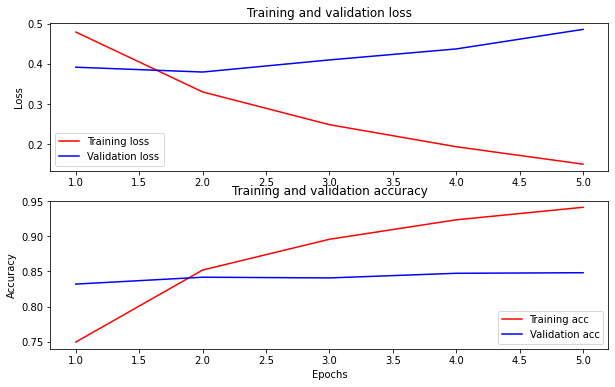

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represents the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999329
input: The movie was great!           : score: 0.994107
input: The movie was meh.             : score: 0.865047
input: The movie was okish.           : score: 0.030797
input: The movie was terrible...      : score: 0.000901

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999329
input: The movie was great!           : score: 0.994107
input: The movie was meh.             : score: 0.865047
input: The movie was okish.           : score: 0.030797
input: The movie was terrible...      : score: 0.000901



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999329
input: The movie was great!           : score: 0.994107
input: The movie was meh.             : score: 0.865048
input: The movie was okish.           : score: 0.030797
input: The movie was terrible...      : score: 0.000901



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu) which runs on a TPU and shows you how to work with multiple inputs.